In [6]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import time
import os
import tqdm as tqdm
import hydroanalysis
from utils.functions import find_max_unique_rows
from utils.functions import find_iterative_immediate_downstream

In [1]:
# Windows
path_estreams = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_part_b\data\EStreams'

In [8]:
# Mac
path_estreams = r'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Scripts/estreams_part_b/data/EStreams'

In [288]:
# Read the dataset network
network_estreams = pd.read_csv(path_estreams+'/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

# Set the nested catchments as a dataframe
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)



# Attributes already filtered previously:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../data/filtered_dataset/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 

In [12]:
# Geological attributes (regional scale)
geology_regional_31_classes_moselle = pd.read_csv("../data/estreams_geology_moselle_regional_attributes.csv", encoding='utf-8')

geology_regional_31_classes_moselle.set_index("basin_id", inplace = True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Alluvium", 'lit_fra_Coal', 'lit_fra_Conglomerate', 'lit_fra_Gravel and sand',
             'lit_fra_Sand', 'lit_fra_Sand and gravel', 'lit_fra_Sandstone and conglomerate', 'lit_fra_Sandstone'
        ],
    
    "medium": ['lit_fra_Limestone', 'lit_fra_Sandstone and marl', 'lit_fra_Sandstone and schist',
              'lit_fra_Sandstone, conglomerate and marl',

              'lit_fra_Arkose', 'lit_fra_Dolomite rock', 'lit_fra_Limestone and marl', 'lit_fra_Marl', 
             'lit_fra_Marl and dolomite', 'lit_fra_Marl and limestone', 'lit_fra_Marl and sandstone',
               'lit_fra_Sandstone and siltstone', 'lit_fra_Sandstone, siltstone and schist', 
              'lit_fra_Schist and sandstone', 'lit_fra_Silt',  'lit_fra_Silt and schist', 'lit_fra_Siltstone, sandstone and schist'
              
             ],
    
    "low": ['lit_fra_Cristallin basement', 'lit_fra_Plutonic rock',  'lit_fra_Quarzite',
                    'lit_fra_Schist','lit_fra_Volcanic rock' 
                   ]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    geology_regional_31_classes_moselle[f'area_perm_{permeability_class}'] = geology_regional_31_classes_moselle[columns].sum(axis=1)

# Drop unnecessary columns
geology_regional_31_classes_moselle = geology_regional_31_classes_moselle[["area_perm_high", "area_perm_medium", "area_perm_low"]]

# Rename the columns
geology_regional_31_classes_moselle.columns = ["perm_high_regi", "perm_medium_regi", "perm_low_regi"]

# Display the updated DataFrame
geology_regional_31_classes_moselle

geology_regional_31_classes_moselle["baseflow_index"] = estreams_attributes["baseflow_index"]
geology_regional_31_classes_moselle.corr(method="pearson")

# Concatenation
estreams_attributes[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]] = geology_regional_31_classes_moselle[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]]

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_glob2"] = estreams_attributes["perm_high_glob"]
estreams_attributes["perm_medium_glob2"] = estreams_attributes["perm_medium_glob"] + estreams_attributes["perm_low_glob"]
estreams_attributes["perm_low_glob2"] = estreams_attributes["perm_verylow_glob"]

###########################################################################################################################
# Adjust the columns of the dataset:
for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_regi"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_regi"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_regi"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_regi"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_regi"] = v3 * 100


for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_glob2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_glob2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_glob2"] = v3 * 100

In [13]:
# Define the functions
def obj_fun_nsee(observations, simulation, expo=0.5):
    """
    Calculate the Normalized Squared Error Efficiency (NSEE) while ensuring that
    NaNs in simulation are NOT masked (only NaNs in observations are masked).

    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).
        expo (float, optional): Exponent applied to observations and simulations. Default is 1.0.

    Returns:
        float: NSEE score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # If simulation contains NaNs after masking observations, return penalty
    if np.isnan(sim).any():
        return 10.0  # Large penalty if NaNs appear in the simulation

    metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
    
    return float(metric)


def obj_fun_kge(observations, simulation):
    """
    Calculate the KGE-2012 objective function, ensuring that NaNs in simulation are NOT masked.
    
    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).

    Returns:
        float: KGE-2012 score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # Check if there are NaNs in the simulation after masking obs
    if np.isnan(sim).any():
        return 10.0  # Large penalty if the simulation contains NaNs
    
    obs_mean = np.mean(obs)
    sim_mean = np.mean(sim)

    r = np.corrcoef(obs, sim)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = sim_mean / obs_mean

    kge = np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)  # KGE-2012

    return float(kge)

In [16]:
# First we define the outlet of the Moselle to be used
outlets = ["DEBU1959"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Adjust and clip it:
estreams_attributes_clipped = estreams_attributes_dfs["DEBU1959"]

# Convert 'date_column' and 'time_column' to datetime
estreams_attributes_clipped['start_date'] = pd.to_datetime(estreams_attributes_clipped['start_date'])
estreams_attributes_clipped['end_date'] = pd.to_datetime(estreams_attributes_clipped['end_date'])


estreams_attributes_clipped_filters = estreams_attributes_clipped[estreams_attributes_clipped.end_date >= "2010"]
estreams_attributes_clipped_filters = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.start_date <= "2002"]

# Here we retrieve the conectivity (from EStreams computation)
# Load the nested catchments CSV file
df = pd.read_excel("../data/nested_catchments.xlsx")

# Rename columns for clarity
df = df.rename(columns={df.columns[1]: "basin_id", df.columns[2]: "connected_basin_id"})
df = df.drop(columns=[df.columns[0]])  # Drop the unnamed index column

100%|██████████| 1/1 [00:00<00:00, 828.42it/s]


In [19]:
# Python implementation
from david2022 import FastReservoirPower, FastReservoirLinear
from superflexpy.framework.unit import Unit
from superflexpy.framework.node import Node
from superflexpy.framework.network import Network

from superflexpy.implementation.elements.hbv import UnsaturatedReservoir, PowerReservoir

from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.root_finders.pegasus import PegasusPython

# Numba implementation:
from superflexpy.implementation.root_finders.pegasus import PegasusNumba
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerNumba

from superflexpy.implementation.elements.hbv import PowerReservoir
from superflexpy.framework.unit import Unit
from superflexpy.implementation.elements.thur_model_hess import SnowReservoir, UnsaturatedReservoir, PowerReservoir, HalfTriangularLag

from superflexpy.implementation.elements.structure_elements import Transparent, Junction, Splitter
from superflexpy.framework.element import ParameterizedElement

In [67]:
root_finder = PegasusNumba()
num_app = ImplicitEulerNumba(root_finder=root_finder)

class ParameterizedSingleFluxSplitter(ParameterizedElement):
    _num_downstream = 2
    _num_upstream = 1
    
    def set_input(self, input):

        self.input = {'Q_in': input[0]}

    def get_output(self, solve=True):

        split_par = self._parameters[self._prefix_parameters + 'splitpar']

        output1 = [self.input['Q_in'] * split_par]
        output2 = [self.input['Q_in'] * (1 - split_par)]
        
        return [output1, output2]   
    
    
lower_splitter = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.5},
    id='lowersplitter'
)

lower_splitter_medium = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.6},
    id='lowersplitter'
)

lower_splitter_high = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.7},
    id='lowersplitter'
)

# Fluxes in the order P, T, PET
upper_splitter = Splitter(
    direction=[
        [0, 1, None],    # P and T go to the snow reservoir
        [2, None, None]  # PET goes to the transparent element
    ],
    weight=[
        [1.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]
    ],
    id='upper-splitter'
)

snow = SnowReservoir(
    parameters={'t0': 0.0, 'k': 0.01, 'm': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='snow'
)

upper_transparent = Transparent(
    id='upper-transparent'
)

upper_junction = Junction(
    direction=[
        [0, None],
        [None, 0]
    ],
    id='upper-junction'
)


unsaturated = UnsaturatedReservoir(
    parameters={'Smax': 150.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
    states={'S0': 10.0},
    approximation=num_app,
    id='unsaturated'
)

fast = PowerReservoir(
    parameters={'k': 0.01, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='fast'
)

slow = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 1.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slow'
)

slowhigh = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slowhigh'
)


lower_junction = Junction(
    direction=[
        [0, 0]
    ],
    id='lower-junction'
)

lag_fun = HalfTriangularLag(
    parameters={'lag-time': 4.0},
    states={'lag': None},
    id='lag-fun'
)

lower_transparent = Transparent(
    id='lower-transparent'
)

lower_transparent2 = Transparent(
    id='lower-transparent2'
)

general = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='general'
)

low = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [fast],
    ],
    id='low'
)

high = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [slowhigh],
    ],
    id='high'
)

In [21]:
data_text = """"
high_snow_k,3.069346878512092
high_unsaturated_Smax,183.19615642249812
high_unsaturated_Ce,1.0386841993034777
high_unsaturated_beta,0.6991640860738063
high_slowhigh_k,0.00012000205470884072
general_snow_k,3.069346878512092
general_unsaturated_Smax,183.19615642249812
general_unsaturated_Ce,1.0386841993034777
general_unsaturated_beta,0.6991640860738063
general_lowersplitter_splitpar,0.5000066917786876
general_slow_k,0.07195753625290782
general_lag-fun_lag-time,2.958641838588317
general_fast_k,0.20310809430504484
low_snow_k,3.069346878512092
low_unsaturated_Smax,183.19615642249812
low_unsaturated_Ce,1.0386841993034777
low_unsaturated_beta,0.6991640860738063
low_fast_k,0.004816655009881832
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_r_1 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_r_1[key] = float(value)
    else:
        1+1

In [22]:
data_text = """"
high_snow_k,3.0365740485599746
high_unsaturated_Smax,130.90402428074796
high_unsaturated_Ce,0.8092303247092076
high_unsaturated_beta,1.5981931455431173
high_slowhigh_k,9.585047986416182e-06
general_snow_k,3.0365740485599746
general_unsaturated_Smax,130.90402428074796
general_unsaturated_Ce,0.8092303247092076
general_unsaturated_beta,1.5981931455431173
general_lowersplitter_splitpar,0.5002909989743869
general_slow_k,0.09504795526553368
general_lag-fun_lag-time,3.0060458116305644
general_fast_k,0.174061039082191
low_snow_k,3.0365740485599746
low_unsaturated_Smax,130.90402428074796
low_unsaturated_Ce,0.8092303247092076
low_unsaturated_beta,1.5981931455431173
low_fast_k,0.0026826026287785727
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_c_1 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_c_1[key] = float(value)
    else:
        1+1

In [189]:
data_text = """"
high_snow_k,3.4702559261578703
high_unsaturated_Smax,273.60907280818105
high_unsaturated_Ce,0.6284992174897663
high_unsaturated_beta,5.33574275131318
high_slowhigh_k,4.761220816764261e-05
general_snow_k,3.4702559261578703
general_unsaturated_Smax,273.60907280818105
general_unsaturated_Ce,0.6284992174897663
general_unsaturated_beta,5.33574275131318
general_lowersplitter_splitpar,0.5007812984200426
general_slow_k,0.09946738314056086
general_lag-fun_lag-time,2.7181443464640305
general_fast_k,0.1470714054742976
low_snow_k,3.4702559261578703
low_unsaturated_Smax,273.60907280818105
low_unsaturated_Ce,0.6284992174897663
low_unsaturated_beta,5.33574275131318
low_fast_k,0.0022345141471588788
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_g_1 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_g_1[key] = float(value)
    else:
        1+1

In [44]:
data_text = """"
high_snow_k,1.7895110997848813
high_unsaturated_Smax,206.70677590214353
high_unsaturated_Ce,1.5335741547683481
high_unsaturated_beta,0.5386162592759998
high_slowhigh_k,6.881217829321073e-05
general_snow_k,1.7895110997848813
general_unsaturated_Smax,206.70677590214353
general_unsaturated_Ce,1.5335741547683481
general_unsaturated_beta,0.5386162592759998
general_lowersplitter_splitpar,0.5000044214948036
general_slow_k,0.09997282239361958
general_lag-fun_lag-time,2.9422774052695653
general_fast_k,0.14543602542365952
low_snow_k,1.7895110997848813
low_unsaturated_Smax,206.70677590214353
low_unsaturated_Ce,1.5335741547683481
low_unsaturated_beta,0.5386162592759998
low_fast_k,0.0019285640867954537
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_g_1_8801 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_g_1_8801[key] = float(value)
    else:
        1+1


In [111]:
data_text = """"
high_snow_k,1.843545894902258
high_unsaturated_Smax,122.71792975383084
high_unsaturated_Ce,1.3680658998241941
high_unsaturated_beta,0.8488477126426069
high_slowhigh_k,1.870921744063965e-05
general_snow_k,1.843545894902258
general_unsaturated_Smax,122.71792975383084
general_unsaturated_Ce,1.3680658998241941
general_unsaturated_beta,0.8488477126426069
general_lowersplitter_splitpar,0.5000242296469859
general_slow_k,0.09950731141761572
general_lag-fun_lag-time,2.999852241580967
general_fast_k,0.17984776225475138
low_snow_k,1.843545894902258
low_unsaturated_Smax,122.71792975383084
low_unsaturated_Ce,1.3680658998241941
low_unsaturated_beta,0.8488477126426069
low_fast_k,0.0033908514824536463
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_r_1_8801 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_r_1_8801[key] = float(value)
    else:
        1+1


In [112]:
data_text = """"
high_snow_k,1.9902554484021415
high_unsaturated_Smax,220.6998349739406
high_unsaturated_Ce,1.4640514613227253
high_unsaturated_beta,0.5477932249709352
high_slowhigh_k,5.730443054442811e-05
general_snow_k,1.9902554484021415
general_unsaturated_Smax,220.6998349739406
general_unsaturated_Ce,1.4640514613227253
general_unsaturated_beta,0.5477932249709352
general_lowersplitter_splitpar,0.5002085721573015
general_slow_k,0.09339663338036011
general_lag-fun_lag-time,3.0032570030324255
general_fast_k,0.1569027016429561
low_snow_k,1.9902554484021415
low_unsaturated_Smax,220.6998349739406
low_unsaturated_Ce,1.4640514613227253
low_unsaturated_beta,0.5477932249709352
low_fast_k,0.002494798306269176
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_c_1_8801 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_c_1_8801[key] = float(value)
    else:
        1+1


In [104]:
best_params_dict_model_g_1_old = {'high_snow_k': 2.951239163078684,
 'high_unsaturated_Smax': 133.6270446707589,
 'high_unsaturated_Ce': 1.0049078746194,
 'high_unsaturated_beta': 0.9245542072624129,
 'high_slowhigh_k': 4.811426542930949e-05,
 'general_snow_k': 2.951239163078684,
 'general_unsaturated_Smax': 133.6270446707589,
 'general_unsaturated_Ce': 1.0049078746194,
 'general_unsaturated_beta': 0.9245542072624129,
 'general_lowersplitter_splitpar': 0.7996787281758282,
 'general_slow_k': 0.0997601739133764,
 'general_lag-fun_lag-time': 2.6620131067315693,
 'general_fast_k': 0.14102579773930624,
 'low_snow_k': 2.951239163078684,
 'low_unsaturated_Smax': 133.6270446707589,
 'low_unsaturated_Ce': 1.0049078746194,
 'low_unsaturated_beta': 0.9245542072624129,
 'low_fast_k': 0.0018833960901255783}

In [254]:
catchments_ids = estreams_attributes_clipped_filters.index.tolist()

def calculate_hydro_year(date, first_month=10):
    """
    This function calculates the hydrological year from a date. The
    hydrological year starts on the month defined by the parameter first_month.

    Parameters
    ----------
    date : pandas.core.indexes.datetimes.DatetimeIndex
        Date series
    first_month : int
        Number of the first month of the hydrological year

    Returns
    -------
    numpy.ndarray
        Hydrological year time series
    """

    hydrological_year = date.year.values.copy()
    hydrological_year[date.month >= first_month] += 1

    return hydrological_year

def run_model_superflexpy(catchments_ids, best_params_dict_model, perm_areas_model):
    # Run the iterative function
    iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

    # Convert results to a DataFrame for display
    iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                        columns=['basin_id', 'immediate_downstream_basin'])


    # Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
    topology_list = {basin: None for basin in catchments_ids}  # Default to None

    # Filter DataFrame for relevant basin_ids and update topology
    for _, row in iterative_downstream_df.iterrows():
        if row['basin_id'] in topology_list:
            topology_list[row['basin_id']] = row['immediate_downstream_basin']

    # Generate Nodes dynamically and assign them as global variables
    catchments = [] # Dictionary to store nodes
    
    general = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='general')

    low = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [fast],
        ],
        id='low')

    high = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [slowhigh],
        ],
        id='high')

    for cat_id in catchments_ids:
        node = Node(
            units=[high, general, low],  # Use unit from dictionary or default
            weights=perm_areas_model[cat_id],
            area=areas.get(cat_id),  # Use predefined area or default
            id=cat_id
        )
        catchments.append(node)  # Store in the list

        # Assign the node as a global variable
        globals()[cat_id] = node


    # Ensure topology only includes nodes that exist in `catchments_ids`
    topology = {
        cat_id: upstream if upstream in catchments_ids else None
        for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
    }

    # Create the Network
    model = Network(
        nodes=catchments,  # Pass list of Node objects
        topology=topology  
    )

    model.reset_states()

    # Set inputs for each node using the manually defined dictionary
    for cat in catchments:
        cat.set_input(inputs[cat.id])  # Correct way to set inputs

    model.set_timestep(1.0)
    model.set_parameters(best_params_dict_model)

    output = model.get_output()

    return output



def generate_nse_results(catchments_ids, daterange, output, observations, quality_masks):


    # Create an empty list to store results
    nse_results_cal = []

    for basin in catchments_ids:
        Qtimeseries = pd.DataFrame(index=daterange)
        Qtimeseries["Qobs"] = observations[basin]
        Qtimeseries["Qcalc"] = output[basin][0]

        hydro_year = calculate_hydro_year(date=Qtimeseries.index, first_month=10)

        nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                    simulation=Qtimeseries.iloc[365:, 1].values, 
                                    expo=0.5)
                
        bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
        bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
        
        qmean_obs = hydroanalysis.streamflow_signatures.calculate_q_mean(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:])
        qmean_sim = hydroanalysis.streamflow_signatures.calculate_q_mean(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:])
        
        slope_obs = hydroanalysis.streamflow_signatures.calculate_slope_fdc(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:])["Sawicz"]
        slope_sim = hydroanalysis.streamflow_signatures.calculate_slope_fdc(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:])["Sawicz"]
        
        hfd_obs = hydroanalysis.streamflow_signatures.calculate_hfd_mean(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], hydro_year[365:])["hfd_mean"]
        hfd_sim = hydroanalysis.streamflow_signatures.calculate_hfd_mean(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], hydro_year[365:])["hfd_mean"]

        try:
            bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
            
            nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                    simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                    expo=0.5)
        except:
            nse_value_bfi = np.nan


        nse_results_cal.append({
            "gauge_name": network_estreams.loc[basin, "gauge_name"],
            "basin": basin,
            "nse": nse_value,
            "bfi_obs": bfi_obs,
            "bfi_sim":bfi_sim,
            "nse_value_bfi": nse_value_bfi,
            "qmean_obs": qmean_obs,
            "qmean_sim": qmean_sim,
            "slope_obs": slope_obs,
            "slope_sim": slope_sim,
            "hfd_obs": hfd_obs,
            "hfd_sim": hfd_sim
            })

    # Convert results to DataFrame
    nse_results_df = pd.DataFrame(nse_results_cal)

    return nse_results_df

In [190]:
path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_1, perm_areas_model = perm_areas)
output_continental = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_1, perm_areas_model = perm_areascontinental)
output_global = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_1, perm_areas_model = perm_areasglobal)

In [191]:
nse_results_cal_r_1_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_regional, observations, quality_masks)
nse_results_cal_c_1_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_continental, observations, quality_masks)
nse_results_cal_g_1_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_global, observations, quality_masks)

In [114]:
nse_results_cal_r_1_100

gauge_name     basin        nse  q_mean_obs  q_mean_calc   bfi_obs  \
0          Reuland  BEWA0066   0.832837    1.238351     1.151910  0.514795   
1       Schoenberg  BEWA0067   0.786154    1.412586     1.249199  0.448057   
2       Martelange  BEWA0087 -19.078025    0.196649     1.203614  0.715474   
3          Reuland  BEWA0106   0.749395    1.011804     0.896928  0.481832   
4    Lommersweiler  BEWA0107   0.722698    1.142034     1.237611  0.569622   
..             ...       ...        ...         ...          ...       ...   
107       Michelau  LU000015   0.760840    1.040332     1.009318  0.524064   
108    Pfaffenthal  LU000016   0.686796    0.801764     0.739716  0.567054   
109        Rosport  LU000017   0.856645    0.935842     0.888319  0.577206   
110     Schoenfels  LU000018   0.622893    0.876011     0.787481  0.549042   
111        Vianden  LU000019   0.811444    1.155285     1.071008  0.500026   

      bfi_sim  nse_value_bfi  
0    0.554200       0.837581  
1    0.536030       0.784464  
2    0.520618            NaN  
3    0.556533            NaN  
4    0.552045            NaN  
..        ...            ...  
107  0.550742       0.799008  
108  0.563036       0.527490  
109  0.598808       0.882752  
110  0.657623       0.501050  
111  0.560993       0.850161  

[112 rows x 8 columns]

In [115]:
nse_results_cal_g_1_100

gauge_name     basin        nse  q_mean_obs  q_mean_calc   bfi_obs  \
0          Reuland  BEWA0066   0.442952    1.238351     1.338746  0.514795   
1       Schoenberg  BEWA0067   0.530905    1.412586     1.471124  0.448057   
2       Martelange  BEWA0087 -21.903793    0.196649     1.342735  0.715474   
3          Reuland  BEWA0106   0.066906    1.011804     0.984184  0.481832   
4    Lommersweiler  BEWA0107   0.029191    1.142034     1.449134  0.569622   
..             ...       ...        ...         ...          ...       ...   
107       Michelau  LU000015   0.096541    1.040332     1.105643  0.524064   
108    Pfaffenthal  LU000016  -0.125665    0.801764     0.727612  0.567054   
109        Rosport  LU000017   0.835147    0.935842     0.950713  0.577206   
110     Schoenfels  LU000018   0.012410    0.876011     0.786526  0.549042   
111        Vianden  LU000019   0.583860    1.155285     1.231195  0.500026   

      bfi_sim  nse_value_bfi  
0    0.843076      -0.390447  
1    0.775606      -0.343022  
2    0.905946            NaN  
3    0.909293            NaN  
4    0.899286            NaN  
..        ...            ...  
107  0.916047      -0.841948  
108  0.446008      -2.848217  
109  0.709182       0.683156  
110  0.445028      -2.684356  
111  0.787978      -0.123898  

[112 rows x 8 columns]

In [194]:
nse_results_cal_g_1_100

gauge_name     basin        nse  q_mean_obs  q_mean_calc   bfi_obs  \
0          Reuland  BEWA0066   0.509680    1.238351     1.413764  0.514795   
1       Schoenberg  BEWA0067   0.537730    1.412586     1.551060  0.448057   
2       Martelange  BEWA0087 -23.463574    0.196649     1.416387  0.715474   
3          Reuland  BEWA0106   0.222121    1.011804     1.041629  0.481832   
4    Lommersweiler  BEWA0107   0.245898    1.142034     1.527285  0.569622   
..             ...       ...        ...         ...          ...       ...   
107       Michelau  LU000015   0.286873    1.040332     1.170369  0.524064   
108    Pfaffenthal  LU000016   0.350317    0.801764     0.730492  0.567054   
109        Rosport  LU000017   0.739243    0.935842     0.997709  0.577206   
110     Schoenfels  LU000018   0.326556    0.876011     0.793484  0.549042   
111        Vianden  LU000019   0.580865    1.155285     1.301136  0.500026   

      bfi_sim  nse_value_bfi  qmean_obs  qmean_sim  
0    0.801690      -0.226092   1.238351   1.413764  
1    0.749340      -0.297544   1.412586   1.551060  
2    0.833118            NaN   0.196649   1.417446  
3    0.848318            NaN   1.011804   1.041613  
4    0.835007            NaN   1.142034   1.525417  
..        ...            ...        ...        ...  
107  0.848358      -0.491782   1.040332   1.170369  
108  0.496831      -0.916501   0.801764   0.730492  
109  0.708731       0.443414   0.935842   0.997709  
110  0.494346      -1.192283   0.876011   0.793484  
111  0.764305      -0.121617   1.155285   1.301136  

[112 rows x 10 columns]

In [192]:
nse_results_cal_g_1_100.iloc[:, 2:].corr()

nse  q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  \
nse            1.000000    0.189276    -0.016855 -0.216209 -0.203590   
q_mean_obs     0.189276    1.000000     0.928117  0.003834 -0.003639   
q_mean_calc   -0.016855    0.928117     1.000000  0.056253  0.140495   
bfi_obs       -0.216209    0.003834     0.056253  1.000000  0.413554   
bfi_sim       -0.203590   -0.003639     0.140495  0.413554  1.000000   
nse_value_bfi  0.933257    0.294876     0.213429 -0.315604 -0.274269   
qmean_obs      0.189276    1.000000     0.928117  0.003834 -0.003639   
qmean_sim     -0.015126    0.928638     0.997694  0.062457  0.144056   

               nse_value_bfi  qmean_obs  qmean_sim  
nse                 0.933257   0.189276  -0.015126  
q_mean_obs          0.294876   1.000000   0.928638  
q_mean_calc         0.213429   0.928117   0.997694  
bfi_obs            -0.315604   0.003834   0.062457  
bfi_sim            -0.274269  -0.003639   0.144056  
nse_value_bfi       1.000000   0.294876   0.213429  
qmean_obs           0.294876   1.000000   0.928638  
qmean_sim           0.213429   0.928638   1.000000

In [116]:
nse_results_cal_c_1_100.iloc[:, 2:].corr()

nse  q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  \
nse            1.000000    0.169664    -0.029855 -0.220712  0.014856   
q_mean_obs     0.169664    1.000000     0.932220  0.003834 -0.195377   
q_mean_calc   -0.029855    0.932220     1.000000  0.052356 -0.173076   
bfi_obs       -0.220712    0.003834     0.052356  1.000000  0.501890   
bfi_sim        0.014856   -0.195377    -0.173076  0.501890  1.000000   
nse_value_bfi  0.975919    0.370602     0.270118 -0.522706 -0.541692   

               nse_value_bfi  
nse                 0.975919  
q_mean_obs          0.370602  
q_mean_calc         0.270118  
bfi_obs            -0.522706  
bfi_sim            -0.541692  
nse_value_bfi       1.000000

In [117]:
nse_results_cal_r_1_100.iloc[:, 2:].corr()

nse  q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  \
nse            1.000000    0.167935    -0.030456 -0.219401  0.065177   
q_mean_obs     0.167935    1.000000     0.931963  0.003834 -0.226113   
q_mean_calc   -0.030456    0.931963     1.000000  0.045125 -0.190665   
bfi_obs       -0.219401    0.003834     0.045125  1.000000  0.654780   
bfi_sim        0.065177   -0.226113    -0.190665  0.654780  1.000000   
nse_value_bfi  0.976623    0.323821     0.196489 -0.579411 -0.581470   

               nse_value_bfi  
nse                 0.976623  
q_mean_obs          0.323821  
q_mean_calc         0.196489  
bfi_obs            -0.579411  
bfi_sim            -0.581470  
nse_value_bfi       1.000000

In [122]:
path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()


output_regional_8801 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_1_8801, perm_areas_model = perm_areas)
output_continental_8801 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_1_8801, perm_areas_model = perm_areascontinental)
output_global_8801 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_1_8801, perm_areas_model = perm_areasglobal)

In [121]:
nse_results_cal_r_1_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_regional_8801, observations, quality_masks)
nse_results_cal_c_1_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_continental_8801, observations, quality_masks)
nse_results_cal_g_1_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_global_8801, observations, quality_masks)

/Users/thiagomedeirosdonascimento/anaconda3/envs/superflexpy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  Type to use in computing the standard deviation. For arrays of
/Users/thiagomedeirosdonascimento/anaconda3/envs/superflexpy/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_55322/1110209421.py:27: RuntimeWarning: invalid value encountered in scalar divide
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_55322/1927388375.py:118: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)
/Users/thiagomedeirosdonascimento/anaconda3/envs/superflexpy/lib/python3.9/site-packages/hydroanalysis/utils.py:63: UserWarning: Skipped because of no data
  warnings

In [195]:
path_inputs = '../data/models/input/subset_1988_2001'

observations1 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks1 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()

path_inputs = '../data/models/input/subset_2001_2015'

observations2 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks2 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()

In [197]:
observations_cal = {}

for key in observations1.keys():
    arr1 = np.atleast_1d(observations1[key])
    arr2 = np.atleast_1d(observations2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    observations_cal[key] = np.concatenate([arr1, arr2])

quality_masks_cal = {}

for key in quality_masks1.keys():
    arr1 = np.atleast_1d(quality_masks1[key])
    arr2 = np.atleast_1d(quality_masks2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    quality_masks_cal[key] = np.concatenate([arr1, arr2])

output_regional_cal = {
    key: [np.concatenate([output_regional_8801[key][0], output_regional[key][0]])]
    for key in output_regional_8801
    if key in output_regional  # ensures keys match
}

output_continental_cal = {
    key: [np.concatenate([output_continental_8801[key][0], output_continental[key][0]])]
    for key in output_continental_8801
    if key in output_continental  # ensures keys match
}

output_global_cal = {
    key: [np.concatenate([output_global_8801[key][0], output_global[key][0]])]
    for key in output_global_8801
    if key in output_global  # ensures keys match
}

In [255]:
nse_results_cal_r_1_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_regional_cal, observations_cal, quality_masks_cal)

In [256]:
nse_results_cal_c_1_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_continental_cal, observations_cal, quality_masks_cal)

In [257]:
nse_results_cal_g_1_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_global_cal, observations_cal, quality_masks_cal)

In [201]:
list_cal = ['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 #'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']

In [258]:
data_diff_cal_complete = pd.DataFrame(data=nse_results_cal_r_1_100_complete_cal.nse - nse_results_cal_c_1_100_complete_cal.nse)
data_diff_cal_complete["nse_rg"] = nse_results_cal_r_1_100_complete_cal.nse - nse_results_cal_g_1_100_complete_cal.nse

data_diff_cal_complete.index = nse_results_cal_c_1_100_complete_cal.basin

data_diff_cal_complete = data_diff_cal_complete.loc[~data_diff_cal_complete.index.isin(list_cal)]

data_diff_cal_complete["nse_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).nse
data_diff_cal_complete["nse_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).nse
data_diff_cal_complete["nse_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).nse

data_diff_cal_complete["nse_bfi_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal_complete["nse_bfi_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal_complete["nse_bfi_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi

data_diff_cal_complete["bfi_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).bfi_obs
data_diff_cal_complete["bfi_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).bfi_sim
data_diff_cal_complete["bfi_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).bfi_sim
data_diff_cal_complete["bfi_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).bfi_sim

data_diff_cal_complete["qmean_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).qmean_obs
data_diff_cal_complete["qmean_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).qmean_sim
data_diff_cal_complete["qmean_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).qmean_sim
data_diff_cal_complete["qmean_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).qmean_sim

data_diff_cal_complete["slope_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).slope_obs
data_diff_cal_complete["slope_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).slope_sim
data_diff_cal_complete["slope_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).slope_sim
data_diff_cal_complete["slope_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).slope_sim

data_diff_cal_complete["hfd_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).hfd_obs
data_diff_cal_complete["hfd_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).hfd_sim
data_diff_cal_complete["hfd_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).hfd_sim
data_diff_cal_complete["hfd_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).hfd_sim


data_diff_cal_complete = data_diff_cal_complete[data_diff_cal_complete.nse_r1 > -10.0]
data_diff_cal_complete

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066 -0.014408  0.369000  0.839831  0.854240  0.470832         NaN   
BEWA0067 -0.005194  0.292153  0.796970  0.802164  0.504818         NaN   
BEWA0106 -0.010094  0.512953  0.770358  0.780453  0.257406         NaN   
BEWA0107 -0.021005  0.410117  0.733016  0.754021  0.322898         NaN   
BEWA0119 -0.005291  0.339908  0.827236  0.832527  0.487328         NaN   
...            ...       ...       ...       ...       ...         ...   
LU000015 -0.084315  0.542589  0.767700  0.852015  0.225111         NaN   
LU000016  0.113914  0.343683  0.701424  0.587510  0.357741         NaN   
LU000017 -0.016255  0.135378  0.858641  0.874896  0.723262         NaN   
LU000018  0.345349  0.296385  0.636608  0.291259  0.340223         NaN   
LU000019 -0.022415  0.244848  0.813797  0.836212  0.568949         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  qmean_c1  qmean_g1  \
basin                                                 ...                       
BEWA0066         NaN         NaN  0.515742  0.553206  ...  1.354694  1.457307   
BEWA0067         NaN         NaN  0.446878  0.537183  ...  1.450693  1.586287   
BEWA0106         NaN         NaN  0.496805  0.551697  ...  1.057259  1.089794   
BEWA0107         NaN         NaN  0.565063  0.540640  ...  1.459128  1.518122   
BEWA0119         NaN         NaN  0.508101  0.547025  ...  1.353553  1.428957   
...              ...         ...       ...       ...  ...       ...       ...   
LU000015         NaN         NaN  0.516853  0.546272  ...  1.078589  1.162015   
LU000016         NaN         NaN  0.564940  0.561432  ...  0.754176  0.731962   
LU000017         NaN         NaN  0.572433  0.594660  ...  0.936887  0.999973   
LU000018         NaN         NaN  0.549133  0.655838  ...  0.779406  0.795357   
LU000019         NaN         NaN  0.492709  0.554438  ...  1.177095  1.312171   

          slope_obs  slope_r1  slope_c1  slope_g1     hfd_obs      hfd_r1  \
basin                                                                       
BEWA0066   3.400558  2.848416  2.978111  1.557254  126.294118  133.764706   
BEWA0067   3.527884  2.830461  2.928890  1.680608  123.437500  135.687500   
BEWA0106   4.063631  2.917710  2.903958  1.539910  127.000000  132.608696   
BEWA0107   3.418299  2.918635  2.907526  1.603042  133.588235  138.000000   
BEWA0119   3.336434  2.895043  2.913319  1.714001  123.266667  132.800000   
...             ...       ...       ...       ...         ...         ...   
LU000015   4.331634  2.596426  3.182454  1.596377  121.769231  131.230769   
LU000016   2.005883  2.661788  3.677462  4.492247  133.615385  133.230769   
LU000017   2.459555  2.331304  2.601025  2.115889  127.307692  135.230769   
LU000018   2.305895  2.109543  1.053861  4.490287  127.384615  140.076923   
LU000019   3.428468  2.525095  2.963713  1.639118  125.846154  134.615385   

              hfd_c1      hfd_g1  
basin                             
BEWA0066  130.647059  157.764706  
BEWA0067  130.812500  152.500000  
BEWA0106  134.130435  170.478261  
BEWA0107  134.470588  166.764706  
BEWA0119  131.266667  154.800000  
...              ...         ...  
LU000015  127.384615  170.153846  
LU000016  128.692308  144.307692  
LU000017  132.461538  152.461538  
LU000018  170.615385  141.076923  
LU000019  129.000000  153.307692  

[98 rows x 24 columns]

In [259]:
data_diff_cal_complete.corr()

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
nse         1.000000  0.043132 -0.021643 -0.369887 -0.045113   -0.277077   
nse_rg      0.043132  1.000000  0.076277  0.055798 -0.569300    0.157666   
nse_r1     -0.021643  0.076277  1.000000  0.936865  0.776310    0.881081   
nse_c1     -0.369887  0.055798  0.936865  1.000000  0.737200    0.744610   
nse_g1     -0.045113 -0.569300  0.776310  0.737200  1.000000    0.636215   
nse_bfi_r1 -0.277077  0.157666  0.881081  0.744610  0.636215    1.000000   
nse_bfi_c1 -0.753049  0.119677  0.785119  0.917043  0.582304    0.792280   
nse_bfi_g1 -0.131029 -0.617743  0.527662  0.428447  0.907241    0.640668   
bfi_obs     0.172008 -0.056453 -0.457133 -0.484975 -0.341232   -0.264362   
bfi_r1      0.284217 -0.083218 -0.424290 -0.493702 -0.297231   -0.684133   
bfi_c1      0.324049  0.025791 -0.378034 -0.464649 -0.328006   -0.667594   
bfi_g1     -0.152987  0.427723 -0.115799 -0.054101 -0.365883   -0.302685   
qmean_obs  -0.147343 -0.290998  0.087000  0.132386  0.255702    0.292021   
qmean_r1   -0.111518 -0.258332  0.138156  0.167393  0.277230    0.208164   
qmean_c1   -0.124303 -0.246826  0.144613  0.177866  0.275280    0.217242   
qmean_g1   -0.129586 -0.232601  0.150947  0.185600  0.271510    0.210475   
slope_obs  -0.333672  0.219340  0.266103  0.363998  0.080745    0.385811   
slope_r1   -0.290308 -0.032058  0.288741  0.369868  0.258343    0.582832   
slope_c1   -0.216629  0.048828  0.267670  0.324515  0.189834    0.588747   
slope_g1    0.230336 -0.158302  0.008503 -0.072663  0.107089    0.253997   
hfd_obs     0.105377 -0.118779 -0.641893 -0.633366 -0.454171   -0.228929   
hfd_r1      0.256853  0.020180 -0.523958 -0.576752 -0.444778   -0.727196   
hfd_c1      0.415972  0.024108 -0.494818 -0.605328 -0.423234   -0.723288   
hfd_g1     -0.015883  0.658460 -0.233013 -0.210982 -0.608400   -0.347039   

            nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  qmean_c1  \
nse          -0.753049   -0.131029  0.172008  0.284217  ... -0.124303   
nse_rg        0.119677   -0.617743 -0.056453 -0.083218  ... -0.246826   
nse_r1        0.785119    0.527662 -0.457133 -0.424290  ...  0.144613   
nse_c1        0.917043    0.428447 -0.484975 -0.493702  ...  0.177866   
nse_g1        0.582304    0.907241 -0.341232 -0.297231  ...  0.275280   
nse_bfi_r1    0.792280    0.640668 -0.264362 -0.684133  ...  0.217242   
nse_bfi_c1    1.000000    0.491004 -0.334240 -0.600869  ...  0.261068   
nse_bfi_g1    0.491004    1.000000 -0.312573 -0.469526  ...  0.287882   
bfi_obs      -0.334240   -0.312573  1.000000  0.650508  ...  0.013379   
bfi_r1       -0.600869   -0.469526  0.650508  1.000000  ... -0.148771   
bfi_c1       -0.417930   -0.397485  0.473083  0.867100  ... -0.206888   
bfi_g1       -0.259909   -0.728879  0.346334  0.482785  ...  0.085238   
qmean_obs     0.296151    0.410312  0.035781 -0.212125  ...  0.950060   
qmean_r1      0.254183    0.282456  0.016441 -0.142352  ...  0.999414   
qmean_c1      0.261068    0.287882  0.013379 -0.148771  ...  1.000000   
qmean_g1      0.264367    0.290601  0.015897 -0.133257  ...  0.998149   
slope_obs     0.371928    0.295977 -0.709873 -0.582613  ...  0.056370   
slope_r1      0.546410    0.402530 -0.612456 -0.938226  ...  0.016984   
slope_c1      0.306702    0.315135 -0.462061 -0.827624  ...  0.053849   
slope_g1      0.226570    0.640150 -0.305710 -0.426265  ... -0.298723   
hfd_obs      -0.303709   -0.357277  0.844838  0.690846  ... -0.035136   
hfd_r1       -0.619513   -0.499967  0.566171  0.924918  ... -0.127724   
hfd_c1       -0.531829   -0.440643  0.466364  0.825344  ... -0.216806   
hfd_g1       -0.330408   -0.761026  0.256485  0.404785  ... -0.231860   

            qmean_g1  slope_obs  slope_r1  slope_c1  slope_g1   hfd_obs  \
nse        -0.129586  -0.333672 -0.290308 -0.216629  0.230336  0.105377   
nse_rg     -0.232601   0.219340 -0.032058  0.048828 -0.158302 -0.118779   
nse_r1      0.150947   0.266103  0.288741  0.267670  0.008503 -0.

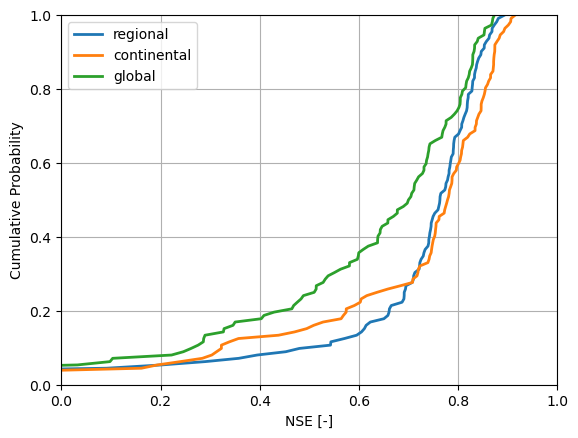

In [204]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(nse_results_cal_r_1_100["nse"].dropna())
nse_values_2 = np.sort(nse_results_cal_c_1_100["nse"].dropna())
nse_values_3 = np.sort(nse_results_cal_g_1_100["nse"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

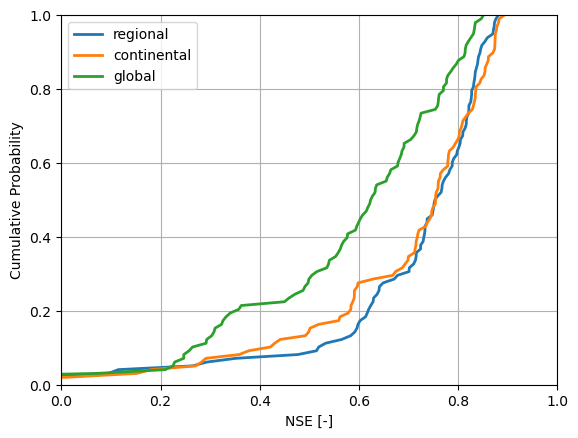

In [205]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_complete["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_complete["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal_complete["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


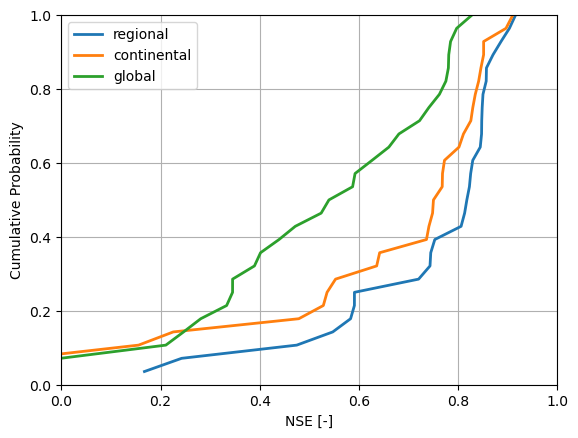

In [206]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_complete["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_complete["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal_complete["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


In [207]:
path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_val = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_1, perm_areas_model = perm_areas)
output_continental_val = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_1, perm_areas_model = perm_areascontinental)
output_global_val = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_1, perm_areas_model = perm_areasglobal)

In [138]:
path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_0115 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_1_8801, perm_areas_model = perm_areas)
output_continental_0115 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_1_8801, perm_areas_model = perm_areascontinental)
output_global_0115 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_1_8801, perm_areas_model = perm_areasglobal)

In [208]:
output_regional_val_c = {
    key: [np.concatenate([output_regional_val[key][0], output_regional_0115[key][0]])]
    for key in output_regional_0115
    if key in output_regional_val  # ensures keys match
}

output_continental_val_c = {
    key: [np.concatenate([output_continental_val[key][0], output_continental_0115[key][0]])]
    for key in output_continental_val
    if key in output_continental_0115  # ensures keys match
}

output_global_val_c = {
    key: [np.concatenate([output_global_val[key][0], output_global_0115[key][0]])]
    for key in output_global_val
    if key in output_global_0115  # ensures keys match
}

In [260]:
nse_results_cal_r_1_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_regional_val_c, observations_cal, quality_masks_cal)

In [261]:
nse_results_cal_c_1_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_continental_val_c, observations_cal, quality_masks_cal)

In [262]:
nse_results_cal_g_1_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_global_val_c, observations_cal, quality_masks_cal)

In [263]:
data_diff_val_complete = pd.DataFrame(data=nse_results_cal_r_1_100_complete_val.nse - nse_results_cal_c_1_100_complete_val.nse)
data_diff_val_complete["nse_rg"] = nse_results_cal_r_1_100_complete_val.nse - nse_results_cal_g_1_100_complete_val.nse

data_diff_val_complete.index = nse_results_cal_c_1_100_complete_val.basin

data_diff_val_complete = data_diff_val_complete.loc[~data_diff_val_complete.index.isin(list_cal)]

data_diff_val_complete["nse_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).nse
data_diff_val_complete["nse_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).nse
data_diff_val_complete["nse_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).nse

data_diff_val_complete["nse_bfi_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).nse_value_bfi
data_diff_val_complete["nse_bfi_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).nse_value_bfi
data_diff_val_complete["nse_bfi_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).nse_value_bfi

data_diff_val_complete["bfi_obs"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).bfi_obs
data_diff_val_complete["bfi_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).bfi_sim
data_diff_val_complete["bfi_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).bfi_sim
data_diff_val_complete["bfi_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).bfi_sim

data_diff_val_complete["qmean_obs"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).qmean_obs
data_diff_val_complete["qmean_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).qmean_sim
data_diff_val_complete["qmean_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).qmean_sim
data_diff_val_complete["qmean_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).qmean_sim

data_diff_val_complete["slope_obs"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).slope_obs
data_diff_val_complete["slope_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).slope_sim
data_diff_val_complete["slope_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).slope_sim
data_diff_val_complete["slope_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).slope_sim

data_diff_val_complete["hfd_obs"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).hfd_obs
data_diff_val_complete["hfd_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).hfd_sim
data_diff_val_complete["hfd_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).hfd_sim
data_diff_val_complete["hfd_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).hfd_sim


data_diff_val_complete = data_diff_val_complete[data_diff_val_complete.nse_r1 > -10.0]
data_diff_val_complete

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066  0.023129  0.314367  0.835661  0.812532  0.521295         NaN   
BEWA0067  0.035792  0.245765  0.785181  0.749389  0.539416         NaN   
BEWA0106  0.003713  0.452893  0.756730  0.753017  0.303837         NaN   
BEWA0107  0.005232  0.362060  0.740464  0.735232  0.378404         NaN   
BEWA0119  0.015442  0.315928  0.811970  0.796528  0.496042         NaN   
...            ...       ...       ...       ...       ...         ...   
LU000015  0.042207  0.418511  0.819813  0.777607  0.401302         NaN   
LU000016 -0.035292  0.009937  0.636273  0.671565  0.626335         NaN   
LU000017  0.023833  0.080182  0.860150  0.836317  0.779968         NaN   
LU000018  0.246717  0.062756  0.630852  0.384135  0.568096         NaN   
LU000019  0.034716  0.202976  0.818594  0.783879  0.615618         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  qmean_c1  qmean_g1  \
basin                                                 ...                       
BEWA0066         NaN         NaN  0.515742  0.552411  ...  1.261123  1.296871   
BEWA0067         NaN         NaN  0.446878  0.538522  ...  1.309893  1.346592   
BEWA0106         NaN         NaN  0.496805  0.550333  ...  1.078410  1.113985   
BEWA0107         NaN         NaN  0.565063  0.537963  ...  1.445895  1.471692   
BEWA0119         NaN         NaN  0.508101  0.546757  ...  1.346217  1.402110   
...              ...         ...       ...       ...  ...       ...       ...   
LU000015         NaN         NaN  0.516853  0.551345  ...  0.941913  0.941315   
LU000016         NaN         NaN  0.564940  0.522122  ...  0.699187  0.705270   
LU000017         NaN         NaN  0.572433  0.591535  ...  0.833624  0.837508   
LU000018         NaN         NaN  0.549133  0.653295  ...  0.737937  0.750475   
LU000019         NaN         NaN  0.492709  0.555690  ...  1.003971  1.005479   

          slope_obs  slope_r1  slope_c1  slope_g1     hfd_obs      hfd_r1  \
basin                                                                       
BEWA0066   3.400558  3.069442  2.641574  1.812909  126.294118  130.235294   
BEWA0067   3.527884  3.114616  2.638771  1.896443  123.437500  130.062500   
BEWA0106   4.063631  3.027709  2.673221  1.664567  127.000000  131.913043   
BEWA0107   3.418299  3.059090  2.778149  1.858863  133.588235  134.764706   
BEWA0119   3.336434  3.063621  2.740482  2.005029  123.266667  130.266667   
...             ...       ...       ...       ...         ...         ...   
LU000015   4.331634  2.995448  2.316524  1.395333  121.769231  124.384615   
LU000016   2.005883  3.044009  2.635860  2.918615  133.615385  126.000000   
LU000017   2.459555  2.591746  2.054877  1.710805  127.307692  129.461538   
LU000018   2.305895  1.958625  1.279312  2.965307  127.384615  134.769231   
LU000019   3.428468  2.845910  2.278556  1.598414  125.846154  128.307692   

              hfd_c1      hfd_g1  
basin                             
BEWA0066  133.647059  155.058824  
BEWA0067  135.937500  152.125000  
BEWA0106  134.130435  165.739130  
BEWA0107  137.352941  164.117647  
BEWA0119  132.266667  153.200000  
...              ...         ...  
LU000015  130.846154  160.461538  
LU000016  131.076923  128.769231  
LU000017  135.538462  144.153846  
LU000018  158.230769  128.461538  
LU000019  134.923077  151.538462  

[98 rows x 24 columns]

In [264]:
data_diff_val_complete.corr()

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
nse         1.000000  0.062328  0.257487 -0.061133  0.207550   -0.339393   
nse_rg      0.062328  1.000000  0.187104  0.172883 -0.381434    0.199663   
nse_r1      0.257487  0.187104  1.000000  0.948734  0.836703    0.885212   
nse_c1     -0.061133  0.172883  0.948734  1.000000  0.796389    0.769816   
nse_g1      0.207550 -0.381434  0.836703  0.796389  1.000000    0.651947   
nse_bfi_r1 -0.339393  0.199663  0.885212  0.769816  0.651947    1.000000   
nse_bfi_c1 -0.758901  0.208067  0.803749  0.924707  0.572426    0.840230   
nse_bfi_g1 -0.176139 -0.593751  0.522261  0.442111  0.903436    0.633518   
bfi_obs    -0.151080 -0.184438 -0.514506 -0.482045 -0.381333   -0.342661   
bfi_r1      0.075779 -0.104565 -0.459683 -0.499621 -0.374273   -0.708739   
bfi_c1      0.119400  0.017380 -0.412123 -0.464762 -0.397503   -0.658064   
bfi_g1     -0.045070  0.576773 -0.127150 -0.116598 -0.441202   -0.293602   
qmean_obs  -0.139854 -0.220967  0.081441  0.129873  0.199827    0.328902   
qmean_r1   -0.066432 -0.155522  0.119810  0.145489  0.199447    0.256076   
qmean_c1   -0.065553 -0.167861  0.114937  0.140168  0.201740    0.258868   
qmean_g1   -0.062651 -0.184042  0.105812  0.129793  0.202174    0.252759   
slope_obs   0.032222  0.420812  0.328966  0.329269  0.074959    0.471986   
slope_r1   -0.106530  0.115341  0.364807  0.411678  0.278986    0.639781   
slope_c1   -0.079092 -0.052713  0.301689  0.337504  0.313281    0.565449   
slope_g1    0.009455 -0.451100  0.045895  0.044314  0.294676    0.237038   
hfd_obs    -0.207283 -0.206920 -0.690223 -0.645169 -0.534151   -0.322986   
hfd_r1     -0.009780 -0.134778 -0.586813 -0.602955 -0.477061   -0.743607   
hfd_c1      0.098042 -0.016897 -0.538606 -0.588428 -0.497415   -0.697441   
hfd_g1     -0.072392  0.634867 -0.226886 -0.210684 -0.567442   -0.303258   

            nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  qmean_c1  \
nse          -0.758901   -0.176139 -0.151080  0.075779  ... -0.065553   
nse_rg        0.208067   -0.593751 -0.184438 -0.104565  ... -0.167861   
nse_r1        0.803749    0.522261 -0.514506 -0.459683  ...  0.114937   
nse_c1        0.924707    0.442111 -0.482045 -0.499621  ...  0.140168   
nse_g1        0.572426    0.903436 -0.381333 -0.374273  ...  0.201740   
nse_bfi_r1    0.840230    0.633518 -0.342661 -0.708739  ...  0.258868   
nse_bfi_c1    1.000000    0.506551 -0.322454 -0.689476  ...  0.239703   
nse_bfi_g1    0.506551    1.000000 -0.214251 -0.463714  ...  0.215306   
bfi_obs      -0.322454   -0.214251  1.000000  0.658109  ...  0.027759   
bfi_r1       -0.689476   -0.463714  0.658109  1.000000  ... -0.097580   
bfi_c1       -0.560000   -0.437062  0.461360  0.877201  ... -0.207829   
bfi_g1       -0.319354   -0.722731  0.355873  0.518414  ...  0.046217   
qmean_obs     0.287770    0.344023  0.035781 -0.182188  ...  0.946733   
qmean_r1      0.239375    0.212576  0.022875 -0.102343  ...  0.999699   
qmean_c1      0.239703    0.215306  0.027759 -0.097580  ...  1.000000   
qmean_g1      0.238415    0.216597  0.038486 -0.076835  ...  0.999151   
slope_obs     0.401291    0.246291 -0.709873 -0.570405  ...  0.032045   
slope_r1      0.650025    0.440541 -0.657138 -0.959217  ... -0.033691   
slope_c1      0.433441    0.335166 -0.425443 -0.815393  ...  0.152260   
slope_g1      0.278478    0.612362 -0.369246 -0.499158  ... -0.162809   
hfd_obs      -0.297728   -0.263304  0.844838  0.683111  ... -0.011478   
hfd_r1       -0.726758   -0.519910  0.600929  0.927097  ... -0.049208   
hfd_c1       -0.644391   -0.465224  0.452536  0.834170  ... -0.184994   
hfd_g1       -0.346289   -0.749480  0.283467  0.471728  ... -0.104591   

            qmean_g1  slope_obs  slope_r1  slope_c1  slope_g1   hfd_obs  \
nse        -0.062651   0.032222 -0.106530 -0.079092  0.009455 -0.207283   
nse_rg     -0.184042   0.420812  0.115341 -0.052713 -0.451100 -0.206920   
nse_r1      0.105812   0.328966  0.364807  0.301689  0.045895 -0.

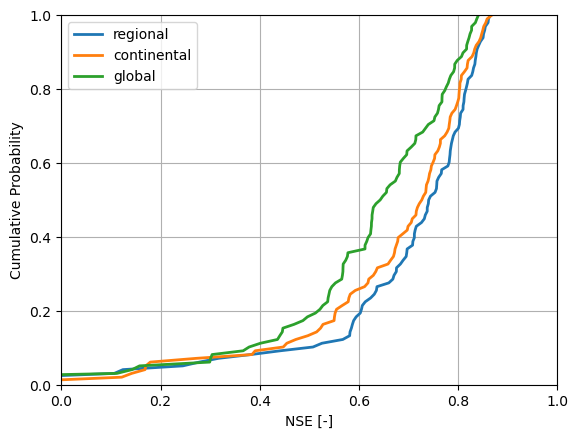

In [213]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val_complete["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_val_complete["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_val_complete["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


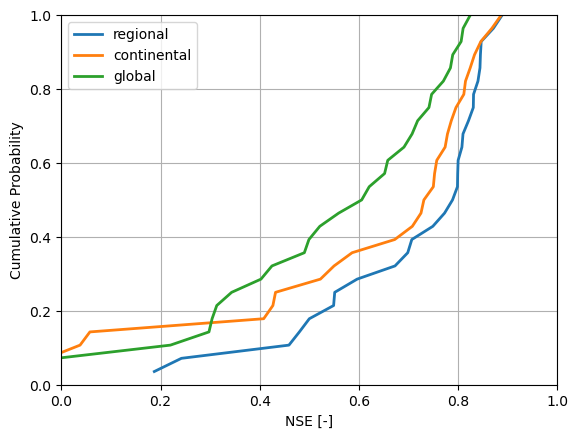

In [214]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val_complete["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_val_complete["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_val_complete["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


In [148]:
data_diff_val_complete.corr()

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
nse         1.000000 -0.121552  0.257487 -0.061133  0.133114   -0.339393   
nse_rg     -0.121552  1.000000  0.041636  0.082769 -0.999011    0.132648   
nse_r1      0.257487  0.041636  1.000000  0.948734  0.002824    0.885212   
nse_c1     -0.061133  0.082769  0.948734  1.000000 -0.040626    0.769816   
nse_g1      0.133114 -0.999011  0.002824 -0.040626  1.000000   -0.117416   
nse_bfi_r1 -0.339393  0.132648  0.885212  0.769816 -0.117416    1.000000   
nse_bfi_c1 -0.758901  0.232818  0.803749  0.924707 -0.219492    0.840230   
nse_bfi_g1  0.338095 -0.999045 -0.231309 -0.326063  0.999393   -0.101509   
bfi_obs    -0.151080  0.227579 -0.514506 -0.482045 -0.250669   -0.342661   
bfi_r1      0.075779  0.171548 -0.459683 -0.499621 -0.192150   -0.708739   
bfi_c1      0.119400  0.004385 -0.412123 -0.464762 -0.022727   -0.658064   
bfi_g1     -0.035972  0.308412 -0.019919 -0.007628 -0.263028   -0.375892   

            nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1    bfi_c1    bfi_g1  
nse          -0.758901    0.338095 -0.151080  0.075779  0.119400 -0.035972  
nse_rg        0.232818   -0.999045  0.227579  0.171548  0.004385  0.308412  
nse_r1        0.803749   -0.231309 -0.514506 -0.459683 -0.412123 -0.019919  
nse_c1        0.924707   -0.326063 -0.482045 -0.499621 -0.464762 -0.007628  
nse_g1       -0.219492    0.999393 -0.250669 -0.192150 -0.022727 -0.263028  
nse_bfi_r1    0.840230   -0.101509 -0.342661 -0.708739 -0.658064 -0.375892  
nse_bfi_c1    1.000000   -0.208257 -0.322454 -0.689476 -0.560000 -0.451851  
nse_bfi_g1   -0.208257    1.000000 -0.428925 -0.191102  0.062464 -0.656372  
bfi_obs      -0.322454   -0.428925  1.000000  0.658109  0.461360  0.288661  
bfi_r1       -0.689476   -0.191102  0.658109  1.000000  0.877201  0.451681  
bfi_c1       -0.560000    0.062464  0.461360  0.877201  1.000000  0.401621  
bfi_g1       -0.451851   -0.656372  0.288661  0.451681  0.401621  1.000000

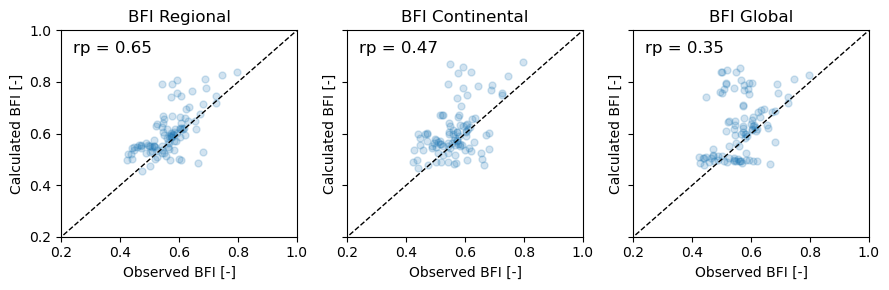

In [215]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['bfi_r1', 'bfi_c1', 'bfi_g1']
titles = ['BFI Regional', 'BFI Continental', 'BFI Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_cal_complete["bfi_obs"]
    y = data_diff_cal_complete[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(0.2, 1.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_cal_complete[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

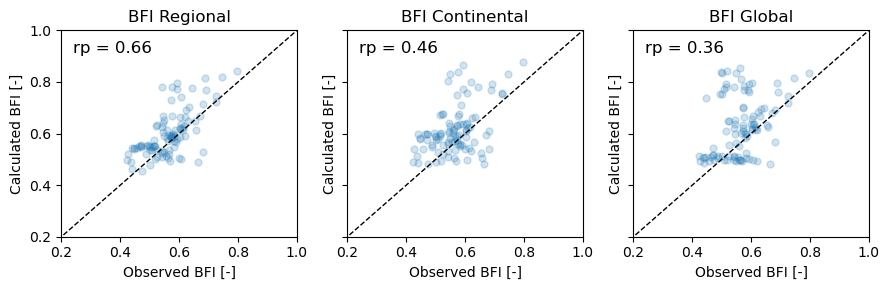

In [216]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['bfi_r1', 'bfi_c1', 'bfi_g1']
titles = ['BFI Regional', 'BFI Continental', 'BFI Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete["bfi_obs"]
    y = data_diff_val_complete[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(0.2, 1.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

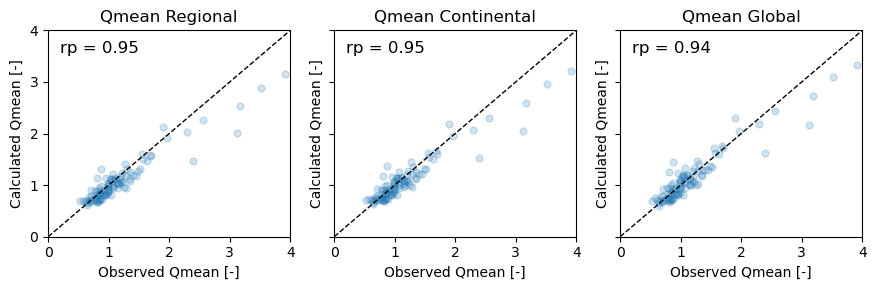

In [221]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['qmean_r1', 'qmean_c1', 'qmean_g1']
titles = ['Qmean Regional', 'Qmean Continental', 'Qmean Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete["qmean_obs"]
    y = data_diff_val_complete[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 4], [0, 4], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed Qmean [-]")
    ax.set_ylabel("Calculated Qmean [-]")
    ax.set_title(title)
    ax.set_xlim(0.0, 4.0)
    ax.set_ylim(0.0, 4.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

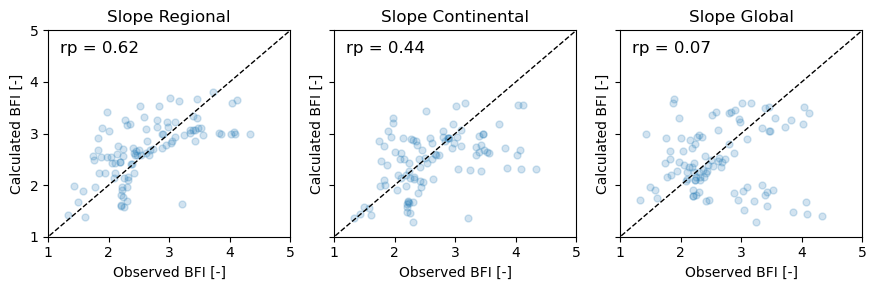

In [242]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['slope_r1', 'slope_c1', 'slope_g1']
titles = ['Slope Regional', 'Slope Continental', 'Slope Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete["slope_obs"]
    y = data_diff_val_complete[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 5], [0, 5], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(1, 5.0)
    ax.set_ylim(1, 5.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

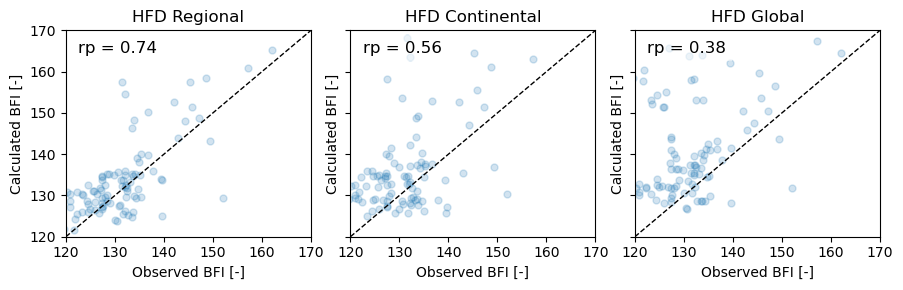

In [268]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['hfd_r1', 'hfd_c1', 'hfd_g1']
titles = ['HFD Regional', 'HFD Continental', 'HFD Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete["hfd_obs"]
    y = data_diff_val_complete[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([120, 200], [120, 200], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(120, 170.0)
    ax.set_ylim(120, 170.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

In [269]:
data_diff_val_complete

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066  0.023129  0.314367  0.835661  0.812532  0.521295         NaN   
BEWA0067  0.035792  0.245765  0.785181  0.749389  0.539416         NaN   
BEWA0106  0.003713  0.452893  0.756730  0.753017  0.303837         NaN   
BEWA0107  0.005232  0.362060  0.740464  0.735232  0.378404         NaN   
BEWA0119  0.015442  0.315928  0.811970  0.796528  0.496042         NaN   
...            ...       ...       ...       ...       ...         ...   
LU000015  0.042207  0.418511  0.819813  0.777607  0.401302         NaN   
LU000016 -0.035292  0.009937  0.636273  0.671565  0.626335         NaN   
LU000017  0.023833  0.080182  0.860150  0.836317  0.779968         NaN   
LU000018  0.246717  0.062756  0.630852  0.384135  0.568096         NaN   
LU000019  0.034716  0.202976  0.818594  0.783879  0.615618         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  qmean_c1  qmean_g1  \
basin                                                 ...                       
BEWA0066         NaN         NaN  0.515742  0.552411  ...  1.261123  1.296871   
BEWA0067         NaN         NaN  0.446878  0.538522  ...  1.309893  1.346592   
BEWA0106         NaN         NaN  0.496805  0.550333  ...  1.078410  1.113985   
BEWA0107         NaN         NaN  0.565063  0.537963  ...  1.445895  1.471692   
BEWA0119         NaN         NaN  0.508101  0.546757  ...  1.346217  1.402110   
...              ...         ...       ...       ...  ...       ...       ...   
LU000015         NaN         NaN  0.516853  0.551345  ...  0.941913  0.941315   
LU000016         NaN         NaN  0.564940  0.522122  ...  0.699187  0.705270   
LU000017         NaN         NaN  0.572433  0.591535  ...  0.833624  0.837508   
LU000018         NaN         NaN  0.549133  0.653295  ...  0.737937  0.750475   
LU000019         NaN         NaN  0.492709  0.555690  ...  1.003971  1.005479   

          slope_obs  slope_r1  slope_c1  slope_g1     hfd_obs      hfd_r1  \
basin                                                                       
BEWA0066   3.400558  3.069442  2.641574  1.812909  126.294118  130.235294   
BEWA0067   3.527884  3.114616  2.638771  1.896443  123.437500  130.062500   
BEWA0106   4.063631  3.027709  2.673221  1.664567  127.000000  131.913043   
BEWA0107   3.418299  3.059090  2.778149  1.858863  133.588235  134.764706   
BEWA0119   3.336434  3.063621  2.740482  2.005029  123.266667  130.266667   
...             ...       ...       ...       ...         ...         ...   
LU000015   4.331634  2.995448  2.316524  1.395333  121.769231  124.384615   
LU000016   2.005883  3.044009  2.635860  2.918615  133.615385  126.000000   
LU000017   2.459555  2.591746  2.054877  1.710805  127.307692  129.461538   
LU000018   2.305895  1.958625  1.279312  2.965307  127.384615  134.769231   
LU000019   3.428468  2.845910  2.278556  1.598414  125.846154  128.307692   

              hfd_c1      hfd_g1  
basin                             
BEWA0066  133.647059  155.058824  
BEWA0067  135.937500  152.125000  
BEWA0106  134.130435  165.739130  
BEWA0107  137.352941  164.117647  
BEWA0119  132.266667  153.200000  
...              ...         ...  
LU000015  130.846154  160.461538  
LU000016  131.076923  128.769231  
LU000017  135.538462  144.153846  
LU000018  158.230769  128.461538  
LU000019  134.923077  151.538462  

[98 rows x 24 columns]

In [181]:
data_diff_val_complete

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066  0.023129  0.341758  0.835661  0.812532  0.493904         NaN   
BEWA0067  0.035792  0.258773  0.785181  0.749389  0.526409         NaN   
BEWA0106  0.003713  0.556428  0.756730  0.753017  0.200302         NaN   
BEWA0107  0.005232  0.470002  0.740464  0.735232  0.270462         NaN   
BEWA0119  0.015442  0.345277  0.811970  0.796528  0.466693         NaN   
...            ...       ...       ...       ...       ...         ...   
LU000015  0.042207  0.418511  0.819813  0.777607  0.401302         NaN   
LU000016 -0.035292  0.009937  0.636273  0.671565  0.626335         NaN   
LU000017  0.023833  0.080182  0.860150  0.836317  0.779968         NaN   
LU000018  0.246717  0.062756  0.630852  0.384135  0.568096         NaN   
LU000019  0.034716  0.202976  0.818594  0.783879  0.615618         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1    bfi_c1    bfi_g1  \
basin                                                                      
BEWA0066         NaN         NaN  0.515742  0.552411  0.589953  0.805240   
BEWA0067         NaN         NaN  0.446878  0.538522  0.580047  0.746965   
BEWA0106         NaN         NaN  0.496805  0.550333  0.590096  0.868126   
BEWA0107         NaN         NaN  0.565063  0.537963  0.570306  0.835501   
BEWA0119         NaN         NaN  0.508101  0.546757  0.579793  0.787917   
...              ...         ...       ...       ...       ...       ...   
LU000015         NaN         NaN  0.516853  0.551345  0.600526  0.843888   
LU000016         NaN         NaN  0.564940  0.522122  0.535270  0.497076   
LU000017         NaN         NaN  0.572433  0.591535  0.633062  0.699383   
LU000018         NaN         NaN  0.549133  0.653295  0.830086  0.494193   
LU000019         NaN         NaN  0.492709  0.555690  0.601491  0.751652   

          qmean_obs  qmean_r1  qmean_c1  qmean_g1  
basin                                              
BEWA0066   1.358803  1.252283  1.261123  1.271397  
BEWA0067   1.521927  1.318026  1.309893  1.337358  
BEWA0106   1.157128  1.046850  1.078410  1.074407  
BEWA0107   1.269441  1.406610  1.445895  1.413235  
BEWA0119   1.299843  1.312384  1.346217  1.355128  
...             ...       ...       ...       ...  
LU000015   1.074052  0.949386  0.941913  0.941315  
LU000016   0.819142  0.681821  0.699187  0.705270  
LU000017   0.953157  0.829952  0.833624  0.837508  
LU000018   0.895844  0.725685  0.737937  0.750475  
LU000019   1.178308  1.014248  1.003971  1.005479  

[98 rows x 16 columns]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['bfi_r1', 'bfi_c1', 'bfi_g1']
titles = ['BFI Regional', 'BFI Continental', 'BFI Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete["bfi_obs"]
    y = data_diff_val_complete[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(0.2, 1.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

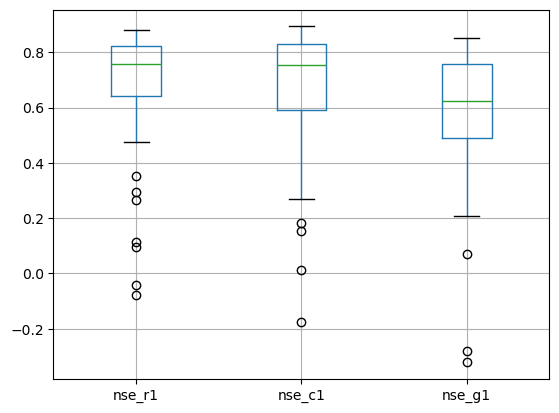

In [270]:
import matplotlib.pyplot as plt

# Plot both columns side by side
data_diff_cal_complete.boxplot(column=["nse_r1","nse_c1", "nse_g1"])

# Show the plot
plt.show()


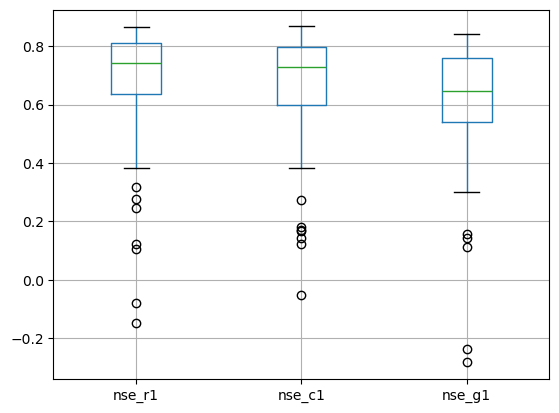

In [271]:
import matplotlib.pyplot as plt

# Plot both columns side by side
data_diff_val_complete.boxplot(column=["nse_r1","nse_c1", "nse_g1"])

# Show the plot
plt.show()


In [273]:
data_diff_val_complete[data_diff_val_complete.nse_rg > 0.1]

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066  0.023129  0.314367  0.835661  0.812532  0.521295         NaN   
BEWA0067  0.035792  0.245765  0.785181  0.749389  0.539416         NaN   
BEWA0106  0.003713  0.452893  0.756730  0.753017  0.303837         NaN   
BEWA0107  0.005232  0.362060  0.740464  0.735232  0.378404         NaN   
BEWA0119  0.015442  0.315928  0.811970  0.796528  0.496042         NaN   
DERP2004  0.000668  0.238994  0.804186  0.803518  0.565192    0.809664   
DERP2018  0.026013  0.199584  0.827208  0.801195  0.627624    0.830941   
DERP2030  0.009313  0.186686  0.829404  0.820091  0.642718    0.846350   
DERP2031  0.010842  0.153735  0.809913  0.799071  0.656178    0.830454   
FR000169  0.005838  0.148200  0.675247  0.669409  0.527047         NaN   
FR000185  0.109532  0.120568  0.278124  0.168592  0.157555         NaN   
FR003259  0.065583  0.102545  0.244878  0.179295  0.142333         NaN   
FR003268 -0.002012  0.148131  0.635046  0.637058  0.486915         NaN   
FR003271  0.010012  0.105562  0.739784  0.729772  0.634221         NaN   
FR003288 -0.008651  0.133637  0.602555  0.611206  0.468919         NaN   
FR003303 -0.095390  0.135821 -0.147776 -0.052386 -0.283597         NaN   
FR003306 -0.221501  0.158607 -0.079837  0.141664 -0.238444         NaN   
LU000001  0.027009  0.399507  0.844877  0.817868  0.445370         NaN   
LU000005  0.032158  0.267825  0.834384  0.802227  0.566559         NaN   
LU000008  0.019100  0.330577  0.697069  0.677969  0.366492         NaN   
LU000010  0.187793  0.160925  0.737526  0.549733  0.576601         NaN   
LU000011  0.030080  0.400886  0.836560  0.806481  0.435674         NaN   
LU000015  0.042207  0.418511  0.819813  0.777607  0.401302         NaN   
LU000019  0.034716  0.202976  0.818594  0.783879  0.615618         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  qmean_c1  qmean_g1  \
basin                                                 ...                       
BEWA0066         NaN         NaN  0.515742  0.552411  ...  1.261123  1.296871   
BEWA0067         NaN         NaN  0.446878  0.538522  ...  1.309893  1.346592   
BEWA0106         NaN         NaN  0.496805  0.550333  ...  1.078410  1.113985   
BEWA0107         NaN         NaN  0.565063  0.537963  ...  1.445895  1.471692   
BEWA0119         NaN         NaN  0.508101  0.546757  ...  1.346217  1.402110   
DERP2004    0.786051   -0.009327  0.500196  0.548457  ...  1.271855  1.334346   
DERP2018    0.832874    0.219726  0.576248  0.586085  ...  1.145444  1.178091   
DERP2030    0.845675    0.424508  0.602096  0.585483  ...  0.851760  0.865999   
DERP2031    0.824199    0.402357  0.589492  0.568512  ...  1.161736  1.195940   
FR000169         NaN         NaN  0.581647  0.549280  ...  0.721960  0.696141   
FR000185         NaN         NaN  0.541713  0.779009  ...  1.179083  1.263860   
FR003259         NaN         NaN  0.570623  0.730528  ...  1.361929  1.455838   
FR003268         NaN         NaN  0.555747  0.512801  ...  0.721974  0.709878   
FR003271         NaN         NaN  0.543269  0.531843  ...  0.689821  0.674548   
FR003288         NaN         NaN  0.557569  0.614540  ...  0.704770  0.684718   
FR003303         NaN         NaN  0.795387  0.842883  ...  0.912464  0.939204   
FR003306         NaN         NaN  0.747143  0.820437  ...  0.684420  0.675099   
LU000001         NaN         NaN  0.546850  0.529320  ...  1.079400  1.078056   
LU000005         NaN         NaN  0.513152  0.552418  ...  1.054434  1.055243   
LU000008         NaN         NaN  0.500726  0.534522  ...  1.030720  1.029825   
LU000010         NaN         NaN  0.618760  0.664178  ...  0.821969  0.833032   
LU000011         NaN         NaN  0.562102  0.572477  ...  0.855141  0.854624   
LU000015         NaN         NaN  0.516853  0.551345  ...  0.941913  0.941315   
LU000019         NaN         NaN  0.492709  0.555690  ...  1.0039

In [281]:
data_diff_val_complete[data_diff_val_complete.nse_rg < 0.1]

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
DEBU1956  0.003271  0.030907  0.854730  0.851460  0.823824    0.870937   
DEBU1957  0.000611  0.033108  0.850172  0.849561  0.817064    0.798962   
DEBU1959  0.002880  0.026528  0.861166  0.858286  0.834638    0.888605   
DERP2005  0.019841 -0.016330  0.781783  0.761943  0.798113    0.807484   
DERP2006  0.044165 -0.006416  0.786407  0.742242  0.792823    0.820736   
...            ...       ...       ...       ...       ...         ...   
LU000013  0.011938  0.026695  0.594246  0.582308  0.567552         NaN   
LU000014 -0.027549  0.085389  0.711638  0.739188  0.626250         NaN   
LU000016 -0.035292  0.009937  0.636273  0.671565  0.626335         NaN   
LU000017  0.023833  0.080182  0.860150  0.836317  0.779968         NaN   
LU000018  0.246717  0.062756  0.630852  0.384135  0.568096         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...  qmean_c1  qmean_g1  \
basin                                                 ...                       
DEBU1956    0.867905    0.809905  0.602355  0.618060  ...  1.102476  1.149756   
DEBU1957    0.814693    0.707029  0.606413  0.638777  ...  0.867868  0.880918   
DEBU1959    0.886709    0.824330  0.609882  0.621911  ...  1.005241  1.039782   
DERP2005    0.756795    0.770073  0.445587  0.545509  ...  1.075030  1.132850   
DERP2006    0.724975    0.788968  0.439622  0.543267  ...  1.303942  1.378103   
...              ...         ...       ...       ...  ...       ...       ...   
LU000013         NaN         NaN  0.562200  0.505519  ...  0.707000  0.712532   
LU000014         NaN         NaN  0.591075  0.577087  ...  0.719584  0.727481   
LU000016         NaN         NaN  0.564940  0.522122  ...  0.699187  0.705270   
LU000017         NaN         NaN  0.572433  0.591535  ...  0.833624  0.837508   
LU000018         NaN         NaN  0.549133  0.653295  ...  0.737937  0.750475   

          slope_obs  slope_r1  slope_c1  slope_g1     hfd_obs      hfd_r1  \
basin                                                                       
DEBU1956   2.505087  2.672289  2.522834  2.487324  132.038462  132.000000   
DEBU1957   2.049171  2.438172  2.195754  2.389201  134.115385  135.307692   
DEBU1959   2.526058  2.586140  2.434513  2.365603  132.230769  132.461538   
DERP2005   3.817129  3.002915  2.727618  3.260348  120.192308  130.769231   
DERP2006   4.017057  2.991750  2.583743  3.186571  122.230769  130.769231   
...             ...       ...       ...       ...         ...         ...   
LU000013   2.274642  3.268026  2.900580  2.936176  133.538462  124.846154   
LU000014   1.750158  2.496264  1.989471  2.921245  134.307692  129.384615   
LU000016   2.005883  3.044009  2.635860  2.918615  133.615385  126.000000   
LU000017   2.459555  2.591746  2.054877  1.710805  127.307692  129.461538   
LU000018   2.305895  1.958625  1.279312  2.965307  127.384615  134.769231   

              hfd_c1      hfd_g1  
basin                             
DEBU1956  132.769231  135.384615  
DEBU1957  136.615385  139.807692  
DEBU1959  133.346154  137.423077  
DERP2005  132.192308  131.769231  
DERP2006  134.538462  131.846154  
...              ...         ...  
LU000013  129.076923  128.615385  
LU000014  138.000000  128.692308  
LU000016  131.076923  128.769231  
LU000017  135.538462  144.153846  
LU000018  158.230769  128.461538  

[74 rows x 24 columns]

<Axes: >

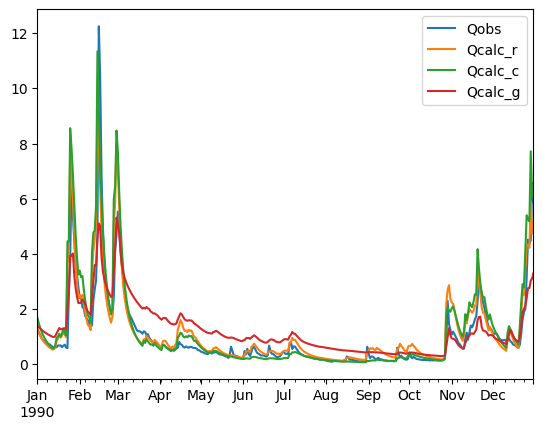

In [275]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DERP2031"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["1990"].plot()

<Axes: >

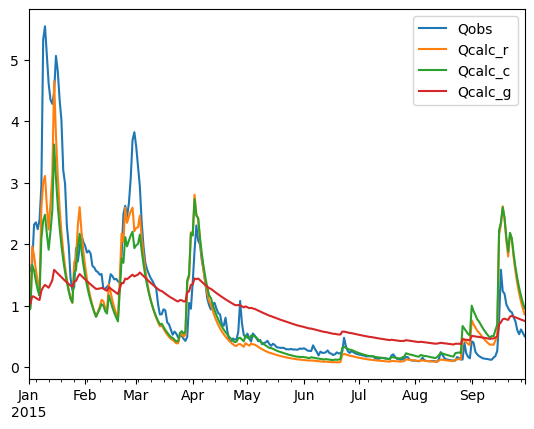

In [276]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="LU000015"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2015"].plot()

<Axes: >

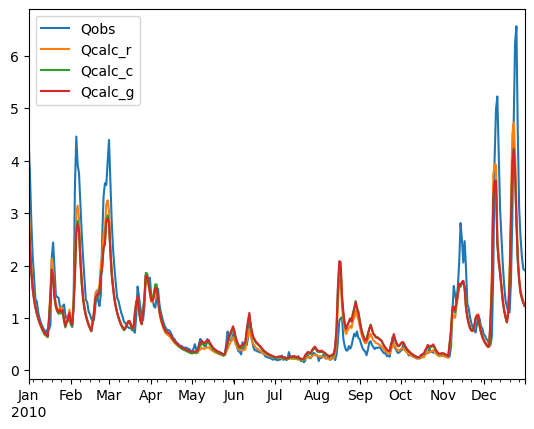

In [277]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DEBU1959"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2010"].plot()

<Axes: >

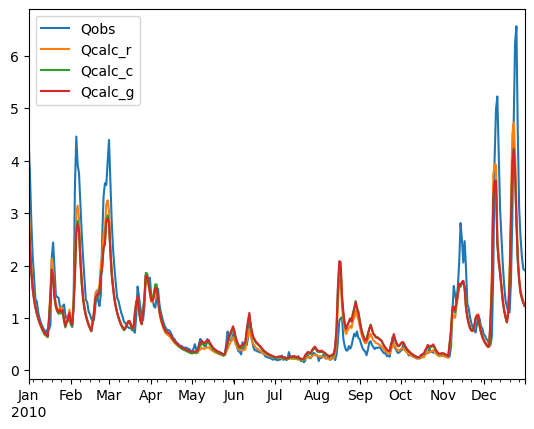

In [285]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DEBU1959"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2010"].plot()

<Axes: >

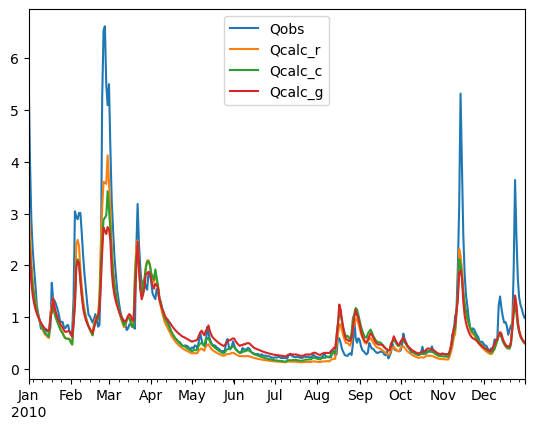

In [286]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="LU000017"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2010"].plot()

In [150]:
nse_results_cal_g_1_100.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_4876\759752956.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_cal_g_1_100.corr()


nse  q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  \
nse            1.000000    0.178645    -0.025416 -0.196824 -0.207007   
q_mean_obs     0.178645    1.000000     0.930066  0.018471 -0.065075   
q_mean_calc   -0.025416    0.930066     1.000000  0.064476  0.036471   
bfi_obs       -0.196824    0.018471     0.064476  1.000000  0.417087   
bfi_sim       -0.207007   -0.065075     0.036471  0.417087  1.000000   
nse_value_bfi  0.934442    0.267407     0.146160 -0.322262 -0.314515   

               nse_value_bfi  
nse                 0.934442  
q_mean_obs          0.267407  
q_mean_calc         0.146160  
bfi_obs            -0.322262  
bfi_sim            -0.314515  
nse_value_bfi       1.000000

In [47]:
nse_results_cal_r_1_100

gauge_name     basin        nse  q_mean_obs  q_mean_calc   bfi_obs  \
0          Reuland  BEWA0066   0.826402    1.224479     1.127816  0.511429   
1       Schoenberg  BEWA0067   0.776418    1.397246     1.226372  0.443161   
2       Martelange  BEWA0087 -18.558555    0.192824     1.176069  0.708779   
3          Reuland  BEWA0106   0.738859    0.986279     0.875000  0.473400   
4    Lommersweiler  BEWA0107   0.723577    1.134366     1.211335  0.565604   
..             ...       ...        ...         ...          ...       ...   
107       Michelau  LU000015   0.753774    1.020046     0.986005  0.517760   
108    Pfaffenthal  LU000016   0.688915    0.791896     0.717942  0.563590   
109        Rosport  LU000017   0.852524    0.925885     0.867238  0.574924   
110     Schoenfels  LU000018   0.609091    0.868880     0.768449  0.543259   
111        Vianden  LU000019   0.805395    1.141633     1.047428  0.497731   

      bfi_sim  nse_value_bfi  
0    0.557320       0.823303  
1    0.540013       0.765821  
2    0.525158            NaN  
3    0.560178            NaN  
4    0.553497            NaN  
..        ...            ...  
107  0.555506       0.778332  
108  0.562215       0.497113  
109  0.598715       0.871139  
110  0.649665       0.410972  
111  0.564138       0.838583  

[112 rows x 8 columns]

In [44]:
nse_results_cal_r_1_100[nse_results_cal_r_1_100.nse < 0.5]

gauge_name     basin        nse  \
2                                          Martelange  BEWA0087 -18.558555   
18                                            Contwig  DERP2013  -0.021018   
43                                           A6232010  FR000144  -0.338022   
53                                           A9021050  FR000185   0.380050   
64                               La Meurthe Ã  Fraize  FR003250   0.201436   
71  L'ArentÃƒÂ¨le ÃƒÂ  Saint-Gorgon et ÃƒÂ  Sainte...  FR003259   0.311947   
82                                 Le Woigot Ã  Briey  FR003280   0.393840   
85                         Le Canner Ã  KÅ“nigsmacker  FR003288   0.448982   
93                             L'Horn Ã  Bousseviller  FR003303  -0.557843   
94                            La Bisten Ã  Creutzwald  FR003306  -0.472334   

    q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  nse_value_bfi  
2     0.192824     1.176069  0.708779  0.525158            NaN  
18    0.645713     0.741011  0.814322  0.787752      -1.207482  
43    1.326263     1.084023  0.681845  0.768781            NaN  
53    0.758821     1.041334  0.558059  0.747527            NaN  
64    2.136579     1.424822  0.683473  0.540899            NaN  
71    0.817462     1.140845  0.587749  0.710226            NaN  
82    1.276007     0.807908  0.687017  0.523113            NaN  
85    0.485706     0.603660  0.586159  0.624539            NaN  
93    0.580874     0.804457  0.794509  0.795206      -2.193359  
94    0.530436     0.605687  0.749280  0.769845            NaN

In [60]:
nse_results_cal_c_1_100[nse_results_cal_c_1_100.nse < 0.5]

gauge_name     basin        nse  \
2                                           Martelange  BEWA0087 -19.771455   
18                                             Contwig  DERP2013   0.210063   
21                                            Saarburg  DERP2016   0.474689   
29                                        Eisenschmitt  DERP2028   0.357703   
30                                               Dreis  DERP2029   0.456847   
38                                            A4333010  FR000132   0.391089   
43                                            A6232010  FR000144  -0.176320   
50                                            A8122000  FR000174   0.485377   
53                                            A9021050  FR000185   0.204661   
60                                 L'AviÃ¨re Ã  Frizon  FR003239   0.492893   
64                                La Meurthe Ã  Fraize  FR003250   0.263847   
71   L'ArentÃƒÂ¨le ÃƒÂ  Saint-Gorgon et ÃƒÂ  Sainte...  FR003259   0.170757   
82                                  Le Woigot Ã  Briey  FR003280   0.448235   
85                          Le Canner Ã  KÅ“nigsmacker  FR003288   0.406625   
93                              L'Horn Ã  Bousseviller  FR003303  -0.512720   
94                             La Bisten Ã  Creutzwald  FR003306  -0.209420   
103                                          Hunnebuer  LU000010   0.445793   
105                                            Livange  LU000013   0.447508   
110                                         Schoenfels  LU000018   0.270090   

     q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  nse_value_bfi  
2      0.192824     1.220369  0.708779  0.548988            NaN  
18     0.645713     0.754599  0.814322  0.886095      -0.839802  
21     0.784706     0.720569  0.666009  0.559718      -0.352525  
29     0.932864     0.820791  0.600504  0.878579       0.025848  
30     0.701361     0.746966  0.578087  0.853476      -0.358057  
38     1.713987     2.096862  0.661763  0.541628            NaN  
43     1.326263     1.129714  0.681845  0.783728            NaN  
50     0.498502     0.613734  0.412715  0.551239            NaN  
53     0.758821     1.083615  0.558059  0.821912            NaN  
60     1.036742     1.056526  0.581204  0.629243            NaN  
64     2.136579     1.501598  0.683473  0.561130            NaN  
71     0.817462     1.188638  0.587749  0.776349            NaN  
82     1.276007     0.818309  0.687017  0.555968            NaN  
85     0.485706     0.592796  0.586159  0.650985            NaN  
93     0.580874     0.821296  0.794509  0.893301      -2.774296  
94     0.530436     0.597125  0.749280  0.829772            NaN  
103    0.900503     0.873301  0.617642  0.836370      -0.187159  
105    0.585681     0.726026  0.559076  0.557087      -0.004558  
110    0.868880     0.779715  0.543259  0.861756      -0.605806

In [30]:
len(nse_results_cal_r_1_100_8801[nse_results_cal_r_1_100_8801.nse < 0.5])

18

In [29]:
len(nse_results_cal_c_1_100_8801[nse_results_cal_c_1_100_8801.nse < 0.5])

19

In [28]:
len(nse_results_cal_g_1_100_8801[nse_results_cal_g_1_100_8801.nse < 0.5])

18

In [187]:
list_cal = ['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 #'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']


In [32]:
nse_results_cal_r_1_100_8801.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.502622
DERP2017    0.822877
DERP2011    0.746176
DERP2013   -0.160325
DERP2007    0.801353
DERP2024    0.837639
FR003253    0.782549
FR003283    0.670203
FR003301    0.738467
DERP2003    0.820437
FR003265    0.861250
FR003272    0.845771
DEBU1958    0.854827
Name: nse, dtype: float64

In [33]:
nse_results_cal_c_1_100_8801.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.276440
DERP2017    0.856529
DERP2011    0.724096
DERP2013    0.047715
DERP2007    0.822683
DERP2024    0.837701
FR003253    0.768599
FR003283    0.710999
FR003301    0.758954
DERP2003    0.862119
FR003265    0.887314
FR003272    0.858052
DEBU1958    0.876081
Name: nse, dtype: float64

In [34]:
nse_results_cal_g_1_100_8801.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.452300
DERP2017    0.723297
DERP2011    0.771077
DERP2013   -0.055262
DERP2007    0.839439
DERP2024    0.852926
FR003253    0.792867
FR003283    0.697601
FR003301    0.793062
DERP2003    0.758729
FR003265    0.885336
FR003272    0.867809
DEBU1958    0.875862
Name: nse, dtype: float64

In [152]:
nse_results_cal_r_1_100.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.686314
DERP2017    0.819601
DERP2011    0.760643
DERP2013   -0.021018
DERP2007    0.784394
DERP2024    0.822409
FR003253    0.757550
FR003283    0.760648
FR003301    0.803412
DERP2003    0.850318
FR003265    0.875261
FR003272    0.844946
DEBU1958    0.890779
Name: nse, dtype: float64

In [153]:
nse_results_cal_c_1_100.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.554843
DERP2017    0.805105
DERP2011    0.696703
DERP2013    0.210063
DERP2007    0.769149
DERP2024    0.804157
FR003253    0.750106
FR003283    0.784851
FR003301    0.782860
DERP2003    0.850792
FR003265    0.874653
FR003272    0.849534
DEBU1958    0.894567
Name: nse, dtype: float64

In [154]:
nse_results_cal_g_1_100.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.648828
DERP2017    0.679076
DERP2011    0.721039
DERP2013    0.091943
DERP2007    0.779722
DERP2024    0.789743
FR003253    0.781084
FR003283    0.787490
FR003301    0.779726
DERP2003    0.721540
FR003265    0.865584
FR003272    0.844855
DEBU1958    0.884755
Name: nse, dtype: float64

In [155]:
data_diff_cal14 = pd.DataFrame(data=nse_results_cal_r_1_100.nse - nse_results_cal_c_1_100.nse)
data_diff_cal14["nse_rg"] = nse_results_cal_r_1_100.nse - nse_results_cal_g_1_100.nse

data_diff_cal14.index = nse_results_cal_c_1_100.basin

data_diff_cal14 = data_diff_cal14.loc[data_diff_cal14.index.isin(list_cal)]

data_diff_cal14["nse_r1"] = nse_results_cal_r_1_100.set_index("basin", inplace = False).nse
data_diff_cal14["nse_c1"] = nse_results_cal_c_1_100.set_index("basin", inplace = False).nse
data_diff_cal14["nse_g1"] = nse_results_cal_g_1_100.set_index("basin", inplace = False).nse

data_diff_cal14["nse_bfi_r1"] = nse_results_cal_r_1_100.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal14["nse_bfi_c1"] = nse_results_cal_c_1_100.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal14["nse_bfi_g1"] = nse_results_cal_g_1_100.set_index("basin", inplace = False).nse_value_bfi

data_diff_cal14["bfi_obs"] = nse_results_cal_r_1_100.set_index("basin", inplace = False).bfi_obs
data_diff_cal14["bfi_r1"] = nse_results_cal_r_1_100.set_index("basin", inplace = False).bfi_sim
data_diff_cal14["bfi_c1"] = nse_results_cal_c_1_100.set_index("basin", inplace = False).bfi_sim
data_diff_cal14["bfi_g1"] = nse_results_cal_g_1_100.set_index("basin", inplace = False).bfi_sim

data_diff_cal14 = data_diff_cal14[data_diff_cal14.nse_r1 > -10.0]
data_diff_cal14

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
DEBU1958 -0.003788  0.006025  0.890779  0.894567  0.884755    0.908704   
DERP2003 -0.000473  0.128778  0.850318  0.850792  0.721540    0.860745   
DERP2007  0.015245  0.004672  0.784394  0.769149  0.779722    0.862921   
DERP2011  0.063940  0.039605  0.760643  0.696703  0.721039    0.650019   
DERP2013 -0.231081 -0.112961 -0.021018  0.210063  0.091943   -1.207482   
DERP2017  0.014496  0.140524  0.819601  0.805105  0.679076    0.768986   
DERP2024  0.018252  0.032666  0.822409  0.804157  0.789743    0.765945   
FR000184  0.131470  0.037486  0.686314  0.554843  0.648828         NaN   
FR003253  0.007444 -0.023534  0.757550  0.750106  0.781084         NaN   
FR003265  0.000608  0.009676  0.875261  0.874653  0.865584    0.908044   
FR003272 -0.004588  0.000091  0.844946  0.849534  0.844855         NaN   
FR003283 -0.024203 -0.026842  0.760648  0.784851  0.787490    0.758087   
FR003301  0.020552  0.023686  0.803412  0.782860  0.779726         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1    bfi_c1    bfi_g1  
basin                                                                     
DEBU1958    0.918849    0.914127  0.623734  0.632946  0.665122  0.677066  
DERP2003    0.837850    0.575626  0.574428  0.592814  0.625302  0.742718  
DERP2007    0.852410    0.822057  0.498372  0.597256  0.623993  0.581848  
DERP2011    0.415648    0.568848  0.557702  0.632648  0.700698  0.638307  
DERP2013   -0.839802   -0.989599  0.814322  0.787752  0.886095  0.842010  
DERP2017    0.671392    0.725719  0.625278  0.610490  0.563099  0.787467  
DERP2024    0.754385    0.651696  0.612685  0.628038  0.658039  0.635482  
FR000184         NaN         NaN  0.769605  0.783596  0.877833  0.834384  
FR003253         NaN         NaN  0.668338  0.687341  0.654451  0.729863  
FR003265    0.915401    0.908909  0.614570  0.638989  0.664384  0.671938  
FR003272         NaN         NaN  0.615765  0.628661  0.657479  0.659665  
FR003283    0.697565    0.790077  0.551651  0.532216  0.563813  0.585231  
FR003301         NaN         NaN  0.546297  0.619808  0.659358  0.647296

In [35]:
data_diff_cal14_8801 = pd.DataFrame(data=nse_results_cal_r_1_100_8801.nse - nse_results_cal_c_1_100_8801.nse)
data_diff_cal14_8801["nse_rg"] = nse_results_cal_r_1_100_8801.nse - nse_results_cal_g_1_100_8801.nse

data_diff_cal14_8801.index = nse_results_cal_c_1_100_8801.basin

data_diff_cal14_8801 = data_diff_cal14_8801.loc[data_diff_cal14_8801.index.isin(list_cal)]

data_diff_cal14_8801["nse_r1"] = nse_results_cal_r_1_100_8801.set_index("basin", inplace = False).nse
data_diff_cal14_8801["nse_c1"] = nse_results_cal_c_1_100_8801.set_index("basin", inplace = False).nse
data_diff_cal14_8801["nse_g1"] = nse_results_cal_g_1_100_8801.set_index("basin", inplace = False).nse

data_diff_cal14_8801["nse_bfi_r1"] = nse_results_cal_r_1_100_8801.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal14_8801["nse_bfi_c1"] = nse_results_cal_c_1_100_8801.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal14_8801["nse_bfi_g1"] = nse_results_cal_g_1_100_8801.set_index("basin", inplace = False).nse_value_bfi

data_diff_cal14_8801["bfi_obs"] = nse_results_cal_r_1_100_8801.set_index("basin", inplace = False).bfi_obs
data_diff_cal14_8801["bfi_r1"] = nse_results_cal_r_1_100_8801.set_index("basin", inplace = False).bfi_sim
data_diff_cal14_8801["bfi_c1"] = nse_results_cal_c_1_100_8801.set_index("basin", inplace = False).bfi_sim
data_diff_cal14_8801["bfi_g1"] = nse_results_cal_g_1_100_8801.set_index("basin", inplace = False).bfi_sim

data_diff_cal14_8801 = data_diff_cal14_8801[data_diff_cal14_8801.nse_r1 > -10.0]
data_diff_cal14_8801

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
DEBU1958 -0.021253 -0.021034  0.854827  0.876081  0.875862    0.843967   
DERP2003 -0.041682  0.061708  0.820437  0.862119  0.758729    0.850603   
DERP2007 -0.021330 -0.038086  0.801353  0.822683  0.839439    0.853549   
DERP2011  0.022080 -0.024901  0.746176  0.724096  0.771077    0.620781   
DERP2013 -0.208040 -0.105063 -0.160325  0.047715 -0.055262   -1.215067   
DERP2017 -0.033653  0.099580  0.822877  0.856529  0.723297    0.845489   
DERP2024 -0.000062 -0.015288  0.837639  0.837701  0.852926    0.855845   
FR000184  0.226182  0.050323  0.502622  0.276440  0.452300         NaN   
FR003253  0.013950 -0.010318  0.782549  0.768599  0.792867         NaN   
FR003265 -0.026064 -0.024086  0.861250  0.887314  0.885336    0.912331   
FR003272 -0.012281 -0.022039  0.845771  0.858052  0.867809    0.851992   
FR003283 -0.040796 -0.027398  0.670203  0.710999  0.697601         NaN   
FR003301 -0.020486 -0.054595  0.738467  0.758954  0.793062         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1    bfi_c1    bfi_g1  
basin                                                                     
DEBU1958    0.858907    0.862167  0.593301  0.648339  0.645560  0.644259  
DERP2003    0.862953    0.673551  0.547346  0.610579  0.613463  0.712594  
DERP2007    0.848919    0.869172  0.504273  0.610937  0.614815  0.563860  
DERP2011    0.420902    0.680218  0.567073  0.655450  0.696536  0.618635  
DERP2013   -0.774167   -1.077744  0.816321  0.769157  0.897096  0.831039  
DERP2017    0.818644    0.777318  0.577916  0.619606  0.545205  0.761122  
DERP2024    0.801237    0.824133  0.597002  0.645560  0.655396  0.620441  
FR000184         NaN         NaN  0.762358  0.763158  0.891270  0.822930  
FR003253         NaN         NaN  0.617149  0.652446  0.625107  0.691933  
FR003265    0.943173    0.929548  0.591212  0.645132  0.645734  0.641617  
FR003272    0.851141    0.870569  0.584542  0.644930  0.643025  0.633194  
FR003283         NaN         NaN  0.510745  0.586635  0.544224  0.546792  
FR003301         NaN         NaN  0.532311  0.665454  0.662611  0.634857

In [157]:
data_diff_cal14.corr()["bfi_obs"].iloc[-4:]

bfi_obs    1.000000
bfi_r1     0.908536
bfi_c1     0.815948
bfi_g1     0.859010
Name: bfi_obs, dtype: float64

In [36]:
data_diff_cal14_8801.corr()["bfi_obs"].iloc[-4:]

bfi_obs    1.000000
bfi_r1     0.934126
bfi_c1     0.895255
bfi_g1     0.841156
Name: bfi_obs, dtype: float64

(0.2, 1.0)

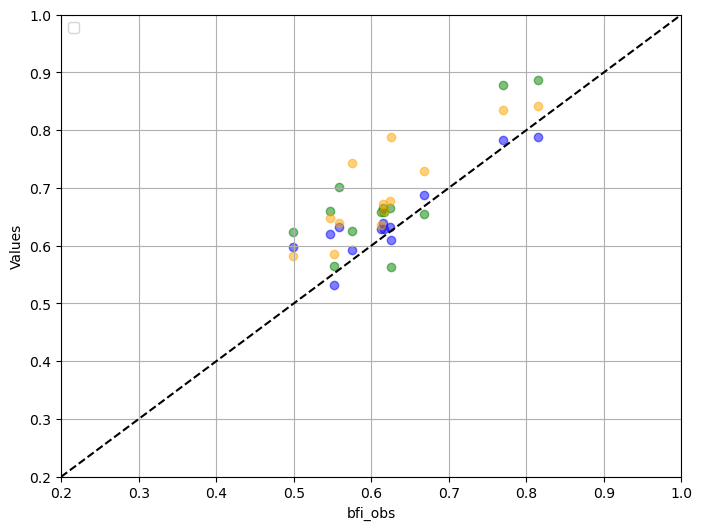

In [158]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data_diff_cal14["bfi_obs"], data_diff_cal14["bfi_r1"], color='blue', alpha=0.5)
plt.scatter(data_diff_cal14["bfi_obs"], data_diff_cal14["bfi_c1"], color='green', alpha=0.5)
plt.scatter(data_diff_cal14["bfi_obs"], data_diff_cal14["bfi_g1"], color='orange',alpha=0.5)


# Labels and title
plt.xlabel('bfi_obs')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='x = y')

plt.xlim([0.2, 1])
plt.ylim([0.2, 1])


(0.2, 1.0)

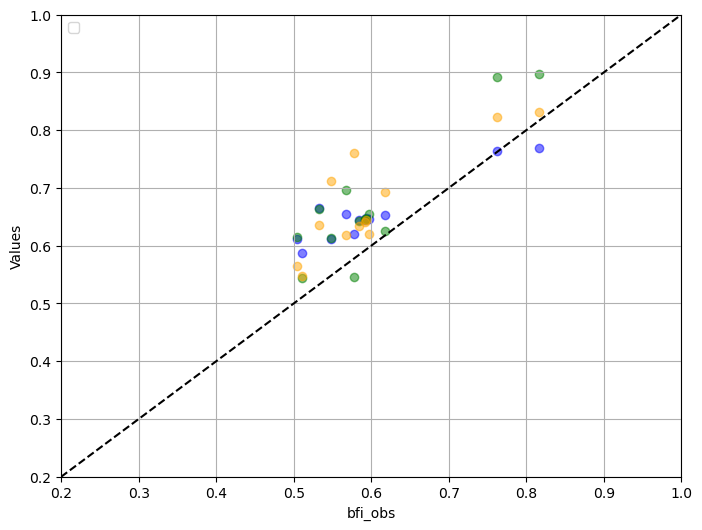

In [37]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data_diff_cal14_8801["bfi_obs"], data_diff_cal14_8801["bfi_r1"], color='blue', alpha=0.5)
plt.scatter(data_diff_cal14_8801["bfi_obs"], data_diff_cal14_8801["bfi_c1"], color='green', alpha=0.5)
plt.scatter(data_diff_cal14_8801["bfi_obs"], data_diff_cal14_8801["bfi_g1"], color='orange',alpha=0.5)


# Labels and title
plt.xlabel('bfi_obs')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='x = y')

plt.xlim([0.2, 1])
plt.ylim([0.2, 1])


In [159]:
data_diff_cal = pd.DataFrame(data=nse_results_cal_r_1_100.nse - nse_results_cal_c_1_100.nse)
data_diff_cal["nse_rg"] = nse_results_cal_r_1_100.nse - nse_results_cal_g_1_100.nse

data_diff_cal.index = nse_results_cal_c_1_100.basin

data_diff_cal = data_diff_cal.loc[~data_diff_cal.index.isin(list_cal)]

data_diff_cal["nse_r1"] = nse_results_cal_r_1_100.set_index("basin", inplace = False).nse
data_diff_cal["nse_c1"] = nse_results_cal_c_1_100.set_index("basin", inplace = False).nse
data_diff_cal["nse_g1"] = nse_results_cal_g_1_100.set_index("basin", inplace = False).nse

data_diff_cal["nse_bfi_r1"] = nse_results_cal_r_1_100.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal["nse_bfi_c1"] = nse_results_cal_c_1_100.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal["nse_bfi_g1"] = nse_results_cal_g_1_100.set_index("basin", inplace = False).nse_value_bfi

data_diff_cal["bfi_obs"] = nse_results_cal_r_1_100.set_index("basin", inplace = False).bfi_obs
data_diff_cal["bfi_r1"] = nse_results_cal_r_1_100.set_index("basin", inplace = False).bfi_sim
data_diff_cal["bfi_c1"] = nse_results_cal_c_1_100.set_index("basin", inplace = False).bfi_sim
data_diff_cal["bfi_g1"] = nse_results_cal_g_1_100.set_index("basin", inplace = False).bfi_sim

data_diff_cal = data_diff_cal[data_diff_cal.nse_r1 > -10.0]
data_diff_cal

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066 -0.034058  0.310443  0.826402  0.860460  0.515958    0.823303   
BEWA0067 -0.019116  0.267704  0.776418  0.795534  0.508714    0.765821   
BEWA0106 -0.047748  0.465526  0.738859  0.786607  0.273333         NaN   
BEWA0107 -0.038995  0.380173  0.723577  0.762572  0.343404         NaN   
BEWA0119 -0.027736  0.313667  0.811971  0.839707  0.498304         NaN   
...            ...       ...       ...       ...       ...         ...   
LU000015 -0.078411  0.401203  0.753774  0.832185  0.352571    0.778332   
LU000016  0.114346  0.128390  0.688915  0.574570  0.560526    0.497113   
LU000017  0.003912  0.101954  0.852524  0.848612  0.750569    0.871139   
LU000018  0.339001  0.092953  0.609091  0.270090  0.516138    0.410972   
LU000019 -0.020063  0.231212  0.805395  0.825458  0.574183    0.838583   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1    bfi_c1    bfi_g1  
basin                                                                     
BEWA0066    0.883596    0.138918  0.511429  0.557320  0.572222  0.803718  
BEWA0067    0.795083    0.047242  0.443161  0.540013  0.558439  0.760583  
BEWA0106         NaN         NaN  0.473400  0.560178  0.580418  0.846723  
BEWA0107         NaN         NaN  0.565604  0.553497  0.564248  0.832013  
BEWA0119         NaN         NaN  0.503286  0.554247  0.568261  0.793015  
...              ...         ...       ...       ...       ...       ...  
LU000015    0.853968   -0.200624  0.517760  0.555506  0.572764  0.846011  
LU000016    0.071846   -0.166926  0.563590  0.562215  0.585995  0.552001  
LU000017    0.857222    0.680423  0.574924  0.598715  0.631372  0.727089  
LU000018   -0.605806   -0.364504  0.543259  0.649665  0.861756  0.548551  
LU000019    0.858781    0.229273  0.497731  0.564138  0.577293  0.773988  

[98 rows x 12 columns]

In [38]:
data_diff_cal_8801 = pd.DataFrame(data=nse_results_cal_r_1_100_8801.nse - nse_results_cal_c_1_100_8801.nse)
data_diff_cal_8801["nse_rg"] = nse_results_cal_r_1_100_8801.nse - nse_results_cal_g_1_100_8801.nse

data_diff_cal_8801.index = nse_results_cal_c_1_100_8801.basin

data_diff_cal_8801 = data_diff_cal_8801.loc[~data_diff_cal_8801.index.isin(list_cal)]

data_diff_cal_8801["nse_r1"] = nse_results_cal_r_1_100_8801.set_index("basin", inplace = False).nse
data_diff_cal_8801["nse_c1"] = nse_results_cal_c_1_100_8801.set_index("basin", inplace = False).nse
data_diff_cal_8801["nse_g1"] = nse_results_cal_g_1_100_8801.set_index("basin", inplace = False).nse

data_diff_cal_8801["nse_bfi_r1"] = nse_results_cal_r_1_100_8801.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal_8801["nse_bfi_c1"] = nse_results_cal_c_1_100_8801.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal_8801["nse_bfi_g1"] = nse_results_cal_g_1_100_8801.set_index("basin", inplace = False).nse_value_bfi

data_diff_cal_8801["bfi_obs"] = nse_results_cal_r_1_100_8801.set_index("basin", inplace = False).bfi_obs
data_diff_cal_8801["bfi_r1"] = nse_results_cal_r_1_100_8801.set_index("basin", inplace = False).bfi_sim
data_diff_cal_8801["bfi_c1"] = nse_results_cal_c_1_100_8801.set_index("basin", inplace = False).bfi_sim
data_diff_cal_8801["bfi_g1"] = nse_results_cal_g_1_100_8801.set_index("basin", inplace = False).bfi_sim

data_diff_cal_8801 = data_diff_cal_8801[data_diff_cal_8801.nse_r1 > -10.0]
data_diff_cal_8801

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066 -0.057059  0.236293  0.809240  0.866299  0.572948         NaN   
BEWA0067 -0.065123  0.201153  0.751087  0.816209  0.549934         NaN   
BEWA0106 -0.104412  0.277152  0.688839  0.793252  0.411687         NaN   
BEWA0107 -0.031759  0.214863  0.760324  0.792083  0.545462         NaN   
BEWA0119 -0.046050  0.222877  0.796337  0.842387  0.573461         NaN   
...            ...       ...       ...       ...       ...         ...   
FR003300 -0.018579 -0.029949  0.489243  0.507821  0.519191    0.137953   
FR003302 -0.026773 -0.048474  0.728297  0.755070  0.776772         NaN   
FR003303 -0.140909 -0.063115 -0.275752 -0.134843 -0.212636         NaN   
FR003306 -0.215592 -0.083247 -0.781280 -0.565688 -0.698032         NaN   
FR003307 -0.081744 -0.048830  0.712395  0.794139  0.761225    0.666715   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1    bfi_c1    bfi_g1  
basin                                                                     
BEWA0066         NaN         NaN  0.524659  0.588851  0.580572  0.782890  
BEWA0067         NaN         NaN  0.469727  0.584139  0.575371  0.733336  
BEWA0106         NaN         NaN  0.506445  0.575494  0.576842  0.821770  
BEWA0107         NaN         NaN  0.557155  0.558624  0.547818  0.771633  
BEWA0119         NaN         NaN  0.513078  0.572439  0.567383  0.753411  
...              ...         ...       ...       ...       ...       ...  
FR003300    0.205980    0.203238  0.526066  0.686214  0.658084  0.668480  
FR003302         NaN         NaN  0.525576  0.647463  0.641789  0.611331  
FR003303         NaN         NaN  0.804400  0.757016  0.886239  0.816397  
FR003306         NaN         NaN  0.764163  0.767978  0.861213  0.822372  
FR003307    0.781544    0.734124  0.498878  0.607043  0.595187  0.529403  

[82 rows x 12 columns]

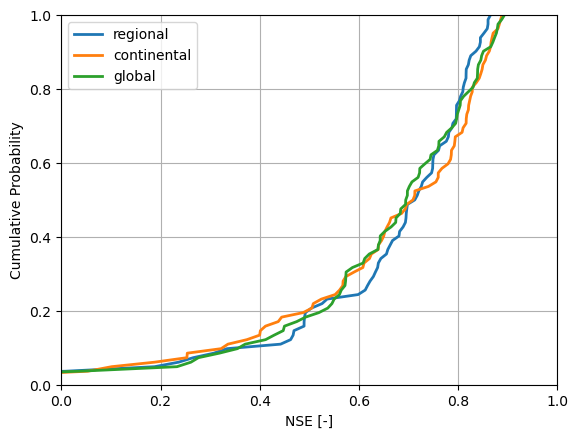

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_8801["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_8801["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal_8801["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


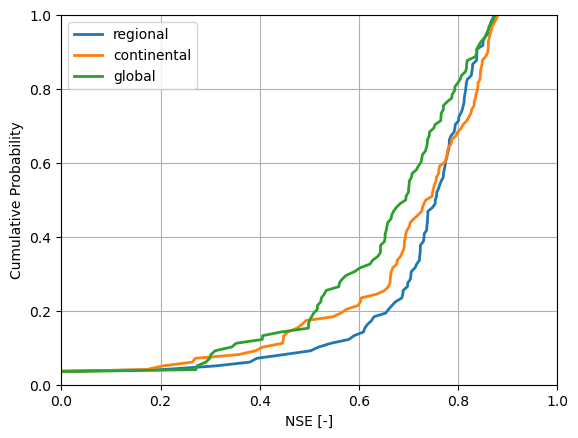

In [160]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


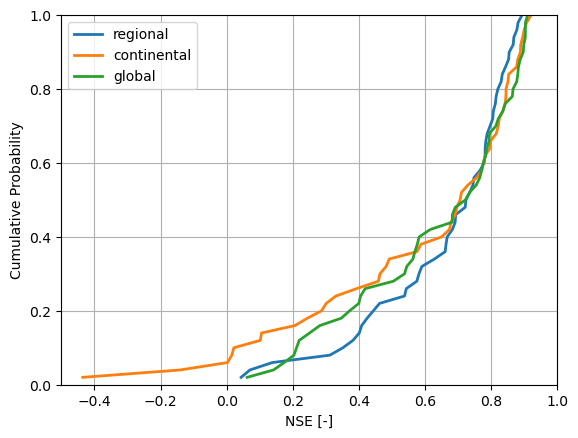

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_8801["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_8801["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal_8801["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.5, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


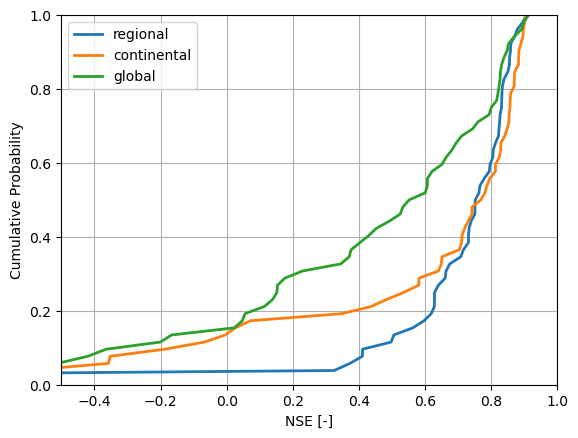

In [163]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.5, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


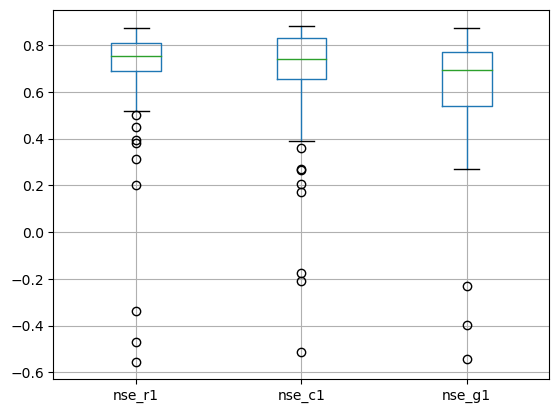

In [165]:
import matplotlib.pyplot as plt

# Plot both columns side by side
data_diff_cal.boxplot(column=["nse_r1","nse_c1", "nse_g1"])

# Show the plot
plt.show()


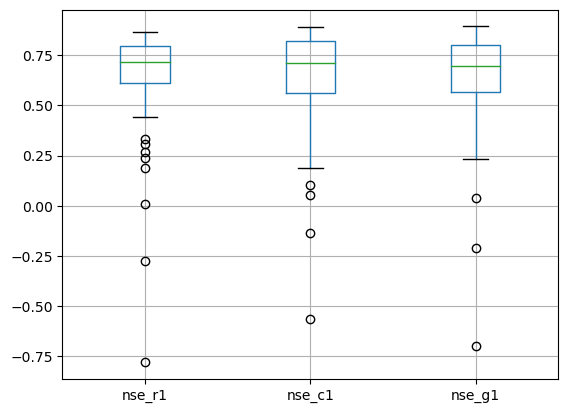

In [41]:
import matplotlib.pyplot as plt

# Plot both columns side by side
data_diff_cal_8801.boxplot(column=["nse_r1","nse_c1", "nse_g1"])

# Show the plot
plt.show()


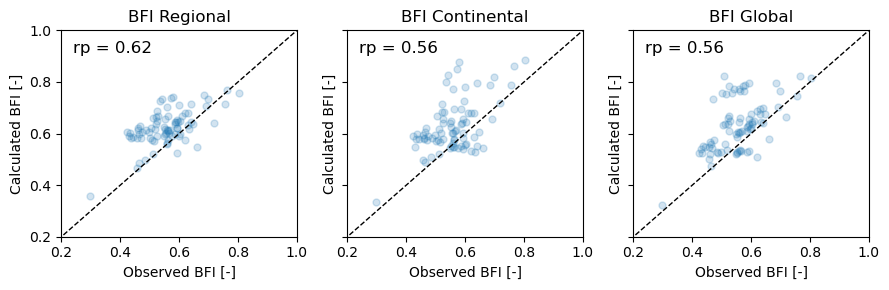

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['bfi_r1', 'bfi_c1', 'bfi_g1']
titles = ['BFI Regional', 'BFI Continental', 'BFI Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_cal_8801["bfi_obs"]
    y = data_diff_cal_8801[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(0.2, 1.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_cal_8801[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

In [51]:
data_diff_cal_8801[data_diff_cal_8801.nse_r1 > 0.7].iloc[:, 0:-3]

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066 -0.057059  0.236293  0.809240  0.866299  0.572948         NaN   
BEWA0067 -0.065123  0.201153  0.751087  0.816209  0.549934         NaN   
BEWA0107 -0.031759  0.214863  0.760324  0.792083  0.545462         NaN   
BEWA0119 -0.046050  0.222877  0.796337  0.842387  0.573461         NaN   
DEBU1956 -0.028416 -0.025140  0.851846  0.880262  0.876986    0.866289   
DEBU1957 -0.005297 -0.029821  0.815774  0.821071  0.845595    0.783684   
DEBU1959 -0.022831 -0.020076  0.860160  0.882991  0.880236    0.892823   
DERP2004 -0.069543  0.155286  0.775984  0.845527  0.620697    0.721038   
DERP2005 -0.059125 -0.052354  0.748735  0.807860  0.801089    0.682476   
DERP2006 -0.023771 -0.032237  0.762648  0.786419  0.794885    0.734603   
DERP2008 -0.030508 -0.035260  0.736670  0.767178  0.771930    0.690872   
DERP2010  0.036439  0.004061  0.749131  0.712692  0.745070    0.723452   
DERP2016  0.174871 -0.012345  0.748440  0.573569  0.760785    0.796325   
DERP2018 -0.020129  0.133071  0.816219  0.836348  0.683148    0.766109   
DERP2021 -0.036174 -0.039360  0.781135  0.817309  0.820495    0.804596   
DERP2022 -0.013212 -0.014371  0.796661  0.809873  0.811032    0.843093   
DERP2023 -0.012482 -0.019936  0.812518  0.825000  0.832454    0.868303   
DERP2028  0.319411  0.077838  0.720573  0.401162  0.642735    0.744535   
DERP2030 -0.058401  0.122458  0.796457  0.854858  0.673999    0.781448   
DERP2031 -0.025995  0.104846  0.802358  0.828353  0.697512    0.781544   
DERP2033  0.002723 -0.009383  0.787360  0.784637  0.796743    0.778126   
DERP2036 -0.074205 -0.040740  0.746317  0.820522  0.787056    0.663204   
FR000124 -0.035852 -0.024415  0.780139  0.815991  0.804554         NaN   
FR000125 -0.052307 -0.035808  0.804897  0.857204  0.840705    0.787883   
FR000128 -0.049415 -0.035028  0.815925  0.865340  0.850953    0.814772   
FR000132  0.168168 -0.008895  0.789293  0.621125  0.798188    0.806211   
FR000140 -0.011873 -0.020324  0.858593  0.870466  0.878917         NaN   
FR000142  0.030730 -0.029040  0.810199  0.779469  0.839239    0.819845   
FR000156 -0.002580 -0.009570  0.820464  0.823045  0.830034    0.812275   
FR000159 -0.006267 -0.016390  0.822089  0.828356  0.838479         NaN   
FR003236 -0.005605 -0.030609  0.842702  0.848307  0.873311    0.833255   
FR003237 -0.017977 -0.020965  0.844728  0.862705  0.865693    0.854250   
FR003241 -0.020600 -0.028122  0.864984  0.885585  0.893107         NaN   
FR003249 -0.028074 -0.027439  0.860140  0.888214  0.887579    0.877298   
FR003251  0.065591 -0.013608  0.825365  0.759774  0.838972    0.852332   
FR003252  0.083682 -0.007909  0.796075  0.712393  0.803984         NaN   
FR003257  0.021142 -0.025983  0.717389  0.696246  0.743372    0.747462   
FR003262 -0.013921 -0.011380  0.835859  0.849780  0.847239    0.881159   
FR003271 -0.034177  0.003001  0.725559  0.759736  0.722558    0.692163   
FR003284 -0.023466 -0.025137  0.844746  0.868212  0.869883    0.829883   
FR003302 -0.026773 -0.048474  0.728297  0.755070  0.776772         NaN   
FR003307 -0.081744 -0.048830  0.712395  0.794139  0.761225    0.666715   

          nse_bfi_c1  nse_bfi_g1   bfi_obs  
basin                                       
BEWA0066         NaN         NaN  0.524659  
BEWA0067         NaN         NaN  0.469727  
BEWA0107         NaN         NaN  0.557155  
BEWA0119         NaN         NaN  0.513078  
DEBU1956    0.899341    0.898183  0.586521  
DEBU1957    0.771350    0.813897  0.608043  
DEBU1959    0.907080    0.909663  0.604452  
DERP2004    0.834819    0.281313  0.500469  
DERP2005    0.796071    0.793574  0.444113  
DERP2006    0.755445    0.834910  0.435240  
DERP2008    0.728830    0.782865  0.455357  
DERP2010    0.491307    0.682296  0.594413  
DERP2016    0.101471    0.821311  0.640644  
DERP2018    0.850425    0.371538  0.561710  
DERP2021    0.841702    0.865750  0.46

<Axes: >

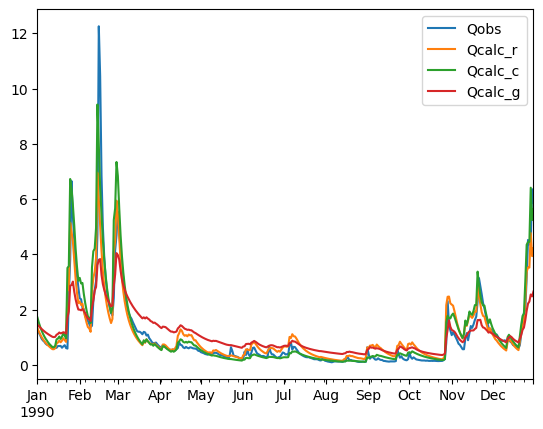

In [56]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

gauge_id="DERP2031"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_8801[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_8801[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_8801[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["1990"].plot()

In [180]:
data_diff_cal[data_diff_cal.nse_r1 > 0.85].iloc[:, 0:-3]

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
DEBU1956 -0.010906 -0.006572  0.850008  0.860914  0.856581    0.878422   
DEBU1957  0.027957  0.029082  0.863898  0.835942  0.834816    0.849868   
DEBU1959 -0.011667 -0.001482  0.865428  0.877095  0.866910    0.905794   
FR000140 -0.003902 -0.000095  0.860259  0.864160  0.860353         NaN   
FR000190  0.027724  0.035180  0.872400  0.844676  0.837219         NaN   
FR003249 -0.010153 -0.005168  0.869289  0.879442  0.874457         NaN   
FR003284 -0.006875 -0.002576  0.859676  0.866551  0.862252         NaN   
LU000017  0.003912  0.101954  0.852524  0.848612  0.750569    0.871139   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1    bfi_c1    bfi_g1  \
basin                                                                      
DEBU1956    0.869204    0.869483  0.610835  0.627549  0.657747  0.657817   
DEBU1957    0.824080    0.820271  0.605700  0.644697  0.691117  0.675862   
DEBU1959    0.904835    0.897823  0.611554  0.633754  0.665774  0.678520   
FR000140         NaN         NaN  0.568520  0.596272  0.623759  0.636577   
FR000190         NaN         NaN  0.635066  0.646806  0.694612  0.677625   
FR003249         NaN         NaN  0.583065  0.600707  0.631367  0.638544   
FR003284         NaN         NaN  0.611175  0.627148  0.656645  0.658249   
LU000017    0.857222    0.680423  0.574924  0.598715  0.631372  0.727089   

          perm_high_regi  perm_medium_regi  perm_low_regi  perm_high_glob2  \
basin                                                                        
DEBU1956            21.0              68.0           11.0             19.0   
DEBU1957            33.0              64.0            3.0             33.0   
DEBU1959            25.0              56.0           19.0             31.0   
FR000140            25.0              48.0           27.0             21.0   
FR000190            37.0              62.0            1.0             36.0   
FR003249            23.0              53.0           24.0             20.0   
FR003284            21.0              68.0           11.0             20.0   
LU000017            19.0              31.0           50.0             41.0   

          perm_medium_glob2  perm_low_glob2  
basin                                        
DEBU1956               73.0             8.0  
DEBU1957               66.0             1.0  
DEBU1959               65.0             4.0  
FR000140               59.0            20.0  
FR000190               63.0             1.0  
FR003249               62.0            18.0  
FR003284               72.0             8.0  
LU000017               59.0             0.0

In [181]:
data_diff_cal[data_diff_cal.nse_r1 < 0.5].iloc[:, 0:-3]

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
FR000144 -0.161702 -0.107624 -0.338022 -0.176320 -0.230398         NaN   
FR000185  0.175389  0.078666  0.380050  0.204661  0.301385         NaN   
FR003250 -0.062410 -0.089830  0.201436  0.263847  0.291266         NaN   
FR003259  0.141190  0.013033  0.311947  0.170757  0.298914         NaN   
FR003280 -0.054395 -0.049826  0.393840  0.448235  0.443666         NaN   
FR003288  0.042357  0.177624  0.448982  0.406625  0.271358         NaN   
FR003303 -0.045123 -0.015703 -0.557843 -0.512720 -0.542140   -2.193359   
FR003306 -0.262914 -0.075006 -0.472334 -0.209420 -0.397328         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1    bfi_c1    bfi_g1  \
basin                                                                      
FR000144         NaN         NaN  0.681845  0.768781  0.783728  0.804764   
FR000185         NaN         NaN  0.558059  0.747527  0.821912  0.790320   
FR003250         NaN         NaN  0.683473  0.540899  0.561130  0.585286   
FR003259         NaN         NaN  0.587749  0.710226  0.776349  0.670856   
FR003280         NaN         NaN  0.687017  0.523113  0.555968  0.550688   
FR003288         NaN         NaN  0.586159  0.624539  0.650985  0.550658   
FR003303   -2.774296   -2.535956  0.794509  0.795206  0.893301  0.845255   
FR003306         NaN         NaN  0.749280  0.769845  0.829772  0.809703   

          perm_high_regi  perm_medium_regi  perm_low_regi  perm_high_glob2  \
basin                                                                        
FR000144            92.0               0.0            8.0             83.0   
FR000185            75.0              23.0            2.0             71.0   
FR003250             4.0               0.0           96.0              0.0   
FR003259            66.0              34.0            0.0             35.0   
FR003280             0.0             100.0            0.0              0.0   
FR003288            29.0              71.0            0.0              0.0   
FR003303            98.0               2.0            0.0             96.0   
FR003306            94.0               6.0            0.0             91.0   

          perm_medium_glob2  perm_low_glob2  
basin                                        
FR000144                5.0            12.0  
FR000185               27.0             2.0  
FR003250                6.0            94.0  
FR003259               65.0             0.0  
FR003280              100.0             0.0  
FR003288              100.0             0.0  
FR003303                4.0             0.0  
FR003306                9.0             0.0

<Axes: >

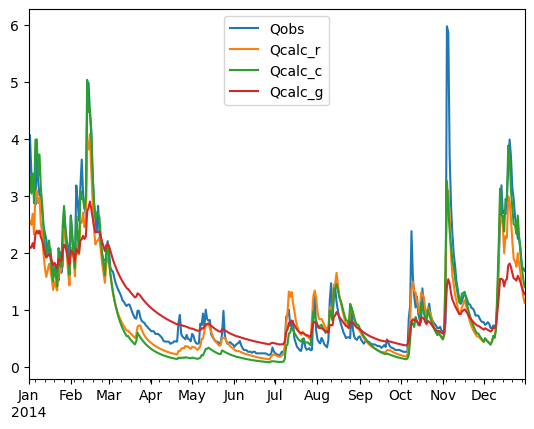

In [167]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

gauge_id="DERP2017"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2014"].plot()

<Axes: >

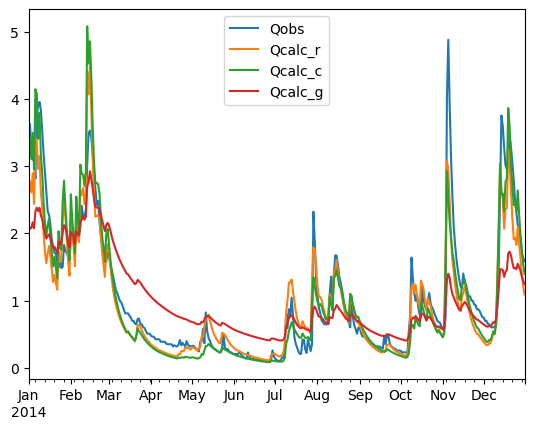

In [168]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

gauge_id="DERP2031"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2014"].plot()

<Axes: >

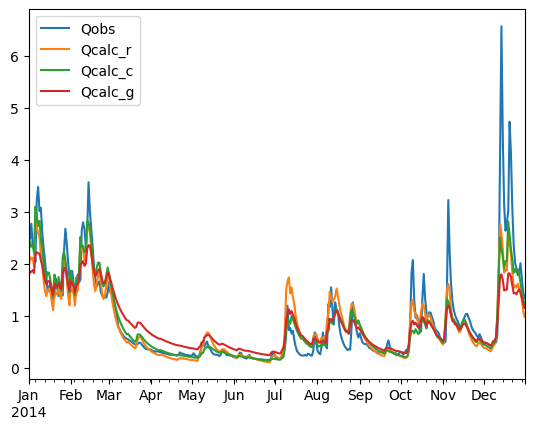

In [169]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))


gauge_id="LU000017"

Qtimeseries["Qobs"] = observations[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2014"].plot()

In [170]:
data_diff_cal[['perm_high_regi', 'perm_medium_regi', 'perm_low_regi',]] = estreams_attributes[['perm_high_regi', 'perm_medium_regi', 'perm_low_regi',]]
data_diff_cal[['perm_high_glob2', 'perm_medium_glob2', 'perm_low_glob2',]] = estreams_attributes[['perm_high_glob2', 'perm_medium_glob2', 'perm_low_glob2',]]
data_diff_cal[['lat_snap', 'lon_snap']] = estreams_attributes[['lat_snap', 'lon_snap']]
data_diff_cal[['area']] = estreams_attributes[['area_estreams']]

data_diff_cal

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066 -0.034058  0.310443  0.826402  0.860460  0.515958    0.823303   
BEWA0067 -0.019116  0.267704  0.776418  0.795534  0.508714    0.765821   
BEWA0106 -0.047748  0.465526  0.738859  0.786607  0.273333         NaN   
BEWA0107 -0.038995  0.380173  0.723577  0.762572  0.343404         NaN   
BEWA0119 -0.027736  0.313667  0.811971  0.839707  0.498304         NaN   
...            ...       ...       ...       ...       ...         ...   
LU000015 -0.078411  0.401203  0.753774  0.832185  0.352571    0.778332   
LU000016  0.114346  0.128390  0.688915  0.574570  0.560526    0.497113   
LU000017  0.003912  0.101954  0.852524  0.848612  0.750569    0.871139   
LU000018  0.339001  0.092953  0.609091  0.270090  0.516138    0.410972   
LU000019 -0.020063  0.231212  0.805395  0.825458  0.574183    0.838583   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...    bfi_g1  \
basin                                                 ...             
BEWA0066    0.883596    0.138918  0.511429  0.557320  ...  0.803718   
BEWA0067    0.795083    0.047242  0.443161  0.540013  ...  0.760583   
BEWA0106         NaN         NaN  0.473400  0.560178  ...  0.846723   
BEWA0107         NaN         NaN  0.565604  0.553497  ...  0.832013   
BEWA0119         NaN         NaN  0.503286  0.554247  ...  0.793015   
...              ...         ...       ...       ...  ...       ...   
LU000015    0.853968   -0.200624  0.517760  0.555506  ...  0.846011   
LU000016    0.071846   -0.166926  0.563590  0.562215  ...  0.552001   
LU000017    0.857222    0.680423  0.574924  0.598715  ...  0.727089   
LU000018   -0.605806   -0.364504  0.543259  0.649665  ...  0.548551   
LU000019    0.858781    0.229273  0.497731  0.564138  ...  0.773988   

          perm_high_regi  perm_medium_regi  perm_low_regi  perm_high_glob2  \
basin                                                                        
BEWA0066             3.0               3.0           94.0             75.0   
BEWA0067             2.0               0.0           98.0             64.0   
BEWA0106             0.0               0.0          100.0            100.0   
BEWA0107             4.0              15.0           81.0            100.0   
BEWA0119             3.0               3.0           94.0             75.0   
...                  ...               ...            ...              ...   
LU000015             2.0               0.0           98.0            100.0   
LU000016            14.0              86.0            0.0              0.0   
LU000017            19.0              31.0           50.0             41.0   
LU000018            39.0              61.0            0.0              0.0   
LU000019             4.0               4.0           92.0             59.0   

          perm_medium_glob2  perm_low_glob2   lat_snap  lon_snap      area  
basin                                                                       
BEWA0066               25.0             0.0  50.188258  6.151802   357.829  
BEWA0067               36.0             0.0  50.289277  6.263467   101.033  
BEWA0106                0.0             0.0  50.196522  6.150669    58.549  
BEWA0107                0.0             0.0  50.235014  6.153292    77.098  
BEWA0119               25.0             0.0  50.141935  6.141814   395.486  
...                     ...             ...        ...       ...       ...  
LU000015                0.0             0.0  49.895421  6.091178   946.519  
LU000016              100.0             0.0  49.620647  6.132266   387.289  
LU000017               59.0             0.0  49.785883  6.509851  4255.524  
LU000018              100.0             0.0  49.723112  6.100795    83.614  
LU000019               41.0             0.0  49.939224  6.204738   638.434  

[98 rows x 21 columns]

In [171]:
data_diff_cal[data_diff_cal.nse_r1<0.5]

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
FR000144 -0.161702 -0.107624 -0.338022 -0.176320 -0.230398         NaN   
FR000185  0.175389  0.078666  0.380050  0.204661  0.301385         NaN   
FR003250 -0.062410 -0.089830  0.201436  0.263847  0.291266         NaN   
FR003259  0.141190  0.013033  0.311947  0.170757  0.298914         NaN   
FR003280 -0.054395 -0.049826  0.393840  0.448235  0.443666         NaN   
FR003288  0.042357  0.177624  0.448982  0.406625  0.271358         NaN   
FR003303 -0.045123 -0.015703 -0.557843 -0.512720 -0.542140   -2.193359   
FR003306 -0.262914 -0.075006 -0.472334 -0.209420 -0.397328         NaN   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...    bfi_g1  \
basin                                                 ...             
FR000144         NaN         NaN  0.681845  0.768781  ...  0.804764   
FR000185         NaN         NaN  0.558059  0.747527  ...  0.790320   
FR003250         NaN         NaN  0.683473  0.540899  ...  0.585286   
FR003259         NaN         NaN  0.587749  0.710226  ...  0.670856   
FR003280         NaN         NaN  0.687017  0.523113  ...  0.550688   
FR003288         NaN         NaN  0.586159  0.624539  ...  0.550658   
FR003303   -2.774296   -2.535956  0.794509  0.795206  ...  0.845255   
FR003306         NaN         NaN  0.749280  0.769845  ...  0.809703   

          perm_high_regi  perm_medium_regi  perm_low_regi  perm_high_glob2  \
basin                                                                        
FR000144            92.0               0.0            8.0             83.0   
FR000185            75.0              23.0            2.0             71.0   
FR003250             4.0               0.0           96.0              0.0   
FR003259            66.0              34.0            0.0             35.0   
FR003280             0.0             100.0            0.0              0.0   
FR003288            29.0              71.0            0.0              0.0   
FR003303            98.0               2.0            0.0             96.0   
FR003306            94.0               6.0            0.0             91.0   

          perm_medium_glob2  perm_low_glob2   lat_snap  lon_snap     area  
basin                                                                      
FR000144                5.0            12.0  48.416320  6.877879  117.784  
FR000185               27.0             2.0  48.680322  7.014472  188.492  
FR003250                6.0            94.0  48.184730  7.002529   67.143  
FR003259               65.0             0.0  48.324169  6.645964   64.746  
FR003280              100.0             0.0  49.246953  5.933378   74.738  
FR003288              100.0             0.0  49.391885  6.272360  108.785  
FR003303                4.0             0.0  49.127103  7.472093   95.212  
FR003306                9.0             0.0  49.225799  6.688894   58.148  

[8 rows x 21 columns]

In [172]:
data_diff_cal[data_diff_cal.nse_g1<0.5]

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0106 -0.047748  0.465526  0.738859  0.786607  0.273333         NaN   
BEWA0107 -0.038995  0.380173  0.723577  0.762572  0.343404         NaN   
BEWA0119 -0.027736  0.313667  0.811971  0.839707  0.498304         NaN   
FR000144 -0.161702 -0.107624 -0.338022 -0.176320 -0.230398         NaN   
FR000174  0.058445  0.043990  0.543822  0.485377  0.499832         NaN   
FR000185  0.175389  0.078666  0.380050  0.204661  0.301385         NaN   
FR003250 -0.062410 -0.089830  0.201436  0.263847  0.291266         NaN   
FR003259  0.141190  0.013033  0.311947  0.170757  0.298914         NaN   
FR003280 -0.054395 -0.049826  0.393840  0.448235  0.443666         NaN   
FR003288  0.042357  0.177624  0.448982  0.406625  0.271358         NaN   
FR003303 -0.045123 -0.015703 -0.557843 -0.512720 -0.542140   -2.193359   
FR003306 -0.262914 -0.075006 -0.472334 -0.209420 -0.397328         NaN   
LU000001 -0.060459  0.407086  0.812174  0.872633  0.405088    0.805809   
LU000008 -0.089930  0.301904  0.611717  0.701647  0.309813    0.663287   
LU000011 -0.052357  0.404569  0.810208  0.862565  0.405640    0.825261   
LU000013  0.142401  0.091667  0.589909  0.447508  0.498242    0.562587   
LU000015 -0.078411  0.401203  0.753774  0.832185  0.352571    0.778332   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  ...    bfi_g1  \
basin                                                 ...             
BEWA0106         NaN         NaN  0.473400  0.560178  ...  0.846723   
BEWA0107         NaN         NaN  0.565604  0.553497  ...  0.832013   
BEWA0119         NaN         NaN  0.503286  0.554247  ...  0.793015   
FR000144         NaN         NaN  0.681845  0.768781  ...  0.804764   
FR000174         NaN         NaN  0.412715  0.520488  ...  0.548412   
FR000185         NaN         NaN  0.558059  0.747527  ...  0.790320   
FR003250         NaN         NaN  0.683473  0.540899  ...  0.585286   
FR003259         NaN         NaN  0.587749  0.710226  ...  0.670856   
FR003280         NaN         NaN  0.687017  0.523113  ...  0.550688   
FR003288         NaN         NaN  0.586159  0.624539  ...  0.550658   
FR003303   -2.774296   -2.535956  0.794509  0.795206  ...  0.845255   
FR003306         NaN         NaN  0.749280  0.769845  ...  0.809703   
LU000001    0.895589    0.055522  0.549534  0.533464  ...  0.837322   
LU000008    0.703510   -0.420076  0.495034  0.538213  ...  0.839673   
LU000011    0.897215    0.113708  0.566555  0.577541  ...  0.853565   
LU000013   -0.004558    0.175915  0.559076  0.550448  ...  0.552090   
LU000015    0.853968   -0.200624  0.517760  0.555506  ...  0.846011   

          perm_high_regi  perm_medium_regi  perm_low_regi  perm_high_glob2  \
basin                                                                        
BEWA0106             0.0               0.0          100.0            100.0   
BEWA0107             4.0              15.0           81.0            100.0   
BEWA0119             3.0               3.0           94.0             75.0   
FR000144            92.0               0.0            8.0             83.0   
FR000174             0.0             100.0            0.0              1.0   
FR000185            75.0              23.0            2.0             71.0   
FR003250             4.0               0.0           96.0              0.0   
FR003259            66.0              34.0            0.0             35.0   
FR003280             0.0             100.0            0.0              0.0   
FR003288            29.0              71.0            0.0              0.0   
FR003303            98.0               2.0            0.0             96.0   
FR003306            94.0               6.0            0.0             91.0   
LU000001             1.0               0.0           99.0            100.0   
LU000008             1.0               0.0           99.0            100.0   
LU000011  

In [173]:
data_diff_cal.corr()

nse    nse_rg    nse_r1    nse_c1    nse_g1  \
nse                1.000000  0.010238  0.201719 -0.173474  0.195446   
nse_rg             0.010238  1.000000  0.242853  0.240339 -0.263193   
nse_r1             0.201719  0.242853  1.000000  0.929601  0.871945   
nse_c1            -0.173474  0.240339  0.929601  1.000000  0.803200   
nse_g1             0.195446 -0.263193  0.871945  0.803200  1.000000   
nse_bfi_r1        -0.115490  0.136068  0.976431  0.903739  0.807603   
nse_bfi_c1        -0.475158  0.175018  0.894321  0.978582  0.711279   
nse_bfi_g1        -0.128136 -0.415036  0.763905  0.722465  0.925834   
bfi_obs            0.030386 -0.280035 -0.410996 -0.424694 -0.267404   
bfi_r1             0.334681 -0.179718 -0.380854 -0.508893 -0.288059   
bfi_c1             0.423781 -0.154186 -0.365773 -0.527258 -0.285947   
bfi_g1            -0.133968  0.538962 -0.136763 -0.087104 -0.408036   
perm_high_regi     0.286823 -0.283654 -0.478424 -0.588992 -0.332637   
perm_medium_regi   0.184957 -0.272276  0.100854  0.031809  0.237723   
perm_low_regi     -0.360484  0.440365  0.217116  0.353963 -0.006334   
perm_high_glob2   -0.174870  0.573869 -0.185111 -0.120326 -0.473736   
perm_medium_glob2  0.285378 -0.345169  0.180250  0.073854  0.353473   
perm_low_glob2    -0.223633 -0.349138 -0.013585  0.070494  0.162704   
lat_snap           0.031748  0.588110  0.173296  0.162304 -0.124482   
lon_snap           0.079077 -0.353708 -0.198658 -0.229509 -0.019047   
area              -0.083223 -0.111144  0.198964  0.231377  0.253969   

                   nse_bfi_r1  nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1  \
nse                 -0.115490   -0.475158   -0.128136  0.030386  0.334681   
nse_rg               0.136068    0.175018   -0.415036 -0.280035 -0.179718   
nse_r1               0.976431    0.894321    0.763905 -0.410996 -0.380854   
nse_c1               0.903739    0.978582    0.722465 -0.424694 -0.508893   
nse_g1               0.807603    0.711279    0.925834 -0.267404 -0.288059   
nse_bfi_r1           1.000000    0.911266    0.793382 -0.512003 -0.501538   
nse_bfi_c1           0.911266    1.000000    0.733817 -0.510394 -0.573303   
nse_bfi_g1           0.793382    0.733817    1.000000 -0.250108 -0.226065   
bfi_obs             -0.512003   -0.510394   -0.250108  1.000000  0.651260   
bfi_r1              -0.501538   -0.573303   -0.226065  0.651260  1.000000   
bfi_c1              -0.518301   -0.606269   -0.354972  0.482475  0.896971   
bfi_g1              -0.123628   -0.026782   -0.266103  0.333839  0.481614   
perm_high_regi      -0.571420   -0.639918   -0.314109  0.700842  0.943624   
perm_medium_regi     0.037422   -0.093089    0.143742 -0.203832 -0.169143   
perm_low_regi        0.307283    0.453713    0.068919 -0.265412 -0.456174   
perm_high_glob2     -0.154993   -0.054671   -0.342578  0.313916  0.414800   
perm_medium_glob2    0.115827    0.005850    0.253772 -0.358580 -0.244094   
perm_low_glob2       0.124338    0.159222    0.282197  0.119936 -0.262249   
lat_snap             0.135433    0.140643   -0.111760 -0.288938 -0.112010   
lon_snap            -0.300159   -0.238268    0.082287  0.450806  0.499743   
area                 0.146371    0.164519    0.216870  0.127213  0.081608   

                   ...    bfi_g1  perm_high_regi  perm_medium_regi  \
nse                ... -0.133968        0.286823          0.184957   
nse_rg             ...  0.538962       -0.283654         -0.272276   
nse_r1             ... -0.136763       -0.478424          0.100854   
nse_c1             ... -0.087104       -0.588992          0.031809   
nse_g1             ... -0.408036       -0.332637          0.237723   
nse_bfi_r1         ... -0.123628       -0.571420          0.037422   
nse_bfi_c1         ... -0.026782       -0.639918         -0.093089   
nse_bfi_g1         ... -0.266103       -0.314109          0.143742   
bfi_obs            ...  0.333839        0.700842         -0.203832   
bfi_r1             ...  0.481614        0.943624         -0.169143

In [107]:
path_inputs = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_superflexpy\data\models\input\subset_1988_2001'

inputs = np.load(path_inputs+'\\inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'\\observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'\\areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'\\perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'\\perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'\\perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'\\quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'\\rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'\\waterdeficit_mean.npy', allow_pickle=True).item()


output_continental_2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_1, perm_areas = perm_areascontinental)
output_regional_2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_1, perm_areas = perm_areas)
output_global_2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_1, perm_areas = perm_areasglobal)

nse_results_val_r_1_100 = generate_nse_results(catchments_ids, pd.date_range('1988-01-01', '2000-12-31', freq='D'), output_regional_2)
nse_results_val_c_1_100 = generate_nse_results(catchments_ids, pd.date_range('1988-01-01', '2000-12-31', freq='D'), output_continental_2)
nse_results_val_g_1_100 = generate_nse_results(catchments_ids, pd.date_range('1988-01-01', '2000-12-31', freq='D'), output_global_2)

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_23924\1110209421.py:27: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_23924\3178218967.py:85: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')
c:\Users\nascimth\AppData\Local\m

In [58]:
path_inputs = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_superflexpy\data\models\input\subset_2001_2015'

inputs = np.load(path_inputs+'\\inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'\\observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'\\areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'\\perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'\\perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'\\perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'\\quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'\\rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'\\waterdeficit_mean.npy', allow_pickle=True).item()


output_continental_0115 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_1_8801, perm_areas = perm_areascontinental)
output_regional_0115 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_1_8801, perm_areas = perm_areas)
output_global_0115 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_1_8801, perm_areas = perm_areasglobal)

nse_results_val_r_1_100_0115 = generate_nse_results(catchments_ids, pd.date_range('2002-01-01', '2014-12-31', freq='D'), output_regional_0115)
nse_results_val_c_1_100_0115 = generate_nse_results(catchments_ids, pd.date_range('2002-01-01', '2014-12-31', freq='D'), output_continental_0115)
nse_results_val_g_1_100_0115 = generate_nse_results(catchments_ids, pd.date_range('2002-01-01', '2014-12-31', freq='D'), output_global_0115)

In [59]:
nse_results_val_r_1_100_0115.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_23924\2910042604.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_r_1_100_0115.corr()


nse  q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  \
nse            1.000000    0.172145    -0.020714 -0.196800  0.100354   
q_mean_obs     0.172145    1.000000     0.930759  0.018471 -0.436412   
q_mean_calc   -0.020714    0.930759     1.000000  0.058126 -0.411873   
bfi_obs       -0.196800    0.018471     0.058126  1.000000  0.597937   
bfi_sim        0.100354   -0.436412    -0.411873  0.597937  1.000000   
nse_value_bfi  0.958265    0.337248     0.210944 -0.512607 -0.497767   

               nse_value_bfi  
nse                 0.958265  
q_mean_obs          0.337248  
q_mean_calc         0.210944  
bfi_obs            -0.512607  
bfi_sim            -0.497767  
nse_value_bfi       1.000000

In [60]:
nse_results_val_g_1_100_0115.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_23924\585836594.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_g_1_100_0115.corr()


nse  q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  \
nse            1.000000    0.169354    -0.029809 -0.186635 -0.198313   
q_mean_obs     0.169354    1.000000     0.929819  0.018471 -0.031941   
q_mean_calc   -0.029809    0.929819     1.000000  0.058628  0.060110   
bfi_obs       -0.186635    0.018471     0.058628  1.000000  0.429278   
bfi_sim       -0.198313   -0.031941     0.060110  0.429278  1.000000   
nse_value_bfi  0.906189    0.236836     0.128272 -0.245165 -0.346079   

               nse_value_bfi  
nse                 0.906189  
q_mean_obs          0.236836  
q_mean_calc         0.128272  
bfi_obs            -0.245165  
bfi_sim            -0.346079  
nse_value_bfi       1.000000

In [61]:
nse_results_val_c_1_100_0115.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_23924\3334650496.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_c_1_100_0115.corr()


nse  q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  \
nse            1.000000    0.167191    -0.029904 -0.208591  0.030341   
q_mean_obs     0.167191    1.000000     0.930290  0.018471 -0.285642   
q_mean_calc   -0.029904    0.930290     1.000000  0.059532 -0.269311   
bfi_obs       -0.208591    0.018471     0.059532  1.000000  0.510622   
bfi_sim        0.030341   -0.285642    -0.269311  0.510622  1.000000   
nse_value_bfi  0.937876    0.335398     0.242193 -0.487590 -0.566455   

               nse_value_bfi  
nse                 0.937876  
q_mean_obs          0.335398  
q_mean_calc         0.242193  
bfi_obs            -0.487590  
bfi_sim            -0.566455  
nse_value_bfi       1.000000

In [65]:
data_diff_val_0115 = pd.DataFrame(data=nse_results_val_r_1_100_0115.nse - nse_results_val_c_1_100_0115.nse)
data_diff_val_0115["nse_rg"] = nse_results_val_r_1_100_0115.nse - nse_results_val_g_1_100_0115.nse

data_diff_val_0115.index = nse_results_val_c_1_100_0115.basin

data_diff_val_0115 = data_diff_val_0115.loc[~data_diff_val_0115.index.isin(list_cal)]

data_diff_val_0115["nse_r1"] = nse_results_val_r_1_100_0115.set_index("basin", inplace = False).nse
data_diff_val_0115["nse_c1"] = nse_results_val_c_1_100_0115.set_index("basin", inplace = False).nse
data_diff_val_0115["nse_g1"] = nse_results_val_g_1_100_0115.set_index("basin", inplace = False).nse

data_diff_val_0115["nse_bfi_r1"] = nse_results_val_r_1_100_0115.set_index("basin", inplace = False).nse_value_bfi
data_diff_val_0115["nse_bfi_c1"] = nse_results_val_c_1_100_0115.set_index("basin", inplace = False).nse_value_bfi
data_diff_val_0115["nse_bfi_g1"] = nse_results_val_g_1_100_0115.set_index("basin", inplace = False).nse_value_bfi

data_diff_val_0115["bfi_obs"] = nse_results_val_r_1_100_0115.set_index("basin", inplace = False).bfi_obs
data_diff_val_0115["bfi_r1"] = nse_results_val_r_1_100_0115.set_index("basin", inplace = False).bfi_sim
data_diff_val_0115["bfi_c1"] = nse_results_val_c_1_100_0115.set_index("basin", inplace = False).bfi_sim
data_diff_val_0115["bfi_g1"] = nse_results_val_g_1_100_0115.set_index("basin", inplace = False).bfi_sim

data_diff_val_0115 = data_diff_val_0115[data_diff_val_0115.nse_r1 > -10.0]
data_diff_val_0115

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066 -0.068594  0.233894  0.762024  0.830618  0.528130    0.726606   
BEWA0067 -0.042593  0.191284  0.707891  0.750483  0.516607    0.678305   
BEWA0106 -0.095625  0.354210  0.662037  0.757662  0.307826         NaN   
BEWA0107 -0.087772  0.294901  0.700979  0.788751  0.406078         NaN   
BEWA0119 -0.060416  0.236369  0.756312  0.816727  0.519943         NaN   
...            ...       ...       ...       ...       ...         ...   
LU000015 -0.121960  0.306945  0.700166  0.822126  0.393221    0.680845   
LU000016  0.081700  0.013117  0.648363  0.566662  0.635245    0.659979   
LU000017 -0.030229  0.044100  0.788577  0.818806  0.744478    0.834444   
LU000018  0.281419 -0.031659  0.531302  0.249883  0.562961    0.436320   
LU000019 -0.051980  0.161471  0.741929  0.793909  0.580458    0.747465   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1    bfi_c1    bfi_g1  
basin                                                                     
BEWA0066    0.881704    0.309238  0.511429  0.597825  0.588197  0.802041  
BEWA0067    0.801745    0.246609  0.443161  0.579454  0.573594  0.754438  
BEWA0106         NaN         NaN  0.473400  0.601116  0.598010  0.850382  
BEWA0107         NaN         NaN  0.565604  0.596896  0.580303  0.834169  
BEWA0119         NaN         NaN  0.503286  0.593985  0.584654  0.791093  
...              ...         ...       ...       ...       ...       ...  
LU000015    0.865572    0.009688  0.517760  0.597671  0.592484  0.849555  
LU000016    0.181525    0.279552  0.563590  0.635092  0.595823  0.541818  
LU000017    0.880660    0.763179  0.574924  0.643409  0.646997  0.722440  
LU000018   -0.323313    0.073743  0.543259  0.691482  0.880231  0.538203  
LU000019    0.867747    0.388108  0.497731  0.604766  0.593778  0.770366  

[98 rows x 12 columns]

In [108]:
data_diff_val = pd.DataFrame(data=nse_results_val_r_1_100.nse - nse_results_val_c_1_100.nse)
data_diff_val["nse_rg"] = nse_results_val_r_1_100.nse - nse_results_val_g_1_100.nse

data_diff_val.index = nse_results_val_c_1_100.basin

data_diff_val = data_diff_val.loc[~data_diff_val.index.isin(list_cal)]

data_diff_val["nse_r1"] = nse_results_val_r_1_100.set_index("basin", inplace = False).nse
data_diff_val["nse_c1"] = nse_results_val_c_1_100.set_index("basin", inplace = False).nse
data_diff_val["nse_g1"] = nse_results_val_g_1_100.set_index("basin", inplace = False).nse

data_diff_val["nse_bfi_r1"] = nse_results_val_r_1_100.set_index("basin", inplace = False).nse_value_bfi
data_diff_val["nse_bfi_c1"] = nse_results_val_c_1_100.set_index("basin", inplace = False).nse_value_bfi
data_diff_val["nse_bfi_g1"] = nse_results_val_g_1_100.set_index("basin", inplace = False).nse_value_bfi

data_diff_val["bfi_obs"] = nse_results_val_r_1_100.set_index("basin", inplace = False).bfi_obs
data_diff_val["bfi_r1"] = nse_results_val_r_1_100.set_index("basin", inplace = False).bfi_sim
data_diff_val["bfi_c1"] = nse_results_val_c_1_100.set_index("basin", inplace = False).bfi_sim
data_diff_val["bfi_g1"] = nse_results_val_g_1_100.set_index("basin", inplace = False).bfi_sim

data_diff_val = data_diff_val[data_diff_val.nse_r1 > -10.0]
data_diff_val

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066 -0.027887  0.292720  0.818833  0.846719  0.526113         NaN   
BEWA0067 -0.030009  0.270157  0.786773  0.816782  0.516617         NaN   
BEWA0106 -0.062011  0.345959  0.718509  0.780521  0.372550         NaN   
BEWA0107 -0.013761  0.226957  0.719498  0.733259  0.492541         NaN   
BEWA0119 -0.027527  0.272161  0.784596  0.812124  0.512435         NaN   
...            ...       ...       ...       ...       ...         ...   
FR003300  0.044509  0.048603  0.505983  0.461474  0.457380    0.101674   
FR003302  0.052544  0.049895  0.789622  0.737078  0.739727         NaN   
FR003303 -0.253899 -0.114652 -0.586202 -0.332303 -0.471551         NaN   
FR003306 -0.432777 -0.185521 -0.939404 -0.506626 -0.753882         NaN   
FR003307 -0.026437 -0.021809  0.787160  0.813597  0.808969    0.765846   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1    bfi_c1    bfi_g1  
basin                                                                     
BEWA0066         NaN         NaN  0.524659  0.552303  0.566561  0.786703  
BEWA0067         NaN         NaN  0.469727  0.547326  0.563061  0.737641  
BEWA0106         NaN         NaN  0.506445  0.539109  0.560652  0.821925  
BEWA0107         NaN         NaN  0.557155  0.522635  0.533596  0.772290  
BEWA0119         NaN         NaN  0.513078  0.538153  0.553451  0.757345  
...              ...         ...       ...       ...       ...       ...  
FR003300    0.030655   -0.036429  0.526066  0.651515  0.649514  0.674813  
FR003302         NaN         NaN  0.525576  0.595702  0.633415  0.620531  
FR003303         NaN         NaN  0.804400  0.764694  0.866724  0.816654  
FR003306         NaN         NaN  0.764163  0.769818  0.841583  0.817911  
FR003307    0.770247    0.773806  0.498878  0.533951  0.586415  0.538104  

[82 rows x 12 columns]

<Axes: xlabel='basin'>

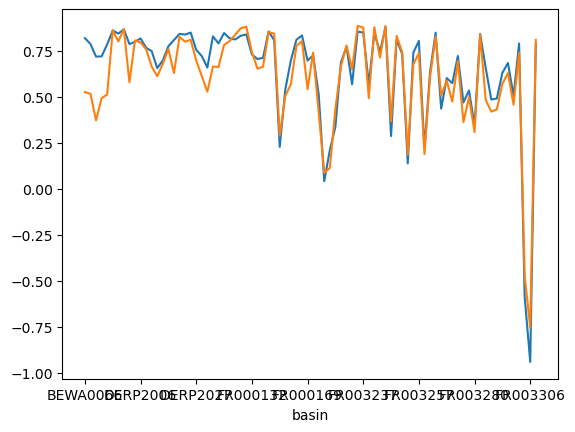

In [176]:
data_diff_val.nse_r1.plot()
data_diff_val.nse_g1.plot()

<Axes: xlabel='basin'>

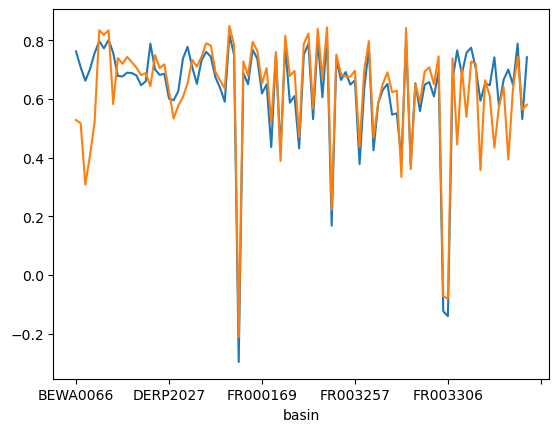

In [66]:
data_diff_val_0115.nse_r1.plot()
data_diff_val_0115.nse_g1.plot()

(0.2, 1.0)

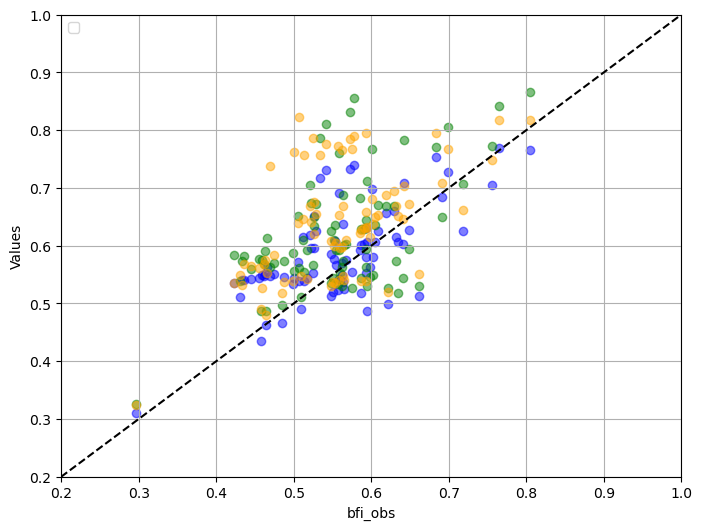

In [177]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data_diff_val["bfi_obs"], data_diff_val["bfi_r1"], color='blue', alpha=0.5)
plt.scatter(data_diff_val["bfi_obs"], data_diff_val["bfi_c1"], color='green', alpha=0.5)
plt.scatter(data_diff_val["bfi_obs"], data_diff_val["bfi_g1"], color='orange',alpha=0.5)


# Labels and title
plt.xlabel('bfi_obs')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='x = y')

plt.xlim([0.2, 1])
plt.ylim([0.2, 1])

(0.2, 1.0)

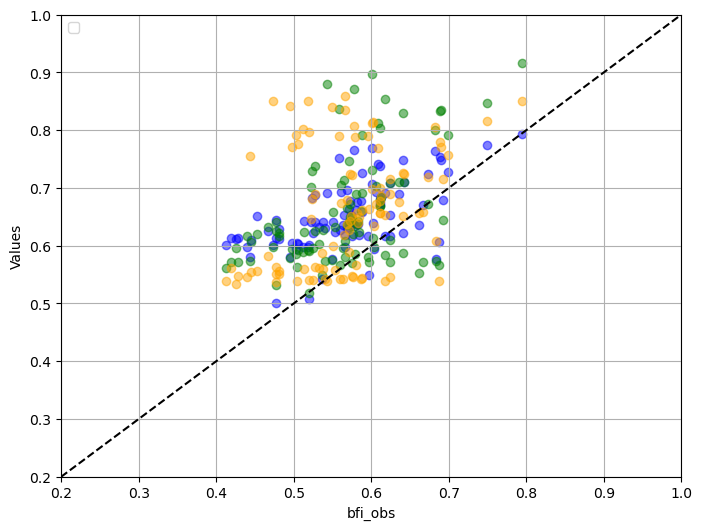

In [67]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data_diff_val_0115["bfi_obs"], data_diff_val_0115["bfi_r1"], color='blue', alpha=0.5)
plt.scatter(data_diff_val_0115["bfi_obs"], data_diff_val_0115["bfi_c1"], color='green', alpha=0.5)
plt.scatter(data_diff_val_0115["bfi_obs"], data_diff_val_0115["bfi_g1"], color='orange',alpha=0.5)


# Labels and title
plt.xlabel('bfi_obs')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='x = y')

plt.xlim([0.2, 1])
plt.ylim([0.2, 1])

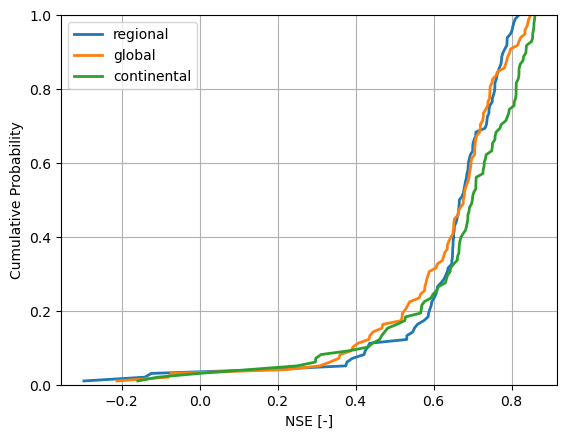

In [72]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val_0115["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_val_0115["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_val_0115["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)


# Labels and legend
plt.xlabel("NSE [-]")
#plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

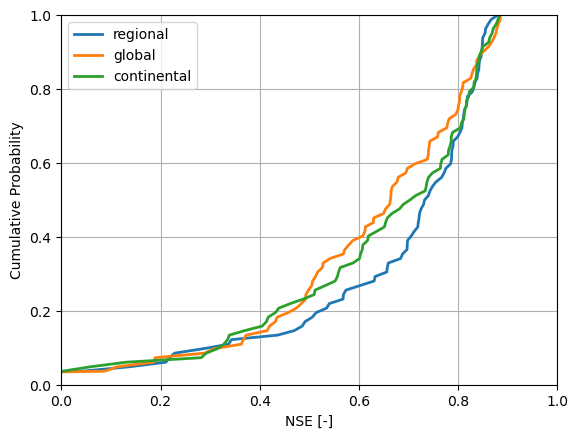

In [ ]:


# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_val["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_val["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)


# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

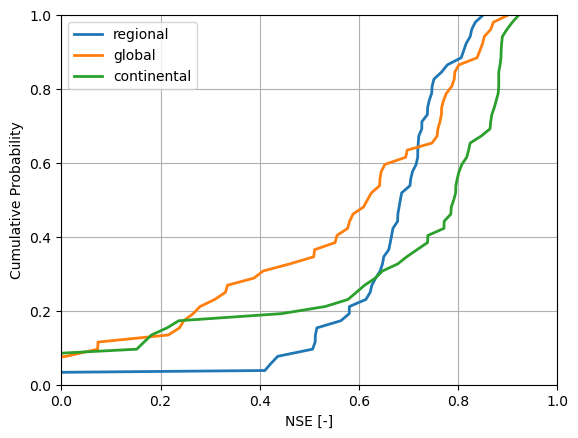

In [69]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val_0115["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_val_0115["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_val_0115["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)


# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

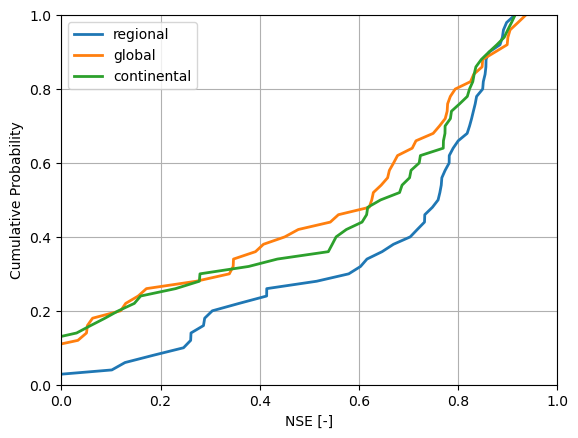

In [179]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_val["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_val["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)


# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

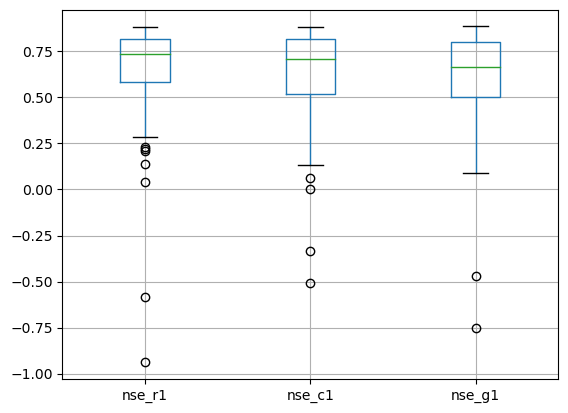

In [110]:
import matplotlib.pyplot as plt

# Plot both columns side by side
data_diff_val.boxplot(column=["nse_r1","nse_c1", "nse_g1"])

# Show the plot
plt.show()


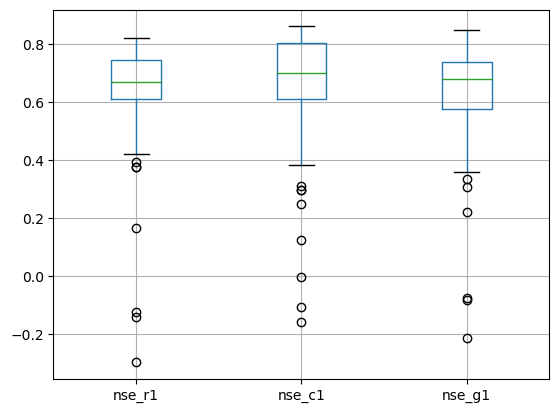

In [71]:
import matplotlib.pyplot as plt

# Plot both columns side by side
data_diff_val_0115.boxplot(column=["nse_r1","nse_c1", "nse_g1"])

# Show the plot
plt.show()


In [73]:
data_diff_val_0115.corr()

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
nse         1.000000 -0.116156  0.058783 -0.387741  0.120742   -0.133464   
nse_rg     -0.116156  1.000000  0.244607  0.277205 -0.301254    0.162210   
nse_r1      0.058783  0.244607  1.000000  0.897382  0.850888    0.953763   
nse_c1     -0.387741  0.277205  0.897382  1.000000  0.732310    0.775227   
nse_g1      0.120742 -0.301254  0.850888  0.732310  1.000000    0.711063   
nse_bfi_r1 -0.133464  0.162210  0.953763  0.775227  0.711063    1.000000   
nse_bfi_c1 -0.593471  0.239718  0.856590  0.938171  0.571516    0.835017   
nse_bfi_g1 -0.130352 -0.385485  0.721254  0.601272  0.900325    0.757005   
bfi_obs     0.313021 -0.138411 -0.301623 -0.416869 -0.221630   -0.420935   
bfi_r1      0.408369 -0.291537 -0.334405 -0.489284 -0.170903   -0.426814   
bfi_c1      0.512198 -0.219984 -0.318547 -0.520536 -0.194076   -0.452543   
bfi_g1      0.015188  0.643901 -0.032128 -0.036379 -0.380465   -0.103673   

            nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1    bfi_c1    bfi_g1  
nse          -0.593471   -0.130352  0.313021  0.408369  0.512198  0.015188  
nse_rg        0.239718   -0.385485 -0.138411 -0.291537 -0.219984  0.643901  
nse_r1        0.856590    0.721254 -0.301623 -0.334405 -0.318547 -0.032128  
nse_c1        0.938171    0.601272 -0.416869 -0.489284 -0.520536 -0.036379  
nse_g1        0.571516    0.900325 -0.221630 -0.170903 -0.194076 -0.380465  
nse_bfi_r1    0.835017    0.757005 -0.420935 -0.426814 -0.452543 -0.103673  
nse_bfi_c1    1.000000    0.646616 -0.497893 -0.564073 -0.561084  0.003229  
nse_bfi_g1    0.646616    1.000000 -0.197079 -0.139761 -0.301380 -0.314956  
bfi_obs      -0.497893   -0.197079  1.000000  0.587545  0.478267  0.346879  
bfi_r1       -0.564073   -0.139761  0.587545  1.000000  0.891743  0.332260  
bfi_c1       -0.561084   -0.301380  0.478267  0.891743  1.000000  0.316554  
bfi_g1        0.003229   -0.314956  0.346879  0.332260  0.316554  1.000000

In [112]:
data_diff_val

nse    nse_rg    nse_r1    nse_c1    nse_g1  nse_bfi_r1  \
basin                                                                    
BEWA0066 -0.027887  0.292720  0.818833  0.846719  0.526113         NaN   
BEWA0067 -0.030009  0.270157  0.786773  0.816782  0.516617         NaN   
BEWA0106 -0.062011  0.345959  0.718509  0.780521  0.372550         NaN   
BEWA0107 -0.013761  0.226957  0.719498  0.733259  0.492541         NaN   
BEWA0119 -0.027527  0.272161  0.784596  0.812124  0.512435         NaN   
...            ...       ...       ...       ...       ...         ...   
FR003300  0.044509  0.048603  0.505983  0.461474  0.457380    0.101674   
FR003302  0.052544  0.049895  0.789622  0.737078  0.739727         NaN   
FR003303 -0.253899 -0.114652 -0.586202 -0.332303 -0.471551         NaN   
FR003306 -0.432777 -0.185521 -0.939404 -0.506626 -0.753882         NaN   
FR003307 -0.026437 -0.021809  0.787160  0.813597  0.808969    0.765846   

          nse_bfi_c1  nse_bfi_g1   bfi_obs    bfi_r1    bfi_c1    bfi_g1  
basin                                                                     
BEWA0066         NaN         NaN  0.524659  0.552303  0.566561  0.786703  
BEWA0067         NaN         NaN  0.469727  0.547326  0.563061  0.737641  
BEWA0106         NaN         NaN  0.506445  0.539109  0.560652  0.821925  
BEWA0107         NaN         NaN  0.557155  0.522635  0.533596  0.772290  
BEWA0119         NaN         NaN  0.513078  0.538153  0.553451  0.757345  
...              ...         ...       ...       ...       ...       ...  
FR003300    0.030655   -0.036429  0.526066  0.651515  0.649514  0.674813  
FR003302         NaN         NaN  0.525576  0.595702  0.633415  0.620531  
FR003303         NaN         NaN  0.804400  0.764694  0.866724  0.816654  
FR003306         NaN         NaN  0.764163  0.769818  0.841583  0.817911  
FR003307    0.770247    0.773806  0.498878  0.533951  0.586415  0.538104  

[82 rows x 12 columns]

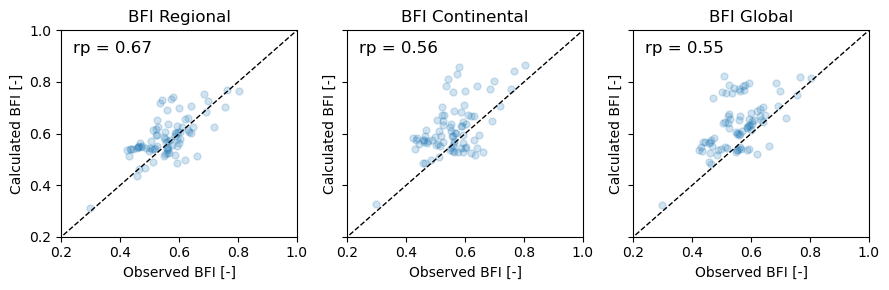

In [111]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['bfi_r1', 'bfi_c1', 'bfi_g1']
titles = ['BFI Regional', 'BFI Continental', 'BFI Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val["bfi_obs"]
    y = data_diff_val[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(0.2, 1.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

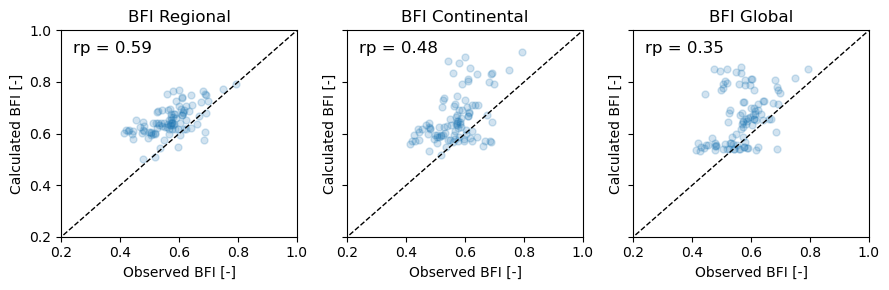

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['bfi_r1', 'bfi_c1', 'bfi_g1']
titles = ['BFI Regional', 'BFI Continental', 'BFI Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_0115["bfi_obs"]
    y = data_diff_val_0115[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(0.2, 1.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_0115[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

In [31]:
nse_results_cal_r_1.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_21372\3707226475.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_cal_r_1.corr()


nse  q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  \
nse            1.000000    0.348677     0.309495  0.388827  0.050877   
q_mean_obs     0.348677    1.000000     0.979560  0.756218  0.710068   
q_mean_calc    0.309495    0.979560     1.000000  0.822318  0.770415   
bfi_obs        0.388827    0.756218     0.822318  1.000000  0.817425   
bfi_sim        0.050877    0.710068     0.770415  0.817425  1.000000   
nse_value_bfi  0.807113    0.857750     0.853182  0.543600  0.445091   

               nse_value_bfi  
nse                 0.807113  
q_mean_obs          0.857750  
q_mean_calc         0.853182  
bfi_obs             0.543600  
bfi_sim             0.445091  
nse_value_bfi       1.000000

(0.2, 1.0)

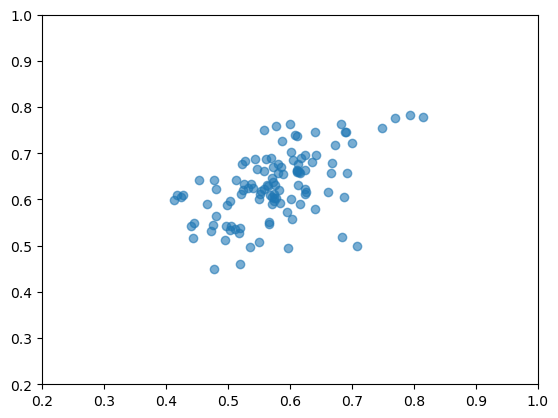

In [102]:
# Create scatter plot
plt.scatter(nse_results_cal_r_1["bfi_obs"], nse_results_cal_r_1["bfi_sim"], alpha=0.6)
# Set limits (adjust according to your data range)
plt.xlim([0.2, 1])
plt.ylim([0.2, 1])


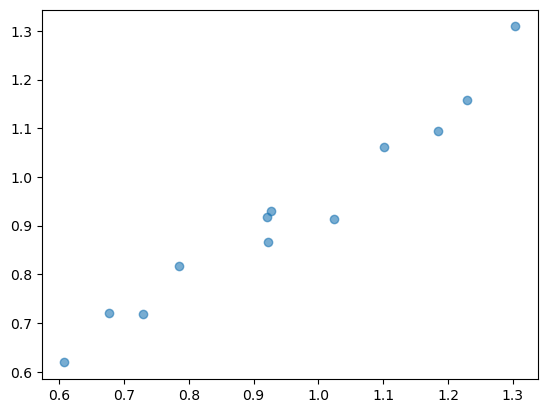

In [ ]:
# Create scatter plot
plt.scatter(nse_results_cal_r_1["q_mean_obs"], nse_results_cal_r_1["q_mean_calc"], alpha=0.6)
# Set limits (adjust according to your data range)
#plt.xlim([0.2, 1])
#plt.ylim([0.2, 1])

In [18]:
import hydroanalysis as hydroanalysis

In [224]:
path_inputs = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_superflexpy\data\models\input\subset_1988_2001'

inputs = np.load(path_inputs+'\\inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'\\observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'\\areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'\\perm_areas.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'\\perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'\\quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'\\rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'\\waterdeficit_mean.npy', allow_pickle=True).item()

In [256]:
best_params_dict_model_g_1_SumaxD

{'high_snow_k': 2.934993580860046,
 'high_unsaturated_Smax': 127.23002055688586,
 'high_unsaturated_Ce': 0.8032976193402295,
 'high_unsaturated_beta': 1.2176739587191074,
 'high_slowhigh_k': 0.00015603585255915512,
 'general_snow_k': 2.934993580860046,
 'general_unsaturated_Smax': 127.23002055688586,
 'general_unsaturated_Ce': 0.8032976193402295,
 'general_unsaturated_beta': 1.2176739587191074,
 'general_lowersplitter_splitpar': 0.7510347309521164,
 'general_slow_k': 0.09993578628220479,
 'general_lag-fun_lag-time': 2.8801273144273436,
 'general_fast_k': 0.12130750321170947,
 'low_snow_k': 2.934993580860046,
 'low_unsaturated_Smax': 127.23002055688586,
 'low_unsaturated_Ce': 0.8032976193402295,
 'low_unsaturated_beta': 1.2176739587191074,
 'low_fast_k': 0.0016403798882305785}

In [257]:
best_params_dict_model_g_1_SumaxD = {'high_snow_k': 2.934993580860046,
 'high_unsaturated_Smax': 127.23002055688586,
 'high_unsaturated_Ce': 0.8032976193402295,
 'high_unsaturated_beta': 1.2176739587191074,
 'high_slowhigh_k': 0.00015603585255915512,
 'general_snow_k': 2.934993580860046,
 'general_unsaturated_Smax': 127.23002055688586,
 'general_unsaturated_Ce': 0.8032976193402295,
 'general_unsaturated_beta': 1.2176739587191074,
 'general_lowersplitter_splitpar': 0.7510347309521164,
 'general_slow_k': 0.09993578628220479,
 'general_lag-fun_lag-time': 2.8801273144273436,
 'general_fast_k': 0.12130750321170947,
 'low_snow_k': 2.934993580860046,
 'low_unsaturated_Smax': 127.23002055688586,
 'low_unsaturated_Ce': 0.8032976193402295,
 'low_unsaturated_beta': 1.2176739587191074,
 'low_fast_k': 0.0016403798882305785}


best_params_dict_model = best_params_dict_model_g_1_SumaxD

In [ ]:
#catchments_ids = estreams_attributes_clipped_filters.index.tolist()

In [29]:
best_params_dict_model = best_params_dict_model_r_1_SumaxDnew

In [30]:
#catchments_ids = second_half_df.index.tolist()
#catchments_ids = first_half_df.index.tolist()
catchments_ids = estreams_attributes_clipped_filters.index.tolist()

# Run the iterative function
iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

# Convert results to a DataFrame for display
iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                       columns=['basin_id', 'immediate_downstream_basin'])


# Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
topology_list = {basin: None for basin in catchments_ids}  # Default to None

# Filter DataFrame for relevant basin_ids and update topology
for _, row in iterative_downstream_df.iterrows():
    if row['basin_id'] in topology_list:
        topology_list[row['basin_id']] = row['immediate_downstream_basin']

# Generate Nodes dynamically and assign them as global variables
catchments = [] # Dictionary to store nodes

for cat_id in catchments_ids:
    node = Node(
        units=[high, general, low],  # Use unit from dictionary or default
        weights=perm_areas[cat_id],
        area=areas.get(cat_id),  # Use predefined area or default
        id=cat_id
    )
    catchments.append(node)  # Store in the list

    # Assign the node as a global variable
    globals()[cat_id] = node


# Ensure topology only includes nodes that exist in `catchments_ids`
topology = {
    cat_id: upstream if upstream in catchments_ids else None
    for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
}

# Create the Network
model = Network(
    nodes=catchments,  # Pass list of Node objects
    topology=topology  
)

model.reset_states()

# Set inputs for each node using the manually defined dictionary
for cat in catchments:
    cat.set_input(inputs[cat.id])  # Correct way to set inputs


#best_params_dict['M4_lowersplitter_split-par'] = 0.5


model.set_timestep(1.0)
model.set_parameters(best_params_dict_model)

#hyd_mod.reset_states()
output = model.get_output()
output

{'BEWA0067': [array([0.        , 0.        , 0.        , ..., 1.91880584, 1.62433997,
         1.39222652])],
 'BEWA0087': [array([0.        , 0.        , 0.        , ..., 1.16835147, 1.02023665,
         0.95693989])],
 'BEWA0106': [array([0.        , 0.        , 0.        , ..., 1.36740723, 1.18218312,
         1.05616486])],
 'BEWA0107': [array([0.        , 0.        , 0.        , ..., 1.85605711, 1.57354123,
         1.44108933])],
 'DERP2005': [array([0.        , 0.        , 0.        , ..., 1.36631904, 1.17277718,
         1.04258432])],
 'DERP2006': [array([0.        , 0.        , 0.        , ..., 1.72080237, 1.46284911,
         1.28414782])],
 'DERP2008': [array([0.        , 0.        , 0.        , ..., 1.32199311, 1.14617423,
         1.01630836])],
 'DERP2010': [array([0.        , 0.        , 0.        , ..., 1.34522149, 1.14897917,
         1.01529962])],
 'DERP2013': [array([0.        , 0.        , 0.        , ..., 0.93332525, 0.8585343 ,
         0.82119804])],
 'DERP2015

In [26]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_cal_c_1_100 = pd.DataFrame(nse_results_cal)
nse_results_cal_c_1_100

gauge_name     basin        nse  q_mean_obs  q_mean_calc   bfi_obs  \
0          Reuland  BEWA0066   0.860460    1.224479     1.178680  0.511429   
1       Schoenberg  BEWA0067   0.795534    1.397246     1.288032  0.443161   
2       Martelange  BEWA0087 -19.771455    0.192824     1.220369  0.708779   
3          Reuland  BEWA0106   0.786607    0.986279     0.895258  0.473400   
4    Lommersweiler  BEWA0107   0.762572    1.134366     1.270765  0.565604   
..             ...       ...        ...         ...          ...       ...   
107       Michelau  LU000015   0.832185    1.020046     1.014526  0.517760   
108    Pfaffenthal  LU000016   0.574570    0.791896     0.718350  0.563590   
109        Rosport  LU000017   0.848612    0.925885     0.885696  0.574924   
110     Schoenfels  LU000018   0.270090    0.868880     0.779715  0.543259   
111        Vianden  LU000019   0.825458    1.141633     1.089102  0.497731   

      bfi_sim  nse_value_bfi  
0    0.572222       0.883596  
1    0.558439       0.795083  
2    0.548988            NaN  
3    0.580418            NaN  
4    0.564248            NaN  
..        ...            ...  
107  0.572764       0.853968  
108  0.585995       0.071846  
109  0.631372       0.857222  
110  0.861756      -0.605806  
111  0.577293       0.858781  

[112 rows x 8 columns]

In [31]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_cal_r_1_100new = pd.DataFrame(nse_results_cal)
nse_results_cal_r_1_100new

gauge_name     basin        nse  q_mean_obs  q_mean_calc   bfi_obs  \
0          Reuland  BEWA0066   0.826402    1.224479     1.127816  0.511429   
1       Schoenberg  BEWA0067   0.776418    1.397246     1.226372  0.443161   
2       Martelange  BEWA0087 -18.558555    0.192824     1.176069  0.708779   
3          Reuland  BEWA0106   0.738859    0.986279     0.875000  0.473400   
4    Lommersweiler  BEWA0107   0.723577    1.134366     1.211335  0.565604   
..             ...       ...        ...         ...          ...       ...   
107       Michelau  LU000015   0.753774    1.020046     0.986005  0.517760   
108    Pfaffenthal  LU000016   0.688915    0.791896     0.717942  0.563590   
109        Rosport  LU000017   0.852524    0.925885     0.867238  0.574924   
110     Schoenfels  LU000018   0.609091    0.868880     0.768449  0.543259   
111        Vianden  LU000019   0.805395    1.141633     1.047428  0.497731   

      bfi_sim  nse_value_bfi  
0    0.557320       0.823303  
1    0.540013       0.765821  
2    0.525158            NaN  
3    0.560178            NaN  
4    0.553497            NaN  
..        ...            ...  
107  0.555506       0.778332  
108  0.562215       0.497113  
109  0.598715       0.871139  
110  0.649665       0.410972  
111  0.564138       0.838583  

[112 rows x 8 columns]

In [ ]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_val_r_1_100 = pd.DataFrame(nse_results_cal)
nse_results_val_r_1_100

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_21372\1110209421.py:27: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_21372\3313169007.py:13: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')
c:\Users\nascimth\AppData\Local\m

gauge_name     basin        nse  q_mean_obs  q_mean_calc   bfi_obs  \
0          Reuland  BEWA0066   0.806864    1.638001     1.637281  0.524659   
1       Schoenberg  BEWA0067   0.808295    1.794347     1.749477  0.469727   
2       Martelange  BEWA0087 -27.333067    0.207392     1.514692  0.743334   
3          Reuland  BEWA0106   0.722947    1.243036     1.350929  0.506445   
4    Lommersweiler  BEWA0107   0.666364    1.474622     1.722000  0.557155   
..             ...       ...        ...         ...          ...       ...   
107       Michelau  LU000015        NaN         NaN     1.352815       NaN   
108    Pfaffenthal  LU000016        NaN         NaN     1.048255       NaN   
109        Rosport  LU000017        NaN         NaN     1.260126       NaN   
110     Schoenfels  LU000018        NaN         NaN     1.068417       NaN   
111        Vianden  LU000019        NaN         NaN     1.547722       NaN   

      bfi_sim  nse_value_bfi  
0    0.537470            NaN  
1    0.532118            NaN  
2    0.483837            NaN  
3    0.516130            NaN  
4    0.520524            NaN  
..        ...            ...  
107       NaN            NaN  
108       NaN            NaN  
109       NaN            NaN  
110       NaN            NaN  
111       NaN            NaN  

[112 rows x 8 columns]

In [232]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_val_g_1_100 = pd.DataFrame(nse_results_cal)
nse_results_val_g_1_100

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_21372\1110209421.py:27: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_21372\843245142.py:13: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')
c:\Users\nascimth\AppData\Local\mi

gauge_name     basin        nse  q_mean_obs  q_mean_calc   bfi_obs  \
0          Reuland  BEWA0066   0.639473    1.638001     1.647585  0.524659   
1       Schoenberg  BEWA0067   0.614760    1.794347     1.760908  0.469727   
2       Martelange  BEWA0087 -24.786742    0.207392     1.516612  0.743334   
3          Reuland  BEWA0106   0.555220    1.243036     1.355649  0.506445   
4    Lommersweiler  BEWA0107   0.630399    1.474622     1.735282  0.557155   
..             ...       ...        ...         ...          ...       ...   
107       Michelau  LU000015        NaN         NaN     1.354174       NaN   
108    Pfaffenthal  LU000016        NaN         NaN     1.050432       NaN   
109        Rosport  LU000017        NaN         NaN     1.263735       NaN   
110     Schoenfels  LU000018        NaN         NaN     1.072785       NaN   
111        Vianden  LU000019        NaN         NaN     1.556079       NaN   

      bfi_sim  nse_value_bfi  
0    0.731061            NaN  
1    0.694890            NaN  
2    0.717998            NaN  
3    0.753910            NaN  
4    0.712623            NaN  
..        ...            ...  
107       NaN            NaN  
108       NaN            NaN  
109       NaN            NaN  
110       NaN            NaN  
111       NaN            NaN  

[112 rows x 8 columns]

In [243]:
diff_nse = pd.DataFrame(nse_results_val_r_1_100.nse - nse_results_val_g_1_100.nse)
diff_nse.index=nse_results_val_g_1_100.basin
diff_nse

nse
basin             
BEWA0066  0.167390
BEWA0067  0.193536
BEWA0087 -2.546326
BEWA0106  0.167727
BEWA0107  0.035965
...            ...
LU000015       NaN
LU000016       NaN
LU000017       NaN
LU000018       NaN
LU000019       NaN

[112 rows x 1 columns]

In [234]:
data_diff = pd.DataFrame(data=nse_results_val_r_1_100.nse - nse_results_val_g_1_100.nse)
data_diff.index = nse_results_val_r_1_100.basin
data_diff_filtered = data_diff.loc[~data_diff.index.isin(first_half_df.index.tolist())]
data_diff_filtered["nse_r1"] = nse_results_val_r_1_100.set_index("basin", inplace = False).nse
data_diff_filtered["nse_g1"] = nse_results_val_g_1_100.set_index("basin", inplace = False).nse
data_diff_filtered["nse_bfi_r1"] = nse_results_val_r_1_100.set_index("basin", inplace = False).nse_value_bfi
data_diff_filtered["nse_bfi_g1"] = nse_results_val_g_1_100.set_index("basin", inplace = False).nse_value_bfi
data_diff_filtered["bfi_obs"] = nse_results_val_g_1_100.set_index("basin", inplace = False).bfi_obs
data_diff_filtered["bfi_r1"] = nse_results_val_r_1_100.set_index("basin", inplace = False).bfi_sim
data_diff_filtered["bfi_g1"] = nse_results_val_g_1_100.set_index("basin", inplace = False).bfi_sim

data_diff_filtered = data_diff_filtered[data_diff_filtered.nse_r1 > -20.0]
data_diff_filtered

C:\Users\nascimth\AppData\Local\Temp\ipykernel_21372\4231731149.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_diff_filtered["nse_r1"] = nse_results_val_r_1_100.set_index("basin", inplace = False).nse
C:\Users\nascimth\AppData\Local\Temp\ipykernel_21372\4231731149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_diff_filtered["nse_g1"] = nse_results_val_g_1_100.set_index("basin", inplace = False).nse
C:\Users\nascimth\AppData\Local\Temp\ipykernel_21372\4231731149.py:6: SettingWithCopyWarni

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
basin                                                                      
BEWA0066  0.167390  0.806864  0.639473         NaN         NaN  0.524659   
BEWA0067  0.193536  0.808295  0.614760         NaN         NaN  0.469727   
BEWA0106  0.167727  0.722947  0.555220         NaN         NaN  0.506445   
BEWA0107  0.035965  0.666364  0.630399         NaN         NaN  0.557155   
BEWA0119  0.151194  0.756923  0.605729         NaN         NaN  0.513078   
...            ...       ...       ...         ...         ...       ...   
FR003300 -0.023945  0.383400  0.407345   -0.340905   -0.123153  0.526066   
FR003302 -0.012846  0.693975  0.706821         NaN         NaN  0.525576   
FR003303  0.064582 -1.036124 -1.100707         NaN         NaN  0.804400   
FR003306  0.073174 -1.208189 -1.281363         NaN         NaN  0.764163   
FR003307 -0.018644  0.796387  0.815031    0.693610    0.759342  0.498878   

            bfi_r1    bfi_g1  
basin                         
BEWA0066  0.537470  0.731061  
BEWA0067  0.532118  0.694890  
BEWA0106  0.516130  0.753910  
BEWA0107  0.520524  0.712623  
BEWA0119  0.522414  0.704171  
...            ...       ...  
FR003300  0.687585  0.640331  
FR003302  0.649398  0.596783  
FR003303  0.756099  0.745694  
FR003306  0.759128  0.744949  
FR003307  0.606892  0.532649  

[84 rows x 8 columns]

In [235]:
data_diff_filtered[data_diff_filtered.nse>0]

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
basin                                                                      
BEWA0066  0.167390  0.806864  0.639473         NaN         NaN  0.524659   
BEWA0067  0.193536  0.808295  0.614760         NaN         NaN  0.469727   
BEWA0106  0.167727  0.722947  0.555220         NaN         NaN  0.506445   
BEWA0107  0.035965  0.666364  0.630399         NaN         NaN  0.557155   
BEWA0119  0.151194  0.756923  0.605729         NaN         NaN  0.513078   
DERP2004  0.110107  0.772724  0.662617    0.763994    0.229497  0.500469   
DERP2005  0.003761  0.813034  0.809273    0.777055    0.722695  0.444113   
DERP2006  0.035780  0.833870  0.798090    0.798279    0.735913  0.435240   
DERP2008  0.013830  0.767478  0.753648    0.762697    0.668857  0.455357   
DERP2010  0.046541  0.634574  0.588033    0.183733    0.167291  0.594413   
DERP2011  0.016886  0.635772  0.618886    0.093962    0.206687  0.567073   
DERP2013  0.108496 -1.468385 -1.576881   -3.954988   -4.125047  0.816321   
DERP2014  0.000548  0.441307  0.440759   -0.324849   -0.234585  0.698751   
DERP2015  0.025853  0.564643  0.538790    0.013835   -0.005571  0.690642   
DERP2016  0.022326  0.721883  0.699557    0.611313    0.605047  0.640644   
DERP2018  0.062674  0.772601  0.709927    0.729039    0.365533  0.561710   
DERP2021  0.019926  0.855661  0.835735    0.841036    0.793011  0.462274   
DERP2022  0.029516  0.830184  0.800667    0.738612    0.606563  0.551997   
DERP2023  0.032050  0.825896  0.793845    0.706094    0.589388  0.548204   
DERP2027  0.047868  0.725901  0.678033    0.410919    0.308771  0.585400   
DERP2028  0.003833  0.699451  0.695618    0.441232    0.461035  0.577985   
DERP2030  0.060306  0.825659  0.765353    0.863728    0.626811  0.593089   
DERP2031  0.011055  0.759846  0.748791    0.814355    0.540327  0.574433   
DERP2036  0.010884  0.809344  0.798461    0.707229    0.711906  0.473795   
FR000144  0.043214  0.147210  0.103996    0.137753    0.097305  0.683309   
FR000154  0.062437  0.613310  0.550873   -0.275961   -0.531544  0.562982   
FR000156  0.004239  0.718207  0.713969    0.485170    0.515630  0.619015   
FR000159  0.004051  0.765982  0.761931         NaN         NaN  0.592704   
FR000169  0.096364  0.599426  0.503062    0.132319   -0.066409  0.593044   
FR000183  0.023761  0.026223  0.002462         NaN         NaN  0.755242   
FR000184  0.009088  0.445374  0.436287         NaN         NaN  0.762358   
FR000190  0.078781  0.355918  0.277137         NaN         NaN  0.464542   
FR003254  0.045254  0.018455 -0.026799         NaN         NaN  0.718477   
FR003262  0.003798  0.790660  0.786862    0.721842    0.722088  0.629137   
FR003266  0.039990  0.513791  0.473801         NaN         NaN  0.547703   
FR003267  0.060563  0.613730  0.553167    0.491377    0.506702  0.586552   
FR003268  0.052444  0.444426  0.391982   -0.182793   -0.130246  0.564683   
FR003271  0.033910  0.691278  0.657368    0.406111    0.441114  0.557788   
FR003274  0.053355  0.345389  0.292034         NaN         NaN  0.296734   
FR003280  0.115986  0.374416  0.258430    0.225327    0.107655  0.621332   
FR003288  0.088184  0.534583  0.446399   -0.204672   -0.376925  0.552529   
FR003294  0.041632  0.447273  0.405641         NaN         NaN  0.550904   
FR003303  0.064582 -1.036124 -1.100707         NaN         NaN  0.804400   
FR003306  0.073174 -1.208189 -1.281363         NaN         NaN  0.764163   

            bfi_r1    bfi_g1  
basin                         
BEWA0066  0.537470  0.731061  
BEWA0067  0.532118  0.694890  
BEWA0106  0.516130  0.753910  
BEWA0107  0.520524  0.712623  
BEWA0119  0.522414  0.704171  
DERP2004  0.524817  0.705675  
DERP2005  0.528440  0.558758  
DERP2006  0.530438  0.560688  
DERP2008  0.521167  0.554309  
DERP2010  0.632762  0.606055  
DERP2011  0.646458  0.605736  
DERP2013  0.764583  0.756028  
DERP2014  0.735350  0.708620  
DERP2015  0.707867  0.664998  
DERP2016  0.639406  0.

In [236]:
data_diff_filtered[0:50]

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
basin                                                                      
BEWA0066  0.167390  0.806864  0.639473         NaN         NaN  0.524659   
BEWA0067  0.193536  0.808295  0.614760         NaN         NaN  0.469727   
BEWA0106  0.167727  0.722947  0.555220         NaN         NaN  0.506445   
BEWA0107  0.035965  0.666364  0.630399         NaN         NaN  0.557155   
BEWA0119  0.151194  0.756923  0.605729         NaN         NaN  0.513078   
DEBU1956 -0.004344  0.825392  0.829736    0.748375    0.791027  0.586521   
DEBU1957 -0.003191  0.733341  0.736531    0.336793    0.443577  0.608043   
DEBU1959 -0.003665  0.832684  0.836349    0.756160    0.771659  0.604452   
DERP2004  0.110107  0.772724  0.662617    0.763994    0.229497  0.500469   
DERP2005  0.003761  0.813034  0.809273    0.777055    0.722695  0.444113   
DERP2006  0.035780  0.833870  0.798090    0.798279    0.735913  0.435240   
DERP2008  0.013830  0.767478  0.753648    0.762697    0.668857  0.455357   
DERP2010  0.046541  0.634574  0.588033    0.183733    0.167291  0.594413   
DERP2011  0.016886  0.635772  0.618886    0.093962    0.206687  0.567073   
DERP2013  0.108496 -1.468385 -1.576881   -3.954988   -4.125047  0.816321   
DERP2014  0.000548  0.441307  0.440759   -0.324849   -0.234585  0.698751   
DERP2015  0.025853  0.564643  0.538790    0.013835   -0.005571  0.690642   
DERP2016  0.022326  0.721883  0.699557    0.611313    0.605047  0.640644   
DERP2018  0.062674  0.772601  0.709927    0.729039    0.365533  0.561710   
DERP2021  0.019926  0.855661  0.835735    0.841036    0.793011  0.462274   
DERP2022  0.029516  0.830184  0.800667    0.738612    0.606563  0.551997   
DERP2023  0.032050  0.825896  0.793845    0.706094    0.589388  0.548204   
DERP2027  0.047868  0.725901  0.678033    0.410919    0.308771  0.585400   
DERP2028  0.003833  0.699451  0.695618    0.441232    0.461035  0.577985   
DERP2029 -0.005574  0.562634  0.568209   -0.155845   -0.095398  0.572942   
DERP2030  0.060306  0.825659  0.765353    0.863728    0.626811  0.593089   
DERP2031  0.011055  0.759846  0.748791    0.814355    0.540327  0.574433   
DERP2036  0.010884  0.809344  0.798461    0.707229    0.711906  0.473795   
FR000124 -0.024006  0.823109  0.847115         NaN         NaN  0.457513   
FR000125 -0.040897  0.841061  0.881958    0.852019    0.922424  0.484163   
FR000128 -0.048023  0.841907  0.889930    0.876301    0.932038  0.509667   
FR000132 -0.020932  0.648109  0.669042    0.687240    0.597761  0.634710   
FR000137 -0.002303  0.637795  0.640098         NaN         NaN  0.486635   
FR000138 -0.026162  0.616472  0.642633         NaN         NaN  0.433013   
FR000140 -0.010048  0.812194  0.822242         NaN         NaN  0.554309   
FR000142 -0.054666  0.767127  0.821793    0.824363    0.825666  0.597900   
FR000144  0.043214  0.147210  0.103996    0.137753    0.097305  0.683309   
FR000153 -0.019025  0.346881  0.365906         NaN         NaN  0.641609   
FR000154  0.062437  0.613310  0.550873   -0.275961   -0.531544  0.562982   
FR000156  0.004239  0.718207  0.713969    0.485170    0.515630  0.619015   
FR000159  0.004051  0.765982  0.761931         NaN         NaN  0.592704   
FR000169  0.096364  0.599426  0.503062    0.132319   -0.066409  0.593044   
FR000171 -0.005575  0.705274  0.710849    0.367097    0.536872  0.517493   
FR000174 -0.036196  0.306860  0.343056         NaN         NaN  0.461448   
FR000183  0.023761  0.026223  0.002462         NaN         NaN  0.755242   
FR000184  0.009088  0.445374  0.436287         NaN         NaN  0.762358   
FR000185 -0.016311  0.063356  0.079666         NaN         NaN  0.540807   
FR000190  0.078781  0.355918  0.277137         NaN         NaN  0.464542   
FR000200 -0.017985  0.647507  0.665491         NaN         NaN  0.458949   
FR000201 -0.036465  0.748655  0.785121         NaN         NaN  0.423244   

            bfi_r1    bfi_g1  
basin                         


<Axes: xlabel='basin'>

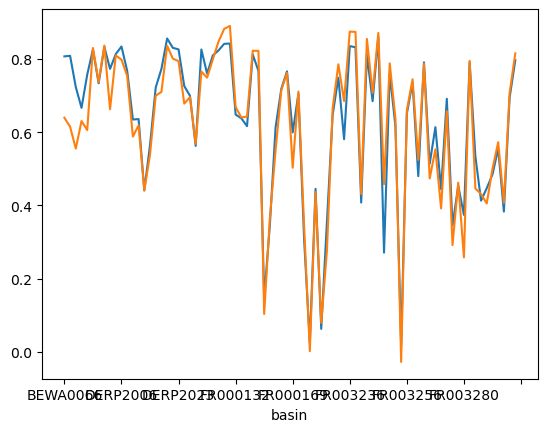

In [237]:
data_diff_filtered[data_diff_filtered.nse_r1>0].nse_r1.plot()
data_diff_filtered[data_diff_filtered.nse_r1>0].nse_g1.plot()

In [239]:
len(diff_nse[diff_nse.nse>-0.01])

63

In [241]:
diff_nse[diff_nse.nse>0.01]

nse
basin             
BEWA0066  0.167390
BEWA0067  0.193536
BEWA0106  0.167727
BEWA0107  0.035965
BEWA0119  0.151194
DERP2003  0.050876
DERP2004  0.110107
DERP2006  0.035780
DERP2008  0.013830
DERP2010  0.046541
DERP2011  0.016886
DERP2013  0.108496
DERP2015  0.025853
DERP2016  0.022326
DERP2017  0.054679
DERP2018  0.062674
DERP2021  0.019926
DERP2022  0.029516
DERP2023  0.032050
DERP2024  0.026336
DERP2027  0.047868
DERP2030  0.060306
DERP2031  0.011055
DERP2033  0.031915
DERP2036  0.010884
FR000144  0.043214
FR000154  0.062437
FR000169  0.096364
FR000183  0.023761
FR000190  0.078781
FR003254  0.045254
FR003266  0.039990
FR003267  0.060563
FR003268  0.052444
FR003271  0.033910
FR003274  0.053355
FR003280  0.115986
FR003288  0.088184
FR003294  0.041632
FR003303  0.064582
FR003306  0.073174

array([[<Axes: title={'center': 'nse'}>]], dtype=object)

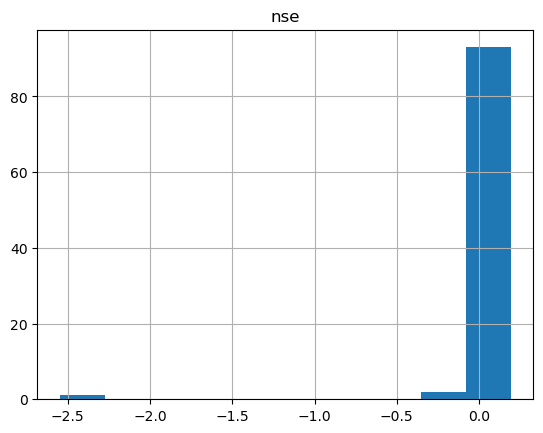

In [242]:
diff_nse.hist()

In [248]:
nse_values_1

array([-1.46838474, -1.20818911, -1.03612423, -0.01577652,  0.01845536,
        0.02622331,  0.0633557 ,  0.1472098 ,  0.27128943,  0.3068598 ,
        0.34538905,  0.34688087,  0.35591822,  0.37441615,  0.38340016,
        0.40793187,  0.4132383 ,  0.44130699,  0.44442589,  0.44537405,
        0.44727333,  0.45399983,  0.48004662,  0.48456453,  0.51379135,
        0.53458328,  0.55546673,  0.56263412,  0.56464315,  0.58081249,
        0.59942555,  0.61331005,  0.61373014,  0.61607967,  0.61647164,
        0.63457443,  0.63577214,  0.63779524,  0.64750666,  0.64810929,
        0.65084866,  0.66636355,  0.6846377 ,  0.69127752,  0.69397532,
        0.69945073,  0.70527382,  0.71820732,  0.72188304,  0.7229472 ,
        0.72590068,  0.73334061,  0.73574159,  0.74865538,  0.75692297,
        0.75976534,  0.75984639,  0.76598208,  0.76712691,  0.76747808,
        0.77260141,  0.7727238 ,  0.79066031,  0.79090087,  0.7963871 ,
        0.80686359,  0.80829514,  0.80934442,  0.8110198 ,  0.81

In [249]:
nse_values_2

array([-1.57688076, -1.28136263, -1.10070669, -0.02679889,  0.00246192,
        0.0455029 ,  0.07966628,  0.10399551,  0.25843009,  0.27713703,
        0.29203387,  0.34305616,  0.3659057 ,  0.39198198,  0.40564097,
        0.40734512,  0.43102964,  0.43142482,  0.43628653,  0.44075912,
        0.44639897,  0.45809818,  0.46227414,  0.47380109,  0.50013334,
        0.50306151,  0.52428869,  0.53878993,  0.55087325,  0.553167  ,
        0.55521981,  0.56820852,  0.5723912 ,  0.58803296,  0.60572868,
        0.6147596 ,  0.61888595,  0.63039871,  0.63662163,  0.63947327,
        0.64009783,  0.64263341,  0.65736756,  0.6598865 ,  0.66261674,
        0.66549122,  0.66904172,  0.67803262,  0.68492852,  0.69561751,
        0.69955655,  0.70682106,  0.70740998,  0.70992697,  0.71084888,
        0.71396881,  0.73653136,  0.74429131,  0.74879124,  0.75364773,
        0.76193139,  0.76535293,  0.78512067,  0.78686223,  0.78787597,
        0.7938453 ,  0.79474485,  0.79808984,  0.79846079,  0.80

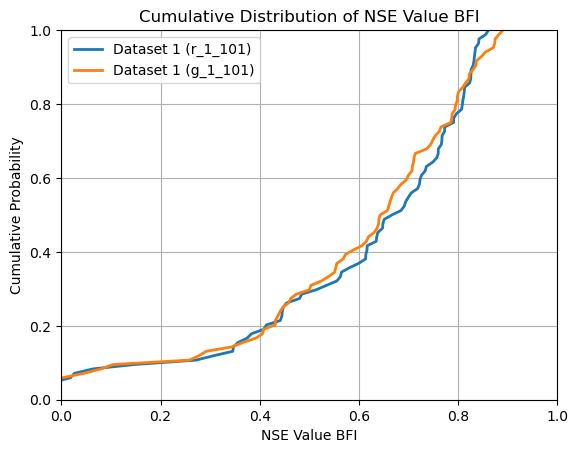

In [247]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_filtered["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_filtered["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="Dataset 1 (g_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


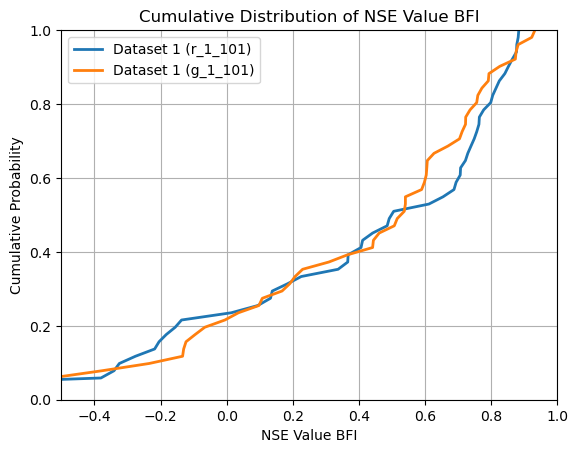

In [250]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_filtered["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_filtered["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="Dataset 1 (g_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(-0.5, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


(0.2, 1.0)

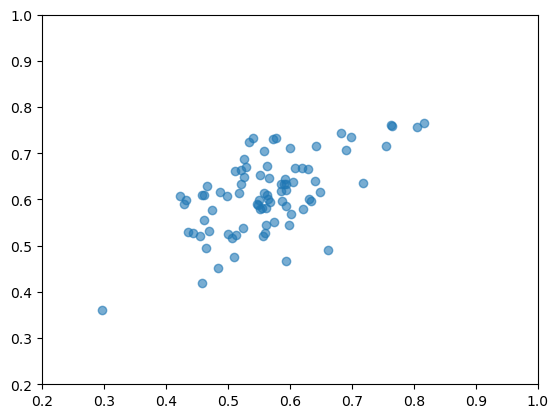

In [251]:
# Create scatter plot
plt.scatter(data_diff_filtered["bfi_obs"], data_diff_filtered["bfi_r1"], alpha=0.6)
# Set limits (adjust according to your data range)
plt.xlim([0.2, 1])
plt.ylim([0.2, 1])


(0.2, 1.0)

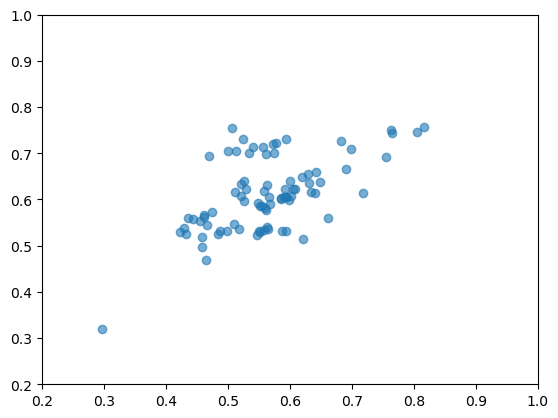

In [252]:
# Create scatter plot
plt.scatter(data_diff_filtered["bfi_obs"], data_diff_filtered["bfi_g1"], alpha=0.6)
# Set limits (adjust according to your data range)
plt.xlim([0.2, 1])
plt.ylim([0.2, 1])


In [271]:
data_diff_filtered.corr()

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
nse         1.000000 -0.141446 -0.276349   -0.316726   -0.464330  0.029086   
nse_r1     -0.141446  1.000000  0.990483    0.941856    0.946226 -0.551979   
nse_g1     -0.276349  0.990483  1.000000    0.931865    0.953534 -0.539915   
nse_bfi_r1 -0.316726  0.941856  0.931865    1.000000    0.976909 -0.453336   
nse_bfi_g1 -0.464330  0.946226  0.953534    0.976909    1.000000 -0.490296   
bfi_obs     0.029086 -0.551979 -0.539915   -0.453336   -0.490296  1.000000   
bfi_r1     -0.020384 -0.492538 -0.475330   -0.594843   -0.532697  0.617507   
bfi_g1      0.240967 -0.306343 -0.330905   -0.282119   -0.331000  0.600285   

              bfi_r1    bfi_g1  
nse        -0.020384  0.240967  
nse_r1     -0.492538 -0.306343  
nse_g1     -0.475330 -0.330905  
nse_bfi_r1 -0.594843 -0.282119  
nse_bfi_g1 -0.532697 -0.331000  
bfi_obs     0.617507  0.600285  
bfi_r1      1.000000  0.550984  
bfi_g1      0.550984  1.000000

In [284]:
data_diff_filtered["nse_rel"] = 100*(data_diff_filtered.nse_r1 - data_diff_filtered.nse_g1)/abs(data_diff_filtered.nse_r1)

In [285]:
data_diff_filtered

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
basin                                                                      
BEWA0066  0.167390  0.806864  0.639473         NaN         NaN  0.524659   
BEWA0067  0.193536  0.808295  0.614760         NaN         NaN  0.469727   
BEWA0106  0.167727  0.722947  0.555220         NaN         NaN  0.506445   
BEWA0107  0.035965  0.666364  0.630399         NaN         NaN  0.557155   
BEWA0119  0.151194  0.756923  0.605729         NaN         NaN  0.513078   
...            ...       ...       ...         ...         ...       ...   
FR003300 -0.023945  0.383400  0.407345   -0.340905   -0.123153  0.526066   
FR003302 -0.012846  0.693975  0.706821         NaN         NaN  0.525576   
FR003303  0.064582 -1.036124 -1.100707         NaN         NaN  0.804400   
FR003306  0.073174 -1.208189 -1.281363         NaN         NaN  0.764163   
FR003307 -0.018644  0.796387  0.815031    0.693610    0.759342  0.498878   

            bfi_r1    bfi_g1    nse_rel  
basin                                    
BEWA0066  0.537470  0.731061  20.745802  
BEWA0067  0.532118  0.694890  23.943673  
BEWA0106  0.516130  0.753910  23.200503  
BEWA0107  0.520524  0.712623   5.397180  
BEWA0119  0.522414  0.704171  19.974858  
...            ...       ...        ...  
FR003300  0.687585  0.640331  -6.245424  
FR003302  0.649398  0.596783  -1.851037  
FR003303  0.756099  0.745694   6.233081  
FR003306  0.759128  0.744949   6.056463  
FR003307  0.606892  0.532649  -2.341064  

[84 rows x 9 columns]

In [288]:
len(data_diff_filtered[data_diff_filtered.nse_rel>0])


44

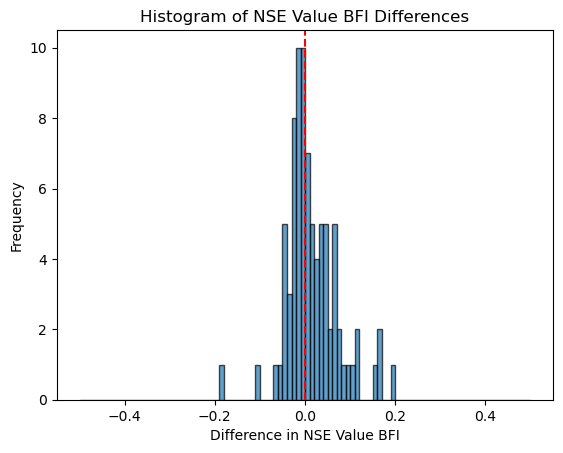

In [270]:
import numpy as np

# Define the bin edges, ensuring a clear separation at zero
min_val = -0.5  # Adjust based on your data range
max_val = 0.5   # Adjust based on your data range
bin_width = 0.01  # Adjust bin width for better separation

# Generate bins from min_val to max_val with defined bin width
bins = np.arange(min_val, max_val + bin_width, bin_width)

# Ensure zero is explicitly included as a bin boundary
bins = np.unique(np.append(bins, 0))


# Plot histogram
plt.hist(data_diff_filtered.nse, bins=bins, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("Difference in NSE Value BFI")
plt.ylabel("Frequency")
plt.title("Histogram of NSE Value BFI Differences")

# Add vertical line at zero for clarity
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5)
#plt.axvline(-0.05, color='red', linestyle='dashed', linewidth=1.5)
#plt.axvline(0.05, color='red', linestyle='dashed', linewidth=1.5)

plt.show()

In [274]:
data_diff_filtered[0:50]

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
basin                                                                      
BEWA0066  0.167390  0.806864  0.639473         NaN         NaN  0.524659   
BEWA0067  0.193536  0.808295  0.614760         NaN         NaN  0.469727   
BEWA0106  0.167727  0.722947  0.555220         NaN         NaN  0.506445   
BEWA0107  0.035965  0.666364  0.630399         NaN         NaN  0.557155   
BEWA0119  0.151194  0.756923  0.605729         NaN         NaN  0.513078   
DEBU1956 -0.004344  0.825392  0.829736    0.748375    0.791027  0.586521   
DEBU1957 -0.003191  0.733341  0.736531    0.336793    0.443577  0.608043   
DEBU1959 -0.003665  0.832684  0.836349    0.756160    0.771659  0.604452   
DERP2004  0.110107  0.772724  0.662617    0.763994    0.229497  0.500469   
DERP2005  0.003761  0.813034  0.809273    0.777055    0.722695  0.444113   
DERP2006  0.035780  0.833870  0.798090    0.798279    0.735913  0.435240   
DERP2008  0.013830  0.767478  0.753648    0.762697    0.668857  0.455357   
DERP2010  0.046541  0.634574  0.588033    0.183733    0.167291  0.594413   
DERP2011  0.016886  0.635772  0.618886    0.093962    0.206687  0.567073   
DERP2013  0.108496 -1.468385 -1.576881   -3.954988   -4.125047  0.816321   
DERP2014  0.000548  0.441307  0.440759   -0.324849   -0.234585  0.698751   
DERP2015  0.025853  0.564643  0.538790    0.013835   -0.005571  0.690642   
DERP2016  0.022326  0.721883  0.699557    0.611313    0.605047  0.640644   
DERP2018  0.062674  0.772601  0.709927    0.729039    0.365533  0.561710   
DERP2021  0.019926  0.855661  0.835735    0.841036    0.793011  0.462274   
DERP2022  0.029516  0.830184  0.800667    0.738612    0.606563  0.551997   
DERP2023  0.032050  0.825896  0.793845    0.706094    0.589388  0.548204   
DERP2027  0.047868  0.725901  0.678033    0.410919    0.308771  0.585400   
DERP2028  0.003833  0.699451  0.695618    0.441232    0.461035  0.577985   
DERP2029 -0.005574  0.562634  0.568209   -0.155845   -0.095398  0.572942   
DERP2030  0.060306  0.825659  0.765353    0.863728    0.626811  0.593089   
DERP2031  0.011055  0.759846  0.748791    0.814355    0.540327  0.574433   
DERP2036  0.010884  0.809344  0.798461    0.707229    0.711906  0.473795   
FR000124 -0.024006  0.823109  0.847115         NaN         NaN  0.457513   
FR000125 -0.040897  0.841061  0.881958    0.852019    0.922424  0.484163   
FR000128 -0.048023  0.841907  0.889930    0.876301    0.932038  0.509667   
FR000132 -0.020932  0.648109  0.669042    0.687240    0.597761  0.634710   
FR000137 -0.002303  0.637795  0.640098         NaN         NaN  0.486635   
FR000138 -0.026162  0.616472  0.642633         NaN         NaN  0.433013   
FR000140 -0.010048  0.812194  0.822242         NaN         NaN  0.554309   
FR000142 -0.054666  0.767127  0.821793    0.824363    0.825666  0.597900   
FR000144  0.043214  0.147210  0.103996    0.137753    0.097305  0.683309   
FR000153 -0.019025  0.346881  0.365906         NaN         NaN  0.641609   
FR000154  0.062437  0.613310  0.550873   -0.275961   -0.531544  0.562982   
FR000156  0.004239  0.718207  0.713969    0.485170    0.515630  0.619015   
FR000159  0.004051  0.765982  0.761931         NaN         NaN  0.592704   
FR000169  0.096364  0.599426  0.503062    0.132319   -0.066409  0.593044   
FR000171 -0.005575  0.705274  0.710849    0.367097    0.536872  0.517493   
FR000174 -0.036196  0.306860  0.343056         NaN         NaN  0.461448   
FR000183  0.023761  0.026223  0.002462         NaN         NaN  0.755242   
FR000184  0.009088  0.445374  0.436287         NaN         NaN  0.762358   
FR000185 -0.016311  0.063356  0.079666         NaN         NaN  0.540807   
FR000190  0.078781  0.355918  0.277137         NaN         NaN  0.464542   
FR000200 -0.017985  0.647507  0.665491         NaN         NaN  0.458949   
FR000201 -0.036465  0.748655  0.785121         NaN         NaN  0.423244   

            bfi_r1    bfi_g1  
basin                         


In [34]:
(nse_results_cal_r_1_100new.nse - nse_results_cal_c_1_100.nse).describe()

count    112.000000
mean       0.029636
std        0.142881
min       -0.262914
25%       -0.022639
50%        0.005403
75%        0.046469
max        1.212900
Name: nse, dtype: float64

<Axes: >

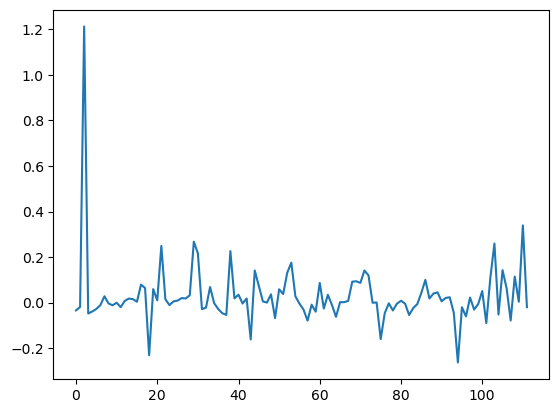

In [35]:
(nse_results_cal_r_1_100new.nse - nse_results_cal_c_1_100.nse).plot()

In [36]:
nse_results_cal_r_1_100new.nse - nse_results_cal_c_1_100.nse

0     -0.034058
1     -0.019116
2      1.212900
3     -0.047748
4     -0.038995
         ...   
107   -0.078411
108    0.114346
109    0.003912
110    0.339001
111   -0.020063
Name: nse, Length: 112, dtype: float64

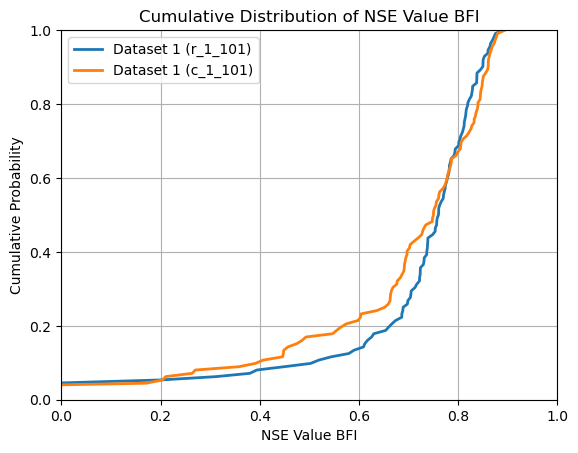

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(nse_results_cal_r_1_100new["nse"].dropna())
nse_values_2 = np.sort(nse_results_cal_c_1_100["nse"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="Dataset 1 (c_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


In [38]:
nse_results_cal_r_1_100new.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_2192\3595499100.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_cal_r_1_100new.corr()


nse  q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  \
nse            1.000000    0.168941    -0.029170 -0.215340  0.060367   
q_mean_obs     0.168941    1.000000     0.931098  0.018471 -0.235618   
q_mean_calc   -0.029170    0.931098     1.000000  0.062759 -0.192258   
bfi_obs       -0.215340    0.018471     0.062759  1.000000  0.662429   
bfi_sim        0.060367   -0.235618    -0.192258  0.662429  1.000000   
nse_value_bfi  0.979664    0.313354     0.188563 -0.597295 -0.572605   

               nse_value_bfi  
nse                 0.979664  
q_mean_obs          0.313354  
q_mean_calc         0.188563  
bfi_obs            -0.597295  
bfi_sim            -0.572605  
nse_value_bfi       1.000000

In [39]:
nse_results_cal_c_1_100.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_2192\2472616189.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_cal_c_1_100.corr()


nse  q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  \
nse            1.000000    0.175438    -0.025552 -0.211082  0.036121   
q_mean_obs     0.175438    1.000000     0.930912  0.018471 -0.283107   
q_mean_calc   -0.025552    0.930912     1.000000  0.067473 -0.263041   
bfi_obs       -0.211082    0.018471     0.067473  1.000000  0.511163   
bfi_sim        0.036121   -0.283107    -0.263041  0.511163  1.000000   
nse_value_bfi  0.978942    0.373807     0.253316 -0.540493 -0.636173   

               nse_value_bfi  
nse                 0.978942  
q_mean_obs          0.373807  
q_mean_calc         0.253316  
bfi_obs            -0.540493  
bfi_sim            -0.636173  
nse_value_bfi       1.000000

(0.2, 1.0)

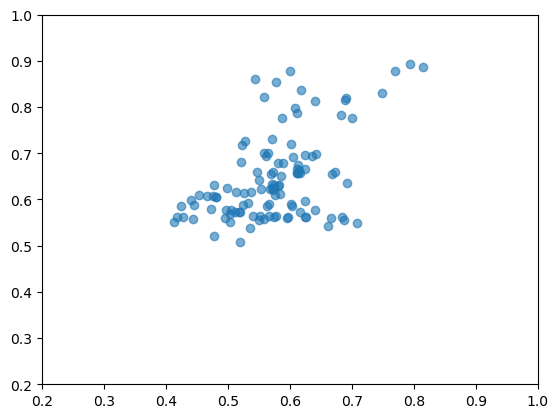

In [41]:
# Create scatter plot
plt.scatter(nse_results_cal_c_1_100["bfi_obs"], nse_results_cal_c_1_100["bfi_sim"], alpha=0.6)
# Set limits (adjust according to your data range)
plt.xlim([0.2, 1])
plt.ylim([0.2, 1])


(0.2, 1.0)

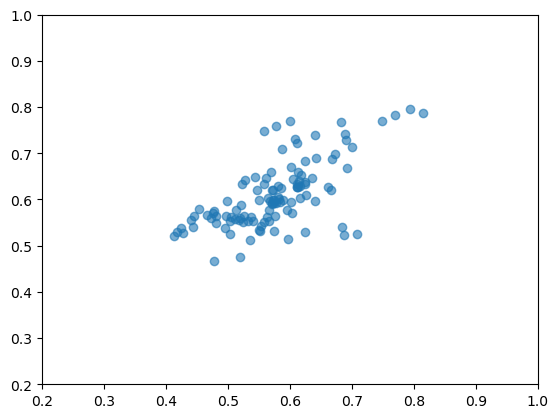

In [42]:
# Create scatter plot
plt.scatter(nse_results_cal_r_1_100new["bfi_obs"], nse_results_cal_r_1_100new["bfi_sim"], alpha=0.6)
# Set limits (adjust according to your data range)
plt.xlim([0.2, 1])
plt.ylim([0.2, 1])


In [395]:
(nse_results_cal_r_1_100new.nse - nse_results_cal_r_1_100.nse).describe()

count    112.000000
mean       0.073400
std        0.356939
min       -0.188411
25%       -0.015980
50%        0.014002
75%        0.055499
max        3.579795
Name: nse, dtype: float64

In [390]:
nse_results_cal_r_1_100

gauge_name     basin        nse  q_mean_obs  q_mean_calc   bfi_obs  \
0          Reuland  BEWA0066   0.854251    1.224479     1.256973  0.511429   
1       Schoenberg  BEWA0067   0.817540    1.397246     1.368878  0.443161   
2       Martelange  BEWA0087 -22.138351    0.192824     1.294631  0.708779   
3          Reuland  BEWA0106   0.784851    0.986279     0.960577  0.473400   
4    Lommersweiler  BEWA0107   0.710222    1.134366     1.353938  0.565604   
..             ...       ...        ...         ...          ...       ...   
107       Michelau  LU000015   0.777325    1.020046     1.082639  0.517760   
108    Pfaffenthal  LU000016   0.578302    0.791896     0.775268  0.563590   
109        Rosport  LU000017   0.847484    0.925885     0.948822  0.574924   
110     Schoenfels  LU000018   0.505225    0.868880     0.830806  0.543259   
111        Vianden  LU000019   0.826281    1.141633     1.164120  0.497731   

      bfi_sim  nse_value_bfi  
0    0.536961       0.862749  
1    0.516039       0.804881  
2    0.499492            NaN  
3    0.531573            NaN  
4    0.546458            NaN  
..        ...            ...  
107  0.528522       0.817543  
108  0.631009       0.065874  
109  0.603419       0.792463  
110  0.688607      -0.117379  
111  0.543155       0.852590  

[112 rows x 8 columns]

In [396]:
nse_results_cal_r_1_100new

gauge_name     basin        nse  q_mean_obs  q_mean_calc   bfi_obs  \
0          Reuland  BEWA0066   0.826402    1.224479     1.127816  0.511429   
1       Schoenberg  BEWA0067   0.776418    1.397246     1.226372  0.443161   
2       Martelange  BEWA0087 -18.558555    0.192824     1.176069  0.708779   
3          Reuland  BEWA0106   0.738859    0.986279     0.875000  0.473400   
4    Lommersweiler  BEWA0107   0.723577    1.134366     1.211335  0.565604   
..             ...       ...        ...         ...          ...       ...   
107       Michelau  LU000015   0.753774    1.020046     0.986005  0.517760   
108    Pfaffenthal  LU000016   0.688915    0.791896     0.717942  0.563590   
109        Rosport  LU000017   0.852524    0.925885     0.867238  0.574924   
110     Schoenfels  LU000018   0.609091    0.868880     0.768449  0.543259   
111        Vianden  LU000019   0.805395    1.141633     1.047428  0.497731   

      bfi_sim  nse_value_bfi  
0    0.557320       0.823303  
1    0.540013       0.765821  
2    0.525158            NaN  
3    0.560178            NaN  
4    0.553497            NaN  
..        ...            ...  
107  0.555506       0.778332  
108  0.562215       0.497113  
109  0.598715       0.871139  
110  0.649665       0.410972  
111  0.564138       0.838583  

[112 rows x 8 columns]

In [259]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_cal_g_1_100 = pd.DataFrame(nse_results_cal)
nse_results_cal_g_1_100

gauge_name     basin        nse  q_mean_obs  q_mean_calc   bfi_obs  \
0          Reuland  BEWA0066   0.642392    1.224479     1.268288  0.511429   
1       Schoenberg  BEWA0067   0.596098    1.397246     1.380754  0.443161   
2       Martelange  BEWA0087 -20.878100    0.192824     1.307553  0.708779   
3          Reuland  BEWA0106   0.457659    0.986279     0.969356  0.473400   
4    Lommersweiler  BEWA0107   0.519366    1.134366     1.366640  0.565604   
..             ...       ...        ...         ...          ...       ...   
107       Michelau  LU000015   0.555488    1.020046     1.093444  0.517760   
108    Pfaffenthal  LU000016   0.512570    0.791896     0.773394  0.563590   
109        Rosport  LU000017   0.782081    0.925885     0.953830  0.574924   
110     Schoenfels  LU000018   0.490814    0.868880     0.827560  0.543259   
111        Vianden  LU000019   0.661456    1.141633     1.174193  0.497731   

      bfi_sim  nse_value_bfi  
0    0.744971       0.329851  
1    0.709724       0.180423  
2    0.761177            NaN  
3    0.779904            NaN  
4    0.766565            NaN  
..        ...            ...  
107  0.778373       0.133033  
108  0.543922      -0.426002  
109  0.686860       0.637799  
110  0.541001      -0.581351  
111  0.722829       0.345047  

[112 rows x 8 columns]

In [212]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_cal_r_1_100 = pd.DataFrame(nse_results_cal)
nse_results_cal_r_1_100

gauge_name     basin        nse  q_mean_obs  q_mean_calc   bfi_obs  \
0          Reuland  BEWA0066   0.854251    1.224479     1.256973  0.511429   
1       Schoenberg  BEWA0067   0.817540    1.397246     1.368878  0.443161   
2       Martelange  BEWA0087 -22.138351    0.192824     1.294631  0.708779   
3          Reuland  BEWA0106   0.784851    0.986279     0.960577  0.473400   
4    Lommersweiler  BEWA0107   0.710222    1.134366     1.353938  0.565604   
..             ...       ...        ...         ...          ...       ...   
107       Michelau  LU000015   0.777325    1.020046     1.082639  0.517760   
108    Pfaffenthal  LU000016   0.578302    0.791896     0.775268  0.563590   
109        Rosport  LU000017   0.847484    0.925885     0.948822  0.574924   
110     Schoenfels  LU000018   0.505225    0.868880     0.830806  0.543259   
111        Vianden  LU000019   0.826281    1.141633     1.164120  0.497731   

      bfi_sim  nse_value_bfi  
0    0.536961       0.862749  
1    0.516039       0.804881  
2    0.499492            NaN  
3    0.531573            NaN  
4    0.546458            NaN  
..        ...            ...  
107  0.528522       0.817543  
108  0.631009       0.065874  
109  0.603419       0.792463  
110  0.688607      -0.117379  
111  0.543155       0.852590  

[112 rows x 8 columns]

In [213]:
nse_results_cal_r_1_100.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_21372\1102396303.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_cal_r_1_100.corr()


nse  q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  \
nse            1.000000    0.181169    -0.021887 -0.232256  0.097503   
q_mean_obs     0.181169    1.000000     0.930758  0.018471 -0.460689   
q_mean_calc   -0.021887    0.930758     1.000000  0.069763 -0.434154   
bfi_obs       -0.232256    0.018471     0.069763  1.000000  0.548581   
bfi_sim        0.097503   -0.460689    -0.434154  0.548581  1.000000   
nse_value_bfi  0.983584    0.376575     0.241595 -0.628074 -0.597690   

               nse_value_bfi  
nse                 0.983584  
q_mean_obs          0.376575  
q_mean_calc         0.241595  
bfi_obs            -0.628074  
bfi_sim            -0.597690  
nse_value_bfi       1.000000

In [260]:
data_diff_cal = pd.DataFrame(data=nse_results_cal_r_1_100.nse - nse_results_cal_g_1_100.nse)
data_diff_cal.index = nse_results_cal_r_1_100.basin
data_diff_cal_filtered = data_diff_cal.loc[~data_diff_cal.index.isin(first_half_df.index.tolist())]
data_diff_cal_filtered["nse_r1"] = nse_results_cal_r_1_100.set_index("basin", inplace = False).nse
data_diff_cal_filtered["nse_g1"] = nse_results_cal_g_1_100.set_index("basin", inplace = False).nse
data_diff_cal_filtered["nse_bfi_r1"] = nse_results_cal_r_1_100.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal_filtered["nse_bfi_g1"] = nse_results_cal_g_1_100.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal_filtered["bfi_obs"] = nse_results_cal_g_1_100.set_index("basin", inplace = False).bfi_obs
data_diff_cal_filtered["bfi_r1"] = nse_results_cal_r_1_100.set_index("basin", inplace = False).bfi_sim
data_diff_cal_filtered["bfi_g1"] = nse_results_cal_g_1_100.set_index("basin", inplace = False).bfi_sim

data_diff_cal_filtered = data_diff_cal_filtered[data_diff_cal_filtered.nse_r1 > -20.0]
data_diff_cal_filtered

C:\Users\nascimth\AppData\Local\Temp\ipykernel_21372\931747699.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_diff_cal_filtered["nse_r1"] = nse_results_cal_r_1_100.set_index("basin", inplace = False).nse
C:\Users\nascimth\AppData\Local\Temp\ipykernel_21372\931747699.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_diff_cal_filtered["nse_g1"] = nse_results_cal_g_1_100.set_index("basin", inplace = False).nse
C:\Users\nascimth\AppData\Local\Temp\ipykernel_21372\931747699.py:6: SettingWithCopy

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
basin                                                                      
BEWA0066  0.211860  0.854251  0.642392    0.862749    0.329851  0.511429   
BEWA0067  0.221442  0.817540  0.596098    0.804881    0.180423  0.443161   
BEWA0106  0.327192  0.784851  0.457659         NaN         NaN  0.473400   
BEWA0107  0.190856  0.710222  0.519366         NaN         NaN  0.565604   
BEWA0119  0.214676  0.832906  0.618230         NaN         NaN  0.503286   
...            ...       ...       ...         ...         ...       ...   
LU000015  0.221837  0.777325  0.555488    0.817543    0.133033  0.517760   
LU000016  0.065732  0.578302  0.512570    0.065874   -0.426002  0.563590   
LU000017  0.065403  0.847484  0.782081    0.792463    0.637799  0.574924   
LU000018  0.014411  0.505225  0.490814   -0.117379   -0.581351  0.543259   
LU000019  0.164825  0.826281  0.661456    0.852590    0.345047  0.497731   

            bfi_r1    bfi_g1  
basin                         
BEWA0066  0.536961  0.744971  
BEWA0067  0.516039  0.709724  
BEWA0106  0.531573  0.779904  
BEWA0107  0.546458  0.766565  
BEWA0119  0.533011  0.735409  
...            ...       ...  
LU000015  0.528522  0.778373  
LU000016  0.631009  0.543922  
LU000017  0.603419  0.686860  
LU000018  0.688607  0.541001  
LU000019  0.543155  0.722829  

[100 rows x 8 columns]

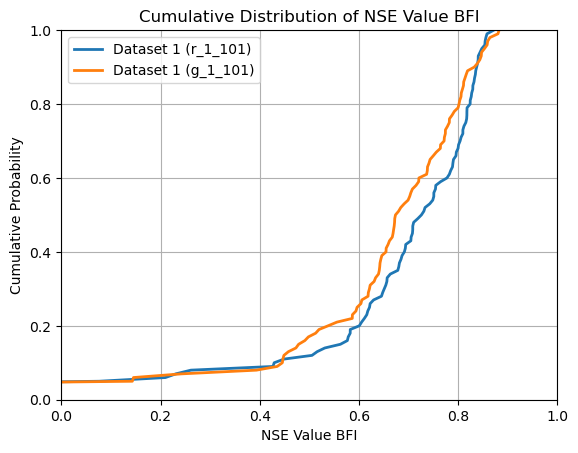

In [263]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_filtered["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_filtered["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="Dataset 1 (g_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


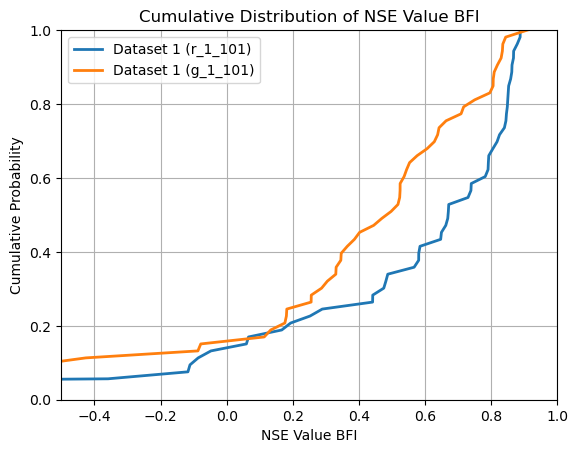

In [264]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_filtered["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_filtered["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="Dataset 1 (g_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(-0.5, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


(0.2, 1.0)

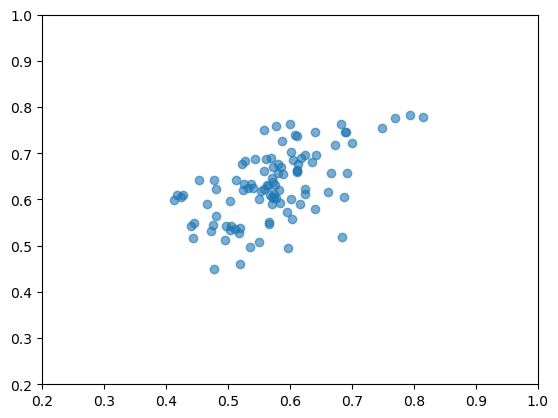

In [265]:
# Create scatter plot
plt.scatter(data_diff_cal_filtered["bfi_obs"], data_diff_cal_filtered["bfi_r1"], alpha=0.6)
# Set limits (adjust according to your data range)
plt.xlim([0.2, 1])
plt.ylim([0.2, 1])


In [335]:
data_diff_cal_filtered

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
basin                                                                      
BEWA0066  0.211860  0.854251  0.642392    0.862749    0.329851  0.511429   
BEWA0067  0.221442  0.817540  0.596098    0.804881    0.180423  0.443161   
BEWA0106  0.327192  0.784851  0.457659         NaN         NaN  0.473400   
BEWA0107  0.190856  0.710222  0.519366         NaN         NaN  0.565604   
BEWA0119  0.214676  0.832906  0.618230         NaN         NaN  0.503286   
...            ...       ...       ...         ...         ...       ...   
LU000015  0.221837  0.777325  0.555488    0.817543    0.133033  0.517760   
LU000016  0.065732  0.578302  0.512570    0.065874   -0.426002  0.563590   
LU000017  0.065403  0.847484  0.782081    0.792463    0.637799  0.574924   
LU000018  0.014411  0.505225  0.490814   -0.117379   -0.581351  0.543259   
LU000019  0.164825  0.826281  0.661456    0.852590    0.345047  0.497731   

            bfi_r1    bfi_g1  
basin                         
BEWA0066  0.536961  0.744971  
BEWA0067  0.516039  0.709724  
BEWA0106  0.531573  0.779904  
BEWA0107  0.546458  0.766565  
BEWA0119  0.533011  0.735409  
...            ...       ...  
LU000015  0.528522  0.778373  
LU000016  0.631009  0.543922  
LU000017  0.603419  0.686860  
LU000018  0.688607  0.541001  
LU000019  0.543155  0.722829  

[100 rows x 8 columns]

(0.2, 1.0)

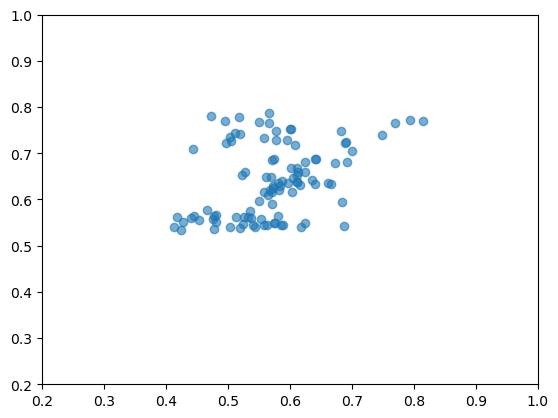

In [337]:
# Create scatter plot
plt.scatter(data_diff_cal_filtered["bfi_obs"], data_diff_cal_filtered["bfi_g1"], alpha=0.6)
# Set limits (adjust according to your data range)
plt.xlim([0.2, 1])
plt.ylim([0.2, 1])


In [267]:
data_diff_cal_filtered.corr()

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
nse         1.000000  0.036329 -0.193051    0.048995   -0.212068 -0.169681   
nse_r1      0.036329  1.000000  0.973528    0.983596    0.928035 -0.488624   
nse_g1     -0.193051  0.973528  1.000000    0.956225    0.956568 -0.440939   
nse_bfi_r1  0.048995  0.983596  0.956225    1.000000    0.948224 -0.657843   
nse_bfi_g1 -0.212068  0.928035  0.956568    0.948224    1.000000 -0.551375   
bfi_obs    -0.169681 -0.488624 -0.440939   -0.657843   -0.551375  1.000000   
bfi_r1     -0.302708 -0.466561 -0.388852   -0.607885   -0.444669  0.592381   
bfi_g1      0.438905 -0.191073 -0.287989   -0.129658   -0.184088  0.394621   

              bfi_r1    bfi_g1  
nse        -0.302708  0.438905  
nse_r1     -0.466561 -0.191073  
nse_g1     -0.388852 -0.287989  
nse_bfi_r1 -0.607885 -0.129658  
nse_bfi_g1 -0.444669 -0.184088  
bfi_obs     0.592381  0.394621  
bfi_r1      1.000000  0.200732  
bfi_g1      0.200732  1.000000

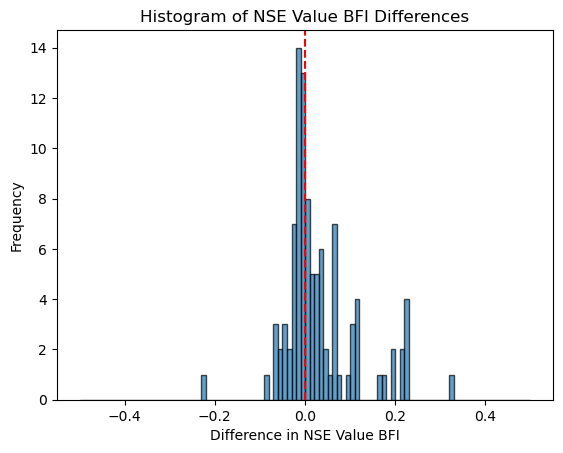

In [269]:
import numpy as np

# Define the bin edges, ensuring a clear separation at zero
min_val = -0.5  # Adjust based on your data range
max_val = 0.5   # Adjust based on your data range
bin_width = 0.01  # Adjust bin width for better separation

# Generate bins from min_val to max_val with defined bin width
bins = np.arange(min_val, max_val + bin_width, bin_width)

# Ensure zero is explicitly included as a bin boundary
bins = np.unique(np.append(bins, 0))


# Plot histogram
plt.hist(data_diff_cal_filtered.nse, bins=bins, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("Difference in NSE Value BFI")
plt.ylabel("Frequency")
plt.title("Histogram of NSE Value BFI Differences")

# Add vertical line at zero for clarity
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5)
#plt.axvline(-0.05, color='red', linestyle='dashed', linewidth=1.5)
#plt.axvline(0.05, color='red', linestyle='dashed', linewidth=1.5)

plt.show()


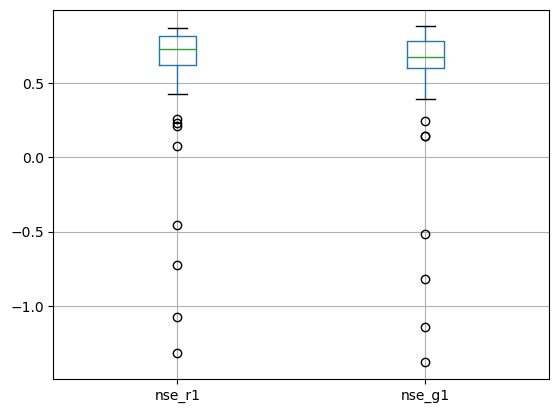

In [342]:
import matplotlib.pyplot as plt

# Plot both columns side by side
data_diff_cal_filtered.boxplot(column=["nse_r1", "nse_g1"])

# Show the plot
plt.show()


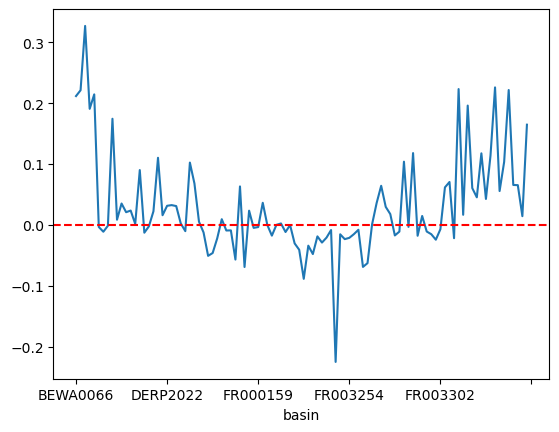

In [345]:
data_diff_cal_filtered.nse.plot()
plt.axhline(0, color='red', linestyle='dashed', linewidth=1.5)


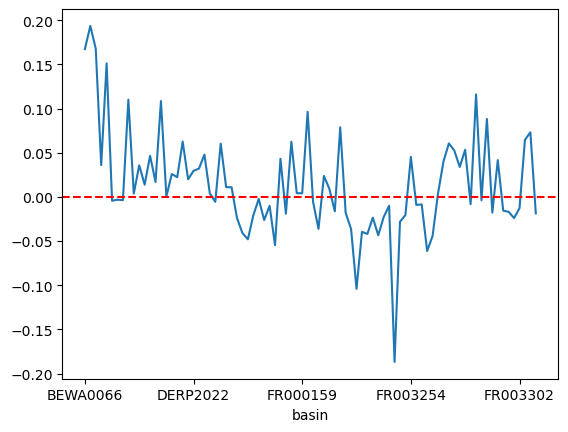

In [346]:
data_diff_filtered.nse.plot()
plt.axhline(0, color='red', linestyle='dashed', linewidth=1.5)


In [349]:
data_diff_cal_filtered[0:50]

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
basin                                                                      
BEWA0066  0.211860  0.854251  0.642392    0.862749    0.329851  0.511429   
BEWA0067  0.221442  0.817540  0.596098    0.804881    0.180423  0.443161   
BEWA0106  0.327192  0.784851  0.457659         NaN         NaN  0.473400   
BEWA0107  0.190856  0.710222  0.519366         NaN         NaN  0.565604   
BEWA0119  0.214676  0.832906  0.618230         NaN         NaN  0.503286   
DEBU1956 -0.003361  0.835360  0.838721    0.790293    0.806024  0.610835   
DEBU1957 -0.011154  0.790467  0.801621    0.584477    0.627775  0.605700   
DEBU1959 -0.001363  0.858038  0.859401    0.824987    0.829829  0.611554   
DERP2004  0.174577  0.829366  0.654788    0.848542    0.286913  0.504991   
DERP2005  0.008622  0.800753  0.792130    0.845874    0.833592  0.444863   
DERP2006  0.035220  0.809418  0.774198    0.839698    0.808959  0.440082   
DERP2008  0.020940  0.824079  0.803139    0.858603    0.834898  0.476558   
DERP2010  0.023655  0.725838  0.702183    0.481253    0.444243  0.570918   
DERP2011  0.001676  0.681465  0.679789    0.251892    0.346202  0.557702   
DERP2013  0.090208 -0.728581 -0.818789   -2.892896   -3.080015  0.814322   
DERP2014 -0.012756  0.617729  0.630485    0.193331    0.181630  0.688981   
DERP2015 -0.002333  0.718489  0.720822    0.649315    0.605877  0.673170   
DERP2016  0.022477  0.694193  0.671716    0.580672    0.524381  0.666009   
DERP2018  0.110416  0.853701  0.743284    0.844331    0.524212  0.578204   
DERP2021  0.015972  0.829585  0.813612    0.849826    0.818571  0.481239   
DERP2022  0.031479  0.795506  0.764027    0.662434    0.517771  0.571014   
DERP2023  0.032594  0.788496  0.755902    0.671360    0.543947  0.550072   
DERP2027  0.031004  0.704527  0.673522    0.566682    0.468988  0.564320   
DERP2028  0.002358  0.621189  0.618830    0.487010    0.497088  0.600504   
DERP2029 -0.010215  0.610810  0.621025    0.059418    0.113239  0.578087   
DERP2030  0.102503  0.840247  0.737744    0.878476    0.575849  0.602398   
DERP2031  0.068151  0.855843  0.787692    0.887298    0.708672  0.595343   
DERP2036  0.005303  0.811535  0.806232    0.781742    0.795628  0.466340   
FR000124 -0.012307  0.803797  0.816104         NaN         NaN  0.477466   
FR000125 -0.050807  0.796259  0.847065         NaN         NaN  0.519143   
FR000128 -0.046180  0.817842  0.864022         NaN         NaN  0.536009   
FR000132 -0.022048  0.515603  0.537651         NaN         NaN  0.661763   
FR000137  0.009437  0.708376  0.698938         NaN         NaN  0.525199   
FR000138 -0.009134  0.645290  0.654423         NaN         NaN  0.512441   
FR000140 -0.008957  0.844012  0.852968         NaN         NaN  0.568520   
FR000142 -0.056913  0.748720  0.805633    0.791201    0.805577  0.640180   
FR000144  0.063314 -0.455934 -0.519249         NaN         NaN  0.681845   
FR000153 -0.069142  0.600626  0.669768         NaN         NaN  0.640216   
FR000154  0.023500  0.707716  0.684216         NaN         NaN  0.532639   
FR000156 -0.004831  0.805802  0.810633    0.739506    0.749832  0.624213   
FR000159 -0.003487  0.815339  0.818826         NaN         NaN  0.612675   
FR000169  0.036423  0.678202  0.641778         NaN         NaN  0.576116   
FR000171 -0.000057  0.799699  0.799756         NaN         NaN  0.526791   
FR000174 -0.017580  0.428991  0.446571         NaN         NaN  0.412715   
FR000183  0.000134  0.764580  0.764446         NaN         NaN  0.699445   
FR000184  0.002446  0.693434  0.690987         NaN         NaN  0.769605   
FR000185 -0.011615  0.230712  0.242327         NaN         NaN  0.558059   
FR000190 -0.000176  0.782156  0.782333         NaN         NaN  0.635066   
FR000200 -0.030357  0.684668  0.715024         NaN         NaN  0.452847   
FR000201 -0.040811  0.730723  0.771534         NaN         NaN  0.425115   

            bfi_r1    bfi_g1  
basin                         


In [ ]:
#catchments_ids = estreams_attributes_clipped_filters.index.tolist()

In [108]:
nse_results_val_r_1_100[nse_results_val_r_1_100.nse > - 10].corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_21372\59946841.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_r_1_100[nse_results_val_r_1_100.nse > - 10].corr()


nse  q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  \
nse            1.000000    0.180819     0.244766 -0.535896 -0.480463   
q_mean_obs     0.180819    1.000000     0.932370  0.004430 -0.519339   
q_mean_calc    0.244766    0.932370     1.000000 -0.047693 -0.492660   
bfi_obs       -0.535896    0.004430    -0.047693  1.000000  0.615371   
bfi_sim       -0.480463   -0.519339    -0.492660  0.615371  1.000000   
nse_value_bfi  0.944016    0.339710     0.327440 -0.440007 -0.588428   

               nse_value_bfi  
nse                 0.944016  
q_mean_obs          0.339710  
q_mean_calc         0.327440  
bfi_obs            -0.440007  
bfi_sim            -0.588428  
nse_value_bfi       1.000000

(0.2, 1.0)

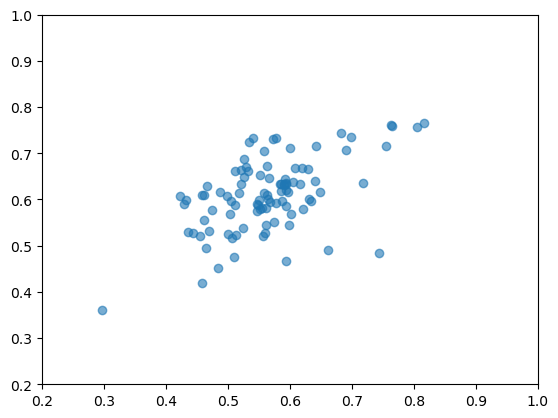

In [336]:
# Create scatter plot
plt.scatter(nse_results_val_r_1_100["bfi_obs"], nse_results_val_r_1_100["bfi_sim"], alpha=0.6)
# Set limits (adjust according to your data range)
plt.xlim([0.2, 1])
plt.ylim([0.2, 1])

In [122]:
nse_results_val_r_1_100[nse_results_val_r_1_100.nse < 0.5]

gauge_name     basin        nse  \
2                                          Martelange  BEWA0087 -27.333067   
18                                            Contwig  DERP2013  -1.468385   
19                                        Althornbach  DERP2014   0.441307   
43                                           A6232010  FR000144   0.147210   
44                                           A6701210  FR000153   0.346881   
50                                           A8122000  FR000174   0.306860   
51                                           A9001050  FR000183   0.026223   
52                                           A9013050  FR000184   0.445374   
53                                           A9021050  FR000185   0.063356   
54                                           A9251050  FR000190   0.355918   
60                                L'AviÃ¨re Ã  Frizon  FR003239   0.407932   
64                               La Meurthe Ã  Fraize  FR003250   0.271289   
68          La Vezouze Ã  BlÃ¢mont et Ã  FrÃ©monville  FR003254   0.018455   
71  L'ArentÃƒÂ¨le ÃƒÂ  Saint-Gorgon et ÃƒÂ  Sainte...  FR003259  -0.015777   
72                        La Mortagne Ã  GerbÃ©viller  FR003261   0.480047   
77         La Seille Ã  Moyenvic et Ã  Vic-sur-Seille  FR003268   0.444426   
80                                   L'Orne Ã  Ã‰tain  FR003274   0.345389   
81                                 L'Orne Ã  Boncourt  FR003275   0.454000   
82                                 Le Woigot Ã  Briey  FR003280   0.374416   
86                             La Sarre Ã  Sarrebourg  FR003293   0.413238   
87                                 L'Isch Ã  Postroff  FR003294   0.447273   
88                             La Sarre Ã  Diedendorf  FR003295   0.484565   
90                              L'Eichel Ã  Oermingen  FR003300   0.383400   
93                             L'Horn Ã  Bousseviller  FR003303  -1.036124   
94                            La Bisten Ã  Creutzwald  FR003306  -1.208189   

    q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  nse_value_bfi  
2     0.207392     1.514692  0.743334  0.483837            NaN  
18    0.838779     1.022241  0.816321  0.764583      -3.954988  
19    0.874223     1.128991  0.698751  0.735350      -0.324849  
43    1.555575     1.469959  0.683309  0.744289       0.137753  
44    1.097868     1.485080  0.641609  0.715784            NaN  
50    0.831633     0.981552  0.461448  0.609428            NaN  
51    1.681546     1.319780  0.755242  0.714933            NaN  
52    1.414255     1.358217  0.762358  0.761291            NaN  
53    0.743064     1.337631  0.540807  0.732971            NaN  
54    0.902434     1.081020  0.464542  0.495140            NaN  
60    1.000214     1.334897  0.512247  0.662358      -0.993289  
64    2.563206     1.788276  0.661141  0.489946            NaN  
68    1.264284     1.156756  0.718477  0.636207            NaN  
71    0.888077     1.539493  0.558074  0.704494            NaN  
72    0.958495     1.406477  0.600262  0.711909      -0.136635  
77    0.693402     0.883488  0.564683  0.601922      -0.182793  
80    0.902356     1.225496  0.296734  0.361449            NaN  
81    0.682736     1.173222  0.429987  0.590700      -0.218058  
82    1.060768     1.244969  0.621332  0.579297       0.225327  
86    0.852071     1.316112  0.533883  0.724998            NaN  
87    0.994938     1.009459  0.550904  0.598731            NaN  
88    0.904417     1.201095  0.563617  0.673487            NaN  
90    0.727122     1.020394  0.526066  0.687585      -0.340905  
93    0.968523     1.128497  0.804400  0.756099            NaN  
94    1.130278     0.871205  0.764163  0.759128            NaN

In [350]:
data_diff_filtered[['perm_high_regi', 'perm_medium_regi', 'perm_low_regi',]] = estreams_attributes[['perm_high_regi', 'perm_medium_regi', 'perm_low_regi',]]
data_diff_filtered[['perm_high_glob2', 'perm_medium_glob2', 'perm_low_glob2',]] = estreams_attributes[['perm_high_glob2', 'perm_medium_glob2', 'perm_low_glob2',]]
data_diff_filtered[['lat_snap', 'lon_snap']] = estreams_attributes[['lat_snap', 'lon_snap']]

data_diff_filtered

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
basin                                                                      
BEWA0066  0.167390  0.806864  0.639473         NaN         NaN  0.524659   
BEWA0067  0.193536  0.808295  0.614760         NaN         NaN  0.469727   
BEWA0106  0.167727  0.722947  0.555220         NaN         NaN  0.506445   
BEWA0107  0.035965  0.666364  0.630399         NaN         NaN  0.557155   
BEWA0119  0.151194  0.756923  0.605729         NaN         NaN  0.513078   
...            ...       ...       ...         ...         ...       ...   
FR003300 -0.023945  0.383400  0.407345   -0.340905   -0.123153  0.526066   
FR003302 -0.012846  0.693975  0.706821         NaN         NaN  0.525576   
FR003303  0.064582 -1.036124 -1.100707         NaN         NaN  0.804400   
FR003306  0.073174 -1.208189 -1.281363         NaN         NaN  0.764163   
FR003307 -0.018644  0.796387  0.815031    0.693610    0.759342  0.498878   

            bfi_r1    bfi_g1    nse_rel  perm_high_regi  perm_medium_regi  \
basin                                                                       
BEWA0066  0.537470  0.731061  20.745802             3.0               3.0   
BEWA0067  0.532118  0.694890  23.943673             2.0               0.0   
BEWA0106  0.516130  0.753910  23.200503             0.0               0.0   
BEWA0107  0.520524  0.712623   5.397180             4.0              15.0   
BEWA0119  0.522414  0.704171  19.974858             3.0               3.0   
...            ...       ...        ...             ...               ...   
FR003300  0.687585  0.640331  -6.245424            42.0              58.0   
FR003302  0.649398  0.596783  -1.851037            16.0              84.0   
FR003303  0.756099  0.745694   6.233081            98.0               2.0   
FR003306  0.759128  0.744949   6.056463            94.0               6.0   
FR003307  0.606892  0.532649  -2.341064             4.0              96.0   

          perm_low_regi  perm_high_glob2  perm_medium_glob2  perm_low_glob2  \
basin                                                                         
BEWA0066           94.0             75.0               25.0             0.0   
BEWA0067           98.0             64.0               36.0             0.0   
BEWA0106          100.0            100.0                0.0             0.0   
BEWA0107           81.0            100.0                0.0             0.0   
BEWA0119           94.0             75.0               25.0             0.0   
...                 ...              ...                ...             ...   
FR003300            0.0             38.0               62.0             0.0   
FR003302            0.0             15.0               85.0             0.0   
FR003303            0.0             96.0                4.0             0.0   
FR003306            0.0             91.0                9.0             0.0   
FR003307            0.0              0.0              100.0             0.0   

           lat_snap  lon_snap  
basin                          
BEWA0066  50.188258  6.151802  
BEWA0067  50.289277  6.263467  
BEWA0106  50.196522  6.150669  
BEWA0107  50.235014  6.153292  
BEWA0119  50.141935  6.141814  
...             ...       ...  
FR003300  49.000468  7.130287  
FR003302  49.086785  7.106763  
FR003303  49.127103  7.472093  
FR003306  49.225799  6.688894  
FR003307  49.142442  6.446071  

[84 rows x 17 columns]

In [367]:
data_diff_cal_filtered

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
basin                                                                      
BEWA0066  0.211860  0.854251  0.642392    0.862749    0.329851  0.511429   
BEWA0067  0.221442  0.817540  0.596098    0.804881    0.180423  0.443161   
BEWA0106  0.327192  0.784851  0.457659         NaN         NaN  0.473400   
BEWA0107  0.190856  0.710222  0.519366         NaN         NaN  0.565604   
BEWA0119  0.214676  0.832906  0.618230         NaN         NaN  0.503286   
...            ...       ...       ...         ...         ...       ...   
LU000015  0.221837  0.777325  0.555488    0.817543    0.133033  0.517760   
LU000016  0.065732  0.578302  0.512570    0.065874   -0.426002  0.563590   
LU000017  0.065403  0.847484  0.782081    0.792463    0.637799  0.574924   
LU000018  0.014411  0.505225  0.490814   -0.117379   -0.581351  0.543259   
LU000019  0.164825  0.826281  0.661456    0.852590    0.345047  0.497731   

            bfi_r1    bfi_g1  
basin                         
BEWA0066  0.536961  0.744971  
BEWA0067  0.516039  0.709724  
BEWA0106  0.531573  0.779904  
BEWA0107  0.546458  0.766565  
BEWA0119  0.533011  0.735409  
...            ...       ...  
LU000015  0.528522  0.778373  
LU000016  0.631009  0.543922  
LU000017  0.603419  0.686860  
LU000018  0.688607  0.541001  
LU000019  0.543155  0.722829  

[100 rows x 8 columns]

In [368]:
data_diff_cal_filtered[['perm_high_regi', 'perm_medium_regi', 'perm_low_regi',]] = estreams_attributes[['perm_high_regi', 'perm_medium_regi', 'perm_low_regi',]]
data_diff_cal_filtered[['perm_high_glob2', 'perm_medium_glob2', 'perm_low_glob2',]] = estreams_attributes[['perm_high_glob2', 'perm_medium_glob2', 'perm_low_glob2',]]
data_diff_cal_filtered[['lat_snap', 'lon_snap']] = estreams_attributes[['lat_snap', 'lon_snap']]

data_diff_cal_filtered

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
basin                                                                      
BEWA0066  0.211860  0.854251  0.642392    0.862749    0.329851  0.511429   
BEWA0067  0.221442  0.817540  0.596098    0.804881    0.180423  0.443161   
BEWA0106  0.327192  0.784851  0.457659         NaN         NaN  0.473400   
BEWA0107  0.190856  0.710222  0.519366         NaN         NaN  0.565604   
BEWA0119  0.214676  0.832906  0.618230         NaN         NaN  0.503286   
...            ...       ...       ...         ...         ...       ...   
LU000015  0.221837  0.777325  0.555488    0.817543    0.133033  0.517760   
LU000016  0.065732  0.578302  0.512570    0.065874   -0.426002  0.563590   
LU000017  0.065403  0.847484  0.782081    0.792463    0.637799  0.574924   
LU000018  0.014411  0.505225  0.490814   -0.117379   -0.581351  0.543259   
LU000019  0.164825  0.826281  0.661456    0.852590    0.345047  0.497731   

            bfi_r1    bfi_g1  perm_high_regi  perm_medium_regi  perm_low_regi  \
basin                                                                           
BEWA0066  0.536961  0.744971             3.0               3.0           94.0   
BEWA0067  0.516039  0.709724             2.0               0.0           98.0   
BEWA0106  0.531573  0.779904             0.0               0.0          100.0   
BEWA0107  0.546458  0.766565             4.0              15.0           81.0   
BEWA0119  0.533011  0.735409             3.0               3.0           94.0   
...            ...       ...             ...               ...            ...   
LU000015  0.528522  0.778373             2.0               0.0           98.0   
LU000016  0.631009  0.543922            14.0              86.0            0.0   
LU000017  0.603419  0.686860            19.0              31.0           50.0   
LU000018  0.688607  0.541001            39.0              61.0            0.0   
LU000019  0.543155  0.722829             4.0               4.0           92.0   

          perm_high_glob2  perm_medium_glob2  perm_low_glob2   lat_snap  \
basin                                                                     
BEWA0066             75.0               25.0             0.0  50.188258   
BEWA0067             64.0               36.0             0.0  50.289277   
BEWA0106            100.0                0.0             0.0  50.196522   
BEWA0107            100.0                0.0             0.0  50.235014   
BEWA0119             75.0               25.0             0.0  50.141935   
...                   ...                ...             ...        ...   
LU000015            100.0                0.0             0.0  49.895421   
LU000016              0.0              100.0             0.0  49.620647   
LU000017             41.0               59.0             0.0  49.785883   
LU000018              0.0              100.0             0.0  49.723112   
LU000019             59.0               41.0             0.0  49.939224   

          lon_snap  
basin               
BEWA0066  6.151802  
BEWA0067  6.263467  
BEWA0106  6.150669  
BEWA0107  6.153292  
BEWA0119  6.141814  
...            ...  
LU000015  6.091178  
LU000016  6.132266  
LU000017  6.509851  
LU000018  6.100795  
LU000019  6.204738  

[100 rows x 16 columns]

In [334]:
data_diff_filtered[data_diff_filtered.perm_high_glob2>70]

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
basin                                                                      
BEWA0066  0.167390  0.806864  0.639473         NaN         NaN  0.524659   
BEWA0106  0.167727  0.722947  0.555220         NaN         NaN  0.506445   
BEWA0107  0.035965  0.666364  0.630399         NaN         NaN  0.557155   
BEWA0119  0.151194  0.756923  0.605729         NaN         NaN  0.513078   
DERP2013  0.108496 -1.468385 -1.576881   -3.954988   -4.125047  0.816321   
DERP2018  0.062674  0.772601  0.709927    0.729039    0.365533  0.561710   
DERP2028  0.003833  0.699451  0.695618    0.441232    0.461035  0.577985   
DERP2029 -0.005574  0.562634  0.568209   -0.155845   -0.095398  0.572942   
DERP2030  0.060306  0.825659  0.765353    0.863728    0.626811  0.593089   
DERP2031  0.011055  0.759846  0.748791    0.814355    0.540327  0.574433   
FR000144  0.043214  0.147210  0.103996    0.137753    0.097305  0.683309   
FR000184  0.009088  0.445374  0.436287         NaN         NaN  0.762358   
FR000185 -0.016311  0.063356  0.079666         NaN         NaN  0.540807   
FR003303  0.064582 -1.036124 -1.100707         NaN         NaN  0.804400   
FR003306  0.073174 -1.208189 -1.281363         NaN         NaN  0.764163   

            bfi_r1    bfi_g1    nse_rel  perm_high_regi  perm_medium_regi  \
basin                                                                       
BEWA0066  0.537470  0.731061  20.745802             3.0               3.0   
BEWA0106  0.516130  0.753910  23.200503             0.0               0.0   
BEWA0107  0.520524  0.712623   5.397180             4.0              15.0   
BEWA0119  0.522414  0.704171  19.974858             3.0               3.0   
DERP2013  0.764583  0.756028   7.388801            91.0               9.0   
DERP2018  0.580489  0.699066   8.112131            16.0              32.0   
DERP2028  0.732804  0.722932   0.548033            80.0               7.0   
DERP2029  0.731948  0.720014  -0.990769            73.0              22.0   
DERP2030  0.586015  0.730722   7.303940            12.0              31.0   
DERP2031  0.550317  0.699537   1.454920            14.0              18.0   
FR000144  0.744289  0.726103  29.355576            92.0               0.0   
FR000184  0.761291  0.750652   2.040423            98.0               2.0   
FR000185  0.732971  0.712961 -25.744452            75.0              23.0   
FR003303  0.756099  0.745694   6.233081            98.0               2.0   
FR003306  0.759128  0.744949   6.056463            94.0               6.0   

          perm_low_regi  perm_high_glob2  perm_medium_glob2  perm_low_glob2  
basin                                                                        
BEWA0066           94.0             75.0               25.0             0.0  
BEWA0106          100.0            100.0                0.0             0.0  
BEWA0107           81.0            100.0                0.0             0.0  
BEWA0119           94.0             75.0               25.0             0.0  
DERP2013            0.0             92.0                8.0             0.0  
DERP2018           52.0             75.0               25.0             0.0  
DERP2028           13.0             79.0               20.0             1.0  
DERP2029            5.0             75.0               25.0             0.0  
DERP2030           57.0             78.0               22.0             0.0  
DERP2031           68.0             76.0               24.0             0.0  
FR000144            8.0             83.0                5.0            12.0  
FR000184            0.0             96.0                4.0             0.0  
FR000185            2.0             71.0               27.0             2.0  
FR003303            0.0             96.0                4.0             0.0  
FR003306            0.0             91.0                9.0             0.0

In [ ]:
data_diff_filtered[data_diff_filtered.perm_high_regi>70]

In [301]:
data_diff_filtered[data_diff_filtered.perm_low_regi>70]

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
basin                                                                      
BEWA0066  0.167390  0.806864  0.639473         NaN         NaN  0.524659   
BEWA0067  0.193536  0.808295  0.614760         NaN         NaN  0.469727   
BEWA0106  0.167727  0.722947  0.555220         NaN         NaN  0.506445   
BEWA0107  0.035965  0.666364  0.630399         NaN         NaN  0.557155   
BEWA0119  0.151194  0.756923  0.605729         NaN         NaN  0.513078   
DERP2004  0.110107  0.772724  0.662617    0.763994    0.229497  0.500469   
DERP2005  0.003761  0.813034  0.809273    0.777055    0.722695  0.444113   
DERP2006  0.035780  0.833870  0.798090    0.798279    0.735913  0.435240   
DERP2008  0.013830  0.767478  0.753648    0.762697    0.668857  0.455357   
DERP2021  0.019926  0.855661  0.835735    0.841036    0.793011  0.462274   
FR000124 -0.024006  0.823109  0.847115         NaN         NaN  0.457513   
FR000125 -0.040897  0.841061  0.881958    0.852019    0.922424  0.484163   
FR000128 -0.048023  0.841907  0.889930    0.876301    0.932038  0.509667   
FR000142 -0.054666  0.767127  0.821793    0.824363    0.825666  0.597900   
FR003234 -0.104116  0.580812  0.684929         NaN         NaN  0.593944   
FR003250 -0.186809  0.271289  0.458098         NaN         NaN  0.661141   

            bfi_r1    bfi_g1    nse_rel  perm_high_regi  perm_medium_regi  \
basin                                                                       
BEWA0066  0.537470  0.731061  20.745802             3.0               3.0   
BEWA0067  0.532118  0.694890  23.943673             2.0               0.0   
BEWA0106  0.516130  0.753910  23.200503             0.0               0.0   
BEWA0107  0.520524  0.712623   5.397180             4.0              15.0   
BEWA0119  0.522414  0.704171  19.974858             3.0               3.0   
DERP2004  0.524817  0.705675  14.249212             3.0               5.0   
DERP2005  0.528440  0.558758   0.462614             0.0              12.0   
DERP2006  0.530438  0.560688   4.290829             4.0              11.0   
DERP2008  0.521167  0.554309   1.802051             3.0               3.0   
DERP2021  0.554580  0.566910   2.328743             5.0              24.0   
FR000124  0.419807  0.497452  -2.916466             3.0               0.0   
FR000125  0.451346  0.525068  -4.862584             7.0               0.0   
FR000128  0.475205  0.547482  -5.704034            12.0               0.0   
FR000142  0.545763  0.599264  -7.126079            24.0               0.0   
FR003234  0.467473  0.605613 -17.925929             3.0               0.0   
FR003250  0.489946  0.560150 -68.859573             4.0               0.0   

          perm_low_regi  
basin                    
BEWA0066           94.0  
BEWA0067           98.0  
BEWA0106          100.0  
BEWA0107           81.0  
BEWA0119           94.0  
DERP2004           92.0  
DERP2005           88.0  
DERP2006           85.0  
DERP2008           94.0  
DERP2021           71.0  
FR000124           97.0  
FR000125           93.0  
FR000128           88.0  
FR000142           76.0  
FR003234           97.0  
FR003250           96.0

In [303]:
data_diff_filtered[data_diff_filtered.nse_r1<0.5]

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
basin                                                                      
DERP2013  0.108496 -1.468385 -1.576881   -3.954988   -4.125047  0.816321   
DERP2014  0.000548  0.441307  0.440759   -0.324849   -0.234585  0.698751   
FR000144  0.043214  0.147210  0.103996    0.137753    0.097305  0.683309   
FR000153 -0.019025  0.346881  0.365906         NaN         NaN  0.641609   
FR000174 -0.036196  0.306860  0.343056         NaN         NaN  0.461448   
FR000183  0.023761  0.026223  0.002462         NaN         NaN  0.755242   
FR000184  0.009088  0.445374  0.436287         NaN         NaN  0.762358   
FR000185 -0.016311  0.063356  0.079666         NaN         NaN  0.540807   
FR000190  0.078781  0.355918  0.277137         NaN         NaN  0.464542   
FR003239 -0.023493  0.407932  0.431425   -0.993289   -0.657917  0.512247   
FR003250 -0.186809  0.271289  0.458098         NaN         NaN  0.661141   
FR003254  0.045254  0.018455 -0.026799         NaN         NaN  0.718477   
FR003259 -0.061279 -0.015777  0.045503         NaN         NaN  0.558074   
FR003261 -0.044242  0.480047  0.524289   -0.136635    0.190460  0.600262   
FR003268  0.052444  0.444426  0.391982   -0.182793   -0.130246  0.564683   
FR003274  0.053355  0.345389  0.292034         NaN         NaN  0.296734   
FR003275 -0.008274  0.454000  0.462274   -0.218058    0.035456  0.429987   
FR003280  0.115986  0.374416  0.258430    0.225327    0.107655  0.621332   
FR003293 -0.017791  0.413238  0.431030         NaN         NaN  0.533883   
FR003294  0.041632  0.447273  0.405641         NaN         NaN  0.550904   
FR003295 -0.015569  0.484565  0.500133         NaN         NaN  0.563617   
FR003300 -0.023945  0.383400  0.407345   -0.340905   -0.123153  0.526066   
FR003303  0.064582 -1.036124 -1.100707         NaN         NaN  0.804400   
FR003306  0.073174 -1.208189 -1.281363         NaN         NaN  0.764163   

            bfi_r1    bfi_g1     nse_rel  perm_high_regi  perm_medium_regi  \
basin                                                                        
DERP2013  0.764583  0.756028    7.388801            91.0               9.0   
DERP2014  0.735350  0.708620    0.124146            70.0              30.0   
FR000144  0.744289  0.726103   29.355576            92.0               0.0   
FR000153  0.715784  0.658596   -5.484544            76.0              24.0   
FR000174  0.609428  0.562415  -11.795733             0.0             100.0   
FR000183  0.714933  0.692966   90.611694            66.0              29.0   
FR000184  0.761291  0.750652    2.040423            98.0               2.0   
FR000185  0.732971  0.712961  -25.744452            75.0              23.0   
FR000190  0.495140  0.468283   22.134633            37.0              62.0   
FR003239  0.662358  0.615796   -5.759037            32.0              68.0   
FR003250  0.489946  0.560150  -68.859573             4.0               0.0   
FR003254  0.636207  0.613863  245.209290            64.0              36.0   
FR003259  0.704494  0.618450 -388.421735            66.0              34.0   
FR003261  0.711909  0.640820   -9.216203            57.0              43.0   
FR003268  0.601922  0.535026   11.800374             1.0              99.0   
FR003274  0.361449  0.320511   15.447849             0.0             100.0   
FR003275  0.590700  0.539042   -1.822537             0.0             100.0   
FR003280  0.579297  0.514200   30.977848             0.0             100.0   
FR003293  0.724998  0.700541   -4.305346            56.0              43.0   
FR003294  0.598731  0.530956    9.308036             1.0              99.0   
FR003295  0.673487  0.632408   -3.212950            24.0              76.0   
FR003300  0.687585  0.640331   -6.245424            42.0              58.0   
FR003303  0.756099  0.745694    6.233081            98.0               2.0   
FR003306  0.759128  0.744949    6.056463            94.0               6.0   

         

In [304]:
data_diff_filtered[data_diff_filtered.perm_high_regi>70]

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
basin                                                                      
DERP2013  0.108496 -1.468385 -1.576881   -3.954988   -4.125047  0.816321   
DERP2028  0.003833  0.699451  0.695618    0.441232    0.461035  0.577985   
DERP2029 -0.005574  0.562634  0.568209   -0.155845   -0.095398  0.572942   
FR000144  0.043214  0.147210  0.103996    0.137753    0.097305  0.683309   
FR000153 -0.019025  0.346881  0.365906         NaN         NaN  0.641609   
FR000184  0.009088  0.445374  0.436287         NaN         NaN  0.762358   
FR000185 -0.016311  0.063356  0.079666         NaN         NaN  0.540807   
FR003303  0.064582 -1.036124 -1.100707         NaN         NaN  0.804400   
FR003306  0.073174 -1.208189 -1.281363         NaN         NaN  0.764163   

            bfi_r1    bfi_g1    nse_rel  perm_high_regi  perm_medium_regi  \
basin                                                                       
DERP2013  0.764583  0.756028   7.388801            91.0               9.0   
DERP2028  0.732804  0.722932   0.548033            80.0               7.0   
DERP2029  0.731948  0.720014  -0.990769            73.0              22.0   
FR000144  0.744289  0.726103  29.355576            92.0               0.0   
FR000153  0.715784  0.658596  -5.484544            76.0              24.0   
FR000184  0.761291  0.750652   2.040423            98.0               2.0   
FR000185  0.732971  0.712961 -25.744452            75.0              23.0   
FR003303  0.756099  0.745694   6.233081            98.0               2.0   
FR003306  0.759128  0.744949   6.056463            94.0               6.0   

          perm_low_regi  
basin                    
DERP2013            0.0  
DERP2028           13.0  
DERP2029            5.0  
FR000144            8.0  
FR000153            0.0  
FR000184            0.0  
FR000185            2.0  
FR003303            0.0  
FR003306            0.0

In [ ]:
first_half_df = ['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']

second_half_df = ['FR003303',
 'FR000144',
 'DERP2033',
 'FR003275',
 'DERP2004',
 'FR003271',
 'LU000007',
 'FR003237',
 'FR000171',
 'FR000159',
 'FR003249',
 'DEBU1957',
 'DEBU1956',
 'DEBU1959']



In [332]:
estreams_attributes.loc[first_half_df].iloc[:, -6:]

perm_high_regi  perm_medium_regi  perm_low_regi  perm_high_glob2  \
basin_id                                                                     
FR000184            98.0               2.0            0.0             96.0   
DERP2017            25.0              26.0           49.0             74.0   
DERP2011            31.0              52.0           17.0             23.0   
DERP2013            91.0               9.0            0.0             92.0   
DERP2007            16.0              19.0           65.0              7.0   
DERP2024            37.0              28.0           35.0             30.0   
FR003253            59.0               6.0           35.0             55.0   
FR003308             7.0              93.0            0.0              0.0   
FR003283             0.0             100.0            0.0             10.0   
FR003301            17.0              83.0            0.0             15.0   
DERP2003            17.0              30.0           53.0             50.0   
FR003265            29.0              53.0           18.0             26.0   
FR003272            24.0              63.0           13.0             21.0   
DEBU1958            25.0              60.0           15.0             28.0   

          perm_medium_glob2  perm_low_glob2  
basin_id                                     
FR000184                4.0             0.0  
DERP2017               26.0             0.0  
DERP2011               77.0             0.0  
DERP2013                8.0             0.0  
DERP2007               93.0             0.0  
DERP2024               65.0             5.0  
FR003253               22.0            23.0  
FR003308              100.0             0.0  
FR003283               90.0             0.0  
FR003301               85.0             0.0  
DERP2003               50.0             0.0  
FR003265               61.0            13.0  
FR003272               70.0             9.0  
DEBU1958               68.0             4.0

In [330]:
estreams_attributes.loc[second_half_df].iloc[:, -6:]

perm_high_regi  perm_medium_regi  perm_low_regi  perm_high_glob2  \
basin_id                                                                     
FR003303            98.0               2.0            0.0             96.0   
FR000144            92.0               0.0            8.0             83.0   
DERP2033            11.0              49.0           40.0             25.0   
FR003275             0.0             100.0            0.0              6.0   
DERP2004             3.0               5.0           92.0             59.0   
FR003271             8.0              92.0            0.0              0.0   
LU000007            26.0              68.0            6.0              9.0   
FR003237            32.0               0.0           68.0             29.0   
FR000171             8.0              92.0            0.0              2.0   
FR000159            41.0              46.0           13.0             36.0   
FR003249            23.0              53.0           24.0             20.0   
DEBU1957            33.0              64.0            3.0             33.0   
DEBU1956            21.0              68.0           11.0             19.0   
DEBU1959            25.0              56.0           19.0             31.0   

          perm_medium_glob2  perm_low_glob2  
basin_id                                     
FR003303                4.0             0.0  
FR000144                5.0            12.0  
DERP2033               67.0             8.0  
FR003275               94.0             0.0  
DERP2004               41.0             0.0  
FR003271              100.0             0.0  
LU000007               91.0             0.0  
FR003237               20.0            51.0  
FR000171               98.0             0.0  
FR000159               55.0             9.0  
FR003249               62.0            18.0  
DEBU1957               66.0             1.0  
DEBU1956               73.0             8.0  
DEBU1959               65.0             4.0

In [324]:
second_half_df.index.tolist()

['FR003303',
 'FR000144',
 'DERP2033',
 'DERP2013',
 'DERP2004',
 'FR003271',
 'LU000007',
 'FR003237',
 'FR000171',
 'FR000159',
 'FR003249',
 'DEBU1957',
 'DEBU1956',
 'DEBU1959']

In [308]:
list = ['DERP2011',
 'FR003275',
 'DERP2004',
 'FR003271',
 #'LU000007',
 'FR003237',
 'FR000171',
 'FR000159',
 'FR003249',
 'DEBU1957',
 'DEBU1956',
 'DEBU1959']

data_diff_filtered.loc[list]

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
basin                                                                      
DERP2011  0.016886  0.635772  0.618886    0.093962    0.206687  0.567073   
FR003275 -0.008274  0.454000  0.462274   -0.218058    0.035456  0.429987   
DERP2004  0.110107  0.772724  0.662617    0.763994    0.229497  0.500469   
FR003271  0.033910  0.691278  0.657368    0.406111    0.441114  0.557788   
FR003237 -0.041917  0.831739  0.873656    0.881413    0.881284  0.560015   
FR000171 -0.005575  0.705274  0.710849    0.367097    0.536872  0.517493   
FR000159  0.004051  0.765982  0.761931         NaN         NaN  0.592704   
FR003249 -0.010071  0.860738  0.870809    0.877141    0.872834  0.567660   
DEBU1957 -0.003191  0.733341  0.736531    0.336793    0.443577  0.608043   
DEBU1956 -0.004344  0.825392  0.829736    0.748375    0.791027  0.586521   
DEBU1959 -0.003665  0.832684  0.836349    0.756160    0.771659  0.604452   

            bfi_r1    bfi_g1    nse_rel  perm_high_regi  perm_medium_regi  \
basin                                                                       
DERP2011  0.646458  0.605736   2.656013            31.0              52.0   
FR003275  0.590700  0.539042  -1.822537             0.0             100.0   
DERP2004  0.524817  0.705675  14.249212             3.0               5.0   
FR003271  0.613102  0.534097   4.905406             8.0              92.0   
FR003237  0.528211  0.580768  -5.039654            32.0               0.0   
FR000171  0.614203  0.536211  -0.790480             8.0              92.0   
FR000159  0.644717  0.623736   0.528824            41.0              46.0   
FR003249  0.594731  0.591005  -1.169988            23.0              53.0   
DEBU1957  0.667267  0.623381  -0.435097            33.0              64.0   
DEBU1956  0.633316  0.604225  -0.526355            21.0              68.0   
DEBU1959  0.636819  0.621976  -0.440135            25.0              56.0   

          perm_low_regi  
basin                    
DERP2011           17.0  
FR003275            0.0  
DERP2004           92.0  
FR003271            0.0  
FR003237           68.0  
FR000171            0.0  
FR000159           13.0  
FR003249           24.0  
DEBU1957            3.0  
DEBU1956           11.0  
DEBU1959           19.0

In [ ]:
data_diff_cal_filtered[data_diff_cal_filtered.nse<-0.1]


nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
basin                                                                      
FR003250 -0.225204  0.209705  0.434909         NaN         NaN  0.683473   

           bfi_r1    bfi_g1  perm_high_regi  perm_medium_regi  perm_low_regi  \
basin                                                                          
FR003250  0.51815  0.594286             4.0               0.0           96.0   

          perm_high_glob2  perm_medium_glob2  perm_low_glob2  lat_snap  \
basin                                                                    
FR003250              0.0                6.0            94.0  48.18473   

          lon_snap  
basin               
FR003250  7.002529

In [372]:
data_diff_filtered[data_diff_filtered.nse<-0.1]

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
basin                                                                      
FR003234 -0.104116  0.580812  0.684929         NaN         NaN  0.593944   
FR003250 -0.186809  0.271289  0.458098         NaN         NaN  0.661141   

            bfi_r1    bfi_g1    nse_rel  perm_high_regi  perm_medium_regi  \
basin                                                                       
FR003234  0.467473  0.605613 -17.925929             3.0               0.0   
FR003250  0.489946  0.560150 -68.859573             4.0               0.0   

          perm_low_regi  perm_high_glob2  perm_medium_glob2  perm_low_glob2  \
basin                                                                         
FR003234           97.0             32.0               18.0            50.0   
FR003250           96.0              0.0                6.0            94.0   

           lat_snap  lon_snap  
basin                          
FR003234  48.053183  6.690263  
FR003250  48.184730  7.002529

In [375]:
data_diff_cal_filtered[data_diff_cal_filtered.nse>0.1]

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
basin                                                                      
BEWA0066  0.211860  0.854251  0.642392    0.862749    0.329851  0.511429   
BEWA0067  0.221442  0.817540  0.596098    0.804881    0.180423  0.443161   
BEWA0106  0.327192  0.784851  0.457659         NaN         NaN  0.473400   
BEWA0107  0.190856  0.710222  0.519366         NaN         NaN  0.565604   
BEWA0119  0.214676  0.832906  0.618230         NaN         NaN  0.503286   
DERP2004  0.174577  0.829366  0.654788    0.848542    0.286913  0.504991   
DERP2018  0.110416  0.853701  0.743284    0.844331    0.524212  0.578204   
DERP2030  0.102503  0.840247  0.737744    0.878476    0.575849  0.602398   
FR003280  0.104001  0.582251  0.478251         NaN         NaN  0.687017   
FR003288  0.118137  0.261152  0.143015         NaN         NaN  0.586159   
LU000001  0.223389  0.827243  0.603854    0.851193    0.364551  0.549534   
LU000005  0.196224  0.837136  0.640913    0.867676    0.330859  0.519233   
LU000008  0.117713  0.615690  0.497977    0.670205   -0.078536  0.495034   
LU000010  0.113864  0.562462  0.448598   -0.359027   -1.381141  0.617642   
LU000011  0.226129  0.831860  0.605731    0.862055    0.401805  0.566555   
LU000014  0.103679  0.576483  0.472804   -0.111154   -0.826971  0.588346   
LU000015  0.221837  0.777325  0.555488    0.817543    0.133033  0.517760   
LU000019  0.164825  0.826281  0.661456    0.852590    0.345047  0.497731   

            bfi_r1    bfi_g1  perm_high_regi  perm_medium_regi  perm_low_regi  \
basin                                                                           
BEWA0066  0.536961  0.744971             3.0               3.0           94.0   
BEWA0067  0.516039  0.709724             2.0               0.0           98.0   
BEWA0106  0.531573  0.779904             0.0               0.0          100.0   
BEWA0107  0.546458  0.766565             4.0              15.0           81.0   
BEWA0119  0.533011  0.735409             3.0               3.0           94.0   
DERP2004  0.541620  0.726354             3.0               5.0           92.0   
DERP2018  0.602235  0.729701            16.0              32.0           52.0   
DERP2030  0.599983  0.752308            12.0              31.0           57.0   
FR003280  0.606034  0.542124             0.0             100.0            0.0   
FR003288  0.670440  0.543914            29.0              71.0            0.0   
LU000001  0.507584  0.767472             1.0               0.0           99.0   
LU000005  0.539198  0.741563             4.0               3.0           93.0   
LU000008  0.511725  0.770106             1.0               0.0           99.0   
LU000010  0.689541  0.541171            42.0              58.0            0.0   
LU000011  0.550192  0.788153             3.0               0.0           97.0   
LU000014  0.655460  0.545785            30.0              70.0            0.0   
LU000015  0.528522  0.778373             2.0               0.0           98.0   
LU000019  0.543155  0.722829             4.0               4.0           92.0   

          perm_high_glob2  perm_medium_glob2  perm_low_glob2   lat_snap  \
basin                                                                     
BEWA0066             75.0               25.0             0.0  50.188258   
BEWA0067             64.0               36.0             0.0  50.289277   
BEWA0106            100.0                0.0             0.0  50.196522   
BEWA0107            100.0                0.0             0.0  50.235014   
BEWA0119             75.0               25.0             0.0  50.141935   
DERP2004             59.0               41.0             0.0  49.985000   
DERP2018             75.0               25.0             0.0  49.762000   
DERP2030             78.0               22.0             0.0  49.827000   
FR003280              0.0              100.0             0.0  49.246953   
FR003288              0.0              100.0    

In [373]:
data_diff_filtered[data_diff_filtered.nse>0.1]

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1   bfi_obs  \
basin                                                                      
BEWA0066  0.167390  0.806864  0.639473         NaN         NaN  0.524659   
BEWA0067  0.193536  0.808295  0.614760         NaN         NaN  0.469727   
BEWA0106  0.167727  0.722947  0.555220         NaN         NaN  0.506445   
BEWA0119  0.151194  0.756923  0.605729         NaN         NaN  0.513078   
DERP2004  0.110107  0.772724  0.662617    0.763994    0.229497  0.500469   
DERP2013  0.108496 -1.468385 -1.576881   -3.954988   -4.125047  0.816321   
FR003280  0.115986  0.374416  0.258430    0.225327    0.107655  0.621332   

            bfi_r1    bfi_g1    nse_rel  perm_high_regi  perm_medium_regi  \
basin                                                                       
BEWA0066  0.537470  0.731061  20.745802             3.0               3.0   
BEWA0067  0.532118  0.694890  23.943673             2.0               0.0   
BEWA0106  0.516130  0.753910  23.200503             0.0               0.0   
BEWA0119  0.522414  0.704171  19.974858             3.0               3.0   
DERP2004  0.524817  0.705675  14.249212             3.0               5.0   
DERP2013  0.764583  0.756028   7.388801            91.0               9.0   
FR003280  0.579297  0.514200  30.977848             0.0             100.0   

          perm_low_regi  perm_high_glob2  perm_medium_glob2  perm_low_glob2  \
basin                                                                         
BEWA0066           94.0             75.0               25.0             0.0   
BEWA0067           98.0             64.0               36.0             0.0   
BEWA0106          100.0            100.0                0.0             0.0   
BEWA0119           94.0             75.0               25.0             0.0   
DERP2004           92.0             59.0               41.0             0.0   
DERP2013            0.0             92.0                8.0             0.0   
FR003280            0.0              0.0              100.0             0.0   

           lat_snap  lon_snap  
basin                          
BEWA0066  50.188258  6.151802  
BEWA0067  50.289277  6.263467  
BEWA0106  50.196522  6.150669  
BEWA0119  50.141935  6.141814  
DERP2004  49.985000  6.171000  
DERP2013  49.254000  7.419000  
FR003280  49.246953  5.933378

In [365]:
data_diff_filtered[data_diff_filtered.nse<-0.006].corr()

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1  \
nse                1.000000  0.226509  0.081535   -0.339513   -0.367551   
nse_r1             0.226509  1.000000  0.989234    0.932985    0.935279   
nse_g1             0.081535  0.989234  1.000000    0.934860    0.939461   
nse_bfi_r1        -0.339513  0.932985  0.934860    1.000000    0.992504   
nse_bfi_g1        -0.367551  0.935279  0.939461    0.992504    1.000000   
bfi_obs           -0.378639 -0.114824 -0.060607    0.340262    0.278440   
bfi_r1             0.443978 -0.572399 -0.652421   -0.688707   -0.691776   
bfi_g1             0.142690 -0.478997 -0.511580   -0.320155   -0.368794   
nse_rel            0.299861  0.553131  0.520947    0.190520    0.158937   
perm_high_regi     0.206294 -0.452201 -0.493717   -0.123524   -0.166230   
perm_medium_regi   0.436777 -0.127342 -0.195928   -0.602027   -0.566023   
perm_low_regi     -0.570806  0.400476  0.495554    0.710662    0.690806   
perm_high_glob2    0.183301 -0.352237 -0.387972   -0.102892   -0.169808   
perm_medium_glob2  0.459747 -0.088607 -0.159743   -0.545195   -0.521809   
perm_low_glob2    -0.619922  0.336531  0.437500    0.630399    0.641680   
lat_snap           0.412335 -0.185188 -0.251447   -0.450729   -0.440113   
lon_snap          -0.210011 -0.198602 -0.171670   -0.004188   -0.043556   

                    bfi_obs    bfi_r1    bfi_g1   nse_rel  perm_high_regi  \
nse               -0.378639  0.443978  0.142690  0.299861        0.206294   
nse_r1            -0.114824 -0.572399 -0.478997  0.553131       -0.452201   
nse_g1            -0.060607 -0.652421 -0.511580  0.520947       -0.493717   
nse_bfi_r1         0.340262 -0.688707 -0.320155  0.190520       -0.123524   
nse_bfi_g1         0.278440 -0.691776 -0.368794  0.158937       -0.166230   
bfi_obs            1.000000  0.066099  0.579608 -0.111423        0.555540   
bfi_r1             0.066099  1.000000  0.685020 -0.181352        0.644733   
bfi_g1             0.579608  0.685020  1.000000 -0.091358        0.816350   
nse_rel           -0.111423 -0.181352 -0.091358  1.000000       -0.293839   
perm_high_regi     0.555540  0.644733  0.816350 -0.293839        1.000000   
perm_medium_regi  -0.666433  0.467385 -0.205262  0.099948       -0.332439   
perm_low_regi      0.351365 -0.863924 -0.276989  0.072986       -0.256285   
perm_high_glob2    0.614724  0.523647  0.911563 -0.089595        0.900010   
perm_medium_glob2 -0.619016  0.464629 -0.251847  0.018607       -0.285229   
perm_low_glob2     0.244618 -0.858276 -0.353515  0.041356       -0.309707   
lat_snap          -0.386588  0.546986  0.048022  0.137829       -0.124194   
lon_snap           0.396143  0.133927  0.462019 -0.072435        0.322757   

                   perm_medium_regi  perm_low_regi  perm_high_glob2  \
nse                        0.436777      -0.570806         0.183301   
nse_r1                    -0.127342       0.400476        -0.352237   
nse_g1                    -0.195928       0.495554        -0.387972   
nse_bfi_r1                -0.602027       0.710662        -0.102892   
nse_bfi_g1                -0.566023       0.690806        -0.169808   
bfi_obs                   -0.666433       0.351365         0.614724   
bfi_r1                     0.467385      -0.863924         0.523647   
bfi_g1                    -0.205262      -0.276989         0.911563   
nse_rel                    0.099948       0.072986        -0.089595   
perm_high_regi            -0.332439      -0.256285         0.900010   
perm_medium_regi           1.000000      -0.826426        -0.407649   
perm_low_regi             -0.826426       1.000000        -0.119509   
perm_high_glob2           -0.407649      -0.119509         1.000000   
perm_medium_glob2          0.948518      -0.801848        -0.424593   
perm_low_glob2            -0.740767       0.944101        -0.228328   
lat_snap                   0.818245      -0.764470        -0.147925   
lon_snap                  -0.377751       0.194468         0.375108   

       

In [366]:
data_diff_filtered.corr()

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1  \
nse                1.000000 -0.141446 -0.276349   -0.316726   -0.464330   
nse_r1            -0.141446  1.000000  0.990483    0.941856    0.946226   
nse_g1            -0.276349  0.990483  1.000000    0.931865    0.953534   
nse_bfi_r1        -0.316726  0.941856  0.931865    1.000000    0.976909   
nse_bfi_g1        -0.464330  0.946226  0.953534    0.976909    1.000000   
bfi_obs            0.029086 -0.551979 -0.539915   -0.453336   -0.490296   
bfi_r1            -0.020384 -0.492538 -0.475330   -0.594843   -0.532697   
bfi_g1             0.240967 -0.306343 -0.330905   -0.282119   -0.331000   
nse_rel            0.346108  0.022272 -0.026497   -0.139498   -0.259124   
perm_high_regi    -0.082982 -0.607670 -0.578400   -0.463721   -0.433823   
perm_medium_regi  -0.002976  0.087132  0.085003   -0.163702   -0.096657   
perm_low_regi      0.066692  0.380414  0.360041    0.503945    0.413124   
perm_high_glob2    0.335692 -0.399174 -0.434197   -0.283778   -0.339433   
perm_medium_glob2  0.000559  0.270895  0.262912    0.076202    0.115088   
perm_low_glob2    -0.519494  0.161984  0.229482    0.293067    0.309425   
lat_snap           0.579577  0.138982  0.054347    0.076517    0.000394   
lon_snap          -0.183547 -0.361969 -0.325887   -0.299166   -0.311059   

                    bfi_obs    bfi_r1    bfi_g1   nse_rel  perm_high_regi  \
nse                0.029086 -0.020384  0.240967  0.346108       -0.082982   
nse_r1            -0.551979 -0.492538 -0.306343  0.022272       -0.607670   
nse_g1            -0.539915 -0.475330 -0.330905 -0.026497       -0.578400   
nse_bfi_r1        -0.453336 -0.594843 -0.282119 -0.139498       -0.463721   
nse_bfi_g1        -0.490296 -0.532697 -0.331000 -0.259124       -0.433823   
bfi_obs            1.000000  0.617507  0.600285  0.133312        0.715411   
bfi_r1             0.617507  1.000000  0.550984 -0.061896        0.768312   
bfi_g1             0.600285  0.550984  1.000000  0.029713        0.593148   
nse_rel            0.133312 -0.061896  0.029713  1.000000       -0.035370   
perm_high_regi     0.715411  0.768312  0.593148 -0.035370        1.000000   
perm_medium_regi  -0.335480  0.098767 -0.574281  0.029720       -0.376035   
perm_low_regi     -0.216999 -0.688086  0.113632 -0.002290       -0.395406   
perm_high_glob2    0.556360  0.396996  0.894859  0.113911        0.642121   
perm_medium_glob2 -0.524786 -0.079872 -0.707256 -0.040876       -0.521785   
perm_low_glob2     0.021304 -0.479208 -0.195354 -0.107361       -0.116211   
lat_snap          -0.165546 -0.056003  0.240534  0.141488       -0.223431   
lon_snap           0.525164  0.425618  0.424816 -0.008210        0.541392   

                   perm_medium_regi  perm_low_regi  perm_high_glob2  \
nse                       -0.002976       0.066692         0.335692   
nse_r1                     0.087132       0.380414        -0.399174   
nse_g1                     0.085003       0.360041        -0.434197   
nse_bfi_r1                -0.163702       0.503945        -0.283778   
nse_bfi_g1                -0.096657       0.413124        -0.339433   
bfi_obs                   -0.335480      -0.216999         0.556360   
bfi_r1                     0.098767      -0.688086         0.396996   
bfi_g1                    -0.574281       0.113632         0.894859   
nse_rel                    0.029720      -0.002290         0.113911   
perm_high_regi            -0.376035      -0.395406         0.642121   
perm_medium_regi           1.000000      -0.702406        -0.593646   
perm_low_regi             -0.702406       1.000000         0.095209   
perm_high_glob2           -0.593646       0.095209         1.000000   
perm_medium_glob2          0.809044      -0.401161        -0.810574   
perm_low_glob2            -0.440768       0.526184        -0.184373   
lat_snap                  -0.067310       0.238351         0.193673   
lon_snap                  -0.332255      -0.086522         0.376800   

       

In [370]:
data_diff_cal_filtered.corr()

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1  \
nse                1.000000  0.036329 -0.193051    0.048995   -0.212068   
nse_r1             0.036329  1.000000  0.973528    0.983596    0.928035   
nse_g1            -0.193051  0.973528  1.000000    0.956225    0.956568   
nse_bfi_r1         0.048995  0.983596  0.956225    1.000000    0.948224   
nse_bfi_g1        -0.212068  0.928035  0.956568    0.948224    1.000000   
bfi_obs           -0.169681 -0.488624 -0.440939   -0.657843   -0.551375   
bfi_r1            -0.302708 -0.466561 -0.388852   -0.607885   -0.444669   
bfi_g1             0.438905 -0.191073 -0.287989   -0.129658   -0.184088   
perm_high_regi    -0.256139 -0.570243 -0.501301   -0.691199   -0.567230   
perm_medium_regi  -0.234408  0.105699  0.157393   -0.020563    0.062316   
perm_low_regi      0.399572  0.297877  0.201077    0.453638    0.308254   
perm_high_glob2    0.506140 -0.243692 -0.355031   -0.173012   -0.261707   
perm_medium_glob2 -0.250300  0.199540  0.253164    0.124062    0.192772   
perm_low_glob2    -0.425971  0.057028  0.153421    0.160984    0.226259   
lat_snap           0.647909  0.148001 -0.002877    0.191221    0.052874   
lon_snap          -0.370710 -0.303138 -0.212843   -0.405508   -0.228956   

                    bfi_obs    bfi_r1    bfi_g1  perm_high_regi  \
nse               -0.169681 -0.302708  0.438905       -0.256139   
nse_r1            -0.488624 -0.466561 -0.191073       -0.570243   
nse_g1            -0.440939 -0.388852 -0.287989       -0.501301   
nse_bfi_r1        -0.657843 -0.607885 -0.129658       -0.691199   
nse_bfi_g1        -0.551375 -0.444669 -0.184088       -0.567230   
bfi_obs            1.000000  0.592381  0.394621        0.742111   
bfi_r1             0.592381  1.000000  0.200732        0.828013   
bfi_g1             0.394621  0.200732  1.000000        0.444650   
perm_high_regi     0.742111  0.828013  0.444650        1.000000   
perm_medium_regi  -0.244557  0.243737 -0.639067       -0.285219   
perm_low_regi     -0.286772 -0.807040  0.292557       -0.428217   
perm_high_glob2    0.380963  0.154661  0.974731        0.441343   
perm_medium_glob2 -0.406366  0.083216 -0.827448       -0.374839   
perm_low_glob2     0.087768 -0.429377 -0.173167       -0.078063   
lat_snap          -0.278768 -0.175366  0.210345       -0.272525   
lon_snap           0.514597  0.426140  0.277198        0.550483   

                   perm_medium_regi  perm_low_regi  perm_high_glob2  \
nse                       -0.234408       0.399572         0.506140   
nse_r1                     0.105699       0.297877        -0.243692   
nse_g1                     0.157393       0.201077        -0.355031   
nse_bfi_r1                -0.020563       0.453638        -0.173012   
nse_bfi_g1                 0.062316       0.308254        -0.261707   
bfi_obs                   -0.244557      -0.286772         0.380963   
bfi_r1                     0.243737      -0.807040         0.154661   
bfi_g1                    -0.639067       0.292557         0.974731   
perm_high_regi            -0.285219      -0.428217         0.441343   
perm_medium_regi           1.000000      -0.744004        -0.657289   
perm_low_regi             -0.744004       1.000000         0.312043   
perm_high_glob2           -0.657289       0.312043         1.000000   
perm_medium_glob2          0.830518      -0.521732        -0.850749   
perm_low_glob2            -0.393871       0.425778        -0.174190   
lat_snap                  -0.094947       0.279505         0.223595   
lon_snap                  -0.252168      -0.146006         0.225304   

                   perm_medium_glob2  perm_low_glob2  lat_snap  lon_snap  
nse                        -0.250300       -0.425971  0.647909 -0.370710  
nse_r1                      0.199540        0.057028  0.148001 -0.303138  
nse_g1                      0.253164        0.153421 -0.002877 -0.212843  
nse_bfi_r1                  0.124062        0.160984  0.191221 -0.405508  
nse_bfi_g1               

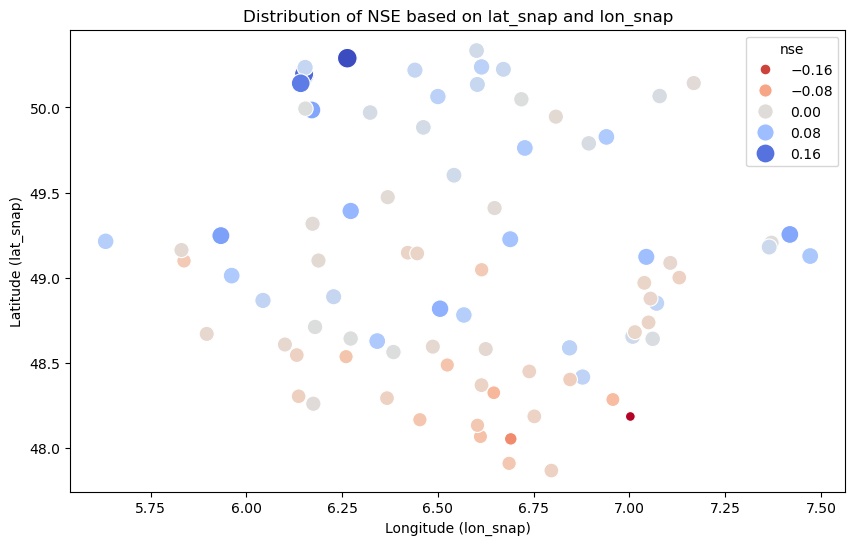

In [359]:
# Create scatter plot for only NSE values based on latitude and longitude
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_diff_filtered, x="lon_snap", y="lat_snap", hue="nse", palette="coolwarm_r", size="nse", sizes=(50, 200))

# Labels and title
plt.xlabel("Longitude (lon_snap)")
plt.ylabel("Latitude (lat_snap)")
plt.title("Distribution of NSE based on lat_snap and lon_snap")

# Show plot
plt.show()


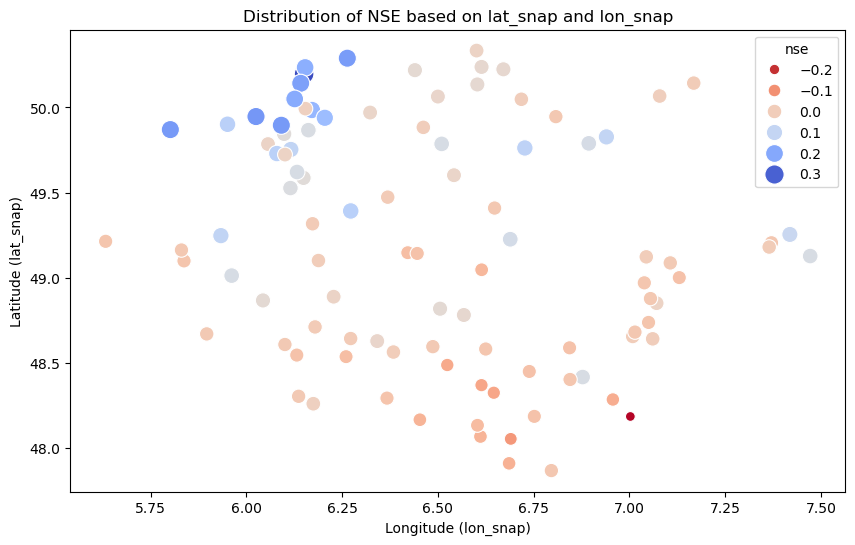

In [369]:
# Create scatter plot for only NSE values based on latitude and longitude
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_diff_cal_filtered, x="lon_snap", y="lat_snap", hue="nse", palette="coolwarm_r", size="nse", sizes=(50, 200))

# Labels and title
plt.xlabel("Longitude (lon_snap)")
plt.ylabel("Latitude (lat_snap)")
plt.title("Distribution of NSE based on lat_snap and lon_snap")

# Show plot
plt.show()


In [198]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

Qtimeseries["Qobs"] = observations["FR003295"]
Qtimeseries["Qcalc"] = output["FR003295"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)



0.5170828571401782

<Axes: >

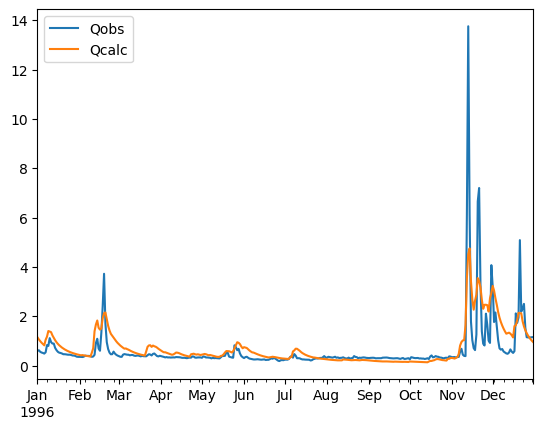

In [199]:
Qtimeseries.loc["1996":"1996"].plot()

<Axes: >

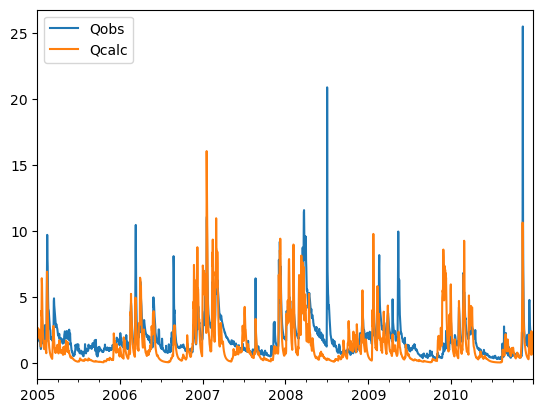

In [94]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["BEWA0087"]*10
Qtimeseries["Qcalc"] = output["BEWA0087"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2005":"2010"].plot()

In [111]:
estreams_attributes.loc[["BEWA0087"], "p_mean"]

basin_id
BEWA0087    2.724
Name: p_mean, dtype: float64

<Axes: xlabel='basin_id'>

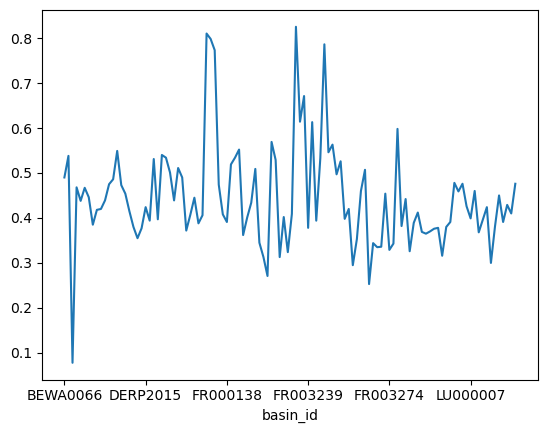

In [90]:
estreams_attributes_clipped_filters.q_runoff_ratio.plot()

In [87]:
estreams_attributes.q_runoff_ratio

basin_id
AT000001    0.727
AT000003    0.247
AT000005    0.806
AT000007    0.516
AT000008    0.536
            ...  
UAGR0016    0.107
UAGR0017    0.088
UAGR0019    0.194
UAGR0020    0.056
UAGR0021    0.451
Name: q_runoff_ratio, Length: 9340, dtype: float64

In [86]:
estreams_attributes.loc[["BEWA0087"], "q_runoff_ratio"]

basin_id
BEWA0087    0.078
Name: q_runoff_ratio, dtype: float64

In [85]:
estreams_attributes.columns[0:50]

Index(['gauge_id', 'gauge_name', 'gauge_country', 'gauge_provider', 'river',
       'lon_snap', 'lat_snap', 'lon', 'lat', 'elevation', 'area_official',
       'area_estreams', 'area_flag', 'area_rel', 'start_date', 'end_date',
       'num_years', 'num_months', 'num_days', 'num_continuous_days',
       'num_days_gaps', 'num_days_reliable', 'num_days_noflag',
       'num_days_suspect', 'gauge_flag', 'duplicated_suspect',
       'watershed_group', 'gauges_upstream', 'nested_catchments', 'q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur'],
      dtype='object')

In [41]:
#catchments_ids = second_half_df.index.tolist()
#catchments_ids = first_half_df.index.tolist()
catchments_ids = estreams_attributes_clipped_filters.index.tolist()

# Run the iterative function
iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

# Convert results to a DataFrame for display
iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                       columns=['basin_id', 'immediate_downstream_basin'])


# Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
topology_list = {basin: None for basin in catchments_ids}  # Default to None

# Filter DataFrame for relevant basin_ids and update topology
for _, row in iterative_downstream_df.iterrows():
    if row['basin_id'] in topology_list:
        topology_list[row['basin_id']] = row['immediate_downstream_basin']

# Generate Nodes dynamically and assign them as global variables
catchments = [] # Dictionary to store nodes

for cat_id in catchments_ids:
    node = Node(
        units=[high, general, low],  # Use unit from dictionary or default
        weights=perm_areas[cat_id],
        area=areas.get(cat_id),  # Use predefined area or default
        id=cat_id
    )
    catchments.append(node)  # Store in the list

    # Assign the node as a global variable
    globals()[cat_id] = node


# Ensure topology only includes nodes that exist in `catchments_ids`
topology = {
    cat_id: upstream if upstream in catchments_ids else None
    for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
}

# Create the Network
model = Network(
    nodes=catchments,  # Pass list of Node objects
    topology=topology  
)

model.reset_states()

# Set inputs for each node using the manually defined dictionary
for cat in catchments:
    cat.set_input(inputs[cat.id])  # Correct way to set inputs


#best_params_dict['M4_lowersplitter_split-par'] = 0.5


model.set_timestep(1.0)
model.set_parameters(best_params_dict_model)

#hyd_mod.reset_states()
output = model.get_output()
output

{'BEWA0067': [array([1.43574771e-03, 6.85734104e-02, 1.38556607e-01, ...,
         1.66528903e+00, 1.42518571e+00, 1.23346683e+00])],
 'BEWA0087': [array([3.33400921e-04, 1.58440095e-02, 5.64219296e-02, ...,
         1.87654512e+00, 1.58539374e+00, 1.35585555e+00])],
 'BEWA0106': [array([2.61282368e-04, 1.39662681e-02, 3.69215230e-02, ...,
         1.46743307e+00, 1.26167549e+00, 1.09560364e+00])],
 'BEWA0107': [array([0.00394145, 0.03756103, 0.07575913, ..., 1.59405453, 1.37971577,
         1.20875492])],
 'DERP2005': [array([0.00166345, 0.02405179, 0.05276074, ..., 1.55150817, 1.33446837,
         1.16160972])],
 'DERP2006': [array([0.00340983, 0.06944771, 0.13412843, ..., 1.73243203, 1.48612499,
         1.29204027])],
 'DERP2008': [array([8.84776517e-04, 3.20449379e-02, 7.08634664e-02, ...,
         1.64896285e+00, 1.41647722e+00, 1.23106288e+00])],
 'DERP2010': [array([0.00820083, 0.07687931, 0.13049998, ..., 2.0764922 , 1.84704348,
         1.67382193])],
 'DERP2013': [array([2.5

In [60]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_val_r_1_100 = pd.DataFrame(nse_results_cal)
nse_results_val_r_1_100

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_21372\1110209421.py:27: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_21372\3313169007.py:13: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')
c:\Users\nascimth\AppData\Local\m

gauge_name     basin        nse  q_mean_obs  q_mean_calc   bfi_obs  \
0          Reuland  BEWA0066   0.808581    1.638001     1.651996  0.524659   
1       Schoenberg  BEWA0067   0.814448    1.794347     1.766691  0.469727   
2       Martelange  BEWA0087 -28.030218    0.207392     1.527459  0.743334   
3          Reuland  BEWA0106   0.737500    1.243036     1.360496  0.506445   
4    Lommersweiler  BEWA0107   0.656242    1.474622     1.738011  0.557155   
..             ...       ...        ...         ...          ...       ...   
107       Michelau  LU000015        NaN         NaN     1.363967       NaN   
108    Pfaffenthal  LU000016        NaN         NaN     1.051202       NaN   
109        Rosport  LU000017        NaN         NaN     1.268479       NaN   
110     Schoenfels  LU000018        NaN         NaN     1.069900       NaN   
111        Vianden  LU000019        NaN         NaN     1.560755       NaN   

      bfi_sim  nse_value_bfi  
0    0.536125            NaN  
1    0.532053            NaN  
2    0.477314            NaN  
3    0.509957            NaN  
4    0.516884            NaN  
..        ...            ...  
107       NaN            NaN  
108       NaN            NaN  
109       NaN            NaN  
110       NaN            NaN  
111       NaN            NaN  

[112 rows x 8 columns]

In [61]:
nse_results_val_r_1_100.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_21372\521990233.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_r_1_100.corr()


nse  q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  \
nse            1.000000    0.185471     0.002937 -0.259783  0.091042   
q_mean_obs     0.185471    1.000000     0.915493 -0.030378 -0.333469   
q_mean_calc    0.002937    0.915493     1.000000 -0.043400 -0.328028   
bfi_obs       -0.259783   -0.030378    -0.043400  1.000000  0.631480   
bfi_sim        0.091042   -0.333469    -0.328028  0.631480  1.000000   
nse_value_bfi  0.926479    0.381351     0.360708 -0.398098 -0.586837   

               nse_value_bfi  
nse                 0.926479  
q_mean_obs          0.381351  
q_mean_calc         0.360708  
bfi_obs            -0.398098  
bfi_sim            -0.586837  
nse_value_bfi       1.000000

<Axes: >

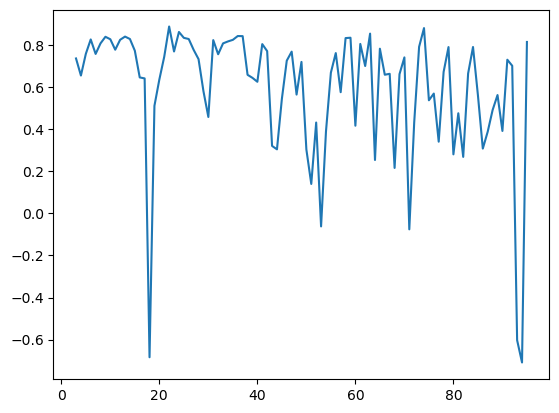

In [44]:
nse_results_val_r_1_100.iloc[3:].nse.plot()

<Axes: >

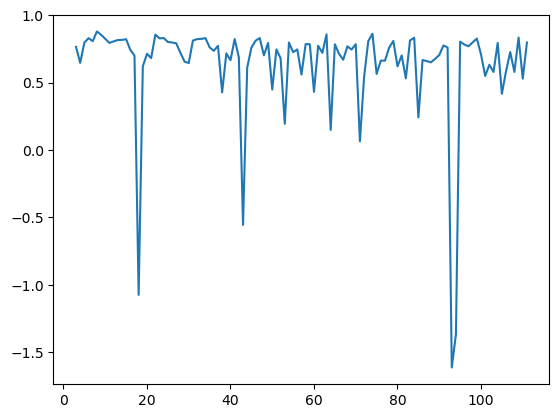

In [58]:
nse_results_val_r_1_100.iloc[3:].nse.plot()

In [45]:
nse_results_val_r_1_100[nse_results_val_r_1_100.nse>0.85]

gauge_name     basin       nse  q_mean_obs  q_mean_calc  \
22                 Hentern  DERP2017  0.889621    1.395562     1.416872   
24              Juenkerath  DERP2021  0.863462    1.453947     1.517530   
63      La Moselle Ã  Toul  FR003249  0.855622    1.571429     1.816584   
74  La Moselle Ã  Custines  FR003265  0.881883    1.422836     1.527678   

     bfi_obs   bfi_sim  nse_value_bfi  
22  0.577916  0.603637       0.935080  
24  0.462274  0.547021       0.855831  
63  0.567660  0.605803       0.857988  
74  0.591212  0.649570       0.874691

<Axes: >

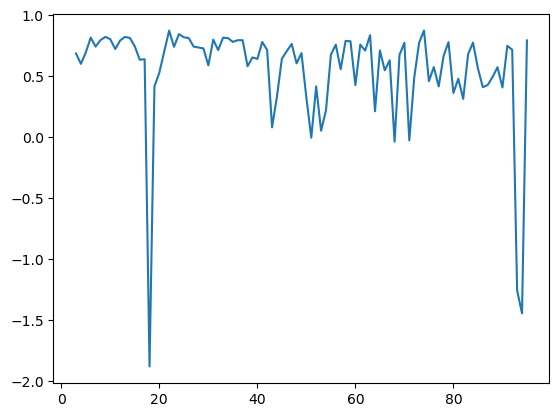

In [79]:
nse_results_val_r_1_100.iloc[3:].nse.plot()

In [46]:
nse_results_val_r_1_100[nse_results_val_r_1_100.nse<0.4]

gauge_name     basin        nse  \
2                                          Martelange  BEWA0087 -28.030218   
18                                            Contwig  DERP2013  -0.684150   
43                                           A6232010  FR000144   0.321286   
44                                           A6701210  FR000153   0.305106   
50                                           A8122000  FR000174   0.304482   
51                                           A9001050  FR000183   0.140460   
53                                           A9021050  FR000185  -0.061639   
54                                           A9251050  FR000190   0.390038   
64                               La Meurthe Ã  Fraize  FR003250   0.254441   
68          La Vezouze Ã  BlÃ¢mont et Ã  FrÃ©monville  FR003254   0.216616   
71  L'ArentÃƒÂ¨le ÃƒÂ  Saint-Gorgon et ÃƒÂ  Sainte...  FR003259  -0.075588   
77         La Seille Ã  Moyenvic et Ã  Vic-sur-Seille  FR003268   0.341504   
80                                   L'Orne Ã  Ã‰tain  FR003274   0.281229   
82                                 Le Woigot Ã  Briey  FR003280   0.269178   
86                             La Sarre Ã  Sarrebourg  FR003293   0.308574   
87                                 L'Isch Ã  Postroff  FR003294   0.389136   
90                              L'Eichel Ã  Oermingen  FR003300   0.392565   
93                             L'Horn Ã  Bousseviller  FR003303  -0.602991   
94                            La Bisten Ã  Creutzwald  FR003306  -0.709009   

    q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  nse_value_bfi  
2     0.207392     1.527459  0.743334  0.477314            NaN  
18    0.838779     1.014060  0.816321  0.840508      -2.687780  
43    1.555575     1.476889  0.683309  0.828481       0.276731  
44    1.097868     1.491351  0.641609  0.775723            NaN  
50    0.831633     0.979795  0.461448  0.582417            NaN  
51    1.681546     1.324083  0.755242  0.768212            NaN  
53    0.743064     1.341983  0.540807  0.799955            NaN  
54    0.902434     1.079606  0.464542  0.497649            NaN  
64    2.563206     1.810936  0.661141  0.487688            NaN  
68    1.264284     1.157252  0.718477  0.676926            NaN  
71    0.888077     1.546485  0.558074  0.758827            NaN  
77    0.693402     0.879239  0.564683  0.566967      -0.369027  
80    0.902356     1.230576  0.296734  0.340507            NaN  
82    1.060768     1.252727  0.621332  0.543655       0.067016  
86    0.852071     1.320206  0.533883  0.781032            NaN  
87    0.994938     1.008044  0.550904  0.564392            NaN  
90    0.727122     1.017224  0.526066  0.705282      -0.374790  
93    0.968523     1.122035  0.804400  0.834791            NaN  
94    1.130278     0.859403  0.764163  0.834422            NaN

In [102]:
nse_results_val_r_1.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_4100\3334474654.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_r_1.corr()


nse  q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  \
nse            1.000000    0.566321     0.430263  0.774705  0.214162   
q_mean_obs     0.566321    1.000000     0.968632  0.211681 -0.332322   
q_mean_calc    0.430263    0.968632     1.000000  0.051725 -0.422992   
bfi_obs        0.774705    0.211681     0.051725  1.000000  0.712744   
bfi_sim        0.214162   -0.332322    -0.422992  0.712744  1.000000   
nse_value_bfi  0.933095    0.651746     0.561240  0.506905 -0.197021   

               nse_value_bfi  
nse                 0.933095  
q_mean_obs          0.651746  
q_mean_calc         0.561240  
bfi_obs             0.506905  
bfi_sim            -0.197021  
nse_value_bfi       1.000000

In [ ]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_val_r_1 = pd.DataFrame(nse_results_cal)
nse_results_val_r_1

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\2369166168.py:26: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\4023551318.py:13: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')


gauge_name     basin       nse  q_mean_obs  q_mean_calc  \
0         AlsdorfOberecken  DERP2011  0.785324    0.911970     1.135518   
1       L'Orne Ã  Boncourt  FR003275  0.457426    0.682736     1.055180   
2               GemuendOur  DERP2004  0.827638    1.259518     1.391146   
3      La Seille Ã  Nomeny  FR003271  0.733814    0.698123     0.746930   
4       EttelbrueckAlzette  LU000007       NaN         NaN     0.994023   
5    La Moselle Ã  Ã‰pinal  FR003237  0.803078    2.574201     2.368009   
6                 A7881010  FR000171  0.715938    0.637797     0.737554   
7                 A6941020  FR000159  0.860682    1.265186     1.124749   
8       La Moselle Ã  Toul  FR003249  0.878703    1.571429     1.672704   
9   BundespegelFremersdorf  DEBU1957  0.863368    0.876168     0.957166   
10        BundespegelPerl   DEBU1956  0.893965    1.079179     1.165714   
11       BundespegelCochem  DEBU1959  0.903238    1.038761     1.070257   

     bfi_obs   bfi_sim  nse_value_bfi  
0   0.567073  0.617591       0.635125  
1   0.429987  0.616605      -0.384332  
2   0.500469  0.528668       0.848751  
3   0.557788  0.626772       0.573837  
4        NaN       NaN            NaN  
5   0.560015  0.491756       0.750260  
6   0.517493  0.626860       0.464088  
7   0.592704  0.589647            NaN  
8   0.567660  0.558848       0.925652  
9   0.608043  0.628015       0.786237  
10  0.586521  0.602987       0.914629  
11  0.604452  0.612770       0.924497

In [400]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)

    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        bfi_sim_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    
    except:
        nse_value_bfi = np.nan
        bfi_obs_series = np.nan
        bfi_sim_series = np.nan
    
    try:

        # Ensure inputs are NumPy arrays
        bfi_obs_series = np.array(bfi_obs_series, dtype=np.float64)
        bfi_sim_series = np.array(bfi_sim_series, dtype=np.float64)





        r2_value_bfi = 1 - np.sum((bfi_obs_series - bfi_sim_series) ** 2) / np.sum((bfi_obs_series - np.mean(bfi_obs_series)) ** 2)
    except:
        r2_value_bfi = np.nan


    try:
        bfi_obs2 = np.mean(bfi_obs_series)/mean_q_obs
        bfi_sim2 = np.mean(bfi_sim_series)/mean_q_calc
    except:    
        bfi_obs2 = np.nan
        bfi_sim2 = np.nan    

    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi,
        "bfi_obs2": bfi_obs2,
        "bfi_sim2":bfi_sim2,
        "r2_value_bfi":r2_value_bfi
        })

# Convert results to DataFrame
nse_results_val_r_1_56 = pd.DataFrame(nse_results_cal)
nse_results_val_r_1_56

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\2369166168.py:26: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\3800118984.py:13: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')
c:\Users\nascimth\AppData\Local\m

gauge_name     basin       nse  \
0                                  Eisenschmitt  DERP2028  0.840568   
1                                         Pruem  DERP2006  0.837414   
2                       La Bisten Ã  Creutzwald  FR003306 -2.075374   
3                                       Reuland  BEWA0106  0.759683   
4                                   Muellenborn  DERP2027  0.775176   
..                                          ...       ...       ...   
107  La Moselle Ã  Hagondange et Ã  Hauconcourt  FR003272  0.851075   
108                       La Moselle Ã  Uckange  FR003284  0.856313   
109                            BundespegelPerl   DEBU1956  0.879837   
110                          BundespegelTrierUp  DEBU1958  0.881359   
111                           BundespegelCochem  DEBU1959  0.890609   

     q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  nse_value_bfi  bfi_obs2  \
0      1.147362     1.177583  0.577985  0.603856       0.819376  0.577985   
1      1.491720     1.494320  0.435240  0.531085       0.833029  0.435240   
2      1.130278     0.790138  0.764163  0.615715            NaN       NaN   
3      1.243036     1.239887  0.506445  0.523732            NaN       NaN   
4      1.252571     1.129610  0.585400  0.604246       0.691616  0.585400   
..          ...          ...       ...       ...            ...       ...   
107    1.137169     1.293391  0.584542  0.590742       0.863295  0.584542   
108    1.050769     1.243439  0.590117  0.596825       0.851772  0.590117   
109    1.079179     1.212330  0.586521  0.600124       0.896342  0.586521   
110    0.979012     1.133456  0.593301  0.607148       0.864039  0.593301   
111    1.038761     1.114467  0.604452  0.608502       0.911816  0.604452   

     bfi_sim2  r2_value_bfi  
0    0.603856      0.864155  
1    0.531085      0.873014  
2         NaN           NaN  
3         NaN           NaN  
4    0.604246      0.820636  
..        ...           ...  
107  0.590742      0.874886  
108  0.596825      0.845720  
109  0.600124      0.905053  
110  0.607148      0.847516  
111  0.608502      0.918860  

[112 rows x 11 columns]

In [388]:
nse_results_val_r_1_56.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\3844970285.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_r_1_56.corr()


nse  q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  \
nse            1.000000    0.176772     0.011312 -0.325126  0.124735   
q_mean_obs     0.176772    1.000000     0.916090 -0.030378 -0.699982   
q_mean_calc    0.011312    0.916090     1.000000 -0.041997 -0.757381   
bfi_obs       -0.325126   -0.030378    -0.041997  1.000000  0.216645   
bfi_sim        0.124735   -0.699982    -0.757381  0.216645  1.000000   
nse_value_bfi  0.977759    0.160864     0.162293 -0.468267 -0.244030   
bfi_obs2      -0.538506   -0.093380    -0.077862  1.000000  0.222011   
bfi_sim2      -0.184636   -0.867944    -0.882749  0.222011  1.000000   

               nse_value_bfi  bfi_obs2  bfi_sim2  
nse                 0.977759 -0.538506 -0.184636  
q_mean_obs          0.160864 -0.093380 -0.867944  
q_mean_calc         0.162293 -0.077862 -0.882749  
bfi_obs            -0.468267  1.000000  0.222011  
bfi_sim            -0.244030  0.222011  1.000000  
nse_value_bfi       1.000000 -0.468267 -0.244030  
bfi_obs2           -0.468267  1.000000  0.222011  
bfi_sim2           -0.244030  0.222011  1.000000

(0.2, 1.0)

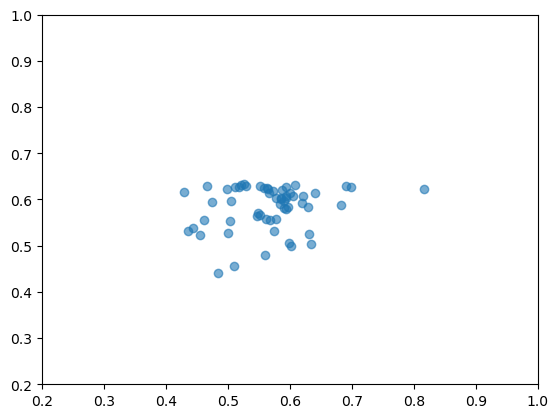

In [389]:

# Create scatter plot
plt.scatter(nse_results_val_r_1_56["bfi_obs2"], nse_results_val_r_1_56["bfi_sim2"], alpha=0.6)
# Set limits (adjust according to your data range)
plt.xlim([0.2, 1])
plt.ylim([0.2, 1])


In [369]:
hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values)[1]

TypeError: calculate_baseflow_index() missing 1 required positional argument: 'quality'

In [327]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_val_g_1_56 = pd.DataFrame(nse_results_cal)
nse_results_val_g_1_56

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\2369166168.py:26: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\3246502077.py:13: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')
c:\Users\nascimth\AppData\Local\m

gauge_name     basin       nse  \
0                                  Eisenschmitt  DERP2028  0.821702   
1                                         Pruem  DERP2006  0.741682   
2                       La Bisten Ã  Creutzwald  FR003306 -1.553516   
3                                       Reuland  BEWA0106  0.718581   
4                                   Muellenborn  DERP2027  0.754011   
..                                          ...       ...       ...   
107  La Moselle Ã  Hagondange et Ã  Hauconcourt  FR003272  0.731452   
108                       La Moselle Ã  Uckange  FR003284  0.734704   
109                            BundespegelPerl   DEBU1956  0.774438   
110                          BundespegelTrierUp  DEBU1958  0.802650   
111                           BundespegelCochem  DEBU1959  0.821427   

     q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  nse_value_bfi  
0      1.147362     1.259830  0.577985  0.638305       0.759286  
1      1.491720     1.582982  0.435240  0.611256       0.490220  
2      1.130278     0.865027  0.764163  0.642448            NaN  
3      1.243036     1.327826  0.506445  0.643626            NaN  
4      1.252571     1.211408  0.585400  0.617581       0.603563  
..          ...          ...       ...       ...            ...  
107    1.137169     1.385993  0.584542  0.576589       0.805779  
108    1.050769     1.334472  0.590117  0.582108       0.786845  
109    1.079179     1.302438  0.586521  0.584988       0.848926  
110    0.979012     1.220215  0.593301  0.607057       0.765674  
111    1.038761     1.200506  0.604452  0.610072       0.845495  

[112 rows x 8 columns]

In [177]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_val_g_1 = pd.DataFrame(nse_results_cal)
nse_results_val_g_1

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\2369166168.py:26: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\750531115.py:13: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')


gauge_name     basin       nse  q_mean_obs  q_mean_calc  \
0         AlsdorfOberecken  DERP2011  0.719454    0.911970     1.219642   
1       L'Orne Ã  Boncourt  FR003275  0.459961    0.682736     1.138163   
2               GemuendOur  DERP2004  0.783289    1.259518     1.481209   
3      La Seille Ã  Nomeny  FR003271  0.691560    0.698123     0.822981   
4       EttelbrueckAlzette  LU000007       NaN         NaN     1.072274   
5    La Moselle Ã  Ã‰pinal  FR003237  0.606200    2.574201     2.484484   
6                 A7881010  FR000171  0.674424    0.637797     0.813315   
7                 A6941020  FR000159  0.824137    1.265186     1.212922   
8       La Moselle Ã  Toul  FR003249  0.740401    1.571429     1.775374   
9   BundespegelFremersdorf  DEBU1957  0.815946    0.876168     1.038583   
10        BundespegelPerl   DEBU1956  0.801087    1.079179     1.254224   
11       BundespegelCochem  DEBU1959  0.842151    1.038761     1.155118   

     bfi_obs   bfi_sim  nse_value_bfi  
0   0.567073  0.622329       0.412628  
1   0.429987  0.595592      -0.279350  
2   0.500469  0.640798       0.559119  
3   0.557788  0.599933       0.552354  
4        NaN       NaN            NaN  
5   0.560015  0.457091       0.747610  
6   0.517493  0.601111       0.444057  
7   0.592704  0.585360            NaN  
8   0.567660  0.534191       0.904582  
9   0.608043  0.621781       0.618216  
10  0.586521  0.585376       0.880127  
11  0.604452  0.609011       0.874273

In [179]:
nse_results_val_r_1.nse_value_bfi - nse_results_val_g_1.nse_value_bfi

0     0.222497
1    -0.104982
2     0.289633
3     0.021482
4          NaN
5     0.002650
6     0.020032
7          NaN
8     0.021070
9     0.168021
10    0.034502
11    0.050224
Name: nse_value_bfi, dtype: float64

In [216]:
nse_results_cal_g_1_56

gauge_name     basin       nse  \
0                                        Eisenschmitt  DERP2028  0.750561   
1                             La Bisten Ã  Creutzwald  FR003306 -1.443603   
2                                         Muellenborn  DERP2027  0.710816   
3   L'ArentÃƒÂ¨le ÃƒÂ  Saint-Gorgon et ÃƒÂ  Sainte...  FR003259  0.242517   
4                                            A9001050  FR000183  0.748868   
5                                  Le Woigot Ã  Briey  FR003280  0.568781   
6                                       Lommersweiler  BEWA0107  0.709137   
7                                            A9013050  FR000184  0.474399   
8                                            A4333010  FR000132  0.496038   
9                                          Schoenberg  BEWA0067  0.713074   
10                                L'AviÃ¨re Ã  Frizon  FR003239  0.547161   
11                                           Hornbach  DERP2015  0.734840   
12                                           A5242010  FR000137  0.737763   
13                                     DhronTalsperre  DERP2031  0.873572   
14                                           A8122000  FR000174  0.461952   
15                                            Seffern  DERP2010  0.755252   
16                                           A7642010  FR000169  0.742127   
17                                          Hunnebuer  LU000010  0.691234   
18                                         Juenkerath  DERP2021  0.759080   
19                                           A9832010  FR000201  0.697288   
20                                              Dreis  DERP2029  0.760578   
21                                              Kasel  DERP2018  0.849378   
22                             La Sarre Ã  Sarrebourg  FR003293  0.707755   
23                                   AlsdorfOberecken  DERP2011  0.729564   
24                                           A6872010  FR000154  0.784769   
25                                           A6701210  FR000153  0.724995   
26                                         Hesperange  LU000009  0.707067   
27         La Seille Ã  Moyenvic et Ã  Vic-sur-Seille  FR003268  0.692306   
28                                            Reuland  BEWA0066  0.788231   
29                        La Nied Allemande Ã  Varize  FR003307  0.766342   
30                                            Platten  DERP2033  0.811270   
31                                        Pfaffenthal  LU000016  0.682748   
32                                 L'Orne Ã  Boncourt  FR003275  0.653396   
33                                        Althornbach  DERP2014  0.681971   
34                                           Dasbourg  LU000005  0.783972   
35                                           Densborn  DERP2023  0.781413   
36                                           A9752010  FR000200  0.708625   
37                           La Vezouze Ã  LunÃ©ville  FR003257  0.796092   
38                                         GemuendOur  DERP2004  0.770455   
39                                            Vianden  LU000019  0.769512   
40                        La Meurthe Ã  Raon-l'Ã‰tape  FR003251  0.680200   
41                                             Kordel  DERP2024  0.824850   
42                                La Seille Ã  Nomeny  FR003271  0.741683   
43                               Le Madon Ã  Pulligny  FR003246  0.728104   
44                           La Meurthe Ã  LunÃ©ville  FR003253  0.531224   
45                              La Moselle Ã  Ã‰pinal  FR003237  0.570396   
46                                           A7881010  FR000171  0.752970   
47       La Sarre Ã  Sarreguemines et Ã  Sarreinsming  FR003302  0.795152   
48                                           Diekirch  LU000006  0.822562   
49                                           A6921010  FR000156  0.803150   
50                                           A5500610  FR000140  0.779792   
51                                 La M

<Axes: >

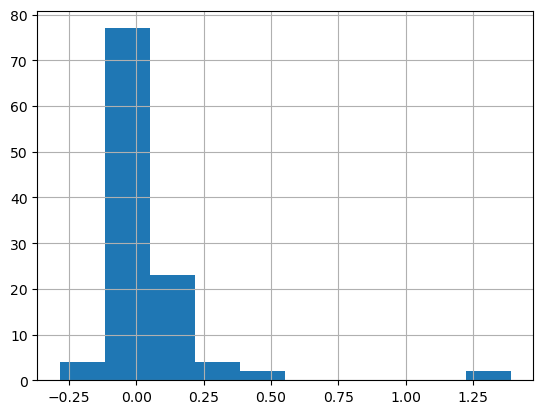

In [256]:
(nse_results_cal_r_1_56.nse - nse_results_cal_g_1_56.nse).hist()

In [257]:
nse_results_cal_r_1_56.nse - nse_results_cal_g_1_56.nse

0     -0.028545
1      0.070389
2     -0.283018
3      0.095308
4     -0.019182
         ...   
107    0.118979
108    0.106295
109    0.102065
110    0.040548
111    0.056221
Name: nse, Length: 112, dtype: float64

In [ ]:
nse_results_cal_r_1_56.nse - nse_results_cal_g_1_56

<Axes: >

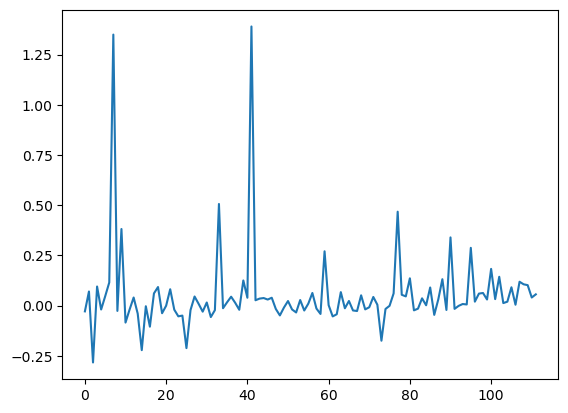

In [402]:
(nse_results_cal_r_1_56.nse - nse_results_cal_g_1_56.nse).plot()

<Axes: >

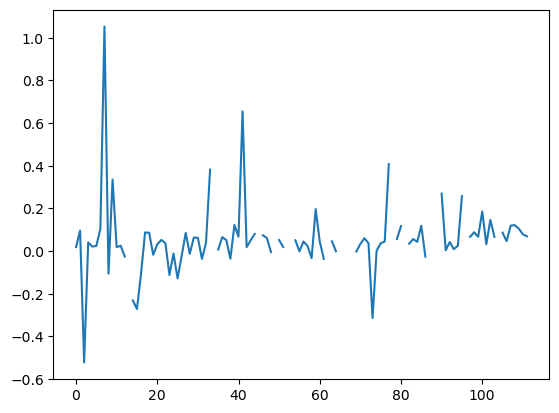

In [403]:
(nse_results_val_r_1_56.nse - nse_results_val_g_1_56.nse).plot()

In [283]:
nse_results_cal_r_1_56

gauge_name     basin       nse  \
0                                  Eisenschmitt  DERP2028  0.722016   
1                                         Pruem  DERP2006  0.784086   
2                       La Bisten Ã  Creutzwald  FR003306 -1.726621   
3                                       Reuland  BEWA0106  0.780962   
4                                   Muellenborn  DERP2027  0.691634   
..                                          ...       ...       ...   
107  La Moselle Ã  Hagondange et Ã  Hauconcourt  FR003272  0.865887   
108                       La Moselle Ã  Uckange  FR003284  0.883391   
109                            BundespegelPerl   DEBU1956  0.876971   
110                          BundespegelTrierUp  DEBU1958  0.907044   
111                           BundespegelCochem  DEBU1959  0.893469   

     q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  nse_value_bfi  
0      0.932864     0.780917  0.600504  0.635447       0.614705  
1      1.366707     1.089608  0.440082  0.543718       0.848413  
2      0.530436     0.567962  0.749280  0.632251            NaN  
3      0.986279     0.858566  0.473400  0.540053            NaN  
4      0.989966     0.763480  0.564320  0.617434       0.677778  
..          ...          ...       ...       ...            ...  
107    1.101628     1.050630  0.615765  0.611945            NaN  
108    0.976771     0.997556  0.611175  0.621547            NaN  
109    0.952513     0.967253  0.610835  0.626602       0.895002  
110    0.926721     0.881482  0.623734  0.633677       0.923896  
111    0.884826     0.859369  0.611554  0.635058       0.925672  

[112 rows x 8 columns]

In [ ]:
data_diff = pd.DataFrame(data=nse_results_cal_r_1_56.nse - nse_results_cal_g_1_56.nse)
data_diff.index = nse_results_cal_r_1_56.basin
data_diff_filtered = data_diff.loc[~data_diff.index.isin(nse_results_cal_g_1.basin.tolist())]
data_diff_filtered["nse_r1"] = nse_results_cal_r_1_56.set_index("basin", inplace = False).nse
data_diff_filtered["nse_g1"] = nse_results_cal_g_1_56.set_index("basin", inplace = False).nse
data_diff_filtered["nse_bfi_r1"] = nse_results_cal_r_1_56.set_index("basin", inplace = False).nse_value_bfi
data_diff_filtered["nse_bfi_g1"] = nse_results_cal_g_1_56.set_index("basin", inplace = False).nse_value_bfi

data_diff_filtered

C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\3975857742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_diff_filtered["nse_r1"] = nse_results_cal_r_1_56.set_index("basin", inplace = False).nse
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\3975857742.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_diff_filtered["nse_g1"] = nse_results_cal_g_1_56.set_index("basin", inplace = False).nse
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\3975857742.py:6: SettingWithCopyWarning

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1
basin                                                         
DERP2028 -0.028545  0.722016  0.750561    0.614705    0.728783
DERP2006  0.070389  0.784086  0.713696    0.848413    0.597656
FR003306 -0.283018 -1.726621 -1.443603         NaN         NaN
BEWA0106  0.095308  0.780962  0.685655         NaN         NaN
DERP2027 -0.019182  0.691634  0.710816    0.677778    0.694958
...            ...       ...       ...         ...         ...
LU000017  0.019806  0.860317  0.840511    0.860166    0.770080
DEBU1957  0.004494  0.860918  0.856424    0.872531    0.769682
FR003284  0.106295  0.883391  0.777096         NaN         NaN
DEBU1956  0.102065  0.876971  0.774907    0.895002    0.862490
DEBU1959  0.056221  0.893469  0.837248    0.925672    0.883863

[101 rows x 5 columns]

In [293]:
data_diff.loc[data_diff.index.isin(nse_results_cal_g_1.basin.tolist())]

nse
basin             
DERP2017 -0.037738
DERP2033  0.002423
DERP2007 -0.000843
DERP2024 -0.015032
FR003253  0.131578
FR003283 -0.016056
FR003301  0.008095
DERP2003  0.032592
FR003265  0.091474
FR003272  0.118979
DEBU1958  0.040548

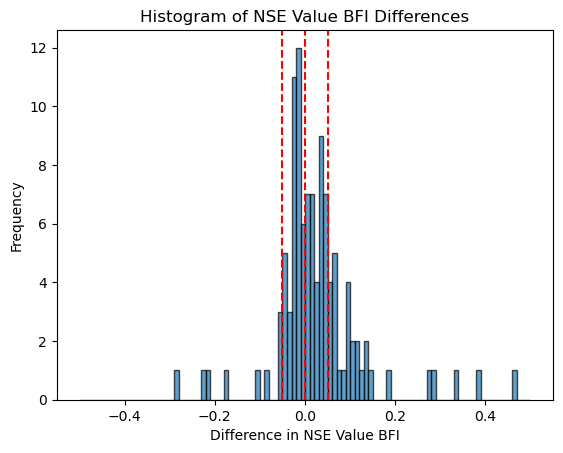

In [296]:
# Compute the difference
data_diff = nse_results_cal_r_1_56.nse - nse_results_cal_g_1_56.nse

import numpy as np

# Define the bin edges, ensuring a clear separation at zero
min_val = -0.5  # Adjust based on your data range
max_val = 0.5   # Adjust based on your data range
bin_width = 0.01  # Adjust bin width for better separation

# Generate bins from min_val to max_val with defined bin width
bins = np.arange(min_val, max_val + bin_width, bin_width)

# Ensure zero is explicitly included as a bin boundary
bins = np.unique(np.append(bins, 0))


# Plot histogram
plt.hist(data_diff, bins=bins, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("Difference in NSE Value BFI")
plt.ylabel("Frequency")
plt.title("Histogram of NSE Value BFI Differences")

# Add vertical line at zero for clarity
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(-0.05, color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(0.05, color='red', linestyle='dashed', linewidth=1.5)

plt.show()


In [323]:
data_diff_filtered[data_diff_filtered.nse_g1>0.85]

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1
basin                                                         
DERP2031 -0.022155  0.851416  0.873572    0.859001    0.870702
FR000190  0.012726  0.868503  0.855777         NaN         NaN
DEBU1957  0.004494  0.860918  0.856424    0.872531    0.769682

In [322]:
data_diff_filtered[data_diff_filtered.nse_r1>0.85]

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1
basin                                                         
DERP2031 -0.022155  0.851416  0.873572    0.859001    0.870702
DERP2030  0.016728  0.855581  0.838853    0.897792    0.811043
DERP2018  0.026893  0.874434  0.847540    0.899372    0.786580
BEWA0066  0.063073  0.852221  0.789147    0.883178    0.673196
FR000140  0.182986  0.864152  0.681166         NaN         NaN
FR003249  0.143675  0.873384  0.729710         NaN         NaN
FR000190  0.012726  0.868503  0.855777         NaN         NaN
LU000017  0.019806  0.860317  0.840511    0.860166    0.770080
DEBU1957  0.004494  0.860918  0.856424    0.872531    0.769682
FR003284  0.106295  0.883391  0.777096         NaN         NaN
DEBU1956  0.102065  0.876971  0.774907    0.895002    0.862490
DEBU1959  0.056221  0.893469  0.837248    0.925672    0.883863

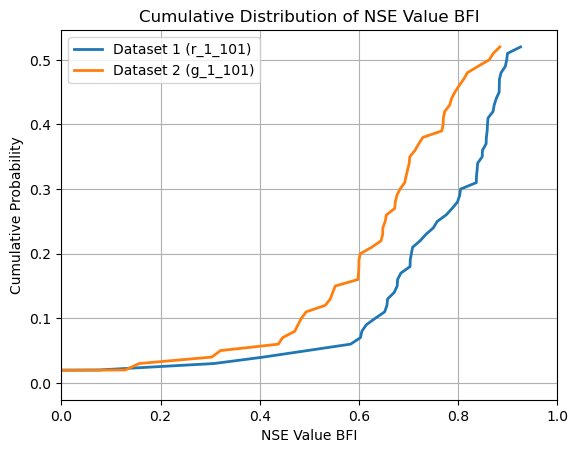

In [311]:
import matplotlib.pyplot as plt
import numpy as np

# Sort values for cumulative plot
nse_values_1 = np.sort(data_diff_filtered["nse_bfi_r1"])
nse_values_2 = np.sort(data_diff_filtered["nse_bfi_g1"])

# Compute cumulative distribution
cumulative_1 = np.linspace(0, 1, len(nse_values_1))
cumulative_2 = np.linspace(0, 1, len(nse_values_2))

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="Dataset 2 (g_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

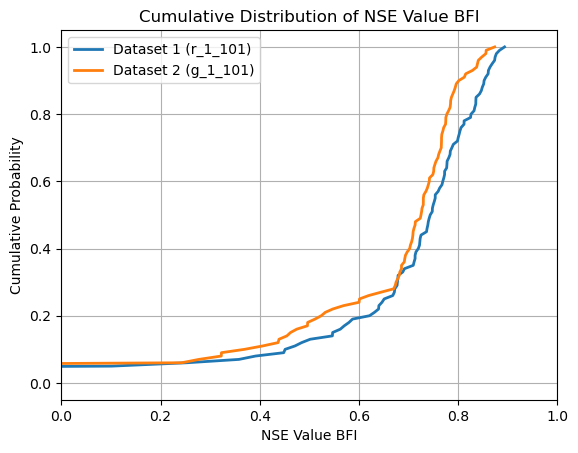

In [312]:
import matplotlib.pyplot as plt
import numpy as np

# Sort values for cumulative plot
nse_values_1 = np.sort(data_diff_filtered["nse_r1"])
nse_values_2 = np.sort(data_diff_filtered["nse_g1"])

# Compute cumulative distribution
cumulative_1 = np.linspace(0, 1, len(nse_values_1))
cumulative_2 = np.linspace(0, 1, len(nse_values_2))

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="Dataset 2 (g_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

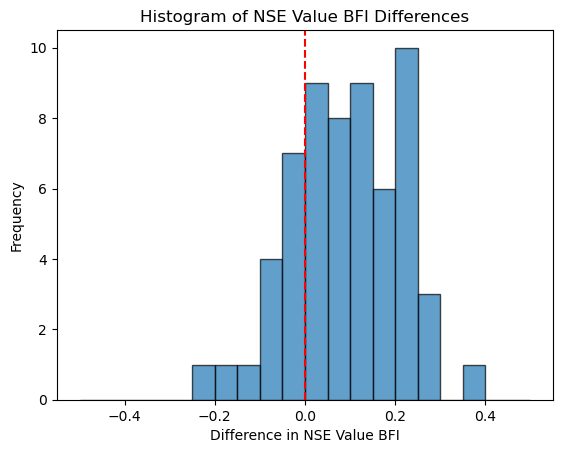

In [274]:



# Compute the difference
data_diff = nse_results_cal_r_1_56.nse_value_bfi - nse_results_cal_g_1_56.nse_value_bfi

import numpy as np

# Define the bin edges, ensuring a clear separation at zero
min_val = -0.5  # Adjust based on your data range
max_val = 0.5   # Adjust based on your data range
bin_width = 0.05  # Adjust bin width for better separation

# Generate bins from min_val to max_val with defined bin width
bins = np.arange(min_val, max_val + bin_width, bin_width)

# Ensure zero is explicitly included as a bin boundary
bins = np.unique(np.append(bins, 0))


# Plot histogram
plt.hist(data_diff, bins=bins, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("Difference in NSE Value BFI")
plt.ylabel("Frequency")
plt.title("Histogram of NSE Value BFI Differences")

# Add vertical line at zero for clarity
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5)

plt.show()


In [364]:
nse_results_val_r_1_56.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\3844970285.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_r_1_56.corr()


nse  q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  \
nse            1.000000    0.176772     0.011312 -0.325126  0.124735   
q_mean_obs     0.176772    1.000000     0.916090 -0.030378 -0.699982   
q_mean_calc    0.011312    0.916090     1.000000 -0.041997 -0.757381   
bfi_obs       -0.325126   -0.030378    -0.041997  1.000000  0.216645   
bfi_sim        0.124735   -0.699982    -0.757381  0.216645  1.000000   
nse_value_bfi  0.977759    0.160864     0.162293 -0.468267 -0.244030   

               nse_value_bfi  
nse                 0.977759  
q_mean_obs          0.160864  
q_mean_calc         0.162293  
bfi_obs            -0.468267  
bfi_sim            -0.244030  
nse_value_bfi       1.000000

In [365]:
nse_results_val_g_1_56.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\2280507530.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_g_1_56.corr()


nse  q_mean_obs  q_mean_calc   bfi_obs   bfi_sim  \
nse            1.000000    0.149459    -0.017611 -0.307942 -0.016141   
q_mean_obs     0.149459    1.000000     0.915896 -0.030378 -0.728235   
q_mean_calc   -0.017611    0.915896     1.000000 -0.040614 -0.685371   
bfi_obs       -0.307942   -0.030378    -0.040614  1.000000  0.193857   
bfi_sim       -0.016141   -0.728235    -0.685371  0.193857  1.000000   
nse_value_bfi  0.934301    0.174928     0.175700 -0.374946 -0.180368   

               nse_value_bfi  
nse                 0.934301  
q_mean_obs          0.174928  
q_mean_calc         0.175700  
bfi_obs            -0.374946  
bfi_sim            -0.180368  
nse_value_bfi       1.000000

In [344]:
data_diff = pd.DataFrame(data=nse_results_val_r_1_56.nse - nse_results_val_g_1_56.nse)
data_diff.index = nse_results_val_r_1_56.basin
data_diff_filtered = data_diff.loc[~data_diff.index.isin(nse_results_val_g_1.basin.tolist())]
data_diff_filtered["nse_r1"] = nse_results_val_r_1_56.set_index("basin", inplace = False).nse
data_diff_filtered["nse_g1"] = nse_results_val_g_1_56.set_index("basin", inplace = False).nse
data_diff_filtered["nse_bfi_r1"] = nse_results_val_r_1_56.set_index("basin", inplace = False).nse_value_bfi
data_diff_filtered["nse_bfi_g1"] = nse_results_val_g_1_56.set_index("basin", inplace = False).nse_value_bfi

data_diff_filtered

C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\37989104.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_diff_filtered["nse_r1"] = nse_results_val_r_1_56.set_index("basin", inplace = False).nse
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\37989104.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_diff_filtered["nse_g1"] = nse_results_val_g_1_56.set_index("basin", inplace = False).nse
C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\37989104.py:6: SettingWithCopyWarning: 
A v

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1
basin                                                         
DERP2028  0.018866  0.840568  0.821702    0.819376    0.759286
DERP2006  0.095733  0.837414  0.741682    0.833029    0.490220
FR003306 -0.521858 -2.075374 -1.553516         NaN         NaN
BEWA0106  0.041102  0.759683  0.718581         NaN         NaN
DERP2027  0.021165  0.775176  0.754011    0.691616    0.603563
...            ...       ...       ...         ...         ...
LU000017       NaN       NaN       NaN         NaN         NaN
FR003265  0.086493  0.897362  0.810869    0.933779    0.912916
FR003272  0.119622  0.851075  0.731452    0.863295    0.805779
FR003284  0.121609  0.856313  0.734704    0.851772    0.786845
DEBU1958  0.078709  0.881359  0.802650    0.864039    0.765674

[100 rows x 5 columns]

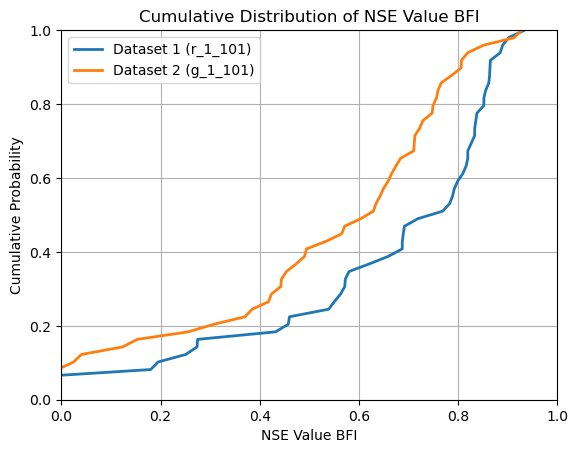

In [359]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_filtered["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_filtered["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="Dataset 2 (g_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


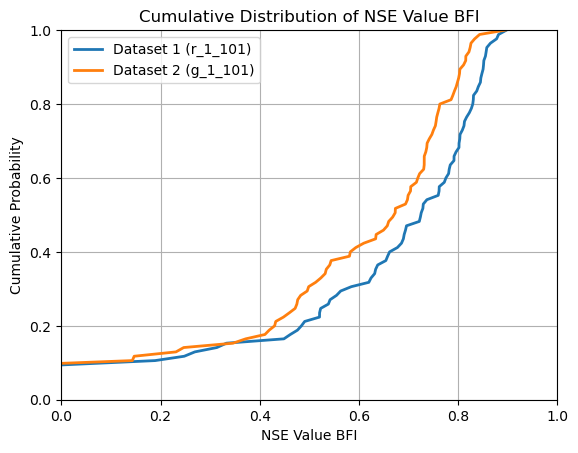

In [360]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_filtered["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_filtered["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="Dataset 2 (g_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


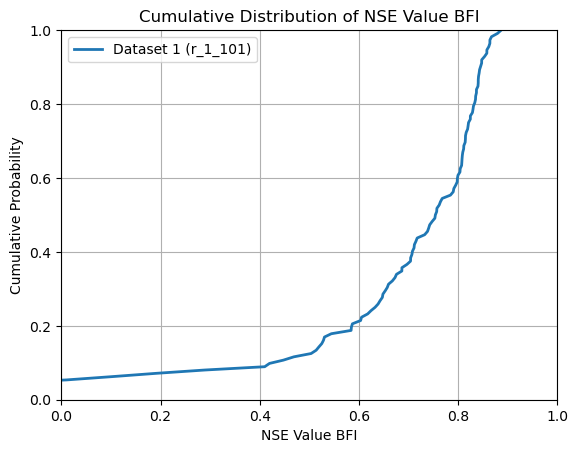

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(nse_results_val_r_1_100["nse"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

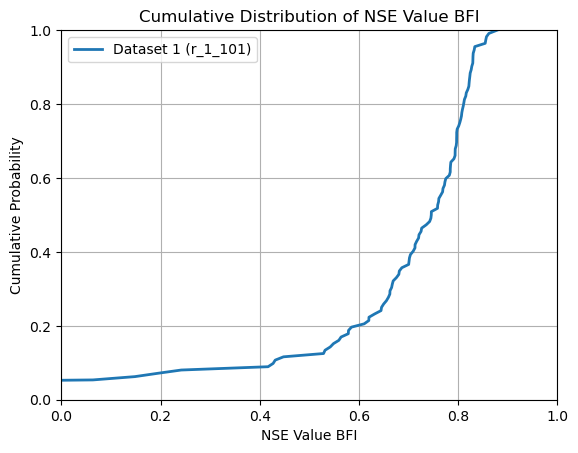

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(nse_results_val_r_1_100["nse"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


In [352]:
cumulative_2

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

In [355]:
nse_values_1

array([-2.41420749e+01, -2.36495207e+00, -2.07537404e+00, -1.65455405e+00,
       -3.24438751e-01, -1.96978745e-01, -1.93807742e-01, -2.89739331e-04,
        1.88914310e-01,  2.47714664e-01,  2.69030322e-01,  3.13399533e-01,
        3.32734949e-01,  4.48532638e-01,  4.61506959e-01,  4.75890867e-01,
        4.83935693e-01,  4.90463312e-01,  5.20366063e-01,  5.20515842e-01,
        5.22671925e-01,  5.38277587e-01,  5.41683494e-01,  5.54629307e-01,
        5.63051645e-01,  5.84582309e-01,  6.19818945e-01,  6.24230357e-01,
        6.31592128e-01,  6.33550396e-01,  6.37698953e-01,  6.54113739e-01,
        6.57682146e-01,  6.61703945e-01,  6.77429613e-01,  6.85670552e-01,
        6.89457181e-01,  6.91084566e-01,  6.93723283e-01,  6.95760730e-01,
        7.21530044e-01,  7.23724523e-01,  7.25470138e-01,  7.28759079e-01,
        7.29609486e-01,  7.36856909e-01,  7.59683175e-01,  7.61422201e-01,
        7.61781989e-01,  7.71956477e-01,  7.75176244e-01,  7.80650682e-01,
        7.81847262e-01,  

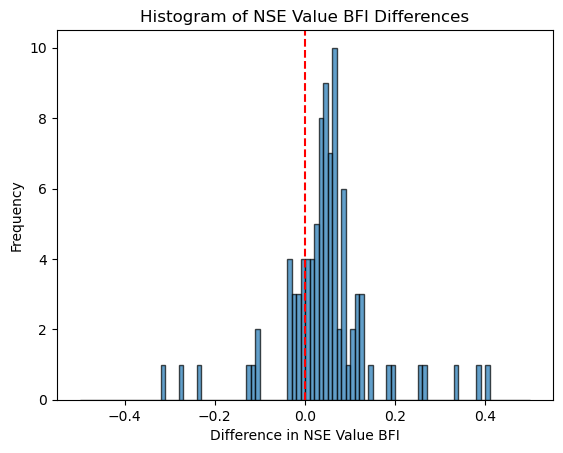

In [348]:
# Compute the difference
data_diff = nse_results_val_r_1_56.nse - nse_results_val_g_1_56.nse

import numpy as np

# Define the bin edges, ensuring a clear separation at zero
min_val = -0.5  # Adjust based on your data range
max_val = 0.5   # Adjust based on your data range
bin_width = 0.01  # Adjust bin width for better separation

# Generate bins from min_val to max_val with defined bin width
bins = np.arange(min_val, max_val + bin_width, bin_width)

# Ensure zero is explicitly included as a bin boundary
bins = np.unique(np.append(bins, 0))


# Plot histogram
plt.hist(data_diff, bins=bins, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("Difference in NSE Value BFI")
plt.ylabel("Frequency")
plt.title("Histogram of NSE Value BFI Differences")

# Add vertical line at zero for clarity
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5)
#plt.axvline(-0.05, color='red', linestyle='dashed', linewidth=1.5)
#plt.axvline(0.05, color='red', linestyle='dashed', linewidth=1.5)

plt.show()


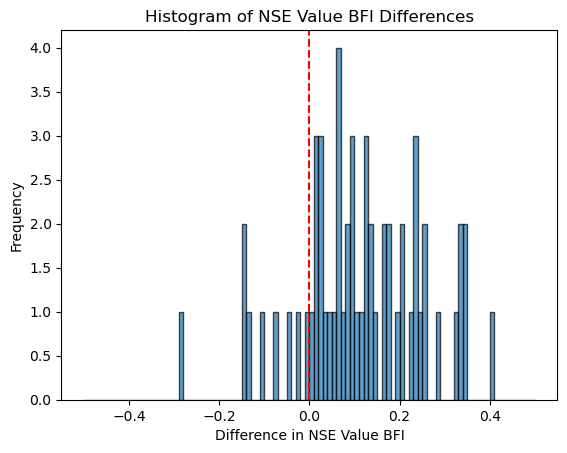

In [423]:
# Compute the difference
data_diff = nse_results_val_r_1_56.nse_value_bfi - nse_results_val_g_1_56.nse_value_bfi

import numpy as np

# Define the bin edges, ensuring a clear separation at zero
min_val = -0.5  # Adjust based on your data range
max_val = 0.5   # Adjust based on your data range
bin_width = 0.01  # Adjust bin width for better separation

# Generate bins from min_val to max_val with defined bin width
bins = np.arange(min_val, max_val + bin_width, bin_width)

# Ensure zero is explicitly included as a bin boundary
bins = np.unique(np.append(bins, 0))


# Plot histogram
plt.hist(data_diff, bins=bins, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("Difference in NSE Value BFI")
plt.ylabel("Frequency")
plt.title("Histogram of NSE Value BFI Differences")

# Add vertical line at zero for clarity
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5)
#plt.axvline(-0.05, color='red', linestyle='dashed', linewidth=1.5)
#plt.axvline(0.05, color='red', linestyle='dashed', linewidth=1.5)

plt.show()

In [65]:
nse_results_val_r_1.corr(method="spearman")

C:\Users\nascimth\AppData\Local\Temp\ipykernel_19688\1273401101.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_val_r_1.corr(method="spearman")


nse  q_mean_obs  q_mean_calc   bfi_obs   bfi_sim
nse          1.000000    0.554545     0.400000  0.800000 -0.309091
q_mean_obs   0.554545    1.000000     0.900000  0.300000 -0.881818
q_mean_calc  0.400000    0.900000     1.000000  0.045455 -0.890909
bfi_obs      0.800000    0.300000     0.045455  1.000000  0.109091
bfi_sim     -0.309091   -0.881818    -0.890909  0.109091  1.000000

In [ ]:
# Create an empty list to store results
nse_results = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    
    nse_results.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc
    })

# Convert results to DataFrame
nse_df_g_1 = pd.DataFrame(nse_results)
nse_df_g_1

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_23280\2369166168.py:26: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_23280\669091914.py:12: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)


gauge_name     basin       nse  q_mean_obs  q_mean_calc
0         AlsdorfOberecken  DERP2011  0.719454    0.911970     1.219642
1       L'Orne Ã  Boncourt  FR003275  0.459961    0.682736     1.138163
2               GemuendOur  DERP2004  0.783289    1.259518     1.481209
3      La Seille Ã  Nomeny  FR003271  0.691560    0.698123     0.822981
4       EttelbrueckAlzette  LU000007       NaN         NaN     1.072274
5    La Moselle Ã  Ã‰pinal  FR003237  0.606200    2.574201     2.484484
6                 A7881010  FR000171  0.674424    0.637797     0.813315
7                 A6941020  FR000159  0.824137    1.265186     1.212922
8       La Moselle Ã  Toul  FR003249  0.740401    1.571429     1.775374
9   BundespegelFremersdorf  DEBU1957  0.815946    0.876168     1.038583
10        BundespegelPerl   DEBU1956  0.801087    1.079179     1.254224
11       BundespegelCochem  DEBU1959  0.842151    1.038761     1.155118

In [186]:
# Create an empty list to store results
nse_results = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 

    nse_results.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc
    })

# Convert results to DataFrame
nse_df_r_2 = pd.DataFrame(nse_results)
nse_df_r_2

c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\AppData\Local\miniconda3\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_23280\2369166168.py:26: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_23280\2593294400.py:12: RuntimeWarning: Mean of empty slice
  mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)


gauge_name     basin       nse  \
0                                      Hentern  DERP2017  0.766067   
1                                      Platten  DERP2033  0.838241   
2                                  Pruemzurlay  DERP2007  0.810365   
3                                       Kordel  DERP2024  0.802353   
4                     La Meurthe Ã  LunÃ©ville  FR003253  0.506034   
5       La Nied Ã  Bouzonville et Ã  Filstroff  FR003308       NaN   
6                         L'Orne Ã  Rosselange  FR003283  0.690595   
7                         La Sarre Ã  Wittring  FR003301  0.808332   
8                                   Bollendorf  DERP2003  0.817706   
9                       La Moselle Ã  Custines  FR003265  0.823596   
10  La Moselle Ã  Hagondange et Ã  Hauconcourt  FR003272  0.828939   
11                          BundespegelTrierUp  DEBU1958  0.850263   

    q_mean_obs  q_mean_calc  
0     1.395562     1.287191  
1     0.898401     0.980934  
2     1.212015     1.198566  
3     1.059166     1.094042  
4     1.407706     1.386283  
5          NaN     0.784570  
6     0.793661     0.994270  
7     1.006920     0.946313  
8     1.094215     1.094057  
9     1.422836     1.242387  
10    1.137169     1.158981  
11    0.979012     1.067050

In [43]:
# Create an empty list to store results
nse_results = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 

    nse_results.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc
    })

# Convert results to DataFrame
nse_df_r_1 = pd.DataFrame(nse_results)
nse_df_r_1

ValueError: Length of values (4748) does not match length of index (4749)

In [239]:
nse_df_r_1.nse - nse_df_g_1.nse

0     0.065870
1    -0.002535
2     0.044348
3     0.042253
4          NaN
5     0.196877
6     0.041514
7     0.036544
8     0.138302
9     0.047422
10    0.092878
11    0.061087
Name: nse, dtype: float64

In [187]:
nse_df_r_2.nse - nse_df_g_2.nse

0     0.103560
1     0.048580
2     0.041449
3     0.016856
4     0.197280
5          NaN
6     0.026462
7     0.059928
8     0.045538
9     0.018005
10    0.053161
11    0.056105
Name: nse, dtype: float64

In [188]:
nse_results_cal_r_2.nse - nse_results_cal_g_2.nse

0     0.056758
1     0.035859
2     0.018530
3     0.021134
4     0.045920
5    -0.087731
6     0.014161
7     0.007300
8     0.015965
9     0.028282
10    0.021578
11    0.017464
Name: nse, dtype: float64

In [ ]:
nse_df_r_1.nse - nse_df_g_1.nse

In [240]:
nse_results_cal_r_1.nse - nse_results_cal_g_1.nse

0    -0.037738
1     0.002423
2    -0.006112
3    -0.043104
4     0.047054
5    -0.018245
6    -0.021367
7    -0.025630
8     0.019078
9     0.013949
10    0.046643
11    0.008458
Name: nse, dtype: float64

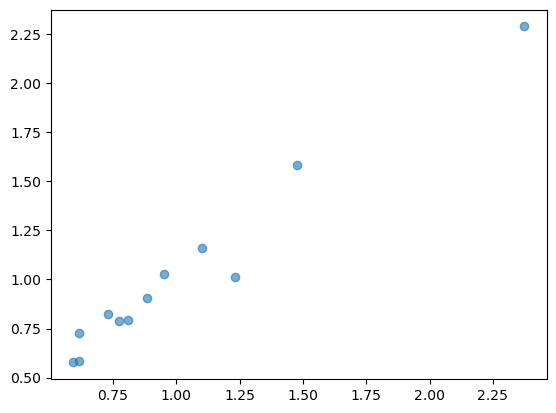

In [221]:
# Create scatter plot
plt.scatter(nse_df["q_mean_obs"], nse_df["q_mean_calc"], alpha=0.6)


In [46]:
nse_df.corr()

NameError: name 'nse_df' is not defined

In [303]:
nse_df_g

gauge_name     basin       nse  q_mean_obs  q_mean_calc
0         AlsdorfOberecken  DERP2011  0.609061    0.911970     1.296335
1       L'Orne Ã  Boncourt  FR003275  0.406974    0.682736     1.196920
2               GemuendOur  DERP2004 -0.221847    1.259518     1.581739
3      La Seille Ã  Nomeny  FR003271  0.649136    0.698123     0.855776
4       EttelbrueckAlzette  LU000007       NaN         NaN     1.131707
5    La Moselle Ã  Ã‰pinal  FR003237  0.023875    2.574201     2.681898
6                 A7881010  FR000171  0.647980    0.637797     0.844974
7                 A6941020  FR000159  0.706138    1.265186     1.290464
8       La Moselle Ã  Toul  FR003249  0.474272    1.571429     1.906377
9   BundespegelFremersdorf  DEBU1957  0.746404    0.876168     1.093426
10        BundespegelPerl   DEBU1956  0.681253    1.079179     1.333444
11       BundespegelCochem  DEBU1959  0.700952    1.038761     1.226450

In [304]:
nse_df_h

gauge_name     basin       nse  q_mean_obs  q_mean_calc
0         AlsdorfOberecken  DERP2011  0.713420    0.911970     1.148731
1       L'Orne Ã  Boncourt  FR003275  0.218452    0.682736     1.058602
2               GemuendOur  DERP2004  0.663013    1.259518     1.417030
3      La Seille Ã  Nomeny  FR003271  0.548588    0.698123     0.749305
4       EttelbrueckAlzette  LU000007       NaN         NaN     0.997414
5    La Moselle Ã  Ã‰pinal  FR003237  0.557494    2.574201     2.435144
6                 A7881010  FR000171  0.557819    0.637797     0.739464
7                 A6941020  FR000159  0.783346    1.265186     1.144239
8       La Moselle Ã  Toul  FR003249  0.771882    1.571429     1.712767
9   BundespegelFremersdorf  DEBU1957  0.761325    0.876168     0.963738
10        BundespegelPerl   DEBU1956  0.811730    1.079179     1.184531
11       BundespegelCochem  DEBU1959  0.826471    1.038761     1.084421

In [294]:
nse_df_h.nse - nse_df_g.nse 

0     0.104359
1    -0.188522
2     0.884861
3    -0.100549
4          NaN
5     0.533619
6    -0.090161
7     0.077208
8     0.297610
9     0.014921
10    0.130478
11    0.125518
Name: nse, dtype: float64

In [297]:
nse_results_cal_h.nse - nse_results_cal_g.nse 

AttributeError: 'list' object has no attribute 'nse'

In [302]:
nse_results_cal_h

[]

In [325]:
Qtimeseries.iloc[365:, 0].values.numpy.nanmean()

IndexError: single positional indexer is out-of-bounds

In [407]:
best_params_dict_model

{'high_snow_k': 4.086426297944429,
 'high_unsaturated_Ce': 0.9567288089362507,
 'high_unsaturated_beta': 1.0331337523819135,
 'high_slowhigh_k': 0.0013319218103794586,
 'general_snow_k': 4.086426297944429,
 'general_unsaturated_Ce': 0.9567288089362507,
 'general_unsaturated_beta': 1.0331337523819135,
 'general_slow_k': 0.011234798028853129,
 'general_lag-fun_lag-time': 3.9750011064022424,
 'general_fast_k': 0.48590540089635903,
 'low_snow_k': 4.086426297944429,
 'low_unsaturated_Ce': 0.9567288089362507,
 'low_unsaturated_beta': 1.0331337523819135,
 'low_fast_k': 0.004905033249936297}

In [426]:
data_diff_filtered[data_diff_filtered.nse<-0.05]

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1
basin                                                         
FR003306 -0.521858 -2.075374 -1.553516         NaN         NaN
FR000183 -0.105590 -0.196979 -0.091389         NaN         NaN
FR000184 -0.231250 -0.000290  0.230961         NaN         NaN
FR003303 -0.271455 -1.654554 -1.383099         NaN         NaN
FR000132 -0.107639  0.541683  0.649323    0.579943    0.722418
FR003254 -0.111754 -0.193808 -0.082053         NaN         NaN
FR000144 -0.127971 -0.324439 -0.196467   -0.424234   -0.141920
DERP2013 -0.313903 -2.364952 -2.051049   -5.208121   -4.188421

In [437]:
estreams_attributes_clipped_filters.columns[30:]

Index(['q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep', 'perm_verylow_glob',
       'perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 'lit_fra_su',
       'lit_fra_ss', 'lit_fra_sm', 'lit_fra_sc', 'lit_fra_mt', 'lit_fra_pi',
       'lit_fra_py', 'lit_fra_vi', 'lit_fra_ev', 'lit_fra_ig', 'lit_fra_pa',
       'lit_fra_pb', 'lit_fra_va', 'lit_fra_vb', 'perm_high_cont',
       'perm_medium_cont', 'perm_low_cont', 'perm_verylow_cont',
       'lit_fra_Conglomerates', 'lit_fra_Conglomerates and sands',
       'lit_fra_Gravels', 'lit_fra_Sands', 'lit_fra_Sa

In [438]:
data_diff_filtered["perm_high_regi"] = estreams_attributes_clipped_filters["perm_high_regi"]
data_diff_filtered["root_dep_mean"] = estreams_attributes_clipped_filters["root_dep_mean"]

In [439]:
data_diff_filtered[data_diff_filtered.perm_high_regi>70]

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1  \
basin                                                            
DERP2028  0.018866  0.840568  0.821702    0.819376    0.759286   
FR003306 -0.521858 -2.075374 -1.553516         NaN         NaN   
FR000184 -0.231250 -0.000290  0.230961         NaN         NaN   
FR003303 -0.271455 -1.654554 -1.383099         NaN         NaN   
FR000144 -0.127971 -0.324439 -0.196467   -0.424234   -0.141920   
FR000185  0.122290  0.269030  0.146740         NaN         NaN   
DERP2029  0.067602  0.771956  0.704354    0.620367    0.384514   
FR000153  0.051809  0.483936  0.432126         NaN         NaN   
DERP2013 -0.313903 -2.364952 -2.051049   -5.208121   -4.188421   

          perm_high_regi  root_dep_mean  
basin                                    
DERP2028            80.0        102.000  
FR003306            94.0        115.085  
FR000184            98.0         85.281  
FR003303            98.0        106.250  
FR000144            92.0         79.831  
FR000185            75.0         92.353  
DERP2029            73.0        116.526  
FR000153            76.0        111.010  
DERP2013            91.0        116.881

In [442]:
data_diff_filtered[data_diff_filtered.root_dep_mean>110]

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1  \
basin                                                            
FR003306 -0.521858 -2.075374 -1.553516         NaN         NaN   
FR003259  0.104731  0.247715  0.142983         NaN         NaN   
DERP2016  0.024988  0.783979  0.758991    0.855370    0.756186   
LU000018       NaN       NaN       NaN         NaN         NaN   
FR000132 -0.107639  0.541683  0.649323    0.579943    0.722418   
FR003239  0.031577  0.554629  0.523052   -0.059783   -0.399673   
FR003288  0.052162  0.685671  0.633509    0.538849    0.306979   
DERP2015  0.037332  0.619819  0.582487    0.273496    0.152812   
FR000137 -0.011256  0.661704  0.672960         NaN         NaN   
FR000174 -0.013183  0.332735  0.345918         NaN         NaN   
FR003274  0.063535  0.538278  0.474743         NaN         NaN   
FR003294 -0.036688  0.475891  0.512579         NaN         NaN   
FR000169  0.039173  0.736857  0.697684    0.658744    0.494212   
LU000010       NaN       NaN       NaN         NaN         NaN   
DERP2036  0.051267  0.812655  0.761388    0.689256    0.571039   
FR000201 -0.035809  0.695761  0.731570         NaN         NaN   
DERP2029  0.067602  0.771956  0.704354    0.620367    0.384514   
FR003300  0.060694  0.520366  0.459672    0.194796   -0.007828   
FR000154 -0.004928  0.725470  0.730398    0.457323    0.255786   
FR000153  0.051809  0.483936  0.432126         NaN         NaN   
FR003268  0.050539  0.584582  0.534043    0.250755    0.123323   
FR003267  0.023938  0.633550  0.609612    0.562713    0.565194   
FR003307 -0.032969  0.723725  0.756693    0.572459    0.649422   
FR000142  0.196980  0.728759  0.531779    0.687308    0.728864   
DERP2033  0.044471  0.847803  0.803332    0.788591    0.642487   
FR000138 -0.036283  0.631592  0.667875         NaN         NaN   
DERP2014  0.049317  0.520516  0.471198    0.180038    0.040477   
FR003256 -0.001901  0.729609  0.731511         NaN         NaN   
FR003261  0.060483  0.654114  0.593631    0.550224    0.370373   
FR000200  0.036664  0.693723  0.657060         NaN         NaN   
DERP2013 -0.313903 -2.364952 -2.051049   -5.208121   -4.188421   
FR003257  0.002232  0.803191  0.800959    0.782729    0.683759   
FR003295  0.056997  0.637699  0.580702         NaN         NaN   
LU000014       NaN       NaN       NaN         NaN         NaN   
FR003296  0.056523  0.691085  0.634561    0.274572    0.024554   
FR003246 -0.026262  0.689457  0.715719    0.459965    0.443705   
FR003283  0.004082  0.677430  0.673348         NaN         NaN   
FR003301  0.009129  0.801575  0.792447         NaN         NaN   
FR003302  0.025190  0.780651  0.755461         NaN         NaN   
FR003241  0.257872  0.801704  0.543832         NaN         NaN   
FR003262  0.067128  0.803725  0.736597    0.837773    0.819093   
FR000156  0.088066  0.781847  0.693781    0.792250    0.710385   
FR000140  0.185779  0.845647  0.659867         NaN         NaN   
FR000190  0.066827  0.313400  0.246572         NaN         NaN   
FR003265  0.086493  0.897362  0.810869    0.933779    0.912916   
FR003272  0.119622  0.851075  0.731452    0.863295    0.805779   
FR003284  0.121609  0.856313  0.734704    0.851772    0.786845   
DEBU1958  0.078709  0.881359  0.802650    0.864039    0.765674   

          perm_high_regi  root_dep_mean  
basin                                    
FR003306            94.0        115.085  
FR003259            66.0        128.125  
DERP2016            27.0        116.842  
LU000018            39.0        129.277  
FR000132            45.0        126.042  
FR003239            32.0        130.000  
FR003288            29.0        110.885  
DERP2015            55.0        117.568  
FR000137             9.0        130.000  
FR000174             0.0        122.593  
FR003274             0.0        123.233  
FR003294             1.0        118.414  
FR000169            10.0        117.517  
LU000010            42.0        118.263  
DERP2036             1.0        126.023  


In [443]:
data_diff_filtered.corr()

nse    nse_r1    nse_g1  nse_bfi_r1  nse_bfi_g1  \
nse             1.000000 -0.272628 -0.331051    0.565570    0.492093   
nse_r1         -0.272628  1.000000  0.998122    0.981488    0.945908   
nse_g1         -0.331051  0.998122  1.000000    0.966496    0.944235   
nse_bfi_r1      0.565570  0.981488  0.966496    1.000000    0.981490   
nse_bfi_g1      0.492093  0.945908  0.944235    0.981490    1.000000   
perm_high_regi -0.386319 -0.014619  0.010258   -0.487689   -0.437892   
root_dep_mean  -0.198325  0.238775  0.246809   -0.165866   -0.144408   

                perm_high_regi  root_dep_mean  
nse                  -0.386319      -0.198325  
nse_r1               -0.014619       0.238775  
nse_g1                0.010258       0.246809  
nse_bfi_r1           -0.487689      -0.165866  
nse_bfi_g1           -0.437892      -0.144408  
perm_high_regi        1.000000       0.217752  
root_dep_mean         0.217752       1.000000

In [427]:
estreams_attributes_clipped_filters.loc[data_diff_filtered[data_diff_filtered.nse<-0.05].index.tolist()]

gauge_id                                 gauge_name gauge_country  \
basin_id                                                                        
FR003306  A961205050                    La Bisten Ã  Creutzwald            FR   
FR000183  A900105050                                   A9001050            FR   
FR000184  A901305050                                   A9013050            FR   
FR003303  A932215050                     L'Horn Ã  Bousseviller            FR   
FR000132  A433301001                                   A4333010            FR   
FR003254  A643112001  La Vezouze Ã  BlÃ¢mont et Ã  FrÃ©monville            FR   
FR000144  A623201001                                   A6232010            FR   
DERP2013  2642030800                                    Contwig            DE   

         gauge_provider                                  river  lon_snap  \
basin_id                                                                   
FR003306   FR_EAUFRANCE                 La Bisten à Creutzwald  6.688894   
FR000183   FR_EAUFRANCE    La Sarre à Laneuveville-lès-Lorquin  7.008689   
FR000184   FR_EAUFRANCE          La Sarre Rouge à Vasperviller  7.060836   
FR003303   FR_EAUFRANCE                  L'Horn à Bousseviller  7.472093   
FR000132   FR_EAUFRANCE    Le Neune à Laveline-devant-Bruyères  6.751787   
FR003254   FR_EAUFRANCE  La Vezouze à Blâmont et à Frémonville  6.843861   
FR000144   FR_EAUFRANCE  La Plaine à Raon-l'Étape [La Trouche]  6.877879   
DERP2013          DE_RP                            Schwarzbach  7.419000   

           lat_snap       lon        lat elevation  ...  sno_cov_mean  \
basin_id                                            ...                 
FR003306  49.225799  6.688894  49.225799       201  ...         2.452   
FR000183  48.654579  7.008689  48.654579       268  ...         5.440   
FR000184  48.640785  7.064290  48.640085       279  ...         6.350   
FR003303  49.127103  7.472093  49.127103       265  ...         2.876   
FR000132  48.185384  6.751787  48.185384       442  ...         6.803   
FR003254  48.588049  6.843861  48.588049       265  ...         5.071   
FR000144  48.416320  6.877879  48.416320       290  ...         7.244   
DERP2013  49.254000  7.419000  49.254000       NaN  ...         3.575   

          irri_1990  irri_2005  stations_num_p_mean perm_high_regi  \
basin_id                                                             
FR003306        0.0      0.000                  2.0           94.0   
FR000183        0.0      0.000                  4.0           66.0   
FR000184        0.0      0.000                  5.0           98.0   
FR003303        0.0      0.002                  5.0           98.0   
FR000132        0.0      0.000                  1.0           45.0   
FR003254        0.0      0.001                  4.0           64.0   
FR000144        0.0      0.000                  4.0           92.0   
DERP2013        0.0      0.000                 22.0           91.0   

         perm_medium_regi  perm_low_regi  perm_high_glob2  perm_medium_glob2  \
basin_id                                                                       
FR003306              6.0            0.0             91.0                9.0   
FR000183             29.0            5.0             64.0               30.0   
FR000184              2.0            0.0             96.0                4.0   
FR003303              2.0            0.0             96.0                4.0   
FR000132              0.0           55.0             38.0               51.0   
FR003254             36.0            0.0             63.0               37.0   
FR000144              0.0            8.0             83.0                5.0   
DERP2013              9.0            0.0             92.0                8.0   

          perm_low_glob2  
basin_id                  
FR003306             0.0  
FR000183             6.0  
FR000184             0.0  
FR003303             0.0  
FR000132            11.0  
FR003254          

In [ ]:
estreams_attributes_clipped_filters.loc[data_diff_filtered[data_diff_filtered.nse<-0.05].index.tolist()]

In [48]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

Qtimeseries["Qobs"] = observations["FR000142"]
Qtimeseries["Qcalc"] = output["FR000142"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.772352184283404

In [70]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["DEBU1959"]
Qtimeseries["Qcalc"] = output["DEBU1959"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.8544135446284694

In [51]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

Qtimeseries["Qobs"] = observations["DEBU1959"]
Qtimeseries["Qcalc"] = output["DEBU1959"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.8405809657524955

ValueError: zero-size array to reduction operation fmin which has no identity

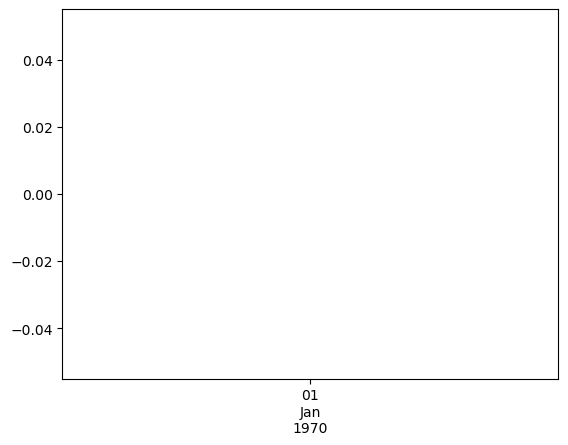

In [52]:
Qtimeseries.loc["2006":"2006"].plot()

<Axes: >

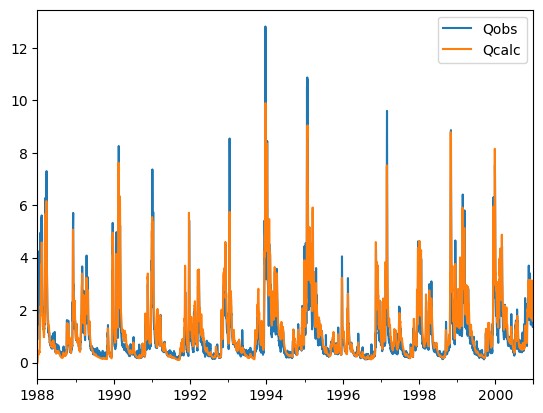

In [53]:
Qtimeseries.plot()

<Axes: >

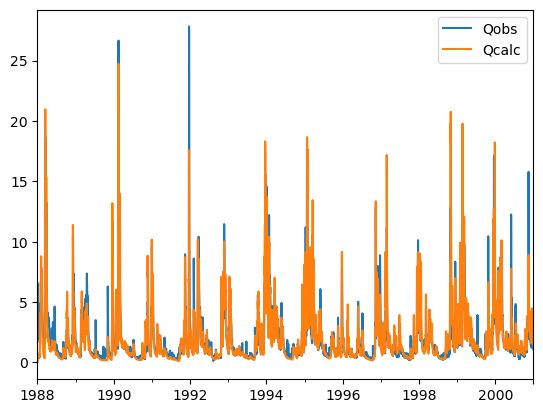

In [50]:
Qtimeseries.plot()

<Axes: >

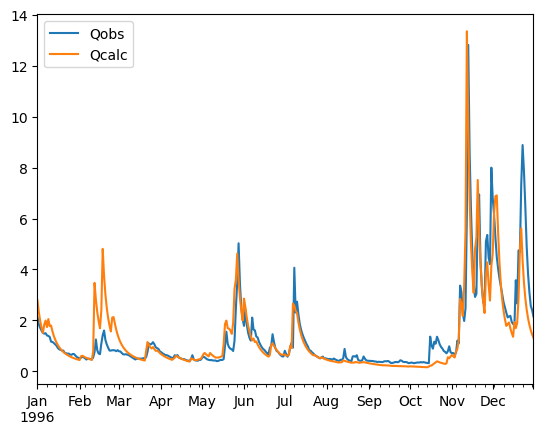

In [49]:
Qtimeseries.loc["1996":"1996"].plot()

<Axes: >

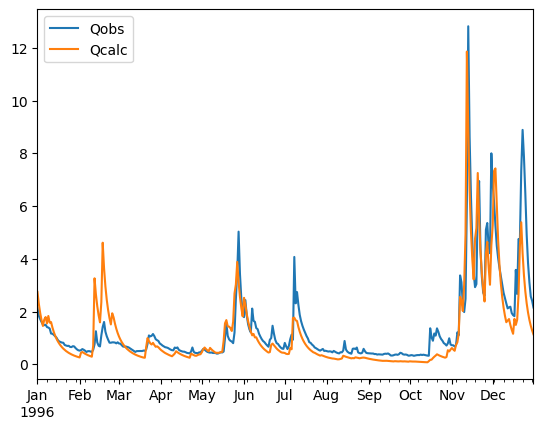

In [421]:
Qtimeseries.loc["1996":"1996"].plot()

<Axes: >

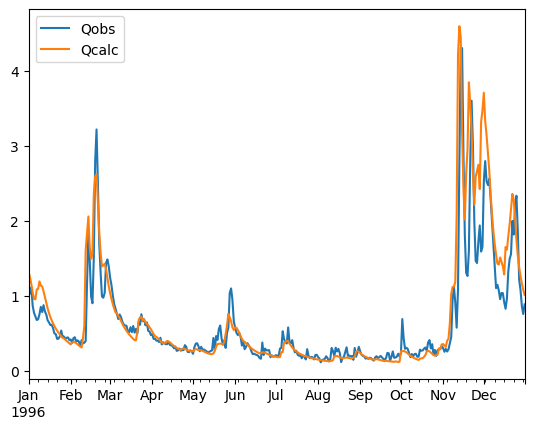

In [54]:
Qtimeseries.loc["1996":"1996"].plot()

<Axes: >

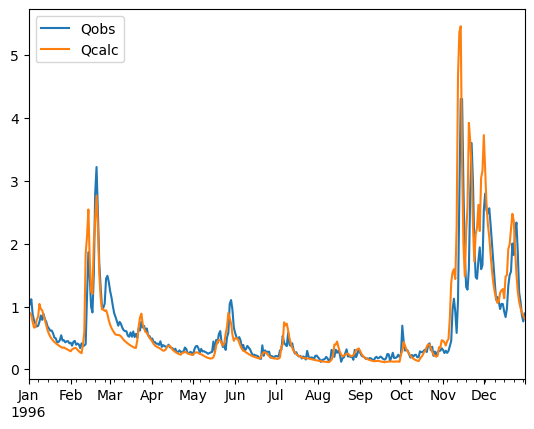

In [243]:
Qtimeseries.loc["1996":"1996"].plot()

<Axes: >

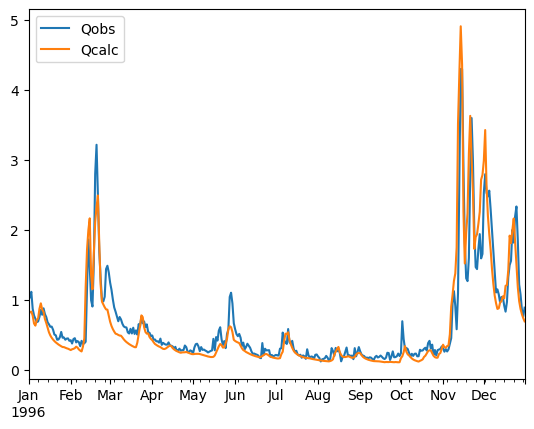

In [217]:
Qtimeseries.loc["1996":"1996"].plot()

<Axes: >

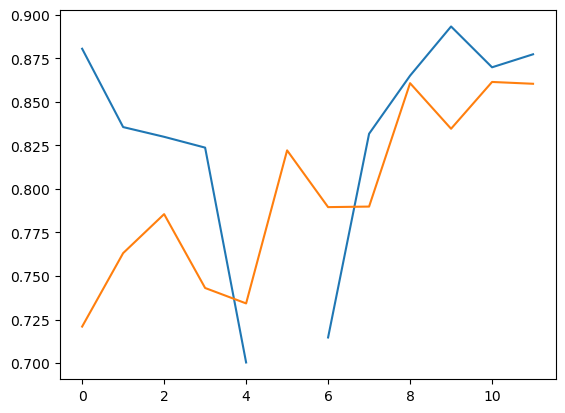

In [ ]:
nse_results_cal.nse.plot()
nse_df.nse.plot()

In [849]:
# Create an empty list to store results
nse_results_teste = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 

    nse_results_teste.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc
    })

# Convert results to DataFrame
nse_df_teste = pd.DataFrame(nse_results_teste)
nse_df_teste

gauge_name     basin        nse  \
0                                               Pruem  DERP2006   0.704425   
1                                             Reuland  BEWA0106   0.658036   
2                               La Cleurie Ã  Cleurie  FR003234   0.486500   
3                                La Meurthe Ã  Fraize  FR003250   0.119606   
4                                            A4020610  FR000124   0.746570   
5                                            Saarburg  DERP2016   0.496545   
6                                          Schoenfels  LU000018   0.488135   
7                              L'Horn Ã  Bousseviller  FR003303  -1.226996   
8                                            Sinspelt  DERP2008   0.713991   
9                                             Hentern  DERP2017   0.724704   
10                         Le Canner Ã  KÅ“nigsmacker  FR003288   0.067242   
11          La Vezouze Ã  BlÃ¢mont et Ã  FrÃ©monville  FR003254   0.721376   
12                                           A6232010  FR000144  -0.150373   
13                                       GemuendIrsen  DERP2005   0.734185   
14                                   L'Orne Ã  Ã‰tain  FR003274   0.439853   
15                                 L'Isch Ã  Postroff  FR003294   0.480063   
16                                           A4050620  FR000125   0.747531   
17                                       Papiermuehle  DERP2030   0.568174   
18                                        Peltzerhaus  DERP2036   0.689391   
19                                           A9021050  FR000185   0.027722   
20                                         Martelange  BEWA0087 -25.444256   
21                              L'Esch Ã  Jezainville  FR003266   0.178726   
22                                            Livange  LU000013   0.129761   
23                              L'Eichel Ã  Oermingen  FR003300   0.610587   
24                                             Bissen  LU000002   0.697827   
25                                         Gerolstein  DERP2022   0.686599   
26                                         Bigonville  LU000001   0.702015   
27                          La Vologne Ã  ChenimÃ©nil  FR003236   0.754914   
28                          Le Rupt de Mad Ã  Onville  FR003267   0.353503   
29                                           A6051020  FR000142   0.656340   
30                                           A5261020  FR000138   0.557625   
31                                              Ouren  BEWA0119   0.733575   
32                                         Kautenbach  LU000011   0.671655   
33                                Heiderscheidergrund  LU000008   0.521230   
34                       La Vezouze Ã  ThiÃ©baumÃ©nil  FR003256   0.646087   
35                        La Mortagne Ã  GerbÃ©viller  FR003261   0.469762   
36                                            Contwig  DERP2013  -0.469231   
37                                        Pruemzurlay  DERP2007   0.746480   
38                                           A4200630  FR000128   0.756494   
39                             La Sarre Ã  Diedendorf  FR003295   0.514473   
40                                             Mersch  LU000014   0.508686   
41                              La Sarre Ã  Keskastel  FR003296   0.547276   
42            La Meurthe Ã  Azerailles et Ã  Baccarat  FR003252   0.722735   
43                                           Michelau  LU000015   0.648263   
44                                 EttelbrueckAlzette  LU000007   0.619443   
45                               L'Orne Ã  Rosselange  FR003283   0.584421   
46                               La Sarre Ã  Wittring  FR003301   0.656117   
47  La Moselle Ã  Saint-Mard et Ã  Tonnoy et Ã  Ve...  FR003241   0.770266   
48                        La Meurthe Ã  DameleviÃ¨res  FR003262   0.730952   
49                                           A6941020  FR000159   0.748236   
50                                         Bollendorf  DERP2003  

<Axes: >

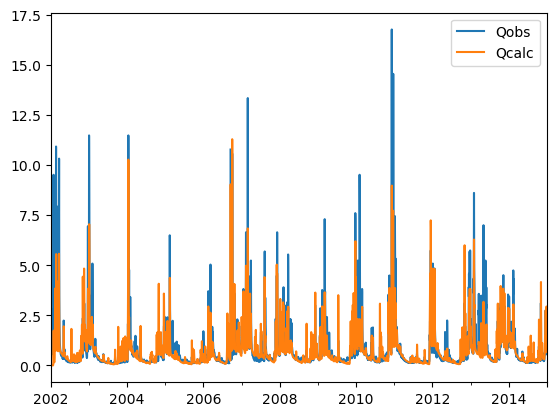

<Axes: >

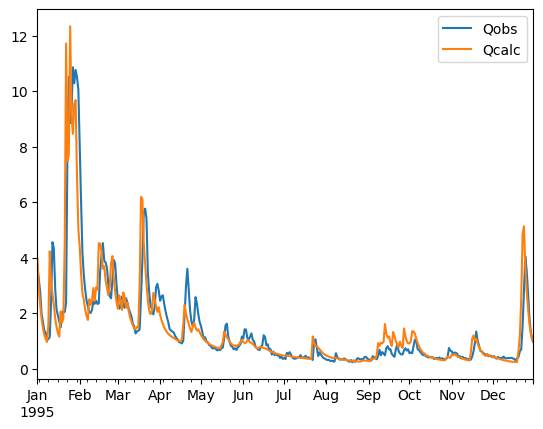

In [298]:
for basin in areas.keys():
    Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    print(basin, 1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5))

FR003237 0.7233558713807696
FR003249 0.7857027176186224
FR003253 0.3878544582627701
FR000159 0.6081680596664203
FR003265 0.7132547232230247
FR003271 0.6637390250040114
FR000171 0.6953316970346151
FR003272 0.691946589157379
FR003283 0.7316089827911934
FR003275 0.7009760159437041
DEBU1956 0.6757108948721947
DEBU1957 0.7483438095953565
FR003308 0.7618494373966822
FR003301 0.7811255177666672
FR003304 0.449355969739905
LU000007 0.7332146572606155
DERP2004 0.7649510673714486
DERP2017 0.6359296340769447
DEBU1958 0.7089337378169949
DERP2024 0.6272714335495646
DERP2033 0.7550015470091432
DEBU1959 0.685422176404427
DERP2011 0.7589612835549371
DERP2003 0.7608982082514891
DERP2007 0.7282897928315735


In [292]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

Qtimeseries["Qobs"] = observations["DERP2033"]
Qtimeseries["Qcalc"] = output["DERP2033"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

ValueError: Length of values (4748) does not match length of index (4749)

<Axes: >

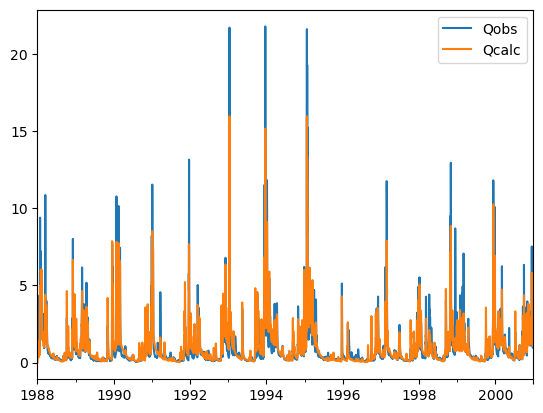

In [310]:
Qtimeseries.plot()

In [301]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003237"]
Qtimeseries["Qcalc"] = output["FR003237"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.7233558713807696

<Axes: >

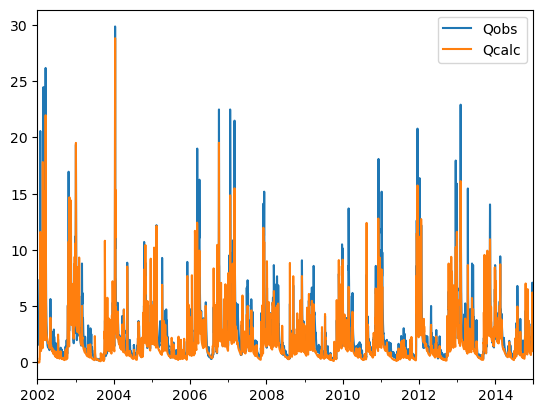

In [302]:
Qtimeseries.plot()

In [234]:
areas

{'FR003237': 1218.14,
 'DERP2004': 615.0,
 'FR003253': 1102.95,
 'FR003249': 3396.832,
 'LU000007': 1115.773}

In [286]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003249"]
Qtimeseries["Qcalc"] = output["FR003249"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.7976164883940482

<Axes: >

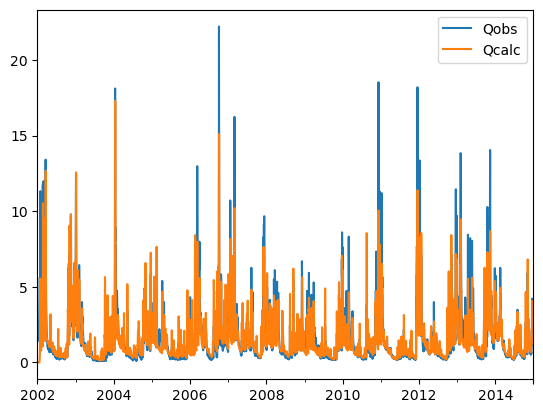

In [287]:
Qtimeseries.plot()

In [288]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003253"]
Qtimeseries["Qcalc"] = output["FR003253"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.54352649657022

In [289]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["LU000007"]
Qtimeseries["Qcalc"] = output["LU000007"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.6551187507433864

0.7380498663278228


<Axes: >

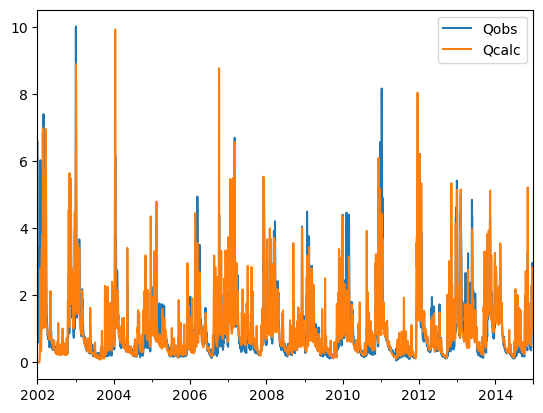

In [292]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["DEBU1959"]
Qtimeseries["Qcalc"] = output["DEBU1959"][0]

print(1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5))
Qtimeseries.plot()

In [187]:
model.reset_states()

# Set inputs for each node using the manually defined dictionary
for cat in catchments:
    cat.set_input(inputs[cat.id])  # Correct way to set inputs


best_params_dict['M4_lowersplitter_split-par'] = 0.65


model.set_timestep(1.0)
model.set_parameters(best_params_dict)

#hyd_mod.reset_states()
output = model.get_output()
output

{'FR003237': [array([0.        , 0.        , 0.        , ..., 1.57438332, 1.47980825,
         1.41788529])],
 'DERP2004': [array([0.        , 0.        , 0.        , ..., 1.9179584 , 1.57526105,
         1.32558672])],
 'FR003253': [array([0.        , 0.        , 0.        , ..., 1.02099612, 1.13402406,
         1.01305816])],
 'DERP2007': [array([0.        , 0.        , 0.        , ..., 1.64363308, 1.36571395,
         1.15799314])],
 'LU000007': [array([0.        , 0.        , 0.        , ..., 1.6860886 , 1.29039931,
         1.13582222])]}

In [188]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003253"]
Qtimeseries["Qcalc"] = output["FR003253"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

-0.29667524112089794

In [185]:
estreams_attributes.loc["FR003253", "baseflow_index"]

0.642

In [186]:
areas

{'FR003237': 1218.14,
 'DERP2004': 615.0,
 'FR003253': 1102.95,
 'DERP2007': 576.0,
 'LU000007': 1115.773}

In [180]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003253"]
Qtimeseries["Qcalc"] = output["FR003253"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

-0.29667524112089794

In [181]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["DERP2007"]
Qtimeseries["Qcalc"] = output["DERP2007"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.4073419927466919

In [182]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["LU000007"]
Qtimeseries["Qcalc"] = output["LU000007"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.7330260915554658

In [122]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["BEWA0107"]
Qtimeseries["Qcalc"] = output["BEWA0107"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

KeyError: 'BEWA0107'

In [123]:
Qtimeseries.plot()

TypeError: no numeric data to plot

In [ ]:



best_model_run = results[bestindex]                                           # Get the outputs from the best run

fields=[word for word in best_model_run.dtype.names if word.startswith('sim')] # Select only the simulated streamflow 
best_simulation = list(best_model_run[fields])


In [101]:
results[bestindex]

(0.21799583, 0.26215353, 0.03040796, 1.04298502, 0.30325854, 4.89524188, 0.54104064, 2.96090588, 0., 0., 0., 0., 0., 0., 3.22830274e-09, 3.22830315e-09, 3.22830484e-09, 3.22830484e-09, 3.22830484e-09, 4.83473582e-09, 9.26305152e-09, 9.26305704e-09, 9.26306495e-09, 2.46473382e-07, 2.39202513e-07, 8.67886741e-06, 0.00025929, 0.00404235, 0.0062661, 0.01236216, 0.03278941, 0.1079614, 0.29851124, 1.01452128, 2.670107, 5.14868331, 5.2868262, 2.81678834, 1.59637771, 1.20727177, 1.05250243, 0.91586989, 0.81070585, 0.92893766, 1.27789203, 1.8606845, 2.2005742, 3.47513916, 4.78386541, 6.50633744, 6.62457777, 8.85677967, 9.48615831, 5.56301823, 3.07196287, 2.26184297, 2.09884728, 3.12060445, 6.22657207, 9.48440121, 8.1368917, 5.22019468, 5.7498476, 6.6664143, 8.29846701, 9.32693118, 7.47366003, 4.74975664, 3.63532758, 2.98653908, 2.66623446, 2.47873928, 2.41831956, 2.4250216, 2.48349846, 2.3148532, 2.16848808, 2.0610354, 1.96877264, 1.91439893, 1.95823485, 2.06843085, 2.17012699, 1.94399276, 1.99

In [ ]:



import numpy as np
import spotpy

class spotpy_model(object):

    def __init__(self, catchments, dt, observations, parameters, parameter_names, output_index, warm_up=365):
        """
        Spotpy model for multi-node calibration in SuperflexPy.

        Args:
            catchments (list): List of Node objects.
            dt (float): Time step.
            observations (dict): Observed discharge data for each node.
            parameters (list): List of parameter distributions for calibration.
            parameter_names (list): Names of the parameters.
            output_index (str/int): The output key for extracting model results.
            warm_up (int): Number of time steps to ignore in the evaluation.
        """
        self._catchments = catchments  # Use predefined catchments list
        self._dt = dt  # Time step

        # Store shared calibration parameters
        self._parameters = parameters
        self._parameter_names = parameter_names

        # Store observations for each node
        self._observations = observations  # Dictionary {node_id: observed_data}
        self._output_index = output_index  # Output key (e.g., 'Q_out')
        self._warm_up = int(warm_up)  # Warm-up period

    def parameters(self):
        """Generate parameter samples for calibration."""
        return spotpy.parameter.generate(self._parameters)

    def simulation(self, parameters):
        """Runs the simulation for all nodes using the same parameter set."""

        # Convert parameter list into a dictionary
        named_parameters = {p_name: p for p_name, p in zip(self._parameter_names, parameters)}

        outputs = {}  # Store simulation results for each node

        for cat in self._catchments:  # Iterate over manually defined catchments
            cat.set_parameters(named_parameters)  # Apply shared parameters

            # Generate input data
            P = np.zeros(100)
            P[:10] = np.random.randint(10, size=10)
            P[25:30] = np.random.randint(20, size=5)
            P[40:60] = np.random.randint(5, size=20)
            P[80:83] = np.random.randint(30, 50, size=3)

            E = np.ones_like(P) * 2.0  # Constant PET
            T = (np.random.rand(100) - 0.2) * 20  # Random Temperature

            cat.set_input([P, T, E])  # Directly set input for each node
            cat.set_timestep(self._dt)
            cat.reset_states()  # Reset internal states

            output = cat.get_output()
            outputs[cat.id] = output[self._output_index]  # Store results for each node

        return outputs  # Dictionary with outputs for each node

    def evaluation(self):
        """Returns the observed data for all nodes."""
        return self._observations

    def objectivefunction(self, simulation, evaluation):
        """Computes the average NSE (or another metric) across all nodes."""

        obj_values = []  # Store individual NSE values for each node

        for node_id in simulation.keys():
            # Apply warm-up period
            sim = simulation[node_id][self._warm_up + 1:]
            obs = evaluation[node_id][self._warm_up + 1:]

            # Compute NSE (or another metric like KGE)
            obj_value = obj_fun_nsee(observations=obs, simulation=sim, expo=0.5)
            obj_values.append(obj_value)

        # Compute the average objective function across all nodes
        return np.mean(obj_values)  # Minimize the average error


In [70]:
class spotpy_model(object):

    def __init__(self, model, inputs, dt, observations, parameters, parameter_names, output_index, 
                 warm_up = 365):

        self._model = model
        self._model.set_input(inputs)
        self._model.set_timestep(dt)

        self._parameters = parameters
        self._parameter_names = parameter_names
        self._observarions = observations
        self._output_index = output_index
        
        self._warm_up = int(warm_up)
        
    def parameters(self):
        return spotpy.parameter.generate(self._parameters)
    
    def simulation(self, parameters):

        named_parameters = {}
        for p_name, p in zip(self._parameter_names, parameters):
            named_parameters[p_name] = p

        self._model.set_parameters(named_parameters)
        self._model.reset_states()
        output = self._model.get_output()

        return output[self._output_index]
    
    def evaluation(self):
        return self._observarions
    
    # Here you can use a pre-defined objective function from spotpy, or you can write down your own:    
    def objectivefunction(self, simulation, evaluation):
        #obj_fun = spotpy.objectivefunctions.rmse(evaluation=evaluation,
        #                                                  simulation=simulation)
        #obj_fun = np.sum(np.sqrt(((simulation - evaluation)**2)/100))
        #obj_fun = obj_fun_nsee(observations = evaluation, simulation = simulation, expo = 0.5)
        
        evaluation_used = evaluation[self._warm_up + 1:]
        simulation_used = simulation[self._warm_up + 1:]
        obj_fun = obj_fun_nsee(observations = evaluation_used, simulation = simulation_used, expo = 0.5)
        #obj_fun = obj_fun_kge(observations = evaluation_used, simulation = simulation_used)

        
        return obj_fun

In [71]:
DERP2004.reset_states()

spotpy_hyd_mod = spotpy_model(
    model=DERP2004,
    inputs=[P, T, E],
    dt=1.0,
    observations = Q_obs,
    parameters=[
        spotpy.parameter.Uniform('M4_fast_k', 1e-5, 1.0), #1e-3, 0.5
        #spotpy.parameter.Uniform('M4_fast_alpha', 1.0, 2.0),
        spotpy.parameter.Uniform('M4_slow_k ', 1e-8, 0.1), #0.0001, 1.0
        #spotpy.parameter.Uniform('M4_slow_alpha ', 1, 2),
        #spotpy.parameter.Uniform('M4_unsaturated_Smax', 50, 600), #
        
        spotpy.parameter.Uniform('M4_unsaturated_Ce', 0.1, 3.0),#0.5, 4.0
        spotpy.parameter.Uniform('M4_unsaturated_m', 0.01, 1.0),
        spotpy.parameter.Uniform('M4_unsaturated_beta', 0.1, 10.0),#1.0, 4.0
        spotpy.parameter.Uniform('M4_lowersplitter_split-par', 0.5, 0.9),
        spotpy.parameter.Uniform('M4_lag-fun_lag-time', 1.0, 4.0),
        #spotpy.parameter.Uniform('M4_snow_k', 0.0, 1.0),

    ],
    #parameter_names=['model_FR1_k', 'model_FR1_alpha', 'model_FR1_Ce'],
    parameter_names=['M4_fast_k', 'M4_slow_k', 'M4_unsaturated_Ce', 'M4_unsaturated_m', 'M4_unsaturated_beta',
                     'M4_lowersplitter_split-par', 'M4_lag-fun_lag-time'], #"M4_snow_k"
    output_index=0
)

In [72]:
sampler = spotpy.algorithms.sceua(spotpy_hyd_mod, dbname=None, dbformat='ram')
sampler.sample(repetitions=100)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  100  repetitions
The objective function will be minimized
Starting burn-in sampling...
1 of 100, minimal objective function=0.565567, time remaining: 00:03:14
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
47 of 100, minimal objective function=0.312685, time remaining: 00:00:06
93 of 100, minimal objective function=0.306699, time remaining: 00:00:01
Stopping samplig. Maximum number of repetitions reached already during burn-in
Burn-in sampling completed...
*** OPTIMIZATION SEARCH TERMINATED BECAUSE THE LIMIT
ON THE MAXIMUM NUMBER OF TRIALS 
100
HAS BEEN EXCEEDED.  SEARCH WAS STOPPED AT TRIAL NUMBER:
100
OF THE INITIAL LOOP!
Starting Complex Evolution...
SEARCH WAS STOPPED AT TRIAL NUMBER: 100
NUMBER OF DISCARDED TRIALS: 0
NORMALIZED GEOMETRIC RANGE = 0.995276
THE BEST POINT HAS IMPROVED IN LAST 100 LOOPS BY 100000.000000 PERCENT

*** Final SPOTPY summary ***
Total Duration: 8.34 seconds
Tot

The figure as been saved as "Parameter_trace.png
Run number 2035 has the lowest objectivefunction with: 0.202


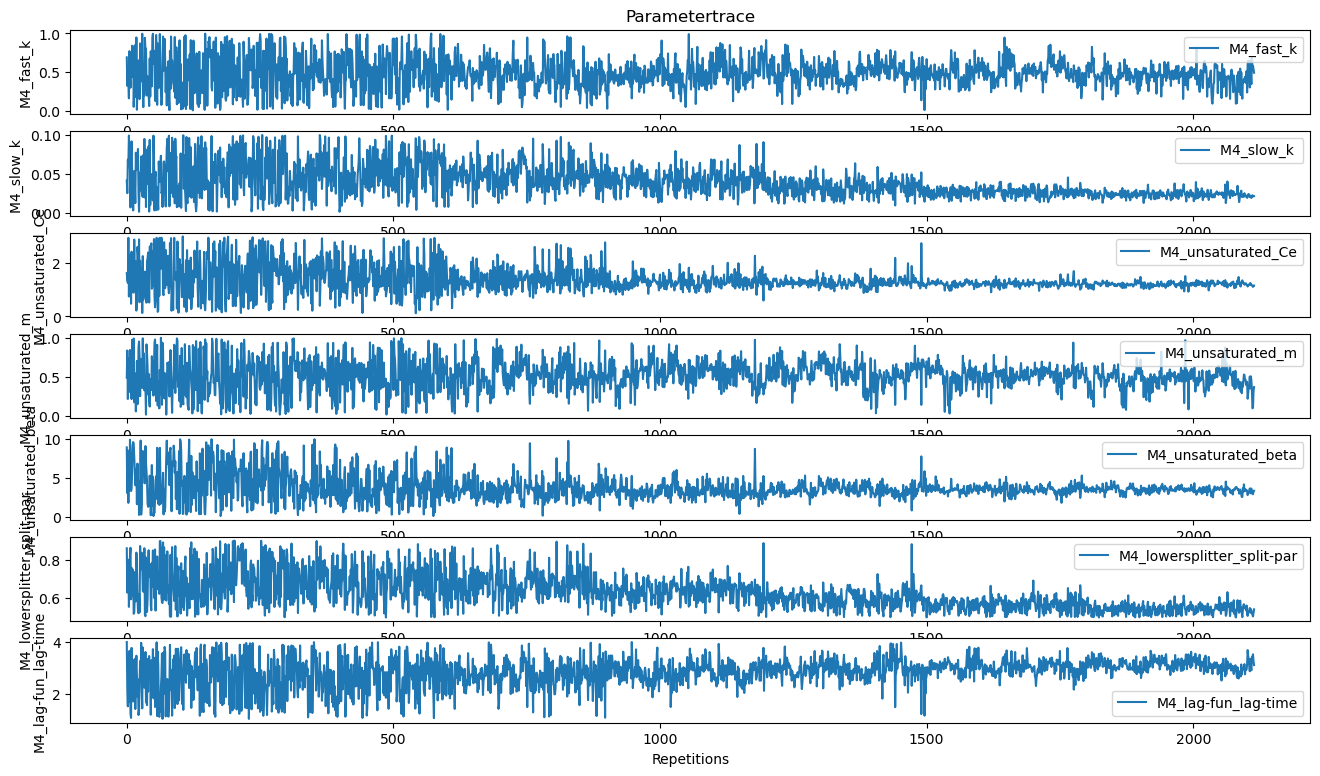

In [622]:
results = sampler.getdata()                                                  # Load the results
spotpy.analyser.plot_parametertrace(results)                                 # Show the results


bestindex, bestobjf = spotpy.analyser.get_minlikeindex(results)               # Get the best indexes and objective function

spotpy.analyser.get_parameters(results)[bestindex]

best_params_dict = dict(zip(spotpy.analyser.get_parameternames(results), spotpy.analyser.get_parameters(results)[bestindex]))


if 'M4_lowersplitter_splitpar' in best_params_dict:
    best_params_dict['M4_lowersplitter_split-par'] = best_params_dict.pop('M4_lowersplitter_splitpar')

if 'M4_lagfun_lagtime' in best_params_dict:
    best_params_dict['M4_lag-fun_lag-time'] = best_params_dict.pop('M4_lagfun_lagtime')

# Remove spaces and replace with underscores (or any other transformation)
best_params_dict = {key.replace(" ", ""): value for key, value in best_params_dict.items()}

best_model_run = results[bestindex]                                           # Get the outputs from the best run

fields=[word for word in best_model_run.dtype.names if word.startswith('sim')] # Select only the simulated streamflow 
best_simulation = list(best_model_run[fields])

In [623]:
best_model_run

(0.20200061, 0.12008787, 0.0198779, 1.22223028, 0.39998824, 3.19294541, 0.51119517, 3.0028395, 0., 0., 0., 0., 0., 0., 3.54544801e-08, 3.47635228e-08, 3.40862573e-08, 3.34219086e-08, 3.2770507e-08, 5.21709113e-08, 1.08241492e-07, 1.06132973e-07, 1.04066199e-07, 3.37398075e-06, 3.30886324e-06, 8.88586634e-05, 0.00125214, 0.00929014, 0.01743471, 0.04064369, 0.07508837, 0.17258437, 0.39702485, 1.00007245, 2.30194319, 4.51820682, 4.97038484, 2.9338087, 1.72997976, 1.261859, 1.05027737, 0.88472904, 0.75497195, 0.81379401, 1.08079594, 1.55596908, 1.86087039, 2.91158524, 4.13663756, 5.86325392, 6.08912922, 8.20314217, 9.15761393, 5.65865208, 3.11695368, 2.15255576, 1.85928087, 2.58365745, 5.2096476, 8.5270946, 7.75610952, 5.02709266, 5.29747893, 6.00473094, 7.47724821, 8.64316058, 7.13361208, 4.5425116, 3.33914416, 2.61832611, 2.25067126, 2.04148448, 1.96606056, 1.97513781, 2.04646186, 1.91202072, 1.79043339, 1.7035145, 1.63032868, 1.59239431, 1.63681642, 1.75182816, 1.86531227, 1.69845856, 1

In [624]:
1 - obj_fun_nsee(observations = Q_obs[365:], simulation = best_simulation[365:], expo = 0.5)

0.7985578052913354

In [625]:
1 - obj_fun_kge(observations = Q_obs[365:], simulation = best_simulation[365:])

0.6466534156753938

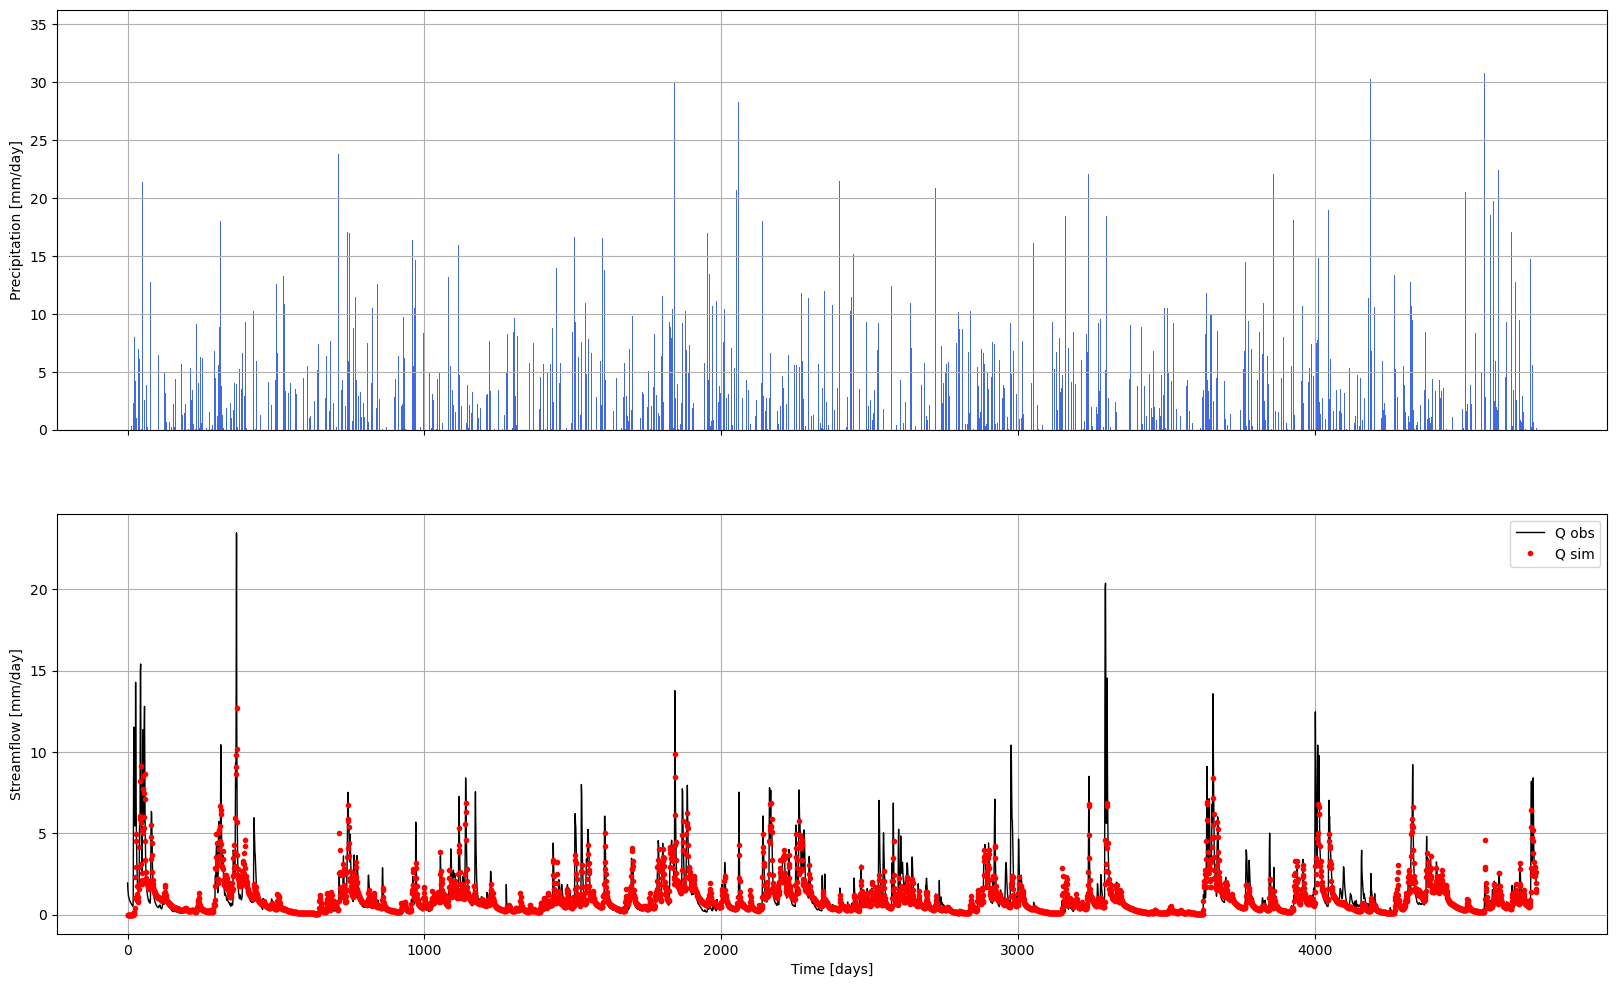

In [626]:
# Plot
fig2, ax2 = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
ax2[0].bar(x=np.arange(len(P)), height=P, color='royalblue')
ax2[0].set_ylabel('Precipitation [mm/day]')
ax2[0].grid(True)
ax2[1].plot(np.arange(len(P)), Q_obs, lw=1, color='black', label='Q obs')
ax2[1].plot(np.arange(len(P)), best_simulation,'.',  lw=1, color='r', label='Q sim')
ax2[1].set_xlabel('Time [days]')
ax2[1].set_ylabel('Streamflow [mm/day]')
ax2[1].legend()
ax2[1].grid(True)
pass

In [627]:
best_params_dict

{'M4_fast_k': 0.1200878726168807,
 'M4_slow_k': 0.0198778976594689,
 'M4_unsaturated_Ce': 1.2222302759799968,
 'M4_unsaturated_m': 0.39998823861160615,
 'M4_unsaturated_beta': 3.1929454065223943,
 'M4_lowersplitter_split-par': 0.5111951674708165,
 'M4_lag-fun_lag-time': 3.0028394978328286}

In [637]:
#best_params_dict['M4_lowersplitter_split-par'] = 0.5
best_params_dict['M4_fast_k'] = 1.0
#best_params_dict['M4_slow_k'] = 0.01
#best_params_dict['M4_snow_k'] = 0.01
#best_params_dict['M4_lag-fun_lag-time'] = 3.0
#best_params_dict['M4_unsaturated_beta'] = 5.0

In [638]:
hyd_mod.reset_states()
hyd_mod.set_input([P,T, E])
hyd_mod.set_timestep(1.0)
hyd_mod.set_parameters(best_params_dict)

#hyd_mod.reset_states()
output = hyd_mod.get_output()
output

[array([0.        , 0.        , 0.        , ..., 1.53705382, 1.24153621,
        1.12653391])]

In [639]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = Q_obs
Qtimeseries["Qcalc"] = output[0]

Qtimeseries

Qobs     Qcalc
2002-01-01  1.950238  0.000000
2002-01-02  1.534647  0.000000
2002-01-03  1.293373  0.000000
2002-01-04  1.131966  0.000000
2002-01-05  1.063647  0.000000
...              ...       ...
2014-12-27  2.787952  3.007358
2014-12-28  2.714421  2.524129
2014-12-29  2.269552  1.537054
2014-12-30  2.025230  1.241536
2014-12-31  1.860129  1.126534

[4748 rows x 2 columns]

In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2001', freq='D'))

Qtimeseries["Qobs"] = Q_obs
Qtimeseries["Qcalc"] = output[0]

Qtimeseries

ValueError: Length of values (4748) does not match length of index (5113)

In [640]:
data_comparation = Qtimeseries.copy()

data_comparation

Qobs     Qcalc
2002-01-01  1.950238  0.000000
2002-01-02  1.534647  0.000000
2002-01-03  1.293373  0.000000
2002-01-04  1.131966  0.000000
2002-01-05  1.063647  0.000000
...              ...       ...
2014-12-27  2.787952  3.007358
2014-12-28  2.714421  2.524129
2014-12-29  2.269552  1.537054
2014-12-30  2.025230  1.241536
2014-12-31  1.860129  1.126534

[4748 rows x 2 columns]

ValueError: zero-size array to reduction operation fmin which has no identity

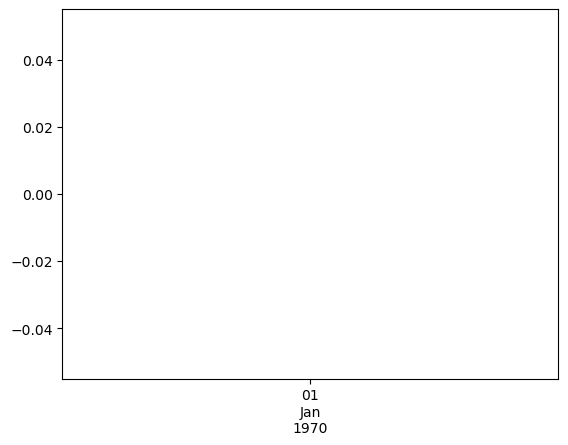

In [641]:
data_comparation.loc["1995-02-01":"1995-06-01"].plot()

<Axes: >

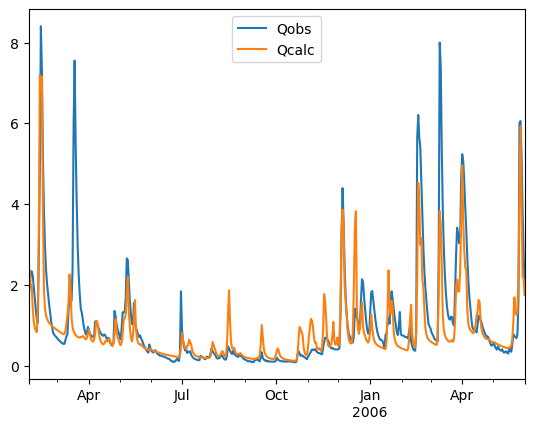

In [642]:
data_comparation.loc["2005-02-01":"2006-06-01"].plot()

In [643]:
1 - obj_fun_nsee(observations = Q_obs[365:], simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

0.7803191635265792

In [644]:
network_estreams.loc[basin_id, :]

gauge_id                                                      2626030300
gauge_name                                                    GemuendOur
gauge_country                                                         DE
gauge_provider                                                     DE_RP
river                                                                Our
lon_snap                                                           6.171
lat_snap                                                          49.985
lon                                                                6.171
lat                                                               49.985
elevation                                                            NaN
area_official                                                      613.4
area_estreams                                                      615.0
area_flag                                                              0
area_rel                                           